In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [2]:
import random
random.seed(12)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy

from tqdm import tqdm

import torch
from torch.utils.data import Dataset
from torchvision import transforms
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F
import cv2

import math

from pytorch_metric_learning import losses, miners, distances, reducers, testers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator

In [3]:
class FERDataset(Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, dff, transforms):
        'Initialization'
        self.transforms = transforms
        self.dff= pd.read_csv(dff) if type(dff) is str else dff
        
        self.dff['pixels'] = [[int(y) for y in x.split()] for x in self.dff['pixels']]

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.dff)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        #ID = self.list_IDs[index]

        # Load data and get label
        X = self.dff.iloc[index]['pixels']
        X = np.array(X).reshape(48,48,1)
        
        y = int(self.dff.iloc[index]['emotion'])

        if self.transforms:
            X = self.transforms(np.uint8(X))

#             X = torch.cat((X,X,X),0)

        return X, y

In [4]:
batch_size= 128

df = pd.read_csv('/tf/data/Quan/fer2013/data/csv_file/fer2013.csv')

df_train = df[df['Usage'] == 'Training']
df_val = df[df['Usage'] == 'PublicTest']
df_test = df[df['Usage'] == 'PrivateTest']

# CLAHE preprocessing
def clahe(x):
    x = np.array(x) # unit8
    x = cv2.normalize(x, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
    x = x.astype(np.uint8)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    x = clahe.apply(x)
    
    return x

train_transforms = transforms.Compose([
    transforms.Lambda(clahe),
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(45),
#     transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

test_transforms = transforms.Compose([
    transforms.Lambda(clahe),
    transforms.ToPILImage(),
#     transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

train_set = FERDataset(df_train, train_transforms)
val_set = FERDataset(df_val, test_transforms)
test_set = FERDataset(df_test, test_transforms)


train_loader = torch.utils.data.DataLoader(train_set,
                                             batch_size=batch_size, shuffle=True,
                                             num_workers=8)
val_loader = torch.utils.data.DataLoader(val_set,
                                             batch_size=batch_size, shuffle=False,
                                             num_workers=8)
test_loader = torch.utils.data.DataLoader(test_set,
                                             batch_size=batch_size, shuffle=False,
                                             num_workers=8)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


## Feature Act v2

In [ ]:
class FeatureAct(nn.Module):
    def __init__(self, src_depth, target_depth, reduce_factor=1):
        super(FeatureAct, self).__init__()
        self.pool = nn.MaxPool2d(kernel_size=(2,2), stride=2)
        
        self.src_conv = nn.Conv2d(src_depth, src_depth // reduce_factor, kernel_size=1, padding=False)
        self.target_conv = nn.Conv2d(target_depth, target_depth // reduce_factor, kernel_size=1, padding=False)
        
    def forward(self, src_x, target_x):
        
        src_features = self.src_conv(src_x)
        src_features = self.pool(src_features)
        
        target_features = self.target_conv(target_x)
        
        
        cor = nn.Flatten(-2)(src_features[:, None, :, :]).permute(0,2,1,3) * nn.Flatten(-2)(target_features[:, None, :, :])
        cor = cor / torch.norm(cor)
#         print(cor.size())
        
        cor_feature = torch.cat([(src_features * cor[:, :, k].view(-1, src_features.size(-3), src_features.size(-2), src_features.size(-1))).sum(1, keepdim=True) for k in range(cor.size(2))], dim=1)
        
        target_x = target_x * (1 + cor_feature)
        
        return target_x

In [ ]:
class BaselineFeatureAct(nn.Module):
    def __init__(self, embeddings=False):
        
        super(BaselineFeatureAct, self).__init__()
        
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=(2,2), stride=2)
        
        self.conv0 = nn.Conv2d(1, 32, kernel_size=(3,3), padding=1, stride=1)
        self.conv0b = nn.Conv2d(32, 32, kernel_size=(3,3), padding=1, stride=1)
        self.bn0 = nn.BatchNorm2d(32)
        self.bn0b = nn.BatchNorm2d(32)
        
        self.conv1 = nn.Conv2d(32, 64, kernel_size=(3,3), padding=1, stride=1)
        self.conv1b = nn.Conv2d(64, 64, kernel_size=(3,3), padding=1, stride=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.bn1b = nn.BatchNorm2d(64)
        
        self.conv2 = nn.Conv2d(64, 128, kernel_size=(3,3), padding=1, stride=1)
        self.conv2b = nn.Conv2d(128, 128, kernel_size=(3,3), padding=1, stride=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn2b = nn.BatchNorm2d(128)
        
        self.conv3 = nn.Conv2d(128, 256, kernel_size=(3,3), padding=1, stride=1)
        self.conv3b = nn.Conv2d(256, 256, kernel_size=(3,3), padding=1, stride=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.bn3b = nn.BatchNorm2d(256)
  
        self.fact0_1 = FeatureAct(32, 64)
        self.fact1_2 = FeatureAct(64, 128)
        self.fact2_3 = FeatureAct(128, 256)
        
        if not embeddings:
            self.classifier = nn.Sequential(nn.Flatten(),
                                            nn.Linear(2304, 256), nn.BatchNorm1d(256), nn.ReLU(inplace=True),
                                            nn.Linear(256, 128), nn.BatchNorm1d(128), nn.ReLU(inplace=True),
                                            nn.Linear(128, 7), nn.BatchNorm1d(7))
        else:
            self.classifier = nn.Sequential(nn.Flatten(),
                                            nn.Linear(2304, 256), nn.BatchNorm1d(256), nn.ReLU(inplace=True),
                                            nn.Linear(256, 128), nn.BatchNorm1d(128))
        
    def forward(self, x):
        
        x = self.conv0(x)
        x = self.bn0(x)
        x = self.relu(x)
        x = self.conv0b(x)
        x = self.bn0b(x)
        x = self.relu(x)
        
        x0 = self.maxpool(x)
        
        x = self.conv1(x0)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv1b(x)
        x = self.bn1b(x)
        x = self.relu(x)
        
        x1 = self.maxpool(x)

        xfact0_1 = self.fact0_1(x0, x1)
        
        x = self.conv2(xfact0_1)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv2b(x)
        x = self.bn2b(x)
        x = self.relu(x)
        
        x2 = self.maxpool(x)

        xfact1_2 = self.fact1_2(x1, x2)
        
        x = self.conv3(xfact1_2)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.conv3b(x)
        x = self.bn3b(x)
        x = self.relu(x)
        
        x3 = self.maxpool(x)

        xfact2_3 = self.fact2_3(x2, x3)
        
        x = nn.Flatten()(xfact2_3)
        x = self.classifier(x)
        
        return x

In [ ]:
device = torch.device('cuda')
model = BaselineFeatureAct().to(device)

best_acc = 0.0
hist = []

epochs=50

criterion = nn.CrossEntropyLoss()

learning_rate = 0.004
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=8, verbose=True)


In [ ]:
model_path = './featureactv2_baseline_model.pt'

for epoch in range(100):  # loop over the dataset multiple times

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0
    processed = 0.0

    # TRAIN
    model.train()
    pbar = tqdm(train_loader, position=0)
    for i, data in enumerate(pbar):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()
        loss.backward()
        
        optimizer.step()

        # print statistics
        running_loss += (loss.item() * inputs.size(0))
        running_acc += acc.item()
        processed += len(inputs)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={i} Accuracy={acc.item() / inputs.size(0)}')

    print('- Avg.loss: %.3f | Avg.acc: %.3f' % (running_loss / len(train_loader.dataset), running_acc / len(train_loader.dataset)))
    avgloss = running_loss / len(train_loader.dataset)
    avgacc = running_acc / len(train_loader.dataset)

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

        running_valloss += (loss.item() * inputs.size(0))
        running_valacc += acc.item()

    print('- Avg. val_loss: %.3f | Avg. val_acc: %.3f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

    avgvalloss = running_valloss / len(val_loader.dataset)
    avgvalacc = running_valacc / len(val_loader.dataset)
    
    scheduler.step(avgvalloss)

    hist.append([avgloss, avgvalloss, avgacc, avgvalacc])
    
    if best_acc < avgvalacc:
        best_acc = avgvalacc
        torch.save(model, model_path)
        print('* Update optimal model')

print('Finished Training')

In [8]:
model = torch.load('featureactv2_baseline_model.pt')

# EVALUATE
model.eval()
running_valloss = 0.0
running_valacc = 0.0
for i,data in enumerate(val_loader):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = model(inputs)

    loss = criterion(outputs, labels)
    acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

    running_valloss += (loss.item() * inputs.size(0))
    running_valacc += acc.item()

print('- Avg. val_loss: %.3f | Avg. val_acc: %.3f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

- Avg. val_loss: 0.982 | Avg. val_acc: 0.641


In [9]:
best_acc = 0.641
hist = []
model_path = './featureactv2_baseline_model.pt'

learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=8, verbose=True)

for epoch in range(30):  # loop over the dataset multiple times

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0
    processed = 0.0

    # TRAIN
    model.train()
    pbar = tqdm(train_loader, position=0)
    for i, data in enumerate(pbar):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()
        loss.backward()
        
        optimizer.step()

        # print statistics
        running_loss += (loss.item() * inputs.size(0))
        running_acc += acc.item()
        processed += len(inputs)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={i} Accuracy={acc.item() / inputs.size(0)}')

    print('- Avg.loss: %.3f | Avg.acc: %.3f' % (running_loss / len(train_loader.dataset), running_acc / len(train_loader.dataset)))
    avgloss = running_loss / len(train_loader.dataset)
    avgacc = running_acc / len(train_loader.dataset)

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

        running_valloss += (loss.item() * inputs.size(0))
        running_valacc += acc.item()

    print('- Avg. val_loss: %.3f | Avg. val_acc: %.3f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

    avgvalloss = running_valloss / len(val_loader.dataset)
    avgvalacc = running_valacc / len(val_loader.dataset)
    
    scheduler.step(avgvalloss)

    hist.append([avgloss, avgvalloss, avgacc, avgvalacc])
    
    if best_acc < avgvalacc:
        best_acc = avgvalacc
        torch.save(model, model_path)
        print('* Update optimal model')

print('Finished Training')

  0%|          | 0/225 [00:00<?, ?it/s]

Epoch:  1


Loss=1.2117869853973389 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [07:02<00:00,  1.88s/it]

- Avg.loss: 0.818 | Avg.acc: 0.693



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.975 | Avg. val_acc: 0.641
* Update optimal model
Epoch:  2


Loss=0.9923679232597351 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [07:02<00:00,  1.88s/it]

- Avg.loss: 0.810 | Avg.acc: 0.698



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.991 | Avg. val_acc: 0.639
Epoch:  3


Loss=1.2623507976531982 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [07:02<00:00,  1.88s/it]

- Avg.loss: 0.811 | Avg.acc: 0.695



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.979 | Avg. val_acc: 0.640
Epoch:  4


Loss=0.6732751727104187 Batch_id=224 Accuracy=0.8108108108108109: 100%|██████████| 225/225 [07:03<00:00,  1.88s/it]

- Avg.loss: 0.809 | Avg.acc: 0.695



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.990 | Avg. val_acc: 0.629
Epoch:  5


Loss=0.8377025127410889 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [07:02<00:00,  1.88s/it]

- Avg.loss: 0.798 | Avg.acc: 0.701



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.006 | Avg. val_acc: 0.629
Epoch:  6


Loss=0.6549426913261414 Batch_id=224 Accuracy=0.8648648648648649: 100%|██████████| 225/225 [07:02<00:00,  1.88s/it]

- Avg.loss: 0.805 | Avg.acc: 0.697



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.983 | Avg. val_acc: 0.645
* Update optimal model
Epoch:  7


Loss=1.1300175189971924 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [07:03<00:00,  1.88s/it]

- Avg.loss: 0.798 | Avg.acc: 0.701



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.988 | Avg. val_acc: 0.646
* Update optimal model
Epoch:  8


Loss=1.0521869659423828 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [07:02<00:00,  1.88s/it]

- Avg.loss: 0.796 | Avg.acc: 0.701



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.000 | Avg. val_acc: 0.632
Epoch:  9


Loss=0.7636892199516296 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [07:02<00:00,  1.88s/it]

- Avg.loss: 0.788 | Avg.acc: 0.700



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.993 | Avg. val_acc: 0.634
Epoch:  10


Loss=0.9027790427207947 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [07:02<00:00,  1.88s/it]

- Avg.loss: 0.791 | Avg.acc: 0.705



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.998 | Avg. val_acc: 0.637
Epoch    10: reducing learning rate of group 0 to 5.0000e-04.
Epoch:  11


Loss=0.6927148103713989 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [07:02<00:00,  1.88s/it]

- Avg.loss: 0.766 | Avg.acc: 0.716



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.977 | Avg. val_acc: 0.647
* Update optimal model
Epoch:  12


Loss=0.8651959300041199 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [07:02<00:00,  1.88s/it]

- Avg.loss: 0.747 | Avg.acc: 0.723



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.985 | Avg. val_acc: 0.653
* Update optimal model
Epoch:  13


Loss=0.8510183095932007 Batch_id=48 Accuracy=0.6953125:  21%|██▏       | 48/225 [01:33<05:32,  1.88s/it]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Loss=0.8995766639709473 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [07:02<00:00,  1.88s/it]

- Avg.loss: 0.701 | Avg.acc: 0.741



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.001 | Avg. val_acc: 0.648
Epoch:  23


Loss=0.9664439558982849 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [07:02<00:00,  1.88s/it]

- Avg.loss: 0.692 | Avg.acc: 0.744



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.001 | Avg. val_acc: 0.650
Epoch:  24


Loss=0.6936652064323425 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [07:02<00:00,  1.88s/it]

- Avg.loss: 0.685 | Avg.acc: 0.746



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.009 | Avg. val_acc: 0.653
Epoch:  25


Loss=0.9231859445571899 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [07:02<00:00,  1.88s/it]

- Avg.loss: 0.687 | Avg.acc: 0.744



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.001 | Avg. val_acc: 0.655
* Update optimal model
Epoch:  26


Loss=1.1714171171188354 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [07:02<00:00,  1.88s/it]

- Avg.loss: 0.682 | Avg.acc: 0.746



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.995 | Avg. val_acc: 0.651
Epoch:  27


Loss=0.7715266942977905 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [07:02<00:00,  1.88s/it]

- Avg.loss: 0.677 | Avg.acc: 0.750



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.002 | Avg. val_acc: 0.653
Epoch:  28


Loss=0.6414530873298645 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [07:02<00:00,  1.88s/it]

- Avg.loss: 0.681 | Avg.acc: 0.746



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.002 | Avg. val_acc: 0.645
Epoch    28: reducing learning rate of group 0 to 1.2500e-04.
Epoch:  29


Loss=0.5674889087677002 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [07:02<00:00,  1.88s/it]

- Avg.loss: 0.672 | Avg.acc: 0.752



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.010 | Avg. val_acc: 0.647
Epoch:  30


Loss=0.6798227429389954 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [07:02<00:00,  1.88s/it]

- Avg.loss: 0.665 | Avg.acc: 0.754


- Avg. val_loss: 0.998 | Avg. val_acc: 0.655
* Update optimal model
Finished Training


([<matplotlib.lines.Line2D at 0x7fd31f6579b0>,
 0.6553357481192533)

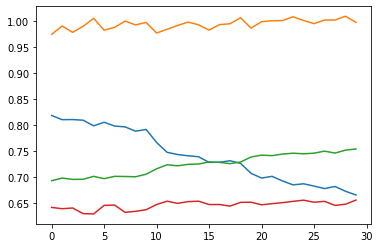

In [10]:
plt.plot(hist), best_acc

In [22]:
test_model = torch.load('featureactv2_baseline_model.pt')

# EVALUATE
test_model.eval()
running_valloss = 0.0
running_valacc = 0.0
for i,data in enumerate(test_loader):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = test_model(inputs)

    loss = criterion(outputs, labels)
    acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

    running_valloss += (loss.item() * inputs.size(0))
    running_valacc += acc.item()

print('- Avg. val_loss: %.3f | Avg. val_acc: %.3f' % (running_valloss / len(test_loader.dataset), running_valacc / len(test_loader.dataset)))

- Avg. val_loss: 0.947 | Avg. val_acc: 0.672


### Continue training for 10 epochs

In [12]:
for epoch in range(10):  # loop over the dataset multiple times

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0
    processed = 0.0

    # TRAIN
    model.train()
    pbar = tqdm(train_loader, position=0)
    for i, data in enumerate(pbar):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()
        loss.backward()
        
        optimizer.step()

        # print statistics
        running_loss += (loss.item() * inputs.size(0))
        running_acc += acc.item()
        processed += len(inputs)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={i} Accuracy={acc.item() / inputs.size(0)}')

    print('- Avg.loss: %.3f | Avg.acc: %.3f' % (running_loss / len(train_loader.dataset), running_acc / len(train_loader.dataset)))
    avgloss = running_loss / len(train_loader.dataset)
    avgacc = running_acc / len(train_loader.dataset)

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

        running_valloss += (loss.item() * inputs.size(0))
        running_valacc += acc.item()

    print('- Avg. val_loss: %.3f | Avg. val_acc: %.3f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

    avgvalloss = running_valloss / len(val_loader.dataset)
    avgvalacc = running_valacc / len(val_loader.dataset)
    
    scheduler.step(avgvalloss)

    hist.append([avgloss, avgvalloss, avgacc, avgvalacc])
    
    if best_acc < avgvalacc:
        best_acc = avgvalacc
        torch.save(model, model_path)
        print('* Update optimal model')

print('Finished Training')

  0%|          | 0/225 [00:00<?, ?it/s]

Epoch:  1


Loss=0.7098674178123474 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [07:02<00:00,  1.88s/it]

- Avg.loss: 0.659 | Avg.acc: 0.754



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.002 | Avg. val_acc: 0.651
Epoch:  2


Loss=0.7258409261703491 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [07:02<00:00,  1.88s/it]

- Avg.loss: 0.661 | Avg.acc: 0.756



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.012 | Avg. val_acc: 0.651
Epoch:  3


Loss=0.5716678500175476 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [07:03<00:00,  1.88s/it]

- Avg.loss: 0.653 | Avg.acc: 0.756



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.010 | Avg. val_acc: 0.654
Epoch:  4


Loss=0.5826155543327332 Batch_id=224 Accuracy=0.8108108108108109: 100%|██████████| 225/225 [07:02<00:00,  1.88s/it]

- Avg.loss: 0.657 | Avg.acc: 0.756



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.009 | Avg. val_acc: 0.654
Epoch:  5


Loss=0.991919755935669 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [07:03<00:00,  1.88s/it]

- Avg.loss: 0.657 | Avg.acc: 0.757



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.013 | Avg. val_acc: 0.651
Epoch:  6


Loss=1.0752683877944946 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [07:02<00:00,  1.88s/it]

- Avg.loss: 0.658 | Avg.acc: 0.754



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.011 | Avg. val_acc: 0.652
Epoch:  7


Loss=0.4881737232208252 Batch_id=224 Accuracy=0.8108108108108109: 100%|██████████| 225/225 [07:02<00:00,  1.88s/it]

- Avg.loss: 0.653 | Avg.acc: 0.760



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.016 | Avg. val_acc: 0.650
Epoch    37: reducing learning rate of group 0 to 6.2500e-05.
Epoch:  8


Loss=0.7484011650085449 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [07:02<00:00,  1.88s/it]

- Avg.loss: 0.646 | Avg.acc: 0.762



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.016 | Avg. val_acc: 0.653
Epoch:  9


Loss=0.6328519582748413 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [07:02<00:00,  1.88s/it]

- Avg.loss: 0.648 | Avg.acc: 0.761



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.022 | Avg. val_acc: 0.651
Epoch:  10


Loss=1.2766202688217163 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [07:02<00:00,  1.88s/it]

- Avg.loss: 0.649 | Avg.acc: 0.761


- Avg. val_loss: 1.024 | Avg. val_acc: 0.653
Finished Training


([<matplotlib.lines.Line2D at 0x7fd31cd7f128>,
 0.6553357481192533)

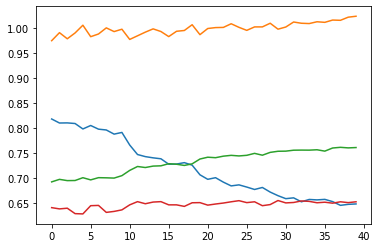

In [13]:
plt.plot(hist), best_acc

### With triplet loss

In [6]:
class BaselineFeatureAct(nn.Module):
    def __init__(self, embeddings=False):
        
        super(BaselineFeatureAct, self).__init__()
        
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=(2,2), stride=2)
        
        self.conv0 = nn.Conv2d(1, 32, kernel_size=(3,3), padding=1, stride=1)
        self.conv0b = nn.Conv2d(32, 32, kernel_size=(3,3), padding=1, stride=1)
        self.bn0 = nn.BatchNorm2d(32)
        self.bn0b = nn.BatchNorm2d(32)
        
        self.conv1 = nn.Conv2d(32, 64, kernel_size=(3,3), padding=1, stride=1)
        self.conv1b = nn.Conv2d(64, 64, kernel_size=(3,3), padding=1, stride=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.bn1b = nn.BatchNorm2d(64)
        
        self.conv2 = nn.Conv2d(64, 128, kernel_size=(3,3), padding=1, stride=1)
        self.conv2b = nn.Conv2d(128, 128, kernel_size=(3,3), padding=1, stride=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn2b = nn.BatchNorm2d(128)
        
        self.conv3 = nn.Conv2d(128, 256, kernel_size=(3,3), padding=1, stride=1)
        self.conv3b = nn.Conv2d(256, 256, kernel_size=(3,3), padding=1, stride=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.bn3b = nn.BatchNorm2d(256)
  
        self.fact0_1 = FeatureAct(32, 64)
        self.fact1_2 = FeatureAct(64, 128)
        self.fact2_3 = FeatureAct(128, 256)
        
        
        if not embeddings:
            self.classifier = nn.Sequential(nn.Flatten(),
                                            nn.Linear(2304, 256), nn.BatchNorm1d(256), nn.ReLU(inplace=True),
                                            nn.Linear(256, 128), nn.BatchNorm1d(128), nn.ReLU(inplace=True),
                                            nn.Linear(128, 7), nn.BatchNorm1d(7))
        else:
            self.classifier = nn.Sequential(nn.Flatten(),
                                            nn.Linear(2304, 256), nn.BatchNorm1d(256), nn.ReLU(inplace=True),
                                            nn.Linear(256, 128), nn.BatchNorm1d(128))
        
    def forward(self, x):
        
        x = self.conv0(x)
        x = self.bn0(x)
        x = self.relu(x)
        x = self.conv0b(x)
        x = self.bn0b(x)
        x = self.relu(x)
        
        x0 = self.maxpool(x)
        
        x = self.conv1(x0)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv1b(x)
        x = self.bn1b(x)
        x = self.relu(x)
        
        x1 = self.maxpool(x)

        xfact0_1 = self.fact0_1(x0, x1)
        
        x = self.conv2(xfact0_1)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv2b(x)
        x = self.bn2b(x)
        x = self.relu(x)
        
        x2 = self.maxpool(x)

        xfact1_2 = self.fact1_2(x1, x2)
        
        x = self.conv3(xfact1_2)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.conv3b(x)
        x = self.bn3b(x)
        x = self.relu(x)
        
        x3 = self.maxpool(x)

        xfact2_3 = self.fact2_3(x2, x3)
        
        x = nn.Flatten()(xfact2_3)
        x_emb = F.normalize(x, p=2, dim=1)
        
        x = self.classifier(x)
        
        return x, x_emb

In [8]:
device = torch.device('cuda')
model = BaselineFeatureAct().to(device)

best_acc = 0.0
hist = []

epochs=50

criterion = nn.CrossEntropyLoss()

learning_rate = 0.004
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=7, verbose=True)


distance = distances.CosineSimilarity()
reducer = reducers.ThresholdReducer(low = 0)
loss_func = losses.TripletMarginLoss(margin = 0.2, distance = distance, reducer = reducer)
mining_func = miners.TripletMarginMiner(margin = 0.2, distance = distance, type_of_triplets = "semihard")

In [9]:
model_path = './featureactv2_baseline_tripletloss_model.pt'

for epoch in range(100):  # loop over the dataset multiple times

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0
    processed = 0.0

    # TRAIN
    model.train()
    pbar = tqdm(train_loader, position=0)
    for i, data in enumerate(pbar):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs, embeddings = model(inputs)
        
        indices_tuple = mining_func(embeddings, labels)
        triplet_loss = loss_func(embeddings, labels, indices_tuple)
        loss = criterion(outputs, labels)
        all_loss = loss + triplet_loss
        
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()
        all_loss.backward()
        
        optimizer.step()

        # print statistics
        running_loss += (all_loss.item() * inputs.size(0))
        running_acc += acc.item()
        processed += len(inputs)

        pbar.set_description(desc= f'Loss={all_loss.item()} cep_loss={loss.item()} triplet_loss={triplet_loss.item()} Batch_id={i} Accuracy={acc.item() / inputs.size(0)}')

    print('- Avg.loss: %.3f | Avg.acc: %.3f' % (running_loss / len(train_loader.dataset), running_acc / len(train_loader.dataset)))
    avgloss = running_loss / len(train_loader.dataset)
    avgacc = running_acc / len(train_loader.dataset)

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs, embeddings = model(inputs)
        indices_tuple = mining_func(embeddings, labels)
        triplet_loss = loss_func(embeddings, labels, indices_tuple)
        loss = criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()
        
        all_loss = loss + triplet_loss
        
        running_valloss += (all_loss.item() * inputs.size(0))
        running_valacc += acc.item()

    print('- Avg. val_loss: %.3f | Avg. val_acc: %.3f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

    avgvalloss = running_valloss / len(val_loader.dataset)
    avgvalacc = running_valacc / len(val_loader.dataset)
        
    scheduler.step(avgvalloss)

    hist.append([avgloss, avgvalloss, avgacc, avgvalacc])
    
    if best_acc < avgvalacc:
        best_acc = avgvalacc
        torch.save(model, model_path)
        print('* Update optimal model')

print('Finished Training')

  0%|          | 0/225 [00:00<?, ?it/s]

Epoch:  1


Loss=1.5994776487350464 cep_loss=1.493729591369629 triplet_loss=0.10574807226657867 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [07:04<00:00,  1.88s/it]

- Avg.loss: 1.809 | Avg.acc: 0.336



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.591 | Avg. val_acc: 0.421
* Update optimal model
Epoch:  2


Loss=1.4071311950683594 cep_loss=1.3036742210388184 triplet_loss=0.1034570187330246 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [07:04<00:00,  1.89s/it]

- Avg.loss: 1.529 | Avg.acc: 0.453



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.587 | Avg. val_acc: 0.422
* Update optimal model
Epoch:  3


Loss=1.5484633445739746 cep_loss=1.4382503032684326 triplet_loss=0.1102130264043808 Batch_id=224 Accuracy=0.4594594594594595: 100%|██████████| 225/225 [07:04<00:00,  1.89s/it]

- Avg.loss: 1.441 | Avg.acc: 0.488



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.366 | Avg. val_acc: 0.523
* Update optimal model
Epoch:  4


Loss=1.312063217163086 cep_loss=1.2085018157958984 triplet_loss=0.10356142371892929 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [07:04<00:00,  1.88s/it]

- Avg.loss: 1.388 | Avg.acc: 0.503



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.392 | Avg. val_acc: 0.515
Epoch:  5


Loss=1.4036383628845215 cep_loss=1.2927836179733276 triplet_loss=0.11085468530654907 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [07:03<00:00,  1.88s/it]

- Avg.loss: 1.343 | Avg.acc: 0.527



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.337 | Avg. val_acc: 0.532
* Update optimal model
Epoch:  6


Loss=1.1736087799072266 cep_loss=1.066985011100769 triplet_loss=0.10662372410297394 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [07:04<00:00,  1.89s/it]

- Avg.loss: 1.319 | Avg.acc: 0.535



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.382 | Avg. val_acc: 0.480
Epoch:  7


Loss=1.7227916717529297 cep_loss=1.6142325401306152 triplet_loss=0.10855907201766968 Batch_id=224 Accuracy=0.43243243243243246: 100%|██████████| 225/225 [07:04<00:00,  1.88s/it]

- Avg.loss: 1.297 | Avg.acc: 0.544



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.318 | Avg. val_acc: 0.537
* Update optimal model
Epoch:  8


Loss=1.1508482694625854 cep_loss=1.052127718925476 triplet_loss=0.09872052818536758 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [07:04<00:00,  1.89s/it]

- Avg.loss: 1.279 | Avg.acc: 0.554



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.312 | Avg. val_acc: 0.541
* Update optimal model
Epoch:  9


Loss=1.305025577545166 cep_loss=1.1976162195205688 triplet_loss=0.10740938037633896 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [07:04<00:00,  1.89s/it]

- Avg.loss: 1.262 | Avg.acc: 0.559



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.229 | Avg. val_acc: 0.578
* Update optimal model
Epoch:  10


Loss=1.0523518323898315 cep_loss=0.9498186707496643 triplet_loss=0.10253311693668365 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [07:04<00:00,  1.89s/it]

- Avg.loss: 1.247 | Avg.acc: 0.567



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.300 | Avg. val_acc: 0.543
Epoch:  11


Loss=1.0135313272476196 cep_loss=0.9163461923599243 triplet_loss=0.09718509018421173 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [07:04<00:00,  1.88s/it]

- Avg.loss: 1.242 | Avg.acc: 0.568



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.306 | Avg. val_acc: 0.544
Epoch:  12


Loss=1.2150976657867432 cep_loss=1.1132616996765137 triplet_loss=0.1018359512090683 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [07:03<00:00,  1.88s/it]

- Avg.loss: 1.232 | Avg.acc: 0.572



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.264 | Avg. val_acc: 0.560
Epoch:  13


Loss=1.3424665927886963 cep_loss=1.238477349281311 triplet_loss=0.10398919135332108 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [07:03<00:00,  1.88s/it]

- Avg.loss: 1.223 | Avg.acc: 0.574



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.248 | Avg. val_acc: 0.559
Epoch:  14


Loss=1.2446471452713013 cep_loss=1.1441385746002197 triplet_loss=0.10050856322050095 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [07:04<00:00,  1.89s/it]

- Avg.loss: 1.217 | Avg.acc: 0.579



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.241 | Avg. val_acc: 0.575
Epoch:  15


Loss=1.2688102722167969 cep_loss=1.1683467626571655 triplet_loss=0.10046350210905075 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [07:04<00:00,  1.88s/it]

- Avg.loss: 1.214 | Avg.acc: 0.581



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.236 | Avg. val_acc: 0.568
Epoch:  16


Loss=1.2815495729446411 cep_loss=1.1803011894226074 triplet_loss=0.1012483611702919 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [07:03<00:00,  1.88s/it]

- Avg.loss: 1.202 | Avg.acc: 0.584



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.237 | Avg. val_acc: 0.576
Epoch:  17


Loss=1.3279449939727783 cep_loss=1.22553551197052 triplet_loss=0.1024094894528389 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [07:04<00:00,  1.88s/it]

- Avg.loss: 1.191 | Avg.acc: 0.588



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.190 | Avg. val_acc: 0.591
* Update optimal model
Epoch:  18


Loss=1.4338611364364624 cep_loss=1.3373899459838867 triplet_loss=0.09647123515605927 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [07:03<00:00,  1.88s/it]

- Avg.loss: 1.189 | Avg.acc: 0.590



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.207 | Avg. val_acc: 0.589
Epoch:  19


Loss=1.3940337896347046 cep_loss=1.2906510829925537 triplet_loss=0.1033826619386673 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [07:04<00:00,  1.89s/it]

- Avg.loss: 1.184 | Avg.acc: 0.591



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.162 | Avg. val_acc: 0.605
* Update optimal model
Epoch:  20


Loss=1.5066193342208862 cep_loss=1.4074265956878662 triplet_loss=0.09919268637895584 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [07:04<00:00,  1.89s/it]

- Avg.loss: 1.171 | Avg.acc: 0.598



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.226 | Avg. val_acc: 0.577
Epoch:  21


Loss=1.0934394598007202 cep_loss=0.9999557733535767 triplet_loss=0.09348364919424057 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [07:04<00:00,  1.89s/it]

- Avg.loss: 1.179 | Avg.acc: 0.592



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.180 | Avg. val_acc: 0.597
Epoch:  22


Loss=1.0021193027496338 cep_loss=0.9023605585098267 triplet_loss=0.09975870698690414 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [07:03<00:00,  1.88s/it]

- Avg.loss: 1.167 | Avg.acc: 0.598



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.203 | Avg. val_acc: 0.590
Epoch:  23


Loss=1.349629521369934 cep_loss=1.2493603229522705 triplet_loss=0.10026922076940536 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [07:03<00:00,  1.88s/it]

- Avg.loss: 1.158 | Avg.acc: 0.601



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.186 | Avg. val_acc: 0.595
Epoch:  24


Loss=1.0123063325881958 cep_loss=0.9146024584770203 triplet_loss=0.09770387411117554 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [07:04<00:00,  1.88s/it]

- Avg.loss: 1.156 | Avg.acc: 0.601



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.148 | Avg. val_acc: 0.608
* Update optimal model
Epoch:  25


Loss=0.963135838508606 cep_loss=0.8614363670349121 triplet_loss=0.10169948637485504 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [07:04<00:00,  1.89s/it]

- Avg.loss: 1.154 | Avg.acc: 0.604



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.173 | Avg. val_acc: 0.603
Epoch:  26


Loss=1.0111141204833984 cep_loss=0.9109538197517395 triplet_loss=0.10016035288572311 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [07:03<00:00,  1.88s/it]

- Avg.loss: 1.144 | Avg.acc: 0.610



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.181 | Avg. val_acc: 0.593
Epoch:  27


Loss=0.9070936441421509 cep_loss=0.8092138767242432 triplet_loss=0.09787975996732712 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [07:03<00:00,  1.88s/it]

- Avg.loss: 1.146 | Avg.acc: 0.606



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.156 | Avg. val_acc: 0.607
Epoch:  28


Loss=1.5598610639572144 cep_loss=1.4569796323776245 triplet_loss=0.10288142412900925 Batch_id=224 Accuracy=0.4594594594594595: 100%|██████████| 225/225 [07:03<00:00,  1.88s/it]

- Avg.loss: 1.143 | Avg.acc: 0.607



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.159 | Avg. val_acc: 0.608
Epoch:  29


Loss=1.3539520502090454 cep_loss=1.2470132112503052 triplet_loss=0.10693878680467606 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [07:04<00:00,  1.88s/it]

- Avg.loss: 1.137 | Avg.acc: 0.611



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.188 | Avg. val_acc: 0.590
Epoch:  30


Loss=1.2987756729125977 cep_loss=1.1966782808303833 triplet_loss=0.10209742933511734 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [07:04<00:00,  1.89s/it]

- Avg.loss: 1.131 | Avg.acc: 0.612



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.129 | Avg. val_acc: 0.615
* Update optimal model
Epoch:  31


Loss=1.2238980531692505 cep_loss=1.1222063302993774 triplet_loss=0.10169167816638947 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [07:04<00:00,  1.88s/it]

- Avg.loss: 1.136 | Avg.acc: 0.607



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.185 | Avg. val_acc: 0.602
Epoch:  32


Loss=0.9629918932914734 cep_loss=0.8626619577407837 triplet_loss=0.1003299430012703 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [07:04<00:00,  1.89s/it]

- Avg.loss: 1.130 | Avg.acc: 0.610



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.178 | Avg. val_acc: 0.598
Epoch:  33


Loss=1.1368516683578491 cep_loss=1.0349490642547607 triplet_loss=0.10190263390541077 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [07:03<00:00,  1.88s/it]

- Avg.loss: 1.129 | Avg.acc: 0.611



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.154 | Avg. val_acc: 0.607
Epoch:  34


Loss=0.9779158234596252 cep_loss=0.8817849159240723 triplet_loss=0.09613092243671417 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [07:03<00:00,  1.88s/it]

- Avg.loss: 1.120 | Avg.acc: 0.620



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.180 | Avg. val_acc: 0.596
Epoch:  35


Loss=1.0786464214324951 cep_loss=0.97525954246521 triplet_loss=0.10338683426380157 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [07:04<00:00,  1.88s/it]

- Avg.loss: 1.123 | Avg.acc: 0.613



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.144 | Avg. val_acc: 0.611
Epoch:  36


Loss=0.819187581539154 cep_loss=0.7199435830116272 triplet_loss=0.09924402087926865 Batch_id=224 Accuracy=0.8108108108108109: 100%|██████████| 225/225 [07:03<00:00,  1.88s/it]

- Avg.loss: 1.123 | Avg.acc: 0.614



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.154 | Avg. val_acc: 0.604
Epoch:  37


Loss=1.2536509037017822 cep_loss=1.1476249694824219 triplet_loss=0.10602598637342453 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [07:04<00:00,  1.89s/it]

- Avg.loss: 1.118 | Avg.acc: 0.618



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.161 | Avg. val_acc: 0.595
Epoch:  38


Loss=1.254558801651001 cep_loss=1.1550019979476929 triplet_loss=0.0995568335056305 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [07:04<00:00,  1.88s/it]

- Avg.loss: 1.116 | Avg.acc: 0.616



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.156 | Avg. val_acc: 0.603
Epoch    38: reducing learning rate of group 0 to 2.0000e-03.
Epoch:  39


Loss=1.2009607553482056 cep_loss=1.0961049795150757 triplet_loss=0.10485579073429108 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [07:04<00:00,  1.88s/it]

- Avg.loss: 1.070 | Avg.acc: 0.635



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.121 | Avg. val_acc: 0.622
* Update optimal model
Epoch:  40


Loss=1.0711151361465454 cep_loss=0.9824413657188416 triplet_loss=0.08867374062538147 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [07:04<00:00,  1.89s/it]

- Avg.loss: 1.049 | Avg.acc: 0.646



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.112 | Avg. val_acc: 0.621
Epoch:  41


Loss=1.0397601127624512 cep_loss=0.9379720091819763 triplet_loss=0.10178809612989426 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [07:03<00:00,  1.88s/it]

- Avg.loss: 1.044 | Avg.acc: 0.647



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.087 | Avg. val_acc: 0.627
* Update optimal model
Epoch:  42


Loss=0.9698549509048462 cep_loss=0.8749735951423645 triplet_loss=0.09488136321306229 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [07:04<00:00,  1.89s/it]

- Avg.loss: 1.041 | Avg.acc: 0.648



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.102 | Avg. val_acc: 0.628
* Update optimal model
Epoch:  43


Loss=0.8431222438812256 cep_loss=0.7515355944633484 triplet_loss=0.09158667176961899 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [07:04<00:00,  1.89s/it]

- Avg.loss: 1.036 | Avg.acc: 0.651



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.101 | Avg. val_acc: 0.630
* Update optimal model
Epoch:  44


Loss=0.8976212739944458 cep_loss=0.7961157560348511 triplet_loss=0.10150550305843353 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [07:04<00:00,  1.89s/it]

- Avg.loss: 1.033 | Avg.acc: 0.651



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.102 | Avg. val_acc: 0.635
* Update optimal model
Epoch:  45


Loss=0.86454176902771 cep_loss=0.7714725732803345 triplet_loss=0.0930691659450531 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [07:04<00:00,  1.88s/it]

- Avg.loss: 1.033 | Avg.acc: 0.648



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.097 | Avg. val_acc: 0.625
Epoch:  46


Loss=1.0446007251739502 cep_loss=0.936447262763977 triplet_loss=0.10815340280532837 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [07:04<00:00,  1.89s/it]

- Avg.loss: 1.025 | Avg.acc: 0.654



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.099 | Avg. val_acc: 0.640
* Update optimal model
Epoch:  47


Loss=1.0216588973999023 cep_loss=0.9246069192886353 triplet_loss=0.09705202281475067 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [07:04<00:00,  1.89s/it]

- Avg.loss: 1.021 | Avg.acc: 0.656



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.084 | Avg. val_acc: 0.637
Epoch:  48


Loss=0.9714696407318115 cep_loss=0.8729386329650879 triplet_loss=0.09853103756904602 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [07:04<00:00,  1.89s/it]

- Avg.loss: 1.021 | Avg.acc: 0.657



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.096 | Avg. val_acc: 0.628
Epoch:  49


Loss=1.323087215423584 cep_loss=1.2255580425262451 triplet_loss=0.09752922505140305 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [07:04<00:00,  1.88s/it]

- Avg.loss: 1.017 | Avg.acc: 0.657



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.094 | Avg. val_acc: 0.627
Epoch:  50


Loss=1.243152141571045 cep_loss=1.148476004600525 triplet_loss=0.09467609226703644 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [07:04<00:00,  1.88s/it]

- Avg.loss: 1.013 | Avg.acc: 0.658



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.092 | Avg. val_acc: 0.626
Epoch:  51


Loss=1.290397047996521 cep_loss=1.1889508962631226 triplet_loss=0.10144612938165665 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [07:04<00:00,  1.89s/it]

- Avg.loss: 1.011 | Avg.acc: 0.659



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.103 | Avg. val_acc: 0.627
Epoch:  52


Loss=1.0921049118041992 cep_loss=0.9938080310821533 triplet_loss=0.09829685837030411 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [07:04<00:00,  1.89s/it]

- Avg.loss: 1.003 | Avg.acc: 0.662



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.083 | Avg. val_acc: 0.634
Epoch:  53


Loss=1.2537263631820679 cep_loss=1.1494628190994263 triplet_loss=0.1042635440826416 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [07:04<00:00,  1.88s/it]

- Avg.loss: 1.001 | Avg.acc: 0.662



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.074 | Avg. val_acc: 0.640
* Update optimal model
Epoch:  54


Loss=1.017674446105957 cep_loss=0.918495774269104 triplet_loss=0.09917862713336945 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [07:03<00:00,  1.88s/it]

- Avg.loss: 1.005 | Avg.acc: 0.663



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.082 | Avg. val_acc: 0.643
* Update optimal model
Epoch:  55


Loss=1.0830838680267334 cep_loss=0.986853837966919 triplet_loss=0.09623001515865326 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [07:04<00:00,  1.89s/it]

- Avg.loss: 0.997 | Avg.acc: 0.666



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.089 | Avg. val_acc: 0.632
Epoch:  56


Loss=0.9243283271789551 cep_loss=0.8209235072135925 triplet_loss=0.10340481996536255 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [07:03<00:00,  1.88s/it]

- Avg.loss: 0.993 | Avg.acc: 0.668



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.123 | Avg. val_acc: 0.617
Epoch:  57


Loss=0.9771680235862732 cep_loss=0.8690854907035828 triplet_loss=0.10808254033327103 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [07:04<00:00,  1.89s/it]

- Avg.loss: 0.992 | Avg.acc: 0.670



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.079 | Avg. val_acc: 0.638
Epoch:  58


Loss=1.1220062971115112 cep_loss=1.0210270881652832 triplet_loss=0.10097923874855042 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [07:03<00:00,  1.88s/it]

- Avg.loss: 0.985 | Avg.acc: 0.671



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.104 | Avg. val_acc: 0.631
Epoch:  59


Loss=0.8317712545394897 cep_loss=0.7355020642280579 triplet_loss=0.09626921266317368 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [07:04<00:00,  1.89s/it]

- Avg.loss: 0.988 | Avg.acc: 0.670



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.096 | Avg. val_acc: 0.638
Epoch:  60


Loss=0.8804641366004944 cep_loss=0.7885858416557312 triplet_loss=0.09187830239534378 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [07:03<00:00,  1.88s/it]

- Avg.loss: 0.986 | Avg.acc: 0.670



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.085 | Avg. val_acc: 0.638
Epoch:  61


Loss=1.09513258934021 cep_loss=0.9909744262695312 triplet_loss=0.10415813326835632 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [07:04<00:00,  1.89s/it]

- Avg.loss: 0.980 | Avg.acc: 0.672



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.067 | Avg. val_acc: 0.646
* Update optimal model
Epoch:  62


Loss=1.0255337953567505 cep_loss=0.923444390296936 triplet_loss=0.10208938270807266 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [07:03<00:00,  1.88s/it]

- Avg.loss: 0.979 | Avg.acc: 0.672



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.090 | Avg. val_acc: 0.630
Epoch:  63


Loss=0.9341154098510742 cep_loss=0.8370546102523804 triplet_loss=0.09706081449985504 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [07:04<00:00,  1.89s/it]

- Avg.loss: 0.978 | Avg.acc: 0.676



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.102 | Avg. val_acc: 0.632
Epoch:  64


Loss=1.1869161128997803 cep_loss=1.0872700214385986 triplet_loss=0.09964608401060104 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [07:03<00:00,  1.88s/it]

- Avg.loss: 0.981 | Avg.acc: 0.672



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.072 | Avg. val_acc: 0.643
Epoch:  65


Loss=0.996091365814209 cep_loss=0.8921370506286621 triplet_loss=0.10395430773496628 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [07:03<00:00,  1.88s/it]

- Avg.loss: 0.970 | Avg.acc: 0.679



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.089 | Avg. val_acc: 0.641
Epoch:  66


Loss=0.9945178031921387 cep_loss=0.9000653624534607 triplet_loss=0.09445244073867798 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [07:03<00:00,  1.88s/it]

- Avg.loss: 0.972 | Avg.acc: 0.673



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.077 | Avg. val_acc: 0.643
Epoch:  67


Loss=0.8613821864128113 cep_loss=0.7606104612350464 triplet_loss=0.10077174752950668 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [07:03<00:00,  1.88s/it]

- Avg.loss: 0.972 | Avg.acc: 0.677



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.094 | Avg. val_acc: 0.632
Epoch:  68


Loss=1.0070571899414062 cep_loss=0.9014467597007751 triplet_loss=0.10561040043830872 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [07:03<00:00,  1.88s/it]

- Avg.loss: 0.969 | Avg.acc: 0.678



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.087 | Avg. val_acc: 0.640
Epoch:  69


Loss=0.7497815489768982 cep_loss=0.6556000113487244 triplet_loss=0.09418155997991562 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [07:03<00:00,  1.88s/it]

- Avg.loss: 0.969 | Avg.acc: 0.674



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.085 | Avg. val_acc: 0.640
Epoch    69: reducing learning rate of group 0 to 1.0000e-03.
Epoch:  70


Loss=0.9645508527755737 cep_loss=0.8647971749305725 triplet_loss=0.09975365549325943 Batch_id=54 Accuracy=0.6875:  24%|██▍       | 54/225 [01:45<05:22,  1.88s/it]   IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Loss=0.7640736699104309 cep_loss=0.6615085601806641 triplet_loss=0.10256509482860565 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [07:03<00:00,  1.88s/it]

- Avg.loss: 0.810 | Avg.acc: 0.738



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.069 | Avg. val_acc: 0.657
Epoch:  88


Loss=0.8432233333587646 cep_loss=0.7466333508491516 triplet_loss=0.09658998250961304 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [07:03<00:00,  1.88s/it]

- Avg.loss: 0.816 | Avg.acc: 0.737



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.064 | Avg. val_acc: 0.653
Epoch:  89


Loss=0.7454032897949219 cep_loss=0.6486467123031616 triplet_loss=0.09675654768943787 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [07:03<00:00,  1.88s/it]

- Avg.loss: 0.803 | Avg.acc: 0.743



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.071 | Avg. val_acc: 0.652
Epoch    89: reducing learning rate of group 0 to 2.5000e-04.
Epoch:  90


Loss=1.3640516996383667 cep_loss=1.265736699104309 triplet_loss=0.09831503033638 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [07:03<00:00,  1.88s/it]

- Avg.loss: 0.793 | Avg.acc: 0.747



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.069 | Avg. val_acc: 0.653
Epoch:  91


Loss=0.8471314907073975 cep_loss=0.7507033348083496 triplet_loss=0.09642817080020905 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [07:03<00:00,  1.88s/it]

- Avg.loss: 0.786 | Avg.acc: 0.748



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.074 | Avg. val_acc: 0.655
Epoch:  92


Loss=0.6936720609664917 cep_loss=0.596263587474823 triplet_loss=0.09740849584341049 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [07:03<00:00,  1.88s/it]

- Avg.loss: 0.777 | Avg.acc: 0.753



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.083 | Avg. val_acc: 0.648
Epoch:  93


Loss=0.7074705958366394 cep_loss=0.6114082336425781 triplet_loss=0.09606233984231949 Batch_id=180 Accuracy=0.78125:  80%|████████  | 180/225 [05:42<01:24,  1.88s/it]  IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Loss=0.9319711923599243 cep_loss=0.8297005891799927 triplet_loss=0.10227061808109283 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [07:03<00:00,  1.88s/it]

- Avg.loss: 0.758 | Avg.acc: 0.761


- Avg. val_loss: 1.093 | Avg. val_acc: 0.647
Finished Training


([<matplotlib.lines.Line2D at 0x7fa1ccfecba8>,
 0.6603510727222067)

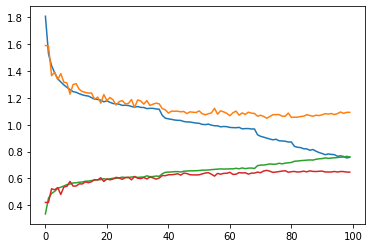

In [11]:
import pickle
pickle.dump(hist, open('featureactv2_baseline_tripletloss_hist.hdf5', 'wb'))

plt.plot(hist), best_acc

In [16]:
model = torch.load('featureactv2_baseline_tripletloss_model.pt')

# EVALUATE
model.eval()
running_valloss = 0.0
running_valacc = 0.0
for i,data in enumerate(test_loader):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs, embeddings = model(inputs)
    indices_tuple = mining_func(embeddings, labels)
    triplet_loss = loss_func(embeddings, labels, indices_tuple)
    loss = criterion(outputs, labels)
    acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

    all_loss = loss + triplet_loss

    running_valloss += (all_loss.item() * inputs.size(0))
    running_valacc += acc.item()

print('- Avg. val_loss: %.3f | Avg. val_acc: %.3f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

- Avg. val_loss: 1.044 | Avg. val_acc: 0.648


## Feature Act v2 with additional output from Feature Act layer

In [5]:
class FeatureAct(nn.Module):
    def __init__(self, src_depth, target_depth, reduce_factor=1):
        super(FeatureAct, self).__init__()
        self.pool = nn.MaxPool2d(kernel_size=(2,2), stride=2)
        
        self.src_conv = nn.Conv2d(src_depth, src_depth // reduce_factor, kernel_size=1, padding=False)
        self.target_conv = nn.Conv2d(target_depth, target_depth // reduce_factor, kernel_size=1, padding=False)
        
    def forward(self, src_x, target_x):
        
        src_features = self.src_conv(src_x)
        src_features = self.pool(src_features)
        
        target_features = self.target_conv(target_x)
        
        cor = nn.Flatten(-2)(src_features[:, None, :, :]).permute(0,2,1,3) * nn.Flatten(-2)(target_features[:, None, :, :])
        cor = cor / torch.norm(cor)
#         print(cor.size())
        
        cor_feature = torch.cat([(src_features * cor[:, :, k].view(-1, src_features.size(-3), src_features.size(-2), src_features.size(-1))).sum(1, keepdim=True) for k in range(cor.size(2))], dim=1)
        
        target_x = target_x * (1 + cor_feature)
        
        return target_x, cor_feature

In [6]:
class BaselineFeatureAct(nn.Module):
    def __init__(self, embeddings=False):
        
        super(BaselineFeatureAct, self).__init__()
        
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=(2,2), stride=2)
        
        self.conv0 = nn.Conv2d(1, 32, kernel_size=(3,3), padding=1, stride=1)
        self.conv0b = nn.Conv2d(32, 32, kernel_size=(3,3), padding=1, stride=1)
        self.bn0 = nn.BatchNorm2d(32)
        self.bn0b = nn.BatchNorm2d(32)
        
        self.conv1 = nn.Conv2d(32, 64, kernel_size=(3,3), padding=1, stride=1)
        self.conv1b = nn.Conv2d(64, 64, kernel_size=(3,3), padding=1, stride=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.bn1b = nn.BatchNorm2d(64)
        
        self.conv2 = nn.Conv2d(64, 128, kernel_size=(3,3), padding=1, stride=1)
        self.conv2b = nn.Conv2d(128, 128, kernel_size=(3,3), padding=1, stride=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn2b = nn.BatchNorm2d(128)
        
        self.conv3 = nn.Conv2d(128, 256, kernel_size=(3,3), padding=1, stride=1)
        self.conv3b = nn.Conv2d(256, 256, kernel_size=(3,3), padding=1, stride=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.bn3b = nn.BatchNorm2d(256)
  
        self.fact0_1 = FeatureAct(32, 64)
        self.fact1_2 = FeatureAct(64, 128)
        self.fact2_3 = FeatureAct(128, 256)
        
        if not embeddings:
            self.classifier = nn.Sequential(nn.Flatten(),
                                            nn.Linear(2304, 256), nn.BatchNorm1d(256), nn.ReLU(inplace=True),
                                            nn.Linear(256, 128), nn.BatchNorm1d(128), nn.ReLU(inplace=True),
                                            nn.Linear(128, 7), nn.BatchNorm1d(7))
        else:
            self.classifier = nn.Sequential(nn.Flatten(),
                                            nn.Linear(2304, 256), nn.BatchNorm1d(256), nn.ReLU(inplace=True),
                                            nn.Linear(256, 128), nn.BatchNorm1d(128))

        self.cf_classifier0 = nn.Sequential(nn.Flatten(), 
                                            nn.Linear(9216, 256), 
                                            nn.BatchNorm1d(256), 
                                            nn.ReLU(inplace=True),
                                            nn.Linear(256, 7), 
                                            nn.BatchNorm1d(7), 
                                            nn.Softmax())
        
        self.cf_classifier1 = nn.Sequential(nn.Flatten(), 
                                            nn.Linear(4608, 256), 
                                            nn.BatchNorm1d(256), 
                                            nn.ReLU(inplace=True),
                                            nn.Linear(256, 7), 
                                            nn.BatchNorm1d(7), 
                                            nn.Softmax())

        self.cf_classifier2 = nn.Sequential(nn.Flatten(), 
                                            nn.Linear(2304, 256), 
                                            nn.BatchNorm1d(256), 
                                            nn.ReLU(inplace=True),
                                            nn.Linear(256, 7), 
                                            nn.BatchNorm1d(7), 
                                            nn.Softmax())

        self.weighted_classifier = nn.Sequential(nn.Linear(7*4, 7), nn.BatchNorm1d(7))
        
    def forward(self, x):
        
        x = self.conv0(x)
        x = self.bn0(x)
        x = self.relu(x)
        x = self.conv0b(x)
        x = self.bn0b(x)
        x = self.relu(x)
        
        x0 = self.maxpool(x)
        
        x = self.conv1(x0)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv1b(x)
        x = self.bn1b(x)
        x = self.relu(x)
        
        x1 = self.maxpool(x)

        xfact0_1, cfeature_0 = self.fact0_1(x0, x1)
        
        x = self.conv2(xfact0_1)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv2b(x)
        x = self.bn2b(x)
        x = self.relu(x)
        
        x2 = self.maxpool(x)

        xfact1_2, cfeature_1 = self.fact1_2(x1, x2)
        
        x = self.conv3(xfact1_2)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.conv3b(x)
        x = self.bn3b(x)
        x = self.relu(x)
        
        x3 = self.maxpool(x)

        xfact2_3, cfeature_2 = self.fact2_3(x2, x3)
        
        x = nn.Flatten()(xfact2_3)
        x = self.classifier(x)

        # print(cfeature_0.size(),cfeature_1.size(), cfeature_2.size() )

        cf_class0 = self.cf_classifier0(cfeature_0)
        cf_class1 = self.cf_classifier1(cfeature_1)
        cf_class2 = self.cf_classifier2(cfeature_2)

        x_out = torch.cat([x, cf_class0, cf_class1, cf_class2], dim=1)
        x_out = self.weighted_classifier(x_out)
        
        return x_out

In [7]:
device = torch.device('cuda')
model = BaselineFeatureAct().to(device)

best_acc = 0.0
hist = []

epochs=100

criterion = nn.CrossEntropyLoss()

learning_rate = 0.004
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=7, verbose=True)


In [8]:
model_path = './featureactv2_baseline_resoutput_model.pt'

for epoch in range(100):  # loop over the dataset multiple times

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0
    processed = 0.0

    # TRAIN
    model.train()
    pbar = tqdm(train_loader, position=0)
    for i, data in enumerate(pbar):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()
        loss.backward()
        
        optimizer.step()

        # print statistics
        running_loss += (loss.item() * inputs.size(0))
        running_acc += acc.item()
        processed += len(inputs)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={i} Accuracy={acc.item() / inputs.size(0)}')

    print('- Avg.loss: %.3f | Avg.acc: %.3f' % (running_loss / len(train_loader.dataset), running_acc / len(train_loader.dataset)))
    avgloss = running_loss / len(train_loader.dataset)
    avgacc = running_acc / len(train_loader.dataset)

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

        running_valloss += (loss.item() * inputs.size(0))
        running_valacc += acc.item()

    print('- Avg. val_loss: %.3f | Avg. val_acc: %.3f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

    avgvalloss = running_valloss / len(val_loader.dataset)
    avgvalacc = running_valacc / len(val_loader.dataset)
    
    scheduler.step(avgvalloss)

    hist.append([avgloss, avgvalloss, avgacc, avgvalacc])
    
    if best_acc < avgvalacc:
        best_acc = avgvalacc
        torch.save(model, model_path)
        print('* Update optimal model')

print('Finished Training')

  0%|          | 0/225 [00:00<?, ?it/s]

Epoch:  1


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
Loss=1.6384503841400146 Batch_id=224 Accuracy=0.35135135135135137: 100%|██████████| 225/225 [07:02<00:00,  1.88s/it]

- Avg.loss: 1.723 | Avg.acc: 0.325



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.569 | Avg. val_acc: 0.396
* Update optimal model
Epoch:  2


Loss=1.3067033290863037 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [07:03<00:00,  1.88s/it]

- Avg.loss: 1.394 | Avg.acc: 0.469



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.354 | Avg. val_acc: 0.485
* Update optimal model
Epoch:  3


Loss=1.2859439849853516 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [07:03<00:00,  1.88s/it]

- Avg.loss: 1.297 | Avg.acc: 0.506



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.250 | Avg. val_acc: 0.522
* Update optimal model
Epoch:  4


Loss=1.3718773126602173 Batch_id=224 Accuracy=0.43243243243243246: 100%|██████████| 225/225 [07:03<00:00,  1.88s/it]

- Avg.loss: 1.245 | Avg.acc: 0.525



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.236 | Avg. val_acc: 0.523
* Update optimal model
Epoch:  5


Loss=1.527754783630371 Batch_id=224 Accuracy=0.40540540540540543: 100%|██████████| 225/225 [07:02<00:00,  1.88s/it]

- Avg.loss: 1.213 | Avg.acc: 0.538



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.172 | Avg. val_acc: 0.555
* Update optimal model
Epoch:  6


Loss=1.1345287561416626 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [07:03<00:00,  1.88s/it]

- Avg.loss: 1.189 | Avg.acc: 0.548



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.217 | Avg. val_acc: 0.538
Epoch:  7


Loss=1.3158023357391357 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [07:02<00:00,  1.88s/it]

- Avg.loss: 1.174 | Avg.acc: 0.554



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.231 | Avg. val_acc: 0.534
Epoch:  8


Loss=1.2244125604629517 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [07:03<00:00,  1.88s/it]

- Avg.loss: 1.154 | Avg.acc: 0.562



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.137 | Avg. val_acc: 0.569
* Update optimal model
Epoch:  9


Loss=0.945440948009491 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [07:03<00:00,  1.88s/it]

- Avg.loss: 1.144 | Avg.acc: 0.565



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.464 | Avg. val_acc: 0.461
Epoch:  10


Loss=1.2339353561401367 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [07:03<00:00,  1.88s/it]

- Avg.loss: 1.134 | Avg.acc: 0.570



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.236 | Avg. val_acc: 0.545
Epoch:  11


Loss=0.9201371669769287 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [07:03<00:00,  1.88s/it]

- Avg.loss: 1.124 | Avg.acc: 0.574



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.179 | Avg. val_acc: 0.561
Epoch:  12


Loss=1.0729902982711792 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [07:03<00:00,  1.88s/it]

- Avg.loss: 1.118 | Avg.acc: 0.574



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.116 | Avg. val_acc: 0.572
* Update optimal model
Epoch:  13


Loss=1.1788232326507568 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [07:03<00:00,  1.88s/it]

- Avg.loss: 1.107 | Avg.acc: 0.580



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.116 | Avg. val_acc: 0.575
* Update optimal model
Epoch:  14


Loss=1.263598918914795 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [07:03<00:00,  1.88s/it]

- Avg.loss: 1.102 | Avg.acc: 0.582



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.164 | Avg. val_acc: 0.558
Epoch:  15


Loss=1.1484559774398804 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [07:03<00:00,  1.88s/it]

- Avg.loss: 1.100 | Avg.acc: 0.583



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.132 | Avg. val_acc: 0.566
Epoch:  16


Loss=1.1099563837051392 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [07:03<00:00,  1.88s/it]

- Avg.loss: 1.088 | Avg.acc: 0.588



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.110 | Avg. val_acc: 0.577
* Update optimal model
Epoch:  17


Loss=1.082592248916626 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [07:02<00:00,  1.88s/it]

- Avg.loss: 1.084 | Avg.acc: 0.588



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.085 | Avg. val_acc: 0.594
* Update optimal model
Epoch:  18


Loss=1.0776201486587524 Batch_id=149 Accuracy=0.546875:  67%|██████▋   | 150/225 [04:43<02:20,  1.88s/it] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Loss=1.3316287994384766 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [07:03<00:00,  1.88s/it]

- Avg.loss: 1.028 | Avg.acc: 0.611



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.116 | Avg. val_acc: 0.596
Epoch:  37


Loss=0.8469196557998657 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [07:03<00:00,  1.88s/it]

- Avg.loss: 1.022 | Avg.acc: 0.615



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.073 | Avg. val_acc: 0.595
Epoch:  38


Loss=1.2658894062042236 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [07:03<00:00,  1.88s/it]

- Avg.loss: 1.023 | Avg.acc: 0.613



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.068 | Avg. val_acc: 0.608
Epoch    38: reducing learning rate of group 0 to 2.0000e-03.
Epoch:  39


Loss=1.17379891872406 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [07:03<00:00,  1.88s/it]

- Avg.loss: 0.970 | Avg.acc: 0.632



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.037 | Avg. val_acc: 0.604
Epoch:  40


Loss=0.7047901749610901 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [07:03<00:00,  1.88s/it]

- Avg.loss: 0.950 | Avg.acc: 0.643



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.996 | Avg. val_acc: 0.631
* Update optimal model
Epoch:  41


Loss=1.1808382272720337 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [07:03<00:00,  1.88s/it]

- Avg.loss: 0.941 | Avg.acc: 0.647



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.002 | Avg. val_acc: 0.620
Epoch:  42


Loss=0.9527086019515991 Batch_id=170 Accuracy=0.609375:  76%|███████▌  | 171/225 [05:23<01:41,  1.88s/it] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Loss=0.7231462001800537 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [07:03<00:00,  1.88s/it]

- Avg.loss: 0.855 | Avg.acc: 0.681



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.971 | Avg. val_acc: 0.640
Epoch:  61


Loss=0.9295619130134583 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [07:03<00:00,  1.88s/it]

- Avg.loss: 0.836 | Avg.acc: 0.688



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.954 | Avg. val_acc: 0.653
* Update optimal model
Epoch:  62


Loss=0.9182616472244263 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [07:03<00:00,  1.88s/it]

- Avg.loss: 0.828 | Avg.acc: 0.690



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.969 | Avg. val_acc: 0.639
Epoch:  63


Loss=0.8963555097579956 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [07:03<00:00,  1.88s/it]

- Avg.loss: 0.825 | Avg.acc: 0.691



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.967 | Avg. val_acc: 0.639
Epoch:  64


Loss=0.937569797039032 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [07:03<00:00,  1.88s/it]

- Avg.loss: 0.817 | Avg.acc: 0.693



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.974 | Avg. val_acc: 0.635
Epoch:  65


Loss=1.170322060585022 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [07:02<00:00,  1.88s/it]

- Avg.loss: 0.818 | Avg.acc: 0.696



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.976 | Avg. val_acc: 0.645
Epoch:  66


Loss=0.7814691662788391 Batch_id=213 Accuracy=0.6953125:  95%|█████████▌| 214/225 [06:43<00:20,  1.87s/it]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Loss=0.7372245192527771 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [07:03<00:00,  1.88s/it]

- Avg.loss: 0.698 | Avg.acc: 0.740



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.989 | Avg. val_acc: 0.647
Epoch:  85


Loss=0.4815298020839691 Batch_id=224 Accuracy=0.8108108108108109: 100%|██████████| 225/225 [07:03<00:00,  1.88s/it]

- Avg.loss: 0.700 | Avg.acc: 0.738



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.986 | Avg. val_acc: 0.648
Epoch    85: reducing learning rate of group 0 to 1.2500e-04.
Epoch:  86


Loss=0.6826040744781494 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [07:03<00:00,  1.88s/it]

- Avg.loss: 0.690 | Avg.acc: 0.743



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.984 | Avg. val_acc: 0.651
Epoch:  87


Loss=0.9200562238693237 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [07:03<00:00,  1.88s/it]

- Avg.loss: 0.684 | Avg.acc: 0.748



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.985 | Avg. val_acc: 0.651
Epoch:  88


Loss=0.6497578024864197 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [07:03<00:00,  1.88s/it]

- Avg.loss: 0.681 | Avg.acc: 0.747



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.984 | Avg. val_acc: 0.653
Epoch:  89


Loss=0.7983705997467041 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [07:03<00:00,  1.88s/it]

- Avg.loss: 0.682 | Avg.acc: 0.750



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.986 | Avg. val_acc: 0.648
Epoch:  90


Loss=0.6322230696678162 Batch_id=177 Accuracy=0.734375:  79%|███████▊  | 177/225 [05:36<01:30,  1.88s/it] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



([<matplotlib.lines.Line2D at 0x7fb19ee5a5f8>,
 0.6609083310114238)

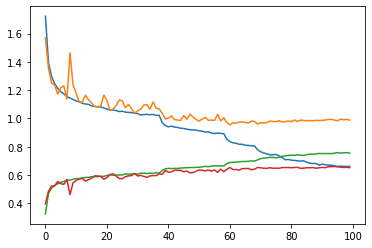

In [10]:
import pickle
pickle.dump(hist, open('featureactv2_baseline_resoutput_hist.hdf5', 'wb'))

plt.plot(hist), best_acc

In [11]:
test_model = torch.load('featureactv2_baseline_resoutput_model.pt')

# EVALUATE
test_model.eval()
running_valloss = 0.0
running_valacc = 0.0
for i,data in enumerate(test_loader):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = test_model(inputs)

    loss = criterion(outputs, labels)
    acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

    running_valloss += (loss.item() * inputs.size(0))
    running_valacc += acc.item()

print('- Avg. val_loss: %.3f | Avg. val_acc: %.3f' % (running_valloss / len(test_loader.dataset), running_valacc / len(test_loader.dataset)))

- Avg. val_loss: 0.946 | Avg. val_acc: 0.662


### Fix x -> x_out

In [9]:
model_path = './featureactv2_baseline_resoutput_model2.pt'

for epoch in range(100):  # loop over the dataset multiple times

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0
    processed = 0.0

    # TRAIN
    model.train()
    pbar = tqdm(train_loader, position=0)
    for i, data in enumerate(pbar):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()
        loss.backward()
        
        optimizer.step()

        # print statistics
        running_loss += (loss.item() * inputs.size(0))
        running_acc += acc.item()
        processed += len(inputs)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={i} Accuracy={acc.item() / inputs.size(0)}')

    print('- Avg.loss: %.3f | Avg.acc: %.3f' % (running_loss / len(train_loader.dataset), running_acc / len(train_loader.dataset)))
    avgloss = running_loss / len(train_loader.dataset)
    avgacc = running_acc / len(train_loader.dataset)

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

        running_valloss += (loss.item() * inputs.size(0))
        running_valacc += acc.item()

    print('- Avg. val_loss: %.3f | Avg. val_acc: %.3f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

    avgvalloss = running_valloss / len(val_loader.dataset)
    avgvalacc = running_valacc / len(val_loader.dataset)
    
    scheduler.step(avgvalloss)

    hist.append([avgloss, avgvalloss, avgacc, avgvalacc])
    
    if best_acc < avgvalacc:
        best_acc = avgvalacc
        torch.save(model, model_path)
        print('* Update optimal model')

print('Finished Training')

  0%|          | 0/225 [00:00<?, ?it/s]

Epoch:  1


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
Loss=1.4967844486236572 Batch_id=224 Accuracy=0.3783783783783784: 100%|██████████| 225/225 [07:04<00:00,  1.89s/it]

- Avg.loss: 1.619 | Avg.acc: 0.383



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.480 | Avg. val_acc: 0.437
* Update optimal model
Epoch:  2


Loss=1.2422062158584595 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [07:03<00:00,  1.88s/it]

- Avg.loss: 1.365 | Avg.acc: 0.480



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.314 | Avg. val_acc: 0.500
* Update optimal model
Epoch:  3


Loss=1.3715580701828003 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [07:04<00:00,  1.89s/it]

- Avg.loss: 1.288 | Avg.acc: 0.508



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.256 | Avg. val_acc: 0.525
* Update optimal model
Epoch:  4


Loss=1.0872331857681274 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [07:04<00:00,  1.89s/it]

- Avg.loss: 1.251 | Avg.acc: 0.524



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.206 | Avg. val_acc: 0.536
* Update optimal model
Epoch:  5


Loss=1.1358485221862793 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [07:04<00:00,  1.88s/it]

- Avg.loss: 1.216 | Avg.acc: 0.538



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.181 | Avg. val_acc: 0.554
* Update optimal model
Epoch:  6


Loss=1.1487400531768799 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [07:04<00:00,  1.89s/it]

- Avg.loss: 1.191 | Avg.acc: 0.546



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.223 | Avg. val_acc: 0.539
Epoch:  7


Loss=1.1778291463851929 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [07:04<00:00,  1.88s/it]

- Avg.loss: 1.174 | Avg.acc: 0.554



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.184 | Avg. val_acc: 0.553
Epoch:  8


Loss=1.055930495262146 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [07:04<00:00,  1.89s/it]

- Avg.loss: 1.160 | Avg.acc: 0.554



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.150 | Avg. val_acc: 0.576
* Update optimal model
Epoch:  9


Loss=1.3134897947311401 Batch_id=224 Accuracy=0.4594594594594595: 100%|██████████| 225/225 [07:04<00:00,  1.89s/it]

- Avg.loss: 1.146 | Avg.acc: 0.566



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.153 | Avg. val_acc: 0.565
Epoch:  10


Loss=1.0832017660140991 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [07:03<00:00,  1.88s/it]

- Avg.loss: 1.136 | Avg.acc: 0.567



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.147 | Avg. val_acc: 0.557
Epoch:  11


Loss=0.9843353629112244 Batch_id=150 Accuracy=0.6015625:  67%|██████▋   | 151/225 [04:46<02:19,  1.88s/it]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Loss=0.952629804611206 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [07:04<00:00,  1.89s/it]

- Avg.loss: 0.973 | Avg.acc: 0.631



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.022 | Avg. val_acc: 0.612
Epoch:  29


Loss=0.9449295997619629 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [07:04<00:00,  1.89s/it]

- Avg.loss: 0.962 | Avg.acc: 0.639



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.005 | Avg. val_acc: 0.613
Epoch:  30


Loss=1.0404645204544067 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [07:04<00:00,  1.89s/it]

- Avg.loss: 0.957 | Avg.acc: 0.640



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.041 | Avg. val_acc: 0.612
Epoch:  31


Loss=0.7977524995803833 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [07:04<00:00,  1.89s/it]

- Avg.loss: 0.953 | Avg.acc: 0.640



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.011 | Avg. val_acc: 0.619
* Update optimal model
Epoch:  32


Loss=0.8319214582443237 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [07:03<00:00,  1.88s/it]

- Avg.loss: 0.951 | Avg.acc: 0.642



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.016 | Avg. val_acc: 0.622
* Update optimal model
Epoch:  33


Loss=0.8546614050865173 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [07:04<00:00,  1.88s/it]

- Avg.loss: 0.938 | Avg.acc: 0.646



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.022 | Avg. val_acc: 0.611
Epoch:  34


Loss=0.9235122203826904 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [07:04<00:00,  1.89s/it]

- Avg.loss: 0.945 | Avg.acc: 0.645



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.018 | Avg. val_acc: 0.610
Epoch:  35


Loss=1.0682405233383179 Batch_id=108 Accuracy=0.6484375:  48%|████▊     | 109/225 [03:26<03:38,  1.88s/it]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Loss=1.0656126737594604 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [07:04<00:00,  1.89s/it]

- Avg.loss: 0.915 | Avg.acc: 0.658



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.021 | Avg. val_acc: 0.613
Epoch:  44


Loss=1.3391841650009155 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [07:04<00:00,  1.88s/it]

- Avg.loss: 0.910 | Avg.acc: 0.656



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.037 | Avg. val_acc: 0.612
Epoch:  45


Loss=0.7157521843910217 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [07:04<00:00,  1.89s/it]

- Avg.loss: 0.910 | Avg.acc: 0.658



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.009 | Avg. val_acc: 0.621
Epoch:  46


Loss=1.2192493677139282 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [07:04<00:00,  1.89s/it]

- Avg.loss: 0.901 | Avg.acc: 0.660



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.002 | Avg. val_acc: 0.623
Epoch:  47


Loss=0.8389747738838196 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [07:04<00:00,  1.89s/it]

- Avg.loss: 0.905 | Avg.acc: 0.661



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.009 | Avg. val_acc: 0.625
Epoch:  48


Loss=0.9358431696891785 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [07:04<00:00,  1.89s/it]

- Avg.loss: 0.898 | Avg.acc: 0.663



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.021 | Avg. val_acc: 0.630
* Update optimal model
Epoch:  49


Loss=1.1640284061431885 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [07:04<00:00,  1.89s/it]

- Avg.loss: 0.899 | Avg.acc: 0.660



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.022 | Avg. val_acc: 0.618
Epoch    49: reducing learning rate of group 0 to 1.0000e-03.
Epoch:  50


Loss=1.0786503553390503 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [07:04<00:00,  1.89s/it]

- Avg.loss: 0.855 | Avg.acc: 0.678



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.990 | Avg. val_acc: 0.628
Epoch:  51


Loss=0.785047709941864 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [07:03<00:00,  1.88s/it]

- Avg.loss: 0.832 | Avg.acc: 0.689



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.979 | Avg. val_acc: 0.646
* Update optimal model
Epoch:  52


Loss=1.0828951597213745 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [07:04<00:00,  1.89s/it]

- Avg.loss: 0.826 | Avg.acc: 0.689



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.010 | Avg. val_acc: 0.630
Epoch:  53


Loss=0.7650790214538574 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [07:04<00:00,  1.89s/it]

- Avg.loss: 0.819 | Avg.acc: 0.696



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.977 | Avg. val_acc: 0.634
Epoch:  54


Loss=0.6655881404876709 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [07:04<00:00,  1.89s/it]

- Avg.loss: 0.817 | Avg.acc: 0.695



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.984 | Avg. val_acc: 0.633
Epoch:  55


Loss=0.637434184551239 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [07:04<00:00,  1.88s/it]

- Avg.loss: 0.803 | Avg.acc: 0.699



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.986 | Avg. val_acc: 0.638
Epoch:  56


Loss=0.8406609892845154 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [07:04<00:00,  1.89s/it]

- Avg.loss: 0.804 | Avg.acc: 0.701



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.996 | Avg. val_acc: 0.635
Epoch:  57


Loss=0.9286243319511414 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [07:04<00:00,  1.89s/it]

- Avg.loss: 0.803 | Avg.acc: 0.701



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.998 | Avg. val_acc: 0.627
Epoch:  58


Loss=0.9853771328926086 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [07:04<00:00,  1.89s/it]

- Avg.loss: 0.795 | Avg.acc: 0.704



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.006 | Avg. val_acc: 0.632
Epoch:  59


Loss=0.9174653887748718 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [07:04<00:00,  1.89s/it]

- Avg.loss: 0.792 | Avg.acc: 0.705



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.004 | Avg. val_acc: 0.635
Epoch:  60


Loss=0.991211473941803 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [07:04<00:00,  1.89s/it]

- Avg.loss: 0.792 | Avg.acc: 0.703



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.002 | Avg. val_acc: 0.636
Epoch:  61


Loss=0.5550478100776672 Batch_id=224 Accuracy=0.8108108108108109: 100%|██████████| 225/225 [07:04<00:00,  1.89s/it]

- Avg.loss: 0.789 | Avg.acc: 0.705



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.986 | Avg. val_acc: 0.648
Epoch    61: reducing learning rate of group 0 to 5.0000e-04.
* Update optimal model
Epoch:  62


Loss=0.7499516010284424 Batch_id=224 Accuracy=0.8108108108108109: 100%|██████████| 225/225 [07:03<00:00,  1.88s/it]

- Avg.loss: 0.751 | Avg.acc: 0.722



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.984 | Avg. val_acc: 0.645
Epoch:  63


Loss=0.49143239855766296 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [07:03<00:00,  1.88s/it]

- Avg.loss: 0.737 | Avg.acc: 0.727



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.985 | Avg. val_acc: 0.648
* Update optimal model
Epoch:  64


Loss=0.9095887541770935 Batch_id=170 Accuracy=0.65625:  76%|███████▌  | 171/225 [05:23<01:41,  1.88s/it]  IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Loss=0.4510851204395294 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [07:04<00:00,  1.89s/it]

- Avg.loss: 0.617 | Avg.acc: 0.773



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.028 | Avg. val_acc: 0.642
Epoch:  83


Loss=0.6606336832046509 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [07:04<00:00,  1.89s/it]

- Avg.loss: 0.617 | Avg.acc: 0.772



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.029 | Avg. val_acc: 0.641
Epoch:  84


Loss=0.5346201062202454 Batch_id=224 Accuracy=0.8108108108108109: 100%|██████████| 225/225 [07:04<00:00,  1.89s/it]

- Avg.loss: 0.613 | Avg.acc: 0.777



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.025 | Avg. val_acc: 0.637
Epoch:  85


Loss=0.5772708058357239 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [07:04<00:00,  1.88s/it]

- Avg.loss: 0.610 | Avg.acc: 0.776



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.031 | Avg. val_acc: 0.640
Epoch    85: reducing learning rate of group 0 to 6.2500e-05.
Epoch:  86


Loss=0.5523011684417725 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [07:04<00:00,  1.89s/it]

- Avg.loss: 0.608 | Avg.acc: 0.780



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.032 | Avg. val_acc: 0.639
Epoch:  87


Loss=0.7604684829711914 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [07:03<00:00,  1.88s/it]

- Avg.loss: 0.597 | Avg.acc: 0.781



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.035 | Avg. val_acc: 0.644
Epoch:  88


Loss=0.899841845035553 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [07:04<00:00,  1.88s/it]

- Avg.loss: 0.597 | Avg.acc: 0.779



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.037 | Avg. val_acc: 0.636
Epoch:  89


Loss=0.5110415816307068 Batch_id=130 Accuracy=0.8046875:  58%|█████▊    | 130/225 [04:08<02:58,  1.88s/it] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [18]:
torch.save(model, 'featureactv2_baseline_resoutput_model2.pt')

([<matplotlib.lines.Line2D at 0x7f9376819978>,
 0.6478127612148231)

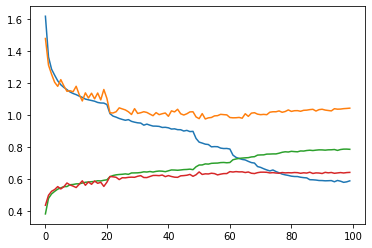

In [14]:
import pickle
pickle.dump(hist, open('featureactv2_baseline_resoutput_model2.hdf5', 'wb'))

plt.plot(hist), best_acc

In [17]:
# model = torch.load('./featureactv2_baseline_resoutput_model2.pt')

# EVALUATE
model.eval()
running_valloss = 0.0
running_valacc = 0.0
for i,data in enumerate(test_loader):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = model(inputs)

    loss = criterion(outputs, labels)
    acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

    running_valloss += (loss.item() * inputs.size(0))
    running_valacc += acc.item()

print('- Avg. val_loss: %.3f | Avg. val_acc: %.3f' % (running_valloss / len(test_loader.dataset), running_valacc / len(test_loader.dataset)))

- Avg. val_loss: 1.015 | Avg. val_acc: 0.660


In [16]:
model

BaselineFeatureAct(
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv0b): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn0b): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1b): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn1b): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2b): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-

## Feature Act v3

In [5]:
class FeatureAct(nn.Module):
    def __init__(self, src_depth, target_depth, reduce_factor=1):
        super(FeatureAct, self).__init__()
        self.pool = nn.MaxPool2d(kernel_size=(2,2), stride=2)
        
        self.src_conv = nn.Conv2d(src_depth, src_depth // reduce_factor, kernel_size=1, padding=False)
        self.target_conv = nn.Conv2d(target_depth, target_depth // reduce_factor, kernel_size=1, padding=False)
        
        self.down_depth = nn.Sequential(nn.Conv2d(src_depth, src_depth // reduce_factor, kernel_size=1, padding=False),
                                        nn.ReLU(inplace=True),
                                        nn.MaxPool2d(kernel_size=(2,2), stride=2))
        self.up_depth = nn.Conv2d(target_depth // reduce_factor, target_depth, kernel_size=1, padding=False)
        
    def forward(self, src_x, target_x):
        
        src_features = self.src_conv(src_x)
        src_features = self.pool(src_features)
        
        target_features = self.target_conv(target_x)
        
        cor = nn.Flatten(-2)(src_features[:, None, :, :]).permute(0,2,1,3) * nn.Flatten(-2)(target_features[:, None, :, :])
        cor = cor / torch.norm(cor)
#         print(cor.size())

        main_features = self.down_depth(src_x)
    
        cor_feature = torch.cat([(main_features * cor[:, :, k].view(-1, src_features.size(-3), src_features.size(-2), src_features.size(-1))).sum(1, keepdim=True) for k in range(cor.size(2))], dim=1)
        cor_feature = self.up_depth(cor_feature)
        
        target_x = target_x * (1 + cor_feature)
        
        return target_x, cor_feature

In [6]:
class BaselineFeatureAct(nn.Module):
    def __init__(self, embeddings=False):
        
        super(BaselineFeatureAct, self).__init__()
        
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=(2,2), stride=2)
        
        self.conv0 = nn.Conv2d(1, 32, kernel_size=(3,3), padding=1, stride=1)
        self.conv0b = nn.Conv2d(32, 32, kernel_size=(3,3), padding=1, stride=1)
        self.bn0 = nn.BatchNorm2d(32)
        self.bn0b = nn.BatchNorm2d(32)
        
        self.conv1 = nn.Conv2d(32, 64, kernel_size=(3,3), padding=1, stride=1)
        self.conv1b = nn.Conv2d(64, 64, kernel_size=(3,3), padding=1, stride=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.bn1b = nn.BatchNorm2d(64)
        
        self.conv2 = nn.Conv2d(64, 128, kernel_size=(3,3), padding=1, stride=1)
        self.conv2b = nn.Conv2d(128, 128, kernel_size=(3,3), padding=1, stride=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn2b = nn.BatchNorm2d(128)
        
        self.conv3 = nn.Conv2d(128, 256, kernel_size=(3,3), padding=1, stride=1)
        self.conv3b = nn.Conv2d(256, 256, kernel_size=(3,3), padding=1, stride=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.bn3b = nn.BatchNorm2d(256)
  
        self.fact0_1 = FeatureAct(32, 64, 4)
        self.fact1_2 = FeatureAct(64, 128, 4)
        self.fact2_3 = FeatureAct(128, 256, 4)
        
        if not embeddings:
            self.classifier = nn.Sequential(nn.Flatten(),
                                            nn.Linear(2304, 256), nn.BatchNorm1d(256), nn.ReLU(inplace=True),
                                            nn.Linear(256, 128), nn.BatchNorm1d(128), nn.ReLU(inplace=True),
                                            nn.Linear(128, 7), nn.BatchNorm1d(7))
        else:
            self.classifier = nn.Sequential(nn.Flatten(),
                                            nn.Linear(2304, 256), nn.BatchNorm1d(256), nn.ReLU(inplace=True),
                                            nn.Linear(256, 128), nn.BatchNorm1d(128))

        self.cf_classifier0 = nn.Sequential(nn.Flatten(), 
                                            nn.Linear(9216, 256), 
                                            nn.BatchNorm1d(256), 
                                            nn.ReLU(inplace=True),
                                            nn.Linear(256, 7), 
                                            nn.BatchNorm1d(7), 
                                            nn.Softmax())
        
        self.cf_classifier1 = nn.Sequential(nn.Flatten(), 
                                            nn.Linear(4608, 256), 
                                            nn.BatchNorm1d(256), 
                                            nn.ReLU(inplace=True),
                                            nn.Linear(256, 7), 
                                            nn.BatchNorm1d(7), 
                                            nn.Softmax())

        self.cf_classifier2 = nn.Sequential(nn.Flatten(), 
                                            nn.Linear(2304, 256), 
                                            nn.BatchNorm1d(256), 
                                            nn.ReLU(inplace=True),
                                            nn.Linear(256, 7), 
                                            nn.BatchNorm1d(7), 
                                            nn.Softmax())

        self.weighted_classifier = nn.Sequential(nn.Linear(7*4, 7), nn.BatchNorm1d(7))
        
    def forward(self, x):
        
        x = self.conv0(x)
        x = self.bn0(x)
        x = self.relu(x)
        x = self.conv0b(x)
        x = self.bn0b(x)
        x = self.relu(x)
        
        x0 = self.maxpool(x)
        
        x = self.conv1(x0)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv1b(x)
        x = self.bn1b(x)
        x = self.relu(x)
        
        x1 = self.maxpool(x)

        xfact0_1, cfeature_0 = self.fact0_1(x0, x1)
        
        x = self.conv2(xfact0_1)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv2b(x)
        x = self.bn2b(x)
        x = self.relu(x)
        
        x2 = self.maxpool(x)

        xfact1_2, cfeature_1 = self.fact1_2(x1, x2)
        
        x = self.conv3(xfact1_2)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.conv3b(x)
        x = self.bn3b(x)
        x = self.relu(x)
        
        x3 = self.maxpool(x)

        xfact2_3, cfeature_2 = self.fact2_3(x2, x3)
        
        x = nn.Flatten()(xfact2_3)
        x = self.classifier(x)

        # print(cfeature_0.size(),cfeature_1.size(), cfeature_2.size() )

        cf_class0 = self.cf_classifier0(cfeature_0)
        cf_class1 = self.cf_classifier1(cfeature_1)
        cf_class2 = self.cf_classifier2(cfeature_2)

        x_out = torch.cat([x, cf_class0, cf_class1, cf_class2], dim=1)
        x_out = self.weighted_classifier(x_out)
        
        return x_out

In [7]:
device = torch.device('cuda')
model = BaselineFeatureAct().to(device)

best_acc = 0.0
hist = []

epochs=100

criterion = nn.CrossEntropyLoss()

learning_rate = 0.004
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=7, verbose=True)


In [8]:
model_path = './featureactv3_baseline_resoutput_model.pt'

for epoch in range(100):  # loop over the dataset multiple times

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0
    processed = 0.0

    # TRAIN
    model.train()
    pbar = tqdm(train_loader, position=0)
    for i, data in enumerate(pbar):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()
        loss.backward()
        
        optimizer.step()

        # print statistics
        running_loss += (loss.item() * inputs.size(0))
        running_acc += acc.item()
        processed += len(inputs)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={i} Accuracy={acc.item() / inputs.size(0)}')

    print('- Avg.loss: %.3f | Avg.acc: %.3f' % (running_loss / len(train_loader.dataset), running_acc / len(train_loader.dataset)))
    avgloss = running_loss / len(train_loader.dataset)
    avgacc = running_acc / len(train_loader.dataset)

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

        running_valloss += (loss.item() * inputs.size(0))
        running_valacc += acc.item()

    print('- Avg. val_loss: %.3f | Avg. val_acc: %.3f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

    avgvalloss = running_valloss / len(val_loader.dataset)
    avgvalacc = running_valacc / len(val_loader.dataset)
    
    scheduler.step(avgvalloss)

    hist.append([avgloss, avgvalloss, avgacc, avgvalacc])
    
    if best_acc < avgvalacc:
        best_acc = avgvalacc
        torch.save(model, model_path)
        print('* Update optimal model')

print('Finished Training')

  0%|          | 0/225 [00:00<?, ?it/s]

Epoch:  1


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
Loss=1.688942313194275 Batch_id=224 Accuracy=0.3783783783783784: 100%|██████████| 225/225 [00:29<00:00,  7.64it/s]

- Avg.loss: 1.619 | Avg.acc: 0.380



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.623 | Avg. val_acc: 0.399
* Update optimal model
Epoch:  2


Loss=1.5035874843597412 Batch_id=224 Accuracy=0.40540540540540543: 100%|██████████| 225/225 [00:29<00:00,  7.58it/s]

- Avg.loss: 1.367 | Avg.acc: 0.476



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.374 | Avg. val_acc: 0.478
* Update optimal model
Epoch:  3


Loss=1.402016282081604 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:29<00:00,  7.55it/s]

- Avg.loss: 1.285 | Avg.acc: 0.510



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.328 | Avg. val_acc: 0.471
Epoch:  4


Loss=1.3325899839401245 Batch_id=224 Accuracy=0.4594594594594595: 100%|██████████| 225/225 [00:29<00:00,  7.51it/s]

- Avg.loss: 1.241 | Avg.acc: 0.527



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.238 | Avg. val_acc: 0.532
* Update optimal model
Epoch:  5


Loss=1.3460023403167725 Batch_id=224 Accuracy=0.4594594594594595: 100%|██████████| 225/225 [00:29<00:00,  7.55it/s]

- Avg.loss: 1.211 | Avg.acc: 0.540



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.186 | Avg. val_acc: 0.546
* Update optimal model
Epoch:  6


Loss=1.2228877544403076 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [00:29<00:00,  7.63it/s]

- Avg.loss: 1.186 | Avg.acc: 0.546



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.222 | Avg. val_acc: 0.537
Epoch:  7


Loss=1.1644903421401978 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [00:29<00:00,  7.52it/s]

- Avg.loss: 1.163 | Avg.acc: 0.556



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.166 | Avg. val_acc: 0.561
* Update optimal model
Epoch:  8


Loss=1.0646504163742065 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:29<00:00,  7.54it/s]

- Avg.loss: 1.153 | Avg.acc: 0.559



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.306 | Avg. val_acc: 0.509
Epoch:  9


Loss=1.3670780658721924 Batch_id=224 Accuracy=0.4594594594594595: 100%|██████████| 225/225 [00:29<00:00,  7.58it/s]

- Avg.loss: 1.137 | Avg.acc: 0.565



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.200 | Avg. val_acc: 0.544
Epoch:  10


Loss=0.9050425887107849 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:29<00:00,  7.58it/s]

- Avg.loss: 1.124 | Avg.acc: 0.569



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.131 | Avg. val_acc: 0.559
Epoch:  11


Loss=1.4731788635253906 Batch_id=224 Accuracy=0.4594594594594595: 100%|██████████| 225/225 [00:29<00:00,  7.57it/s]

- Avg.loss: 1.118 | Avg.acc: 0.576



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.149 | Avg. val_acc: 0.556
Epoch:  12


Loss=1.4286713600158691 Batch_id=224 Accuracy=0.3783783783783784: 100%|██████████| 225/225 [00:29<00:00,  7.55it/s]

- Avg.loss: 1.116 | Avg.acc: 0.577



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.139 | Avg. val_acc: 0.567
* Update optimal model
Epoch:  13


Loss=1.0285369157791138 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:29<00:00,  7.55it/s]

- Avg.loss: 1.112 | Avg.acc: 0.579



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.124 | Avg. val_acc: 0.578
* Update optimal model
Epoch:  14


Loss=1.1029421091079712 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:29<00:00,  7.59it/s]

- Avg.loss: 1.099 | Avg.acc: 0.585



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.162 | Avg. val_acc: 0.551
Epoch:  15


Loss=1.072210669517517 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:29<00:00,  7.54it/s]

- Avg.loss: 1.092 | Avg.acc: 0.587



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.150 | Avg. val_acc: 0.576
Epoch:  16


Loss=1.0982657670974731 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:29<00:00,  7.61it/s]

- Avg.loss: 1.091 | Avg.acc: 0.582



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.121 | Avg. val_acc: 0.575
Epoch:  17


Loss=1.2564114332199097 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [00:29<00:00,  7.58it/s]

- Avg.loss: 1.085 | Avg.acc: 0.586



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.116 | Avg. val_acc: 0.566
Epoch:  18


Loss=1.363206386566162 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:29<00:00,  7.53it/s]

- Avg.loss: 1.082 | Avg.acc: 0.589



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.195 | Avg. val_acc: 0.524
Epoch:  19


Loss=0.8835997581481934 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:29<00:00,  7.60it/s]

- Avg.loss: 1.075 | Avg.acc: 0.593



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.235 | Avg. val_acc: 0.489
Epoch:  20


Loss=1.217602252960205 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:29<00:00,  7.58it/s]

- Avg.loss: 1.069 | Avg.acc: 0.594



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.081 | Avg. val_acc: 0.584
* Update optimal model
Epoch:  21


Loss=1.2541637420654297 Batch_id=224 Accuracy=0.43243243243243246: 100%|██████████| 225/225 [00:29<00:00,  7.58it/s]

- Avg.loss: 1.071 | Avg.acc: 0.595



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.355 | Avg. val_acc: 0.507
Epoch:  22


Loss=0.9210062623023987 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:29<00:00,  7.54it/s]

- Avg.loss: 1.061 | Avg.acc: 0.600



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.266 | Avg. val_acc: 0.489
Epoch:  23


Loss=1.1894627809524536 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:29<00:00,  7.60it/s]

- Avg.loss: 1.064 | Avg.acc: 0.597



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.094 | Avg. val_acc: 0.580
Epoch:  24


Loss=1.3413742780685425 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [00:29<00:00,  7.55it/s]

- Avg.loss: 1.055 | Avg.acc: 0.599



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.168 | Avg. val_acc: 0.560
Epoch:  25


Loss=0.9223634600639343 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:29<00:00,  7.56it/s]

- Avg.loss: 1.059 | Avg.acc: 0.598



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.159 | Avg. val_acc: 0.578
Epoch:  26


Loss=0.9243382811546326 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:29<00:00,  7.52it/s]

- Avg.loss: 1.049 | Avg.acc: 0.602



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.182 | Avg. val_acc: 0.546
Epoch:  27


Loss=1.0829883813858032 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [00:29<00:00,  7.58it/s]

- Avg.loss: 1.046 | Avg.acc: 0.606



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.074 | Avg. val_acc: 0.596
* Update optimal model
Epoch:  28


Loss=1.006293535232544 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:29<00:00,  7.58it/s]

- Avg.loss: 1.049 | Avg.acc: 0.603



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.055 | Avg. val_acc: 0.589
Epoch:  29


Loss=1.1653423309326172 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:29<00:00,  7.60it/s]

- Avg.loss: 1.044 | Avg.acc: 0.603



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.149 | Avg. val_acc: 0.555
Epoch:  30


Loss=1.1764992475509644 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:29<00:00,  7.55it/s]

- Avg.loss: 1.041 | Avg.acc: 0.606



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.087 | Avg. val_acc: 0.593
Epoch:  31


Loss=1.0088809728622437 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:29<00:00,  7.57it/s]

- Avg.loss: 1.033 | Avg.acc: 0.609



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.149 | Avg. val_acc: 0.581
Epoch:  32


Loss=0.9279566407203674 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:29<00:00,  7.56it/s]

- Avg.loss: 1.036 | Avg.acc: 0.609



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.102 | Avg. val_acc: 0.592
Epoch:  33


Loss=1.1793586015701294 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:29<00:00,  7.51it/s]

- Avg.loss: 1.036 | Avg.acc: 0.608



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.066 | Avg. val_acc: 0.600
* Update optimal model
Epoch:  34


Loss=1.407791018486023 Batch_id=224 Accuracy=0.4594594594594595: 100%|██████████| 225/225 [00:29<00:00,  7.56it/s]

- Avg.loss: 1.027 | Avg.acc: 0.611



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.100 | Avg. val_acc: 0.585
Epoch:  35


Loss=0.8519275784492493 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:29<00:00,  7.54it/s]

- Avg.loss: 1.028 | Avg.acc: 0.611



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.134 | Avg. val_acc: 0.578
Epoch:  36


Loss=0.9558615684509277 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:29<00:00,  7.57it/s]

- Avg.loss: 1.028 | Avg.acc: 0.611



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.157 | Avg. val_acc: 0.552
Epoch    36: reducing learning rate of group 0 to 2.0000e-03.
Epoch:  37


Loss=1.2575047016143799 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [00:29<00:00,  7.57it/s]

- Avg.loss: 0.972 | Avg.acc: 0.636



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.017 | Avg. val_acc: 0.617
* Update optimal model
Epoch:  38


Loss=1.27054762840271 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:29<00:00,  7.58it/s]

- Avg.loss: 0.959 | Avg.acc: 0.639



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.019 | Avg. val_acc: 0.619
* Update optimal model
Epoch:  39


Loss=1.101081132888794 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:29<00:00,  7.52it/s]

- Avg.loss: 0.957 | Avg.acc: 0.637



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.014 | Avg. val_acc: 0.619
Epoch:  40


Loss=1.0931164026260376 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:29<00:00,  7.55it/s]

- Avg.loss: 0.951 | Avg.acc: 0.640



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.037 | Avg. val_acc: 0.611
Epoch:  41


Loss=1.1438666582107544 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:29<00:00,  7.54it/s]

- Avg.loss: 0.944 | Avg.acc: 0.646



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.071 | Avg. val_acc: 0.596
Epoch:  42


Loss=1.0323374271392822 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:29<00:00,  7.57it/s]

- Avg.loss: 0.940 | Avg.acc: 0.643



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.061 | Avg. val_acc: 0.596
Epoch:  43


Loss=1.1154929399490356 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [00:29<00:00,  7.55it/s]

- Avg.loss: 0.945 | Avg.acc: 0.643



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.146 | Avg. val_acc: 0.572
Epoch:  44


Loss=1.0676953792572021 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:29<00:00,  7.54it/s]

- Avg.loss: 0.935 | Avg.acc: 0.649



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.054 | Avg. val_acc: 0.608
Epoch:  45


Loss=1.3674638271331787 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [00:29<00:00,  7.57it/s]

- Avg.loss: 0.931 | Avg.acc: 0.650



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.111 | Avg. val_acc: 0.559
Epoch:  46


Loss=0.7414763569831848 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:29<00:00,  7.60it/s]

- Avg.loss: 0.929 | Avg.acc: 0.650



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.095 | Avg. val_acc: 0.600
Epoch:  47


Loss=0.9683669805526733 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:29<00:00,  7.54it/s]

- Avg.loss: 0.924 | Avg.acc: 0.652



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.042 | Avg. val_acc: 0.616
Epoch    47: reducing learning rate of group 0 to 1.0000e-03.
Epoch:  48


Loss=0.9063317775726318 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:29<00:00,  7.59it/s]

- Avg.loss: 0.885 | Avg.acc: 0.671



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.005 | Avg. val_acc: 0.634
* Update optimal model
Epoch:  49


Loss=1.0489071607589722 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:29<00:00,  7.55it/s]

- Avg.loss: 0.870 | Avg.acc: 0.673



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.987 | Avg. val_acc: 0.626
Epoch:  50


Loss=0.6050929427146912 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [00:29<00:00,  7.57it/s]

- Avg.loss: 0.859 | Avg.acc: 0.678



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.977 | Avg. val_acc: 0.639
* Update optimal model
Epoch:  51


Loss=0.7990139126777649 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:29<00:00,  7.56it/s]

- Avg.loss: 0.859 | Avg.acc: 0.680



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.990 | Avg. val_acc: 0.638
Epoch:  52


Loss=0.6984362602233887 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [00:29<00:00,  7.53it/s]

- Avg.loss: 0.853 | Avg.acc: 0.679



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.977 | Avg. val_acc: 0.640
* Update optimal model
Epoch:  53


Loss=0.8509007692337036 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:29<00:00,  7.56it/s]

- Avg.loss: 0.845 | Avg.acc: 0.684



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.014 | Avg. val_acc: 0.628
Epoch:  54


Loss=0.7221101522445679 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:29<00:00,  7.59it/s]

- Avg.loss: 0.846 | Avg.acc: 0.683



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.994 | Avg. val_acc: 0.629
Epoch:  55


Loss=1.3303676843643188 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [00:29<00:00,  7.52it/s]

- Avg.loss: 0.837 | Avg.acc: 0.684



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.008 | Avg. val_acc: 0.626
Epoch:  56


Loss=0.8756064176559448 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:29<00:00,  7.56it/s]

- Avg.loss: 0.837 | Avg.acc: 0.688



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.011 | Avg. val_acc: 0.626
Epoch:  57


Loss=0.9099032282829285 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:29<00:00,  7.61it/s]

- Avg.loss: 0.824 | Avg.acc: 0.692



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.095 | Avg. val_acc: 0.588
Epoch:  58


Loss=0.8974873423576355 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:29<00:00,  7.50it/s]

- Avg.loss: 0.825 | Avg.acc: 0.693



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.049 | Avg. val_acc: 0.631
Epoch    58: reducing learning rate of group 0 to 5.0000e-04.
Epoch:  59


Loss=0.6247920393943787 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [00:29<00:00,  7.59it/s]

- Avg.loss: 0.803 | Avg.acc: 0.701



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.969 | Avg. val_acc: 0.648
* Update optimal model
Epoch:  60


Loss=0.789046049118042 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:30<00:00,  7.50it/s]

- Avg.loss: 0.790 | Avg.acc: 0.707



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.963 | Avg. val_acc: 0.650
* Update optimal model
Epoch:  61


Loss=0.7560195326805115 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:29<00:00,  7.60it/s]

- Avg.loss: 0.787 | Avg.acc: 0.708



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.984 | Avg. val_acc: 0.647
Epoch:  62


Loss=0.6584436893463135 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [00:29<00:00,  7.57it/s]

- Avg.loss: 0.776 | Avg.acc: 0.710



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.967 | Avg. val_acc: 0.651
* Update optimal model
Epoch:  63


Loss=0.799182653427124 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:29<00:00,  7.55it/s]

- Avg.loss: 0.770 | Avg.acc: 0.712



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.974 | Avg. val_acc: 0.648
Epoch:  64


Loss=0.7048015594482422 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:30<00:00,  7.47it/s]

- Avg.loss: 0.766 | Avg.acc: 0.714



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.966 | Avg. val_acc: 0.654
* Update optimal model
Epoch:  65


Loss=0.9031733870506287 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:29<00:00,  7.52it/s]

- Avg.loss: 0.763 | Avg.acc: 0.719



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.985 | Avg. val_acc: 0.654
* Update optimal model
Epoch:  66


Loss=1.1115084886550903 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:29<00:00,  7.50it/s]

- Avg.loss: 0.760 | Avg.acc: 0.716



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.972 | Avg. val_acc: 0.651
Epoch:  67


Loss=1.035451054573059 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:30<00:00,  7.49it/s]

- Avg.loss: 0.761 | Avg.acc: 0.718



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.005 | Avg. val_acc: 0.644
Epoch:  68


Loss=0.7195940017700195 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:30<00:00,  7.46it/s]

- Avg.loss: 0.750 | Avg.acc: 0.720



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.036 | Avg. val_acc: 0.631
Epoch    68: reducing learning rate of group 0 to 2.5000e-04.
Epoch:  69


Loss=0.6510583162307739 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:29<00:00,  7.57it/s]

- Avg.loss: 0.738 | Avg.acc: 0.726



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.973 | Avg. val_acc: 0.652
Epoch:  70


Loss=0.7638890743255615 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:29<00:00,  7.54it/s]

- Avg.loss: 0.730 | Avg.acc: 0.732



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.989 | Avg. val_acc: 0.649
Epoch:  71


Loss=0.751728355884552 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:29<00:00,  7.55it/s]

- Avg.loss: 0.726 | Avg.acc: 0.728



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.971 | Avg. val_acc: 0.654
Epoch:  72


Loss=0.8229700326919556 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:29<00:00,  7.55it/s]

- Avg.loss: 0.718 | Avg.acc: 0.736



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.980 | Avg. val_acc: 0.652
Epoch:  73


Loss=0.8675912618637085 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:29<00:00,  7.61it/s]

- Avg.loss: 0.720 | Avg.acc: 0.734



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.985 | Avg. val_acc: 0.648
Epoch:  74


Loss=0.8699624538421631 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:29<00:00,  7.57it/s]

- Avg.loss: 0.715 | Avg.acc: 0.736



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.987 | Avg. val_acc: 0.656
* Update optimal model
Epoch:  75


Loss=0.6287806630134583 Batch_id=224 Accuracy=0.8108108108108109: 100%|██████████| 225/225 [00:29<00:00,  7.59it/s]

- Avg.loss: 0.713 | Avg.acc: 0.734



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.991 | Avg. val_acc: 0.646
Epoch:  76


Loss=1.0450327396392822 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:29<00:00,  7.57it/s]

- Avg.loss: 0.705 | Avg.acc: 0.739



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.012 | Avg. val_acc: 0.641
Epoch    76: reducing learning rate of group 0 to 1.2500e-04.
Epoch:  77


Loss=0.8067600131034851 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:29<00:00,  7.58it/s]

- Avg.loss: 0.699 | Avg.acc: 0.741



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.989 | Avg. val_acc: 0.649
Epoch:  78


Loss=0.5312473177909851 Batch_id=224 Accuracy=0.8378378378378378: 100%|██████████| 225/225 [00:29<00:00,  7.59it/s]

- Avg.loss: 0.696 | Avg.acc: 0.741



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.983 | Avg. val_acc: 0.649
Epoch:  79


Loss=0.7904268503189087 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:29<00:00,  7.52it/s]

- Avg.loss: 0.694 | Avg.acc: 0.743



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.985 | Avg. val_acc: 0.650
Epoch:  80


Loss=0.7662578225135803 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:29<00:00,  7.56it/s]

- Avg.loss: 0.692 | Avg.acc: 0.743



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.983 | Avg. val_acc: 0.652
Epoch:  81


Loss=0.8622732758522034 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:29<00:00,  7.53it/s]

- Avg.loss: 0.688 | Avg.acc: 0.744



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.994 | Avg. val_acc: 0.652
Epoch:  82


Loss=0.6371172666549683 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:29<00:00,  7.53it/s]

- Avg.loss: 0.682 | Avg.acc: 0.749



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.994 | Avg. val_acc: 0.646
Epoch:  83


Loss=0.8122668862342834 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:29<00:00,  7.51it/s]

- Avg.loss: 0.680 | Avg.acc: 0.751



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.986 | Avg. val_acc: 0.648
Epoch:  84


Loss=1.224233865737915 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:29<00:00,  7.58it/s]

- Avg.loss: 0.689 | Avg.acc: 0.746



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.009 | Avg. val_acc: 0.649
Epoch    84: reducing learning rate of group 0 to 6.2500e-05.
Epoch:  85


Loss=0.6323122978210449 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [00:29<00:00,  7.61it/s]

- Avg.loss: 0.679 | Avg.acc: 0.748



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.993 | Avg. val_acc: 0.649
Epoch:  86


Loss=1.0472753047943115 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:29<00:00,  7.56it/s]

- Avg.loss: 0.679 | Avg.acc: 0.749



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.992 | Avg. val_acc: 0.650
Epoch:  87


Loss=0.6560974717140198 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:29<00:00,  7.53it/s]

- Avg.loss: 0.669 | Avg.acc: 0.755



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.989 | Avg. val_acc: 0.651
Epoch:  88


Loss=0.5976765751838684 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:29<00:00,  7.57it/s]

- Avg.loss: 0.671 | Avg.acc: 0.754



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.003 | Avg. val_acc: 0.652
Epoch:  89


Loss=0.7791813015937805 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:29<00:00,  7.56it/s]

- Avg.loss: 0.674 | Avg.acc: 0.751



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.994 | Avg. val_acc: 0.651
Epoch:  90


Loss=0.660851776599884 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:29<00:00,  7.61it/s]

- Avg.loss: 0.674 | Avg.acc: 0.751



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.996 | Avg. val_acc: 0.649
Epoch:  91


Loss=0.8155322074890137 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:29<00:00,  7.52it/s]

- Avg.loss: 0.670 | Avg.acc: 0.754



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.004 | Avg. val_acc: 0.648
Epoch:  92


Loss=0.8631623983383179 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:29<00:00,  7.61it/s]

- Avg.loss: 0.672 | Avg.acc: 0.754



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.992 | Avg. val_acc: 0.650
Epoch    92: reducing learning rate of group 0 to 3.1250e-05.
Epoch:  93


Loss=0.6215696334838867 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:29<00:00,  7.54it/s]

- Avg.loss: 0.671 | Avg.acc: 0.754



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.995 | Avg. val_acc: 0.649
Epoch:  94


Loss=0.7758255004882812 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:29<00:00,  7.51it/s]

- Avg.loss: 0.664 | Avg.acc: 0.755



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.998 | Avg. val_acc: 0.649
Epoch:  95


Loss=0.9137109518051147 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:29<00:00,  7.63it/s]

- Avg.loss: 0.669 | Avg.acc: 0.756



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.994 | Avg. val_acc: 0.649
Epoch:  96


Loss=0.6921000480651855 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:29<00:00,  7.53it/s]

- Avg.loss: 0.661 | Avg.acc: 0.759



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.989 | Avg. val_acc: 0.651
Epoch:  97


Loss=0.7596561908721924 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:29<00:00,  7.57it/s]

- Avg.loss: 0.660 | Avg.acc: 0.758



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.997 | Avg. val_acc: 0.654
Epoch:  98


Loss=0.7775456309318542 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:29<00:00,  7.53it/s]

- Avg.loss: 0.663 | Avg.acc: 0.754



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.005 | Avg. val_acc: 0.653
Epoch:  99


Loss=1.0147936344146729 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:29<00:00,  7.54it/s]

- Avg.loss: 0.664 | Avg.acc: 0.757



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.994 | Avg. val_acc: 0.654
Epoch:  100


Loss=0.7689181566238403 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:29<00:00,  7.55it/s]

- Avg.loss: 0.667 | Avg.acc: 0.754


- Avg. val_loss: 1.000 | Avg. val_acc: 0.651
Epoch   100: reducing learning rate of group 0 to 1.5625e-05.
Finished Training


([<matplotlib.lines.Line2D at 0x7f2b68abcc88>,
 0.6564502646976874)

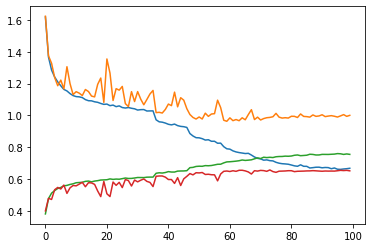

In [10]:
import pickle
pickle.dump(hist, open('featureactv3_baseline_resoutput_hist.hdf5', 'wb'))

plt.plot(hist), best_acc

In [11]:
model = torch.load('featureactv3_baseline_resoutput_model.pt')

# EVALUATE
model.eval()
running_valloss = 0.0
running_valacc = 0.0
for i,data in enumerate(test_loader):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = model(inputs)

    loss = criterion(outputs, labels)
    acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

    running_valloss += (loss.item() * inputs.size(0))
    running_valacc += acc.item()

print('- Avg. val_loss: %.3f | Avg. val_acc: %.3f' % (running_valloss / len(test_loader.dataset), running_valacc / len(test_loader.dataset)))

- Avg. val_loss: 0.968 | Avg. val_acc: 0.651


## Feature Act v3 with dense correlation

In [5]:
class FeatureAct(nn.Module):
    def __init__(self, src_depth, target_depth, reduce_factor=1, n_down=2):
        super(FeatureAct, self).__init__()
        
        self.pool = nn.MaxPool2d(kernel_size=(n_down,n_down), stride=n_down)
        self.relu = nn.ReLU(inplace=True)
        
        self.src_conv = nn.Conv2d(src_depth, src_depth // reduce_factor, kernel_size=1, padding=False)
        self.target_conv = nn.Conv2d(target_depth, target_depth // reduce_factor, kernel_size=1, padding=False)
        
        self.down_depth = nn.Sequential(nn.Conv2d(src_depth, src_depth // reduce_factor, kernel_size=1, padding=False),
                                        nn.ReLU(inplace=True),
                                        nn.MaxPool2d(kernel_size=(n_down,n_down), stride=n_down))
        self.up_depth = nn.Conv2d(target_depth // reduce_factor, target_depth, kernel_size=1, padding=False)
        
    def forward(self, src_x, target_x):
        
        src_features = self.src_conv(src_x)
        src_features = self.pool(src_features)
        
        target_features = self.target_conv(target_x)
        
        cor = nn.Flatten(-2)(src_features[:, None, :, :]).permute(0,2,1,3) * nn.Flatten(-2)(target_features[:, None, :, :])
#         cor = cor / torch.norm(cor)
#         print(cor.size())

        main_features = self.down_depth(src_x)
    
        cor_feature = torch.cat([(main_features * cor[:, :, k].view(-1, src_features.size(-3), src_features.size(-2), src_features.size(-1))).sum(1, keepdim=True) for k in range(cor.size(2))], dim=1)
        cor_feature = self.up_depth(cor_feature)
        
        target_x = target_x * (1 + cor_feature)
        target_x = self.relu(target_x)
        
        return target_x

In [6]:
class BaselineFeatureAct(nn.Module):
    def __init__(self, embeddings=False):
        
        super(BaselineFeatureAct, self).__init__()
        
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=(2,2), stride=2)
        
        self.conv0 = nn.Conv2d(1, 32, kernel_size=(3,3), padding=1, stride=1)
        self.conv0b = nn.Conv2d(32, 32, kernel_size=(3,3), padding=1, stride=1)
        self.bn0 = nn.BatchNorm2d(32)
        self.bn0b = nn.BatchNorm2d(32)
        
        self.conv1 = nn.Conv2d(32, 64, kernel_size=(3,3), padding=1, stride=1)
        self.conv1b = nn.Conv2d(64, 64, kernel_size=(3,3), padding=1, stride=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.bn1b = nn.BatchNorm2d(64)
        
        self.conv2 = nn.Conv2d(64, 128, kernel_size=(3,3), padding=1, stride=1)
        self.conv2b = nn.Conv2d(128, 128, kernel_size=(3,3), padding=1, stride=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn2b = nn.BatchNorm2d(128)
        
        self.conv3 = nn.Conv2d(128, 256, kernel_size=(3,3), padding=1, stride=1)
        self.conv3b = nn.Conv2d(256, 256, kernel_size=(3,3), padding=1, stride=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.bn3b = nn.BatchNorm2d(256)
  
        self.fact0_1 = FeatureAct(32, 64, 4, 2)
        self.fact0_2 = FeatureAct(32, 128, 4, 4)
        self.fact0_3 = FeatureAct(32, 256, 4, 8)
        
        self.fact1_2 = FeatureAct(64, 128, 4, 2)
        self.fact1_3 = FeatureAct(64, 256, 4, 4)
        
        self.fact2_3 = FeatureAct(128, 256, 4, 2)
        
        if not embeddings:
            self.classifier = nn.Sequential(nn.Flatten(),
                                            nn.Linear(2304, 256), nn.BatchNorm1d(256), nn.ReLU(inplace=True),
                                            nn.Linear(256, 128), nn.BatchNorm1d(128), nn.ReLU(inplace=True),
                                            nn.Linear(128, 7), nn.BatchNorm1d(7))
        else:
            self.classifier = nn.Sequential(nn.Flatten(),
                                            nn.Linear(2304, 256), nn.BatchNorm1d(256), nn.ReLU(inplace=True),
                                            nn.Linear(256, 128), nn.BatchNorm1d(128))

        
    def forward(self, x):
        
        x = self.conv0(x)
        x = self.bn0(x)
        x = self.relu(x)
        x = self.conv0b(x)
        x = self.bn0b(x)
        x = self.relu(x)
        
        x0 = self.maxpool(x)
        
        x = self.conv1(x0)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv1b(x)
        x = self.bn1b(x)
        x = self.relu(x)
        
        x1 = self.maxpool(x)

        xfact0_1 = self.fact0_1(x0, x1)
        
        x = self.conv2(xfact0_1)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv2b(x)
        x = self.bn2b(x)
        x = self.relu(x)
        
        x2 = self.maxpool(x)

        xfact0_2 = self.fact0_2(x0, x2)
        xfact1_2 = self.fact1_2(x1, x2) + xfact0_2
        
        x = self.conv3(xfact1_2)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.conv3b(x)
        x = self.bn3b(x)
        x = self.relu(x)
        
        x3 = self.maxpool(x)

        xfact0_3 = self.fact0_3(x0,x3)
        xfact1_3 = self.fact1_3(x1,x3)
        xfact2_3 = self.fact2_3(x2, x3) + xfact1_3 + xfact0_3
        
        x = nn.Flatten()(xfact2_3)
        x_out = self.classifier(x)
        
        if torch.isnan(xfact0_1).any():
            print('xfact0_1: ', xfact0_1)
        if torch.isnan(xfact0_2).any():
            print('xfact0_2: ', xfact0_2)
        if torch.isnan(xfact0_3).any():
            print('xfact0_3: ', xfact0_3)
        if torch.isnan(xfact1_2).any():
            print('xfact1_2: ', xfact1_2)
        if torch.isnan(xfact1_3).any():
            print('xfact1_3: ', xfact1_3)
        if torch.isnan(xfact2_3).any():
            print('xfact2_3: ', xfact2_3)

        return x_out

In [7]:
device = torch.device('cuda')
model = BaselineFeatureAct().to(device)

best_acc = 0.0
hist = []

epochs=100

criterion = nn.CrossEntropyLoss()

learning_rate = 0.004
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=7, verbose=True)


In [8]:
model_path = './featureactv3_baseline_desne_model.pt'

for epoch in range(100):  # loop over the dataset multiple times

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0
    processed = 0.0

    # TRAIN
    model.train()
    pbar = tqdm(train_loader, position=0)
    for i, data in enumerate(pbar):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()
        loss.backward()
        
        optimizer.step()

        # print statistics
        running_loss += (loss.item() * inputs.size(0))
        running_acc += acc.item()
        processed += len(inputs)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={i} Accuracy={acc.item() / inputs.size(0)}')

    print('- Avg.loss: %.3f | Avg.acc: %.3f' % (running_loss / len(train_loader.dataset), running_acc / len(train_loader.dataset)))
    avgloss = running_loss / len(train_loader.dataset)
    avgacc = running_acc / len(train_loader.dataset)

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

        running_valloss += (loss.item() * inputs.size(0))
        running_valacc += acc.item()

    print('- Avg. val_loss: %.3f | Avg. val_acc: %.3f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

    avgvalloss = running_valloss / len(val_loader.dataset)
    avgvalacc = running_valacc / len(val_loader.dataset)
    
    scheduler.step(avgvalloss)

    hist.append([avgloss, avgvalloss, avgacc, avgvalacc])
    
    if best_acc < avgvalacc:
        best_acc = avgvalacc
        torch.save(model, model_path)
        print('* Update optimal model')

print('Finished Training')

  0%|          | 0/225 [00:00<?, ?it/s]

Epoch:  1


Loss=1.881852388381958 Batch_id=224 Accuracy=0.1891891891891892: 100%|██████████| 225/225 [00:41<00:00,  5.40it/s]

- Avg.loss: 1.899 | Avg.acc: 0.249



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.835 | Avg. val_acc: 0.249
* Update optimal model
Epoch:  2


Loss=1.7151768207550049 Batch_id=224 Accuracy=0.3783783783783784: 100%|██████████| 225/225 [00:42<00:00,  5.34it/s]

- Avg.loss: 1.845 | Avg.acc: 0.251



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.819 | Avg. val_acc: 0.249
Epoch:  3


Loss=1.7458454370498657 Batch_id=224 Accuracy=0.32432432432432434: 100%|██████████| 225/225 [00:41<00:00,  5.38it/s]

- Avg.loss: 1.825 | Avg.acc: 0.251



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.814 | Avg. val_acc: 0.249
Epoch:  4


Loss=1.8449546098709106 Batch_id=224 Accuracy=0.10810810810810811: 100%|██████████| 225/225 [00:42<00:00,  5.30it/s]

- Avg.loss: 1.814 | Avg.acc: 0.251



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.813 | Avg. val_acc: 0.249
Epoch:  5


Loss=1.7713984251022339 Batch_id=224 Accuracy=0.32432432432432434: 100%|██████████| 225/225 [00:42<00:00,  5.35it/s]

- Avg.loss: 1.810 | Avg.acc: 0.251



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.812 | Avg. val_acc: 0.249
Epoch:  6


Loss=1.8031432628631592 Batch_id=224 Accuracy=0.2972972972972973: 100%|██████████| 225/225 [00:42<00:00,  5.31it/s]

- Avg.loss: 1.810 | Avg.acc: 0.251



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.812 | Avg. val_acc: 0.249
Epoch:  7


Loss=1.880433201789856 Batch_id=224 Accuracy=0.16216216216216217: 100%|██████████| 225/225 [00:41<00:00,  5.36it/s]

- Avg.loss: 1.810 | Avg.acc: 0.251



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.812 | Avg. val_acc: 0.249
Epoch:  8


Loss=1.8007385730743408 Batch_id=224 Accuracy=0.21621621621621623: 100%|██████████| 225/225 [00:42<00:00,  5.32it/s]

- Avg.loss: 1.809 | Avg.acc: 0.251



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.811 | Avg. val_acc: 0.249
Epoch:  9


Loss=1.8313742876052856 Batch_id=224 Accuracy=0.2702702702702703: 100%|██████████| 225/225 [00:42<00:00,  5.36it/s]

- Avg.loss: 1.809 | Avg.acc: 0.251



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.811 | Avg. val_acc: 0.249
Epoch:  10


Loss=1.7740764617919922 Batch_id=224 Accuracy=0.2702702702702703: 100%|██████████| 225/225 [00:42<00:00,  5.35it/s]

- Avg.loss: 1.808 | Avg.acc: 0.251



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.811 | Avg. val_acc: 0.249
Epoch:  11


Loss=1.7205013036727905 Batch_id=224 Accuracy=0.16216216216216217: 100%|██████████| 225/225 [00:42<00:00,  5.30it/s]

- Avg.loss: 1.805 | Avg.acc: 0.252



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.828 | Avg. val_acc: 0.215
Epoch:  12


Loss=1.6362441778182983 Batch_id=224 Accuracy=0.40540540540540543: 100%|██████████| 225/225 [00:42<00:00,  5.35it/s]

- Avg.loss: 1.713 | Avg.acc: 0.309



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.964 | Avg. val_acc: 0.283
* Update optimal model
Epoch:  13


Loss=1.8078289031982422 Batch_id=224 Accuracy=0.1891891891891892: 100%|██████████| 225/225 [00:42<00:00,  5.33it/s]

- Avg.loss: 1.523 | Avg.acc: 0.406



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.466 | Avg. val_acc: 0.427
* Update optimal model
Epoch:  14


Loss=1.4314191341400146 Batch_id=224 Accuracy=0.4594594594594595: 100%|██████████| 225/225 [00:42<00:00,  5.32it/s]

- Avg.loss: 1.432 | Avg.acc: 0.446



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.473 | Avg. val_acc: 0.437
* Update optimal model
Epoch:  15


Loss=1.5891025066375732 Batch_id=224 Accuracy=0.43243243243243246: 100%|██████████| 225/225 [00:42<00:00,  5.34it/s]

- Avg.loss: 1.362 | Avg.acc: 0.476



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.307 | Avg. val_acc: 0.494
* Update optimal model
Epoch:  16


Loss=1.4449657201766968 Batch_id=224 Accuracy=0.35135135135135137: 100%|██████████| 225/225 [00:42<00:00,  5.32it/s]

- Avg.loss: 1.316 | Avg.acc: 0.493



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.352 | Avg. val_acc: 0.479
Epoch:  17


Loss=1.181265115737915 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:42<00:00,  5.31it/s]

- Avg.loss: 1.275 | Avg.acc: 0.512



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.251 | Avg. val_acc: 0.520
* Update optimal model
Epoch:  18


Loss=1.2277679443359375 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [00:42<00:00,  5.35it/s]

- Avg.loss: 1.251 | Avg.acc: 0.519



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.284 | Avg. val_acc: 0.502
Epoch:  19


Loss=1.2551006078720093 Batch_id=224 Accuracy=0.4594594594594595: 100%|██████████| 225/225 [00:42<00:00,  5.32it/s]

- Avg.loss: 1.228 | Avg.acc: 0.529



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.277 | Avg. val_acc: 0.519
Epoch:  20


Loss=1.2529196739196777 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [00:42<00:00,  5.33it/s]

- Avg.loss: 1.207 | Avg.acc: 0.539



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.222 | Avg. val_acc: 0.541
* Update optimal model
Epoch:  21


Loss=1.2587471008300781 Batch_id=224 Accuracy=0.4594594594594595: 100%|██████████| 225/225 [00:42<00:00,  5.35it/s]

- Avg.loss: 1.192 | Avg.acc: 0.545



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.173 | Avg. val_acc: 0.553
* Update optimal model
Epoch:  22


Loss=1.3256855010986328 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:42<00:00,  5.32it/s]

- Avg.loss: 1.179 | Avg.acc: 0.550



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.215 | Avg. val_acc: 0.539
Epoch:  23


Loss=1.2796684503555298 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:42<00:00,  5.35it/s]

- Avg.loss: 1.174 | Avg.acc: 0.551



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.172 | Avg. val_acc: 0.558
* Update optimal model
Epoch:  24


Loss=1.3431800603866577 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [00:42<00:00,  5.33it/s]

- Avg.loss: 1.159 | Avg.acc: 0.554



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.207 | Avg. val_acc: 0.542
Epoch:  25


Loss=1.227432131767273 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [00:42<00:00,  5.31it/s]

- Avg.loss: 1.158 | Avg.acc: 0.559



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.149 | Avg. val_acc: 0.566
* Update optimal model
Epoch:  26


Loss=1.0056544542312622 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:42<00:00,  5.35it/s]

- Avg.loss: 1.148 | Avg.acc: 0.562



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.154 | Avg. val_acc: 0.565
Epoch:  27


Loss=1.1072189807891846 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:42<00:00,  5.28it/s]

- Avg.loss: 1.141 | Avg.acc: 0.564



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.132 | Avg. val_acc: 0.576
* Update optimal model
Epoch:  28


Loss=1.1004104614257812 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:42<00:00,  5.33it/s]

- Avg.loss: 1.136 | Avg.acc: 0.565



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.169 | Avg. val_acc: 0.553
Epoch:  29


Loss=1.3317853212356567 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:42<00:00,  5.29it/s]

- Avg.loss: 1.129 | Avg.acc: 0.569



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.116 | Avg. val_acc: 0.572
Epoch:  30


Loss=1.050896167755127 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:41<00:00,  5.37it/s]

- Avg.loss: 1.121 | Avg.acc: 0.569



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.116 | Avg. val_acc: 0.574
Epoch:  31


Loss=1.4784363508224487 Batch_id=224 Accuracy=0.32432432432432434: 100%|██████████| 225/225 [00:42<00:00,  5.32it/s]

- Avg.loss: 1.121 | Avg.acc: 0.570



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.236 | Avg. val_acc: 0.536
Epoch:  32


Loss=1.285772442817688 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:42<00:00,  5.28it/s]

- Avg.loss: 1.117 | Avg.acc: 0.575



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.108 | Avg. val_acc: 0.576
Epoch:  33


Loss=1.0740348100662231 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:42<00:00,  5.34it/s]

- Avg.loss: 1.109 | Avg.acc: 0.578



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.109 | Avg. val_acc: 0.581
* Update optimal model
Epoch:  34


Loss=0.9694037437438965 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:42<00:00,  5.35it/s]

- Avg.loss: 1.108 | Avg.acc: 0.579



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.136 | Avg. val_acc: 0.573
Epoch:  35


Loss=0.9656047224998474 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:41<00:00,  5.38it/s]

- Avg.loss: 1.099 | Avg.acc: 0.582



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.172 | Avg. val_acc: 0.563
Epoch:  36


Loss=1.2254724502563477 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:42<00:00,  5.32it/s]

- Avg.loss: 1.097 | Avg.acc: 0.582



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.085 | Avg. val_acc: 0.588
* Update optimal model
Epoch:  37


Loss=1.065758228302002 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:42<00:00,  5.32it/s]

- Avg.loss: 1.098 | Avg.acc: 0.580



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.104 | Avg. val_acc: 0.576
Epoch:  38


Loss=1.5992189645767212 Batch_id=224 Accuracy=0.43243243243243246: 100%|██████████| 225/225 [00:42<00:00,  5.34it/s]

- Avg.loss: 1.091 | Avg.acc: 0.584



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.107 | Avg. val_acc: 0.585
Epoch:  39


Loss=1.0536662340164185 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:42<00:00,  5.34it/s]

- Avg.loss: 1.090 | Avg.acc: 0.583



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.098 | Avg. val_acc: 0.581
Epoch:  40


Loss=1.1012006998062134 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:42<00:00,  5.28it/s]

- Avg.loss: 1.084 | Avg.acc: 0.589



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.102 | Avg. val_acc: 0.589
* Update optimal model
Epoch:  41


Loss=1.0897290706634521 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:41<00:00,  5.38it/s]

- Avg.loss: 1.086 | Avg.acc: 0.589



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.090 | Avg. val_acc: 0.590
* Update optimal model
Epoch:  42


Loss=0.9474032521247864 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:42<00:00,  5.32it/s]

- Avg.loss: 1.084 | Avg.acc: 0.589



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.091 | Avg. val_acc: 0.578
Epoch:  43


Loss=1.0449708700180054 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:42<00:00,  5.32it/s]

- Avg.loss: 1.080 | Avg.acc: 0.590



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.104 | Avg. val_acc: 0.578
Epoch:  44


Loss=0.8845710754394531 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:42<00:00,  5.33it/s]

- Avg.loss: 1.075 | Avg.acc: 0.592



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.112 | Avg. val_acc: 0.585
Epoch    44: reducing learning rate of group 0 to 2.0000e-03.
Epoch:  45


Loss=1.3038440942764282 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:42<00:00,  5.33it/s]

- Avg.loss: 1.036 | Avg.acc: 0.607



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.057 | Avg. val_acc: 0.601
* Update optimal model
Epoch:  46


Loss=1.3780033588409424 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [00:42<00:00,  5.32it/s]

- Avg.loss: 1.027 | Avg.acc: 0.610



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.045 | Avg. val_acc: 0.613
* Update optimal model
Epoch:  47


Loss=1.052817940711975 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:42<00:00,  5.29it/s]

- Avg.loss: 1.021 | Avg.acc: 0.611



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.032 | Avg. val_acc: 0.614
* Update optimal model
Epoch:  48


Loss=0.929157555103302 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:42<00:00,  5.33it/s]

- Avg.loss: 1.019 | Avg.acc: 0.614



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.046 | Avg. val_acc: 0.599
Epoch:  49


Loss=0.9262208938598633 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:42<00:00,  5.32it/s]

- Avg.loss: 1.015 | Avg.acc: 0.616



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.036 | Avg. val_acc: 0.609
Epoch:  50


Loss=0.9465271234512329 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:42<00:00,  5.32it/s]

- Avg.loss: 1.012 | Avg.acc: 0.620



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.051 | Avg. val_acc: 0.609
Epoch:  51


Loss=0.8871526122093201 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:41<00:00,  5.36it/s]

- Avg.loss: 1.013 | Avg.acc: 0.616



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.069 | Avg. val_acc: 0.598
Epoch:  52


Loss=1.2638211250305176 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:42<00:00,  5.34it/s]

- Avg.loss: 1.005 | Avg.acc: 0.617



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.025 | Avg. val_acc: 0.617
* Update optimal model
Epoch:  53


Loss=1.2676821947097778 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [00:42<00:00,  5.32it/s]

- Avg.loss: 1.012 | Avg.acc: 0.614



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.030 | Avg. val_acc: 0.612
Epoch:  54


Loss=1.1581677198410034 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:42<00:00,  5.33it/s]

- Avg.loss: 1.000 | Avg.acc: 0.620



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.052 | Avg. val_acc: 0.608
Epoch:  55


Loss=0.9520609974861145 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:42<00:00,  5.33it/s]

- Avg.loss: 1.003 | Avg.acc: 0.620



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.040 | Avg. val_acc: 0.610
Epoch:  56


Loss=1.1994377374649048 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [00:42<00:00,  5.30it/s]

- Avg.loss: 1.002 | Avg.acc: 0.621



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.050 | Avg. val_acc: 0.608
Epoch:  57


Loss=1.270145297050476 Batch_id=224 Accuracy=0.4594594594594595: 100%|██████████| 225/225 [00:41<00:00,  5.39it/s]

- Avg.loss: 0.994 | Avg.acc: 0.624



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.040 | Avg. val_acc: 0.615
Epoch:  58


Loss=1.0592721700668335 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:42<00:00,  5.35it/s]

- Avg.loss: 0.993 | Avg.acc: 0.623



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.034 | Avg. val_acc: 0.614
Epoch:  59


Loss=0.9463724493980408 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:42<00:00,  5.29it/s]

- Avg.loss: 0.995 | Avg.acc: 0.622



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.054 | Avg. val_acc: 0.600
Epoch:  60


Loss=1.025532841682434 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:42<00:00,  5.27it/s]

- Avg.loss: 0.997 | Avg.acc: 0.622



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.045 | Avg. val_acc: 0.603
Epoch    60: reducing learning rate of group 0 to 1.0000e-03.
Epoch:  61


Loss=1.3401614427566528 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [00:42<00:00,  5.34it/s]

- Avg.loss: 0.967 | Avg.acc: 0.632



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.015 | Avg. val_acc: 0.616
Epoch:  62


Loss=1.2824264764785767 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [00:42<00:00,  5.32it/s]

- Avg.loss: 0.952 | Avg.acc: 0.639



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.023 | Avg. val_acc: 0.615
Epoch:  63


Loss=1.0710829496383667 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:42<00:00,  5.31it/s]

- Avg.loss: 0.952 | Avg.acc: 0.638



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.034 | Avg. val_acc: 0.613
Epoch:  64


Loss=1.040500283241272 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:42<00:00,  5.33it/s]

- Avg.loss: 0.947 | Avg.acc: 0.644



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.021 | Avg. val_acc: 0.623
* Update optimal model
Epoch:  65


Loss=0.9923132658004761 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:42<00:00,  5.35it/s]

- Avg.loss: 0.950 | Avg.acc: 0.641



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.019 | Avg. val_acc: 0.611
Epoch:  66


Loss=0.9977853298187256 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:42<00:00,  5.35it/s]

- Avg.loss: 0.945 | Avg.acc: 0.642



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.018 | Avg. val_acc: 0.619
Epoch:  67


Loss=0.9555343389511108 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:42<00:00,  5.30it/s]

- Avg.loss: 0.939 | Avg.acc: 0.646



Loss=0.9764881730079651 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:42<00:00,  5.33it/s]

- Avg.loss: 0.941 | Avg.acc: 0.645



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.011 | Avg. val_acc: 0.629
* Update optimal model
Epoch:  69


Loss=0.9261477589607239 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:42<00:00,  5.34it/s]

- Avg.loss: 0.936 | Avg.acc: 0.649



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.017 | Avg. val_acc: 0.617
Epoch:  70


Loss=0.909659743309021 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:42<00:00,  5.31it/s]

- Avg.loss: 0.940 | Avg.acc: 0.645



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.024 | Avg. val_acc: 0.611
Epoch:  71


Loss=0.9848515391349792 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:42<00:00,  5.32it/s]

- Avg.loss: 0.930 | Avg.acc: 0.649



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.009 | Avg. val_acc: 0.625
Epoch:  72


Loss=0.6826139688491821 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [00:42<00:00,  5.33it/s]

- Avg.loss: 0.933 | Avg.acc: 0.649



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.019 | Avg. val_acc: 0.616
Epoch:  73


Loss=0.9297062754631042 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:42<00:00,  5.34it/s]

- Avg.loss: 0.931 | Avg.acc: 0.648



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.022 | Avg. val_acc: 0.617
Epoch:  74


Loss=1.076029896736145 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:42<00:00,  5.34it/s]

- Avg.loss: 0.931 | Avg.acc: 0.651



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.009 | Avg. val_acc: 0.619
Epoch:  75


Loss=0.9066445827484131 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:42<00:00,  5.31it/s]

- Avg.loss: 0.929 | Avg.acc: 0.649



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.011 | Avg. val_acc: 0.622
Epoch:  76


Loss=0.8893675804138184 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:42<00:00,  5.31it/s]

- Avg.loss: 0.929 | Avg.acc: 0.649



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.024 | Avg. val_acc: 0.615
Epoch:  77


Loss=1.1656533479690552 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:42<00:00,  5.34it/s]

- Avg.loss: 0.923 | Avg.acc: 0.651



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.026 | Avg. val_acc: 0.622
Epoch:  78


Loss=1.0790895223617554 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:42<00:00,  5.33it/s]

- Avg.loss: 0.920 | Avg.acc: 0.653



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.024 | Avg. val_acc: 0.618
Epoch:  79


Loss=1.060602068901062 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:42<00:00,  5.33it/s]

- Avg.loss: 0.922 | Avg.acc: 0.654



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.018 | Avg. val_acc: 0.615
Epoch    79: reducing learning rate of group 0 to 5.0000e-04.
Epoch:  80


Loss=0.9854322671890259 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:42<00:00,  5.35it/s]

- Avg.loss: 0.907 | Avg.acc: 0.658



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.007 | Avg. val_acc: 0.622
Epoch:  81


Loss=0.8675812482833862 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:42<00:00,  5.31it/s]

- Avg.loss: 0.896 | Avg.acc: 0.664



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.001 | Avg. val_acc: 0.627
Epoch:  82


Loss=0.8395254015922546 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:42<00:00,  5.32it/s]

- Avg.loss: 0.899 | Avg.acc: 0.659



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.001 | Avg. val_acc: 0.626
Epoch:  83


Loss=0.9576115012168884 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:41<00:00,  5.36it/s]

- Avg.loss: 0.891 | Avg.acc: 0.663



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.010 | Avg. val_acc: 0.621
Epoch:  84


Loss=0.6804952621459961 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:42<00:00,  5.35it/s]

- Avg.loss: 0.888 | Avg.acc: 0.666



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.006 | Avg. val_acc: 0.623
Epoch:  85


Loss=0.7005571126937866 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:42<00:00,  5.31it/s]

- Avg.loss: 0.892 | Avg.acc: 0.665



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.007 | Avg. val_acc: 0.629
* Update optimal model
Epoch:  86


Loss=0.9369505047798157 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:42<00:00,  5.33it/s]

- Avg.loss: 0.886 | Avg.acc: 0.664



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.004 | Avg. val_acc: 0.631
* Update optimal model
Epoch:  87


Loss=0.6588367819786072 Batch_id=224 Accuracy=0.8108108108108109: 100%|██████████| 225/225 [00:42<00:00,  5.35it/s]

- Avg.loss: 0.882 | Avg.acc: 0.669



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.009 | Avg. val_acc: 0.622
Epoch:  88


Loss=1.0757538080215454 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:42<00:00,  5.33it/s]

- Avg.loss: 0.891 | Avg.acc: 0.664



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.004 | Avg. val_acc: 0.628
Epoch:  89


Loss=0.9621015787124634 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:42<00:00,  5.33it/s]

- Avg.loss: 0.881 | Avg.acc: 0.666



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.003 | Avg. val_acc: 0.626
Epoch:  90


Loss=0.8037490248680115 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:42<00:00,  5.33it/s]

- Avg.loss: 0.884 | Avg.acc: 0.667



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.000 | Avg. val_acc: 0.631
* Update optimal model
Epoch:  91


Loss=0.7635090351104736 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:41<00:00,  5.36it/s]

- Avg.loss: 0.886 | Avg.acc: 0.663



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.008 | Avg. val_acc: 0.628
Epoch:  92


Loss=1.1793081760406494 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:42<00:00,  5.26it/s]

- Avg.loss: 0.879 | Avg.acc: 0.666



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.014 | Avg. val_acc: 0.622
Epoch:  93


Loss=0.9580497741699219 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:42<00:00,  5.35it/s]

- Avg.loss: 0.881 | Avg.acc: 0.666



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.010 | Avg. val_acc: 0.621
Epoch:  94


Loss=1.0787893533706665 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:42<00:00,  5.31it/s]

- Avg.loss: 0.880 | Avg.acc: 0.669



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.999 | Avg. val_acc: 0.634
* Update optimal model
Epoch:  95


Loss=0.8297422528266907 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:42<00:00,  5.31it/s]

- Avg.loss: 0.879 | Avg.acc: 0.667



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.998 | Avg. val_acc: 0.630
Epoch:  96


Loss=1.1984546184539795 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:42<00:00,  5.31it/s]

- Avg.loss: 0.877 | Avg.acc: 0.669



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.013 | Avg. val_acc: 0.624
Epoch:  97


Loss=0.8938395380973816 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:42<00:00,  5.34it/s]

- Avg.loss: 0.874 | Avg.acc: 0.672



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.001 | Avg. val_acc: 0.625
Epoch:  98


Loss=0.7401941418647766 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [00:42<00:00,  5.33it/s]

- Avg.loss: 0.877 | Avg.acc: 0.670



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.012 | Avg. val_acc: 0.622
Epoch:  99


Loss=1.0135698318481445 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:42<00:00,  5.29it/s]

- Avg.loss: 0.882 | Avg.acc: 0.670



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.004 | Avg. val_acc: 0.622
Epoch:  100


Loss=1.1575751304626465 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [00:42<00:00,  5.35it/s]

- Avg.loss: 0.876 | Avg.acc: 0.671


- Avg. val_loss: 1.005 | Avg. val_acc: 0.626
Finished Training


([<matplotlib.lines.Line2D at 0x7f22f157e470>,
 0.6341599331290053)

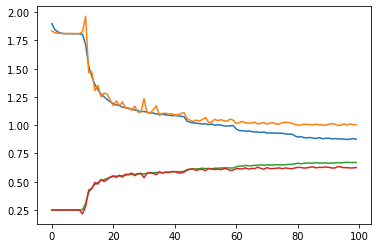

In [10]:
import pickle
pickle.dump(hist, open('featureactv3_baseline_desne_hist.hdf5', 'wb'))

plt.plot(hist), best_acc

In [12]:
model = torch.load('featureactv3_baseline_desne_model.pt')

# EVALUATE
model.eval()
running_valloss = 0.0
running_valacc = 0.0
for i,data in enumerate(test_loader):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = model(inputs)

    loss = criterion(outputs, labels)
    acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

    running_valloss += (loss.item() * inputs.size(0))
    running_valacc += acc.item()

print('- Avg. val_loss: %.3f | Avg. val_acc: %.3f' % (running_valloss / len(test_loader.dataset), running_valacc / len(test_loader.dataset)))

- Avg. val_loss: 0.994 | Avg. val_acc: 0.639


## Feature Act v3 with dense correlation and sigmoid act.

In [21]:
class FeatureAct(nn.Module):
    def __init__(self, src_depth, target_depth, reduce_factor=1, n_down=2):
        super(FeatureAct, self).__init__()
        
        self.pool = nn.MaxPool2d(kernel_size=(n_down,n_down), stride=n_down)
        self.relu = nn.ReLU(inplace=True)
        self.sigmoid = nn.Sigmoid()
        
        self.src_conv = nn.Conv2d(src_depth, src_depth // reduce_factor, kernel_size=1, padding=False)
        self.target_conv = nn.Conv2d(target_depth, target_depth // reduce_factor, kernel_size=1, padding=False)
        
        self.down_depth = nn.Sequential(nn.Conv2d(src_depth, src_depth // reduce_factor, kernel_size=1, padding=False),
                                        nn.ReLU(inplace=True),
                                        nn.MaxPool2d(kernel_size=(n_down,n_down), stride=n_down))
        self.up_depth = nn.Conv2d(target_depth // reduce_factor, target_depth, kernel_size=1, padding=False)
        
    def forward(self, src_x, target_x):
        
        src_features = self.src_conv(src_x)
        src_features = self.pool(src_features)
        
        target_features = self.target_conv(target_x)
        
        cor = nn.Flatten(-2)(src_features[:, None, :, :]).permute(0,2,1,3) * nn.Flatten(-2)(target_features[:, None, :, :])
        cor = self.sigmoid(cor)

        main_features = self.down_depth(src_x)
    
        cor_feature = torch.cat([(main_features * cor[:, :, k].view(-1, src_features.size(-3), src_features.size(-2), src_features.size(-1))).sum(1, keepdim=True) for k in range(cor.size(2))], dim=1)
        cor_feature = self.up_depth(cor_feature)
        
        target_x = target_x * (1 + cor_feature)
        target_x = self.relu(target_x)
        
        return target_x

In [22]:
class BaselineFeatureAct(nn.Module):
    def __init__(self, embeddings=False):
        
        super(BaselineFeatureAct, self).__init__()
        
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=(2,2), stride=2)
        
        self.conv0 = nn.Conv2d(1, 32, kernel_size=(3,3), padding=1, stride=1)
        self.conv0b = nn.Conv2d(32, 32, kernel_size=(3,3), padding=1, stride=1)
        self.bn0 = nn.BatchNorm2d(32)
        self.bn0b = nn.BatchNorm2d(32)
        
        self.conv1 = nn.Conv2d(32, 64, kernel_size=(3,3), padding=1, stride=1)
        self.conv1b = nn.Conv2d(64, 64, kernel_size=(3,3), padding=1, stride=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.bn1b = nn.BatchNorm2d(64)
        
        self.conv2 = nn.Conv2d(64, 128, kernel_size=(3,3), padding=1, stride=1)
        self.conv2b = nn.Conv2d(128, 128, kernel_size=(3,3), padding=1, stride=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn2b = nn.BatchNorm2d(128)
        
        self.conv3 = nn.Conv2d(128, 256, kernel_size=(3,3), padding=1, stride=1)
        self.conv3b = nn.Conv2d(256, 256, kernel_size=(3,3), padding=1, stride=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.bn3b = nn.BatchNorm2d(256)
  
        self.fact0_1 = FeatureAct(32, 64, 4, 2)
        self.fact0_2 = FeatureAct(32, 128, 4, 4)
        self.fact0_3 = FeatureAct(32, 256, 4, 8)
        
        self.fact1_2 = FeatureAct(64, 128, 4, 2)
        self.fact1_3 = FeatureAct(64, 256, 4, 4)
        
        self.fact2_3 = FeatureAct(128, 256, 4, 2)
        
        if not embeddings:
            self.classifier = nn.Sequential(nn.Flatten(),
                                            nn.Linear(2304, 256), nn.BatchNorm1d(256), nn.ReLU(inplace=True),
                                            nn.Linear(256, 128), nn.BatchNorm1d(128), nn.ReLU(inplace=True),
                                            nn.Linear(128, 7), nn.BatchNorm1d(7))
        else:
            self.classifier = nn.Sequential(nn.Flatten(),
                                            nn.Linear(2304, 256), nn.BatchNorm1d(256), nn.ReLU(inplace=True),
                                            nn.Linear(256, 128), nn.BatchNorm1d(128))

        
    def forward(self, x):
        
        x = self.conv0(x)
        x = self.bn0(x)
        x = self.relu(x)
        x = self.conv0b(x)
        x = self.bn0b(x)
        x = self.relu(x)
        
        x0 = self.maxpool(x)
        
        x = self.conv1(x0)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv1b(x)
        x = self.bn1b(x)
        x = self.relu(x)
        
        x1 = self.maxpool(x)

        xfact0_1 = self.fact0_1(x0, x1)
        
        x = self.conv2(xfact0_1)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv2b(x)
        x = self.bn2b(x)
        x = self.relu(x)
        
        x2 = self.maxpool(x)

        xfact0_2 = self.fact0_2(x0, x2)
        xfact1_2 = self.fact1_2(x1, x2) + xfact0_2
        
        x = self.conv3(xfact1_2)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.conv3b(x)
        x = self.bn3b(x)
        x = self.relu(x)
        
        x3 = self.maxpool(x)

        xfact0_3 = self.fact0_3(x0,x3)
        xfact1_3 = self.fact1_3(x1,x3)
        xfact2_3 = self.fact2_3(x2, x3) + xfact1_3 + xfact0_3
        
        x = nn.Flatten()(xfact2_3)
        x_out = self.classifier(x)
        
        if torch.isnan(xfact0_1).any():
            print('xfact0_1: ', xfact0_1)
        if torch.isnan(xfact0_2).any():
            print('xfact0_2: ', xfact0_2)
        if torch.isnan(xfact0_3).any():
            print('xfact0_3: ', xfact0_3)
        if torch.isnan(xfact1_2).any():
            print('xfact1_2: ', xfact1_2)
        if torch.isnan(xfact1_3).any():
            print('xfact1_3: ', xfact1_3)
        if torch.isnan(xfact2_3).any():
            print('xfact2_3: ', xfact2_3)

        return x_out

In [23]:
device = torch.device('cuda')
model = BaselineFeatureAct().to(device)

best_acc = 0.0
hist = []

epochs=100

criterion = nn.CrossEntropyLoss()

learning_rate = 0.004
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=7, verbose=True)


In [24]:
model_path = './featureactv3_baseline_desnesigmoid_model.pt'

for epoch in range(100):  # loop over the dataset multiple times

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0
    processed = 0.0

    # TRAIN
    model.train()
    pbar = tqdm(train_loader, position=0)
    for i, data in enumerate(pbar):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()
        loss.backward()
        
        optimizer.step()

        # print statistics
        running_loss += (loss.item() * inputs.size(0))
        running_acc += acc.item()
        processed += len(inputs)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={i} Accuracy={acc.item() / inputs.size(0)}')

    print('- Avg.loss: %.3f | Avg.acc: %.3f' % (running_loss / len(train_loader.dataset), running_acc / len(train_loader.dataset)))
    avgloss = running_loss / len(train_loader.dataset)
    avgacc = running_acc / len(train_loader.dataset)

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

        running_valloss += (loss.item() * inputs.size(0))
        running_valacc += acc.item()

    print('- Avg. val_loss: %.3f | Avg. val_acc: %.3f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

    avgvalloss = running_valloss / len(val_loader.dataset)
    avgvalacc = running_valacc / len(val_loader.dataset)
    
    scheduler.step(avgvalloss)

    hist.append([avgloss, avgvalloss, avgacc, avgvalacc])
    
    if best_acc < avgvalacc:
        best_acc = avgvalacc
        torch.save(model, model_path)
        print('* Update optimal model')

print('Finished Training')

  0%|          | 0/225 [00:00<?, ?it/s]

Epoch:  1


Loss=1.7387393712997437 Batch_id=224 Accuracy=0.32432432432432434: 100%|██████████| 225/225 [00:41<00:00,  5.48it/s]

- Avg.loss: 1.700 | Avg.acc: 0.336



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.639 | Avg. val_acc: 0.357
* Update optimal model
Epoch:  2


Loss=1.2584270238876343 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:41<00:00,  5.39it/s]

- Avg.loss: 1.412 | Avg.acc: 0.457



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.427 | Avg. val_acc: 0.468
* Update optimal model
Epoch:  3


Loss=1.0947908163070679 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:41<00:00,  5.43it/s]

- Avg.loss: 1.317 | Avg.acc: 0.494



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.245 | Avg. val_acc: 0.519
* Update optimal model
Epoch:  4


Loss=1.2222455739974976 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:41<00:00,  5.46it/s]

- Avg.loss: 1.265 | Avg.acc: 0.516



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.283 | Avg. val_acc: 0.512
Epoch:  5


Loss=1.3326853513717651 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:41<00:00,  5.45it/s]

- Avg.loss: 1.231 | Avg.acc: 0.531



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.230 | Avg. val_acc: 0.521
* Update optimal model
Epoch:  6


Loss=1.1255048513412476 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:41<00:00,  5.46it/s]

- Avg.loss: 1.212 | Avg.acc: 0.537



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.225 | Avg. val_acc: 0.532
* Update optimal model
Epoch:  7


Loss=1.3482916355133057 Batch_id=224 Accuracy=0.3783783783783784: 100%|██████████| 225/225 [00:41<00:00,  5.43it/s]

- Avg.loss: 1.186 | Avg.acc: 0.549



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.299 | Avg. val_acc: 0.506
Epoch:  8


Loss=1.4466445446014404 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [00:41<00:00,  5.43it/s]

- Avg.loss: 1.176 | Avg.acc: 0.552



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.227 | Avg. val_acc: 0.544
* Update optimal model
Epoch:  9


Loss=1.0435236692428589 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:41<00:00,  5.45it/s]

- Avg.loss: 1.166 | Avg.acc: 0.552



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.195 | Avg. val_acc: 0.547
* Update optimal model
Epoch:  10


Loss=1.485010027885437 Batch_id=224 Accuracy=0.3783783783783784: 100%|██████████| 225/225 [00:41<00:00,  5.44it/s]

- Avg.loss: 1.152 | Avg.acc: 0.560



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.230 | Avg. val_acc: 0.536
Epoch:  11


Loss=1.2523555755615234 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [00:41<00:00,  5.44it/s]

- Avg.loss: 1.143 | Avg.acc: 0.566



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.199 | Avg. val_acc: 0.556
* Update optimal model
Epoch:  12


Loss=1.3665024042129517 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [00:41<00:00,  5.47it/s]

- Avg.loss: 1.140 | Avg.acc: 0.564



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.171 | Avg. val_acc: 0.555
Epoch:  13


Loss=1.0864694118499756 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:41<00:00,  5.43it/s]

- Avg.loss: 1.123 | Avg.acc: 0.570



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.144 | Avg. val_acc: 0.566
* Update optimal model
Epoch:  14


Loss=1.0369940996170044 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [00:41<00:00,  5.45it/s]

- Avg.loss: 1.119 | Avg.acc: 0.576



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.150 | Avg. val_acc: 0.560
Epoch:  15


Loss=1.0477837324142456 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:41<00:00,  5.46it/s]

- Avg.loss: 1.116 | Avg.acc: 0.577



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.131 | Avg. val_acc: 0.569
* Update optimal model
Epoch:  16


Loss=1.2303643226623535 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:41<00:00,  5.38it/s]

- Avg.loss: 1.108 | Avg.acc: 0.577



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.121 | Avg. val_acc: 0.583
* Update optimal model
Epoch:  17


Loss=1.5042141675949097 Batch_id=224 Accuracy=0.3783783783783784: 100%|██████████| 225/225 [00:41<00:00,  5.43it/s]

- Avg.loss: 1.103 | Avg.acc: 0.580



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.110 | Avg. val_acc: 0.583
Epoch:  18


Loss=1.1385562419891357 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:41<00:00,  5.45it/s]

- Avg.loss: 1.100 | Avg.acc: 0.579



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.102 | Avg. val_acc: 0.588
* Update optimal model
Epoch:  19


Loss=1.0772051811218262 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:41<00:00,  5.44it/s]

- Avg.loss: 1.095 | Avg.acc: 0.584



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.127 | Avg. val_acc: 0.582
Epoch:  20


Loss=0.8827254772186279 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:41<00:00,  5.43it/s]

- Avg.loss: 1.089 | Avg.acc: 0.586



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.070 | Avg. val_acc: 0.606
* Update optimal model
Epoch:  21


Loss=1.3006209135055542 Batch_id=224 Accuracy=0.32432432432432434: 100%|██████████| 225/225 [00:40<00:00,  5.49it/s]

- Avg.loss: 1.086 | Avg.acc: 0.588



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.123 | Avg. val_acc: 0.576
Epoch:  22


Loss=1.259559988975525 Batch_id=224 Accuracy=0.4594594594594595: 100%|██████████| 225/225 [00:41<00:00,  5.47it/s]

- Avg.loss: 1.087 | Avg.acc: 0.588



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.090 | Avg. val_acc: 0.592
Epoch:  23


Loss=1.0764334201812744 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:41<00:00,  5.45it/s]

- Avg.loss: 1.077 | Avg.acc: 0.588



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.082 | Avg. val_acc: 0.598
Epoch:  24


Loss=1.3769328594207764 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [00:41<00:00,  5.44it/s]

- Avg.loss: 1.080 | Avg.acc: 0.589



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.070 | Avg. val_acc: 0.600
Epoch:  25


Loss=0.9770219326019287 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:41<00:00,  5.47it/s]

- Avg.loss: 1.068 | Avg.acc: 0.595



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.188 | Avg. val_acc: 0.570
Epoch:  26


Loss=1.186197280883789 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [00:41<00:00,  5.43it/s]

- Avg.loss: 1.061 | Avg.acc: 0.599



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.114 | Avg. val_acc: 0.576
Epoch:  27


Loss=1.3917133808135986 Batch_id=224 Accuracy=0.4594594594594595: 100%|██████████| 225/225 [00:41<00:00,  5.47it/s]

- Avg.loss: 1.073 | Avg.acc: 0.594



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.075 | Avg. val_acc: 0.593
Epoch:  28


Loss=0.8625106811523438 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:41<00:00,  5.45it/s]

- Avg.loss: 1.061 | Avg.acc: 0.598



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.070 | Avg. val_acc: 0.594
Epoch:  29


Loss=0.9524441361427307 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:41<00:00,  5.42it/s]

- Avg.loss: 1.061 | Avg.acc: 0.593



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.146 | Avg. val_acc: 0.571
Epoch:  30


Loss=0.9629811644554138 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:41<00:00,  5.44it/s]

- Avg.loss: 1.060 | Avg.acc: 0.600



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.080 | Avg. val_acc: 0.582
Epoch:  31


Loss=1.0979984998703003 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:41<00:00,  5.42it/s]

- Avg.loss: 1.056 | Avg.acc: 0.600



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.169 | Avg. val_acc: 0.581
Epoch:  32


Loss=1.2435345649719238 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [00:41<00:00,  5.42it/s]

- Avg.loss: 1.058 | Avg.acc: 0.598



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.058 | Avg. val_acc: 0.600
Epoch:  33


Loss=1.3288371562957764 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [00:41<00:00,  5.42it/s]

- Avg.loss: 1.052 | Avg.acc: 0.603



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.124 | Avg. val_acc: 0.576
Epoch:  34


Loss=1.2216053009033203 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:41<00:00,  5.49it/s]

- Avg.loss: 1.049 | Avg.acc: 0.603



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.114 | Avg. val_acc: 0.579
Epoch:  35


Loss=0.9993537664413452 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:41<00:00,  5.42it/s]

- Avg.loss: 1.052 | Avg.acc: 0.601



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.116 | Avg. val_acc: 0.577
Epoch:  36


Loss=1.175976276397705 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:41<00:00,  5.48it/s]

- Avg.loss: 1.046 | Avg.acc: 0.602



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.054 | Avg. val_acc: 0.600
Epoch:  37


Loss=0.9639683365821838 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:41<00:00,  5.43it/s]

- Avg.loss: 1.042 | Avg.acc: 0.607



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.098 | Avg. val_acc: 0.585
Epoch:  38


Loss=1.2626428604125977 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [00:41<00:00,  5.44it/s]

- Avg.loss: 1.046 | Avg.acc: 0.603



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.092 | Avg. val_acc: 0.592
Epoch:  39


Loss=0.9441419243812561 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:41<00:00,  5.44it/s]

- Avg.loss: 1.037 | Avg.acc: 0.605



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.080 | Avg. val_acc: 0.600
Epoch:  40


Loss=1.1371982097625732 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:41<00:00,  5.44it/s]

- Avg.loss: 1.039 | Avg.acc: 0.605



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.086 | Avg. val_acc: 0.593
Epoch:  41


Loss=1.089236855506897 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:41<00:00,  5.48it/s]

- Avg.loss: 1.039 | Avg.acc: 0.604



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.050 | Avg. val_acc: 0.606
* Update optimal model
Epoch:  42


Loss=1.0800917148590088 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:41<00:00,  5.44it/s]

- Avg.loss: 1.035 | Avg.acc: 0.610



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.062 | Avg. val_acc: 0.600
Epoch:  43


Loss=1.0355525016784668 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:41<00:00,  5.45it/s]

- Avg.loss: 1.034 | Avg.acc: 0.607



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.117 | Avg. val_acc: 0.568
Epoch:  44


Loss=0.868131697177887 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:41<00:00,  5.42it/s]

- Avg.loss: 1.033 | Avg.acc: 0.610



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.040 | Avg. val_acc: 0.600
Epoch:  45


Loss=1.267326831817627 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:41<00:00,  5.46it/s]

- Avg.loss: 1.034 | Avg.acc: 0.609



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.106 | Avg. val_acc: 0.583
Epoch:  46


Loss=1.100329875946045 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:41<00:00,  5.43it/s]

- Avg.loss: 1.030 | Avg.acc: 0.610



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.059 | Avg. val_acc: 0.606
Epoch:  47


Loss=1.3477962017059326 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [00:41<00:00,  5.45it/s]

- Avg.loss: 1.029 | Avg.acc: 0.609



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.086 | Avg. val_acc: 0.591
Epoch:  48


Loss=1.0246888399124146 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:41<00:00,  5.44it/s]

- Avg.loss: 1.025 | Avg.acc: 0.610



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.037 | Avg. val_acc: 0.608
* Update optimal model
Epoch:  49


Loss=1.104709506034851 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:41<00:00,  5.40it/s]

- Avg.loss: 1.023 | Avg.acc: 0.612



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.043 | Avg. val_acc: 0.609
* Update optimal model
Epoch:  50


Loss=1.1076968908309937 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:41<00:00,  5.44it/s]


- Avg.loss: 1.028 | Avg.acc: 0.609


  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.072 | Avg. val_acc: 0.604
Epoch:  51


Loss=1.3711130619049072 Batch_id=224 Accuracy=0.4594594594594595: 100%|██████████| 225/225 [00:41<00:00,  5.45it/s]

- Avg.loss: 1.025 | Avg.acc: 0.611



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.072 | Avg. val_acc: 0.593
Epoch:  52


Loss=1.116000771522522 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:41<00:00,  5.45it/s]

- Avg.loss: 1.019 | Avg.acc: 0.616



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.082 | Avg. val_acc: 0.587
Epoch:  53


Loss=1.2478392124176025 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:41<00:00,  5.44it/s]

- Avg.loss: 1.021 | Avg.acc: 0.613



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.056 | Avg. val_acc: 0.600
Epoch:  54


Loss=0.9318199157714844 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:41<00:00,  5.46it/s]

- Avg.loss: 1.022 | Avg.acc: 0.610



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.048 | Avg. val_acc: 0.605
Epoch:  55


Loss=1.0741623640060425 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:41<00:00,  5.45it/s]

- Avg.loss: 1.022 | Avg.acc: 0.614



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.031 | Avg. val_acc: 0.612
* Update optimal model
Epoch:  56


Loss=0.7883706092834473 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:41<00:00,  5.46it/s]

- Avg.loss: 1.011 | Avg.acc: 0.617



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.064 | Avg. val_acc: 0.611
Epoch:  57


Loss=0.8250524401664734 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:40<00:00,  5.49it/s]

- Avg.loss: 1.016 | Avg.acc: 0.614



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.041 | Avg. val_acc: 0.602
Epoch:  58


Loss=0.9397306442260742 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:41<00:00,  5.41it/s]

- Avg.loss: 1.018 | Avg.acc: 0.616



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.068 | Avg. val_acc: 0.600
Epoch:  59


Loss=0.9449407458305359 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:41<00:00,  5.48it/s]

- Avg.loss: 1.011 | Avg.acc: 0.619



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.085 | Avg. val_acc: 0.588
Epoch:  60


Loss=1.2595977783203125 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:41<00:00,  5.42it/s]

- Avg.loss: 1.012 | Avg.acc: 0.617



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.066 | Avg. val_acc: 0.598
Epoch:  61


Loss=0.7590340375900269 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:41<00:00,  5.43it/s]

- Avg.loss: 1.014 | Avg.acc: 0.616



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.071 | Avg. val_acc: 0.605
Epoch:  62


Loss=1.1822986602783203 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:41<00:00,  5.43it/s]

- Avg.loss: 1.010 | Avg.acc: 0.616



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.064 | Avg. val_acc: 0.602
Epoch:  63


Loss=0.7406376004219055 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:41<00:00,  5.43it/s]

- Avg.loss: 1.011 | Avg.acc: 0.617



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.075 | Avg. val_acc: 0.588
Epoch    63: reducing learning rate of group 0 to 2.0000e-03.
Epoch:  64


Loss=1.1267975568771362 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:41<00:00,  5.44it/s]

- Avg.loss: 0.968 | Avg.acc: 0.631



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.012 | Avg. val_acc: 0.611
Epoch:  65


Loss=1.45465087890625 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [00:41<00:00,  5.41it/s]

- Avg.loss: 0.952 | Avg.acc: 0.642



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.028 | Avg. val_acc: 0.609
Epoch:  66


Loss=1.0059758424758911 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:41<00:00,  5.42it/s]

- Avg.loss: 0.944 | Avg.acc: 0.642



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.004 | Avg. val_acc: 0.626
* Update optimal model
Epoch:  67


Loss=1.1093393564224243 Batch_id=224 Accuracy=0.43243243243243246: 100%|██████████| 225/225 [00:41<00:00,  5.41it/s]

- Avg.loss: 0.936 | Avg.acc: 0.645



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.009 | Avg. val_acc: 0.621
Epoch:  68


Loss=0.9433122873306274 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:41<00:00,  5.43it/s]

- Avg.loss: 0.937 | Avg.acc: 0.649



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.008 | Avg. val_acc: 0.628
* Update optimal model
Epoch:  69


Loss=0.7576025128364563 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:41<00:00,  5.43it/s]

- Avg.loss: 0.936 | Avg.acc: 0.643



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.002 | Avg. val_acc: 0.617
Epoch:  70


Loss=1.0955806970596313 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:41<00:00,  5.43it/s]

- Avg.loss: 0.931 | Avg.acc: 0.646



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.994 | Avg. val_acc: 0.618
Epoch:  71


Loss=1.05326509475708 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:41<00:00,  5.45it/s]

- Avg.loss: 0.935 | Avg.acc: 0.646



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.024 | Avg. val_acc: 0.617
Epoch:  72


Loss=1.017256736755371 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:41<00:00,  5.47it/s]

- Avg.loss: 0.930 | Avg.acc: 0.648



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.010 | Avg. val_acc: 0.627
Epoch:  73


Loss=1.2735116481781006 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:41<00:00,  5.44it/s]

- Avg.loss: 0.929 | Avg.acc: 0.650



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.993 | Avg. val_acc: 0.630
* Update optimal model
Epoch:  74


Loss=0.8084660172462463 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:41<00:00,  5.42it/s]

- Avg.loss: 0.923 | Avg.acc: 0.648



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.054 | Avg. val_acc: 0.611
Epoch:  75


Loss=0.9711347222328186 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:41<00:00,  5.46it/s]

- Avg.loss: 0.927 | Avg.acc: 0.650



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.027 | Avg. val_acc: 0.627
Epoch:  76


Loss=1.137880563735962 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:41<00:00,  5.45it/s]

- Avg.loss: 0.921 | Avg.acc: 0.652



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.997 | Avg. val_acc: 0.631
* Update optimal model
Epoch:  77


Loss=0.872103214263916 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:41<00:00,  5.48it/s]

- Avg.loss: 0.919 | Avg.acc: 0.655



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.994 | Avg. val_acc: 0.628
Epoch:  78


Loss=1.3817729949951172 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:41<00:00,  5.45it/s]

- Avg.loss: 0.917 | Avg.acc: 0.654



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.034 | Avg. val_acc: 0.616
Epoch:  79


Loss=0.9315973520278931 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:41<00:00,  5.46it/s]

- Avg.loss: 0.919 | Avg.acc: 0.653



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.020 | Avg. val_acc: 0.621
Epoch:  80


Loss=0.9741261601448059 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:41<00:00,  5.41it/s]

- Avg.loss: 0.913 | Avg.acc: 0.654



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.011 | Avg. val_acc: 0.623
Epoch:  81


Loss=0.8744370937347412 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:41<00:00,  5.45it/s]

- Avg.loss: 0.914 | Avg.acc: 0.654



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.015 | Avg. val_acc: 0.617
Epoch    81: reducing learning rate of group 0 to 1.0000e-03.
Epoch:  82


Loss=0.8609451055526733 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:41<00:00,  5.44it/s]

- Avg.loss: 0.880 | Avg.acc: 0.668



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.974 | Avg. val_acc: 0.637
* Update optimal model
Epoch:  83


Loss=0.9383293390274048 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:41<00:00,  5.45it/s]

- Avg.loss: 0.870 | Avg.acc: 0.673



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.976 | Avg. val_acc: 0.637
* Update optimal model
Epoch:  84


Loss=0.9293748140335083 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:41<00:00,  5.43it/s]

- Avg.loss: 0.861 | Avg.acc: 0.676



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.986 | Avg. val_acc: 0.633
Epoch:  85


Loss=1.0918872356414795 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:41<00:00,  5.48it/s]

- Avg.loss: 0.861 | Avg.acc: 0.674



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.982 | Avg. val_acc: 0.640
* Update optimal model
Epoch:  86


Loss=0.6083781123161316 Batch_id=224 Accuracy=0.8378378378378378: 100%|██████████| 225/225 [00:41<00:00,  5.41it/s]

- Avg.loss: 0.856 | Avg.acc: 0.680



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.981 | Avg. val_acc: 0.638
Epoch:  87


Loss=0.7377784848213196 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:41<00:00,  5.43it/s]

- Avg.loss: 0.847 | Avg.acc: 0.680



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.971 | Avg. val_acc: 0.638
Epoch:  88


Loss=0.7861089706420898 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:41<00:00,  5.43it/s]

- Avg.loss: 0.850 | Avg.acc: 0.680



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.990 | Avg. val_acc: 0.632
Epoch:  89


Loss=0.9745185375213623 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:41<00:00,  5.41it/s]

- Avg.loss: 0.845 | Avg.acc: 0.682



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.971 | Avg. val_acc: 0.645
* Update optimal model
Epoch:  90


Loss=0.766853928565979 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:41<00:00,  5.45it/s]

- Avg.loss: 0.842 | Avg.acc: 0.682



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.974 | Avg. val_acc: 0.643
Epoch:  91


Loss=0.5975005626678467 Batch_id=224 Accuracy=0.8378378378378378: 100%|██████████| 225/225 [00:41<00:00,  5.46it/s]

- Avg.loss: 0.841 | Avg.acc: 0.683



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.989 | Avg. val_acc: 0.636
Epoch:  92


Loss=1.0767428874969482 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:41<00:00,  5.41it/s]

- Avg.loss: 0.842 | Avg.acc: 0.684



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.985 | Avg. val_acc: 0.635
Epoch:  93


Loss=0.6877725720405579 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:41<00:00,  5.46it/s]

- Avg.loss: 0.835 | Avg.acc: 0.684



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.963 | Avg. val_acc: 0.643
Epoch:  94


Loss=0.9937560558319092 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:41<00:00,  5.43it/s]

- Avg.loss: 0.841 | Avg.acc: 0.685



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.965 | Avg. val_acc: 0.651
* Update optimal model
Epoch:  95


Loss=1.024328589439392 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:41<00:00,  5.42it/s]

- Avg.loss: 0.836 | Avg.acc: 0.683



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.976 | Avg. val_acc: 0.634
Epoch:  96


Loss=0.7955737113952637 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:41<00:00,  5.46it/s]

- Avg.loss: 0.829 | Avg.acc: 0.688



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.980 | Avg. val_acc: 0.638
Epoch:  97


Loss=0.8279191255569458 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:41<00:00,  5.45it/s]

- Avg.loss: 0.830 | Avg.acc: 0.687



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.971 | Avg. val_acc: 0.639
Epoch:  98


Loss=1.1292903423309326 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:41<00:00,  5.43it/s]

- Avg.loss: 0.828 | Avg.acc: 0.690



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.975 | Avg. val_acc: 0.641
Epoch:  99


Loss=1.0504401922225952 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:41<00:00,  5.42it/s]

- Avg.loss: 0.826 | Avg.acc: 0.688



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.991 | Avg. val_acc: 0.636
Epoch:  100


Loss=1.0054864883422852 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:41<00:00,  5.44it/s]

- Avg.loss: 0.826 | Avg.acc: 0.689


- Avg. val_loss: 0.981 | Avg. val_acc: 0.638
Finished Training


In [25]:
for epoch in range(100, 150):  # loop over the dataset multiple times

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0
    processed = 0.0

    # TRAIN
    model.train()
    pbar = tqdm(train_loader, position=0)
    for i, data in enumerate(pbar):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()
        loss.backward()
        
        optimizer.step()

        # print statistics
        running_loss += (loss.item() * inputs.size(0))
        running_acc += acc.item()
        processed += len(inputs)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={i} Accuracy={acc.item() / inputs.size(0)}')

    print('- Avg.loss: %.3f | Avg.acc: %.3f' % (running_loss / len(train_loader.dataset), running_acc / len(train_loader.dataset)))
    avgloss = running_loss / len(train_loader.dataset)
    avgacc = running_acc / len(train_loader.dataset)

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

        running_valloss += (loss.item() * inputs.size(0))
        running_valacc += acc.item()

    print('- Avg. val_loss: %.3f | Avg. val_acc: %.3f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

    avgvalloss = running_valloss / len(val_loader.dataset)
    avgvalacc = running_valacc / len(val_loader.dataset)
    
    scheduler.step(avgvalloss)

    hist.append([avgloss, avgvalloss, avgacc, avgvalacc])
    
    if best_acc < avgvalacc:
        best_acc = avgvalacc
        torch.save(model, model_path)
        print('* Update optimal model')

print('Finished Training')

  0%|          | 0/225 [00:00<?, ?it/s]

Epoch:  101


Loss=0.6340717673301697 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:40<00:00,  5.49it/s]

- Avg.loss: 0.823 | Avg.acc: 0.691



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.975 | Avg. val_acc: 0.640
Epoch   101: reducing learning rate of group 0 to 5.0000e-04.
Epoch:  102


Loss=0.8154796361923218 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:41<00:00,  5.48it/s]

- Avg.loss: 0.808 | Avg.acc: 0.692



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.972 | Avg. val_acc: 0.642
Epoch:  103


Loss=0.6177867650985718 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [00:41<00:00,  5.41it/s]

- Avg.loss: 0.791 | Avg.acc: 0.704



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.973 | Avg. val_acc: 0.641
Epoch:  104


Loss=0.9458742737770081 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:41<00:00,  5.45it/s]

- Avg.loss: 0.788 | Avg.acc: 0.705



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.979 | Avg. val_acc: 0.637
Epoch:  105


Loss=0.8066961169242859 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [00:41<00:00,  5.46it/s]

- Avg.loss: 0.779 | Avg.acc: 0.709



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.978 | Avg. val_acc: 0.637
Epoch:  106


Loss=0.5487915873527527 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:41<00:00,  5.42it/s]

- Avg.loss: 0.784 | Avg.acc: 0.707



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.970 | Avg. val_acc: 0.645
Epoch:  107


Loss=0.8502813577651978 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:41<00:00,  5.48it/s]

- Avg.loss: 0.782 | Avg.acc: 0.707



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.985 | Avg. val_acc: 0.638
Epoch:  108


Loss=0.7489369511604309 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:41<00:00,  5.43it/s]

- Avg.loss: 0.775 | Avg.acc: 0.708



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.974 | Avg. val_acc: 0.642
Epoch:  109


Loss=0.604202151298523 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:41<00:00,  5.48it/s]

- Avg.loss: 0.775 | Avg.acc: 0.708



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.977 | Avg. val_acc: 0.645
Epoch   109: reducing learning rate of group 0 to 2.5000e-04.
Epoch:  110


Loss=0.9998023509979248 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:41<00:00,  5.47it/s]

- Avg.loss: 0.758 | Avg.acc: 0.716



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.983 | Avg. val_acc: 0.645
Epoch:  111


Loss=0.7946229577064514 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:41<00:00,  5.39it/s]

- Avg.loss: 0.762 | Avg.acc: 0.713



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.986 | Avg. val_acc: 0.644
Epoch:  112


Loss=0.6531457901000977 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [00:41<00:00,  5.44it/s]

- Avg.loss: 0.755 | Avg.acc: 0.717



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.982 | Avg. val_acc: 0.642
Epoch:  113


Loss=0.900070071220398 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:41<00:00,  5.44it/s]

- Avg.loss: 0.758 | Avg.acc: 0.714



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.985 | Avg. val_acc: 0.642
Epoch:  114


Loss=1.0337222814559937 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:41<00:00,  5.45it/s]

- Avg.loss: 0.750 | Avg.acc: 0.717



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.979 | Avg. val_acc: 0.643
Epoch:  115


Loss=0.7672477960586548 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:41<00:00,  5.47it/s]


- Avg.loss: 0.750 | Avg.acc: 0.719


  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.983 | Avg. val_acc: 0.649
Epoch:  116


Loss=0.5955383777618408 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:41<00:00,  5.44it/s]

- Avg.loss: 0.749 | Avg.acc: 0.718



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.986 | Avg. val_acc: 0.644
Epoch:  117


Loss=0.8270212411880493 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:41<00:00,  5.42it/s]

- Avg.loss: 0.749 | Avg.acc: 0.718



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.991 | Avg. val_acc: 0.649
Epoch   117: reducing learning rate of group 0 to 1.2500e-04.
Epoch:  118


Loss=0.4791046977043152 Batch_id=224 Accuracy=0.8108108108108109: 100%|██████████| 225/225 [00:41<00:00,  5.43it/s]

- Avg.loss: 0.739 | Avg.acc: 0.724



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.979 | Avg. val_acc: 0.643
Epoch:  119


Loss=0.6539167761802673 Batch_id=224 Accuracy=0.8108108108108109: 100%|██████████| 225/225 [00:41<00:00,  5.43it/s]

- Avg.loss: 0.735 | Avg.acc: 0.725



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.986 | Avg. val_acc: 0.642
Epoch:  120


Loss=0.47257572412490845 Batch_id=224 Accuracy=0.8648648648648649: 100%|██████████| 225/225 [00:41<00:00,  5.44it/s]

- Avg.loss: 0.734 | Avg.acc: 0.722



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.986 | Avg. val_acc: 0.648
Epoch:  121


Loss=0.8016019463539124 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:41<00:00,  5.45it/s]

- Avg.loss: 0.742 | Avg.acc: 0.727



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.979 | Avg. val_acc: 0.651
Epoch:  122


Loss=0.7014474868774414 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:41<00:00,  5.44it/s]

- Avg.loss: 0.732 | Avg.acc: 0.727



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.985 | Avg. val_acc: 0.653
* Update optimal model
Epoch:  123


Loss=0.6978420615196228 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:41<00:00,  5.43it/s]

- Avg.loss: 0.724 | Avg.acc: 0.728



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.990 | Avg. val_acc: 0.649
Epoch:  124


Loss=0.6889456510543823 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:41<00:00,  5.42it/s]

- Avg.loss: 0.734 | Avg.acc: 0.728



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.986 | Avg. val_acc: 0.649
Epoch:  125


Loss=0.6895856857299805 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:41<00:00,  5.45it/s]


- Avg.loss: 0.726 | Avg.acc: 0.729


  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.991 | Avg. val_acc: 0.651
Epoch   125: reducing learning rate of group 0 to 6.2500e-05.
Epoch:  126


Loss=0.7243441343307495 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:41<00:00,  5.45it/s]

- Avg.loss: 0.727 | Avg.acc: 0.730



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.987 | Avg. val_acc: 0.649
Epoch:  127


Loss=0.5226923823356628 Batch_id=224 Accuracy=0.8108108108108109: 100%|██████████| 225/225 [00:41<00:00,  5.43it/s]

- Avg.loss: 0.729 | Avg.acc: 0.728



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.985 | Avg. val_acc: 0.651
Epoch:  128


Loss=0.5609421730041504 Batch_id=224 Accuracy=0.8378378378378378: 100%|██████████| 225/225 [00:41<00:00,  5.45it/s]

- Avg.loss: 0.730 | Avg.acc: 0.729



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.990 | Avg. val_acc: 0.653
Epoch:  129


Loss=1.1515016555786133 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:41<00:00,  5.42it/s]

- Avg.loss: 0.724 | Avg.acc: 0.732



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.991 | Avg. val_acc: 0.649
Epoch:  130


Loss=0.8441389203071594 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:41<00:00,  5.43it/s]

- Avg.loss: 0.726 | Avg.acc: 0.731



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.991 | Avg. val_acc: 0.648
Epoch:  131


Loss=0.6575047969818115 Batch_id=224 Accuracy=0.8108108108108109: 100%|██████████| 225/225 [00:41<00:00,  5.43it/s]

- Avg.loss: 0.725 | Avg.acc: 0.731



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.995 | Avg. val_acc: 0.646
Epoch:  132


Loss=0.9484906792640686 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:41<00:00,  5.42it/s]

- Avg.loss: 0.719 | Avg.acc: 0.730



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.993 | Avg. val_acc: 0.649
Epoch:  133


Loss=1.0137726068496704 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:41<00:00,  5.43it/s]

- Avg.loss: 0.725 | Avg.acc: 0.730



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.989 | Avg. val_acc: 0.652
Epoch   133: reducing learning rate of group 0 to 3.1250e-05.
Epoch:  134


Loss=0.7549365162849426 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:41<00:00,  5.40it/s]

- Avg.loss: 0.716 | Avg.acc: 0.733



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.985 | Avg. val_acc: 0.649
Epoch:  135


Loss=0.6579679846763611 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [00:41<00:00,  5.43it/s]

- Avg.loss: 0.723 | Avg.acc: 0.730



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.990 | Avg. val_acc: 0.647
Epoch:  136


Loss=0.8216317892074585 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:41<00:00,  5.45it/s]

- Avg.loss: 0.724 | Avg.acc: 0.730



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.987 | Avg. val_acc: 0.647
Epoch:  137


Loss=0.8784093856811523 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:41<00:00,  5.45it/s]

- Avg.loss: 0.722 | Avg.acc: 0.731



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.989 | Avg. val_acc: 0.651
Epoch:  138


Loss=0.9632498025894165 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:41<00:00,  5.46it/s]

- Avg.loss: 0.719 | Avg.acc: 0.732



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.993 | Avg. val_acc: 0.649
Epoch:  139


Loss=1.0021523237228394 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:41<00:00,  5.42it/s]

- Avg.loss: 0.721 | Avg.acc: 0.731



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.996 | Avg. val_acc: 0.649
Epoch:  140


Loss=0.6520076394081116 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:41<00:00,  5.42it/s]

- Avg.loss: 0.720 | Avg.acc: 0.731



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.991 | Avg. val_acc: 0.648
Epoch:  141


Loss=0.7851945757865906 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:41<00:00,  5.45it/s]

- Avg.loss: 0.718 | Avg.acc: 0.733



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.993 | Avg. val_acc: 0.650
Epoch   141: reducing learning rate of group 0 to 1.5625e-05.
Epoch:  142


Loss=0.6910067796707153 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:41<00:00,  5.44it/s]

- Avg.loss: 0.717 | Avg.acc: 0.734



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.991 | Avg. val_acc: 0.650
Epoch:  143


Loss=0.7205015420913696 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [00:41<00:00,  5.45it/s]

- Avg.loss: 0.713 | Avg.acc: 0.734



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.990 | Avg. val_acc: 0.650
Epoch:  144


Loss=0.888484001159668 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:41<00:00,  5.43it/s]

- Avg.loss: 0.720 | Avg.acc: 0.731



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.991 | Avg. val_acc: 0.652
Epoch:  145


Loss=0.9617699384689331 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:41<00:00,  5.40it/s]

- Avg.loss: 0.717 | Avg.acc: 0.734



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.989 | Avg. val_acc: 0.650
Epoch:  146


Loss=0.552371084690094 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [00:41<00:00,  5.40it/s]

- Avg.loss: 0.720 | Avg.acc: 0.732



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.992 | Avg. val_acc: 0.650
Epoch:  147


Loss=0.6558080315589905 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:41<00:00,  5.45it/s]

- Avg.loss: 0.713 | Avg.acc: 0.734



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.989 | Avg. val_acc: 0.649
Epoch:  148


Loss=0.9031489491462708 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:41<00:00,  5.48it/s]

- Avg.loss: 0.711 | Avg.acc: 0.734



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.996 | Avg. val_acc: 0.648
Epoch:  149


Loss=0.8684964776039124 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:41<00:00,  5.43it/s]

- Avg.loss: 0.714 | Avg.acc: 0.735



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.990 | Avg. val_acc: 0.651
Epoch   149: reducing learning rate of group 0 to 7.8125e-06.
Epoch:  150


Loss=0.755803644657135 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:41<00:00,  5.41it/s]

- Avg.loss: 0.715 | Avg.acc: 0.732


- Avg. val_loss: 0.994 | Avg. val_acc: 0.653
* Update optimal model
Finished Training


([<matplotlib.lines.Line2D at 0x7fb308228550>,
 0.653106714962385)

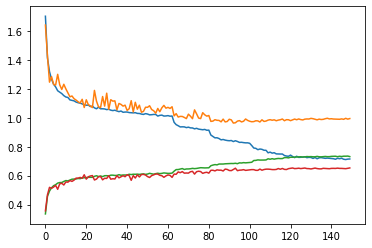

In [27]:
import pickle
pickle.dump(hist, open('featureactv3_baseline_desnesigmoid_hist.hdf5', 'wb'))

plt.plot(hist), best_acc

In [28]:
model = torch.load('featureactv3_baseline_desnesigmoid_model.pt')

# EVALUATE
model.eval()
running_valloss = 0.0
running_valacc = 0.0
for i,data in enumerate(test_loader):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = model(inputs)

    loss = criterion(outputs, labels)
    acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

    running_valloss += (loss.item() * inputs.size(0))
    running_valacc += acc.item()

print('- Avg. val_loss: %.3f | Avg. val_acc: %.3f' % (running_valloss / len(test_loader.dataset), running_valacc / len(test_loader.dataset)))

- Avg. val_loss: 0.960 | Avg. val_acc: 0.662


## Feature Act v3.2

In [5]:
class FeatureAct(nn.Module):
    def __init__(self, src_depth, target_depth, reduce_factor=1):
        super(FeatureAct, self).__init__()
        self.pool = nn.MaxPool2d(kernel_size=(2,2), stride=2)
        
        self.src_conv = nn.Conv2d(src_depth, src_depth // reduce_factor, kernel_size=1, padding=False)
        self.target_conv = nn.Conv2d(target_depth, target_depth // reduce_factor, kernel_size=1, padding=False)
        
        self.down_depth = nn.Sequential(nn.Conv2d(src_depth, src_depth // reduce_factor, kernel_size=1, padding=False),
                                        nn.ReLU(inplace=True),
                                        nn.MaxPool2d(kernel_size=(2,2), stride=2))
        self.up_depth = nn.Conv2d(target_depth // reduce_factor, target_depth, kernel_size=1, padding=False)
        
    def forward(self, src_x, target_x):
        
        src_features = self.src_conv(src_x)
        src_features = self.pool(src_features)
        
        target_features = self.target_conv(target_x)
        
        cor = nn.Flatten(-2)(src_features[:, None, :, :]).permute(0,2,1,3) * nn.Flatten(-2)(target_features[:, None, :, :])
#         cor = cor / torch.norm(cor)
#         print(cor.size())

        main_features = self.down_depth(src_x)
    
        cor_feature = torch.cat([(main_features * cor[:, :, k].view(-1, src_features.size(-3), src_features.size(-2), src_features.size(-1))).sum(1, keepdim=True) for k in range(cor.size(2))], dim=1)
        cor_feature = self.up_depth(cor_feature)
        
        target_x = target_x + cor_feature
        
        return target_x

In [6]:
class BaselineFeatureAct(nn.Module):
    def __init__(self, embeddings=False):
        
        super(BaselineFeatureAct, self).__init__()
        
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=(2,2), stride=2)
        
        self.conv0 = nn.Conv2d(1, 32, kernel_size=(3,3), padding=1, stride=1)
        self.conv0b = nn.Conv2d(32, 32, kernel_size=(3,3), padding=1, stride=1)
        self.bn0 = nn.BatchNorm2d(32)
        self.bn0b = nn.BatchNorm2d(32)
        
        self.conv1 = nn.Conv2d(32, 64, kernel_size=(3,3), padding=1, stride=1)
        self.conv1b = nn.Conv2d(64, 64, kernel_size=(3,3), padding=1, stride=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.bn1b = nn.BatchNorm2d(64)
        
        self.conv2 = nn.Conv2d(64, 128, kernel_size=(3,3), padding=1, stride=1)
        self.conv2b = nn.Conv2d(128, 128, kernel_size=(3,3), padding=1, stride=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn2b = nn.BatchNorm2d(128)
        
        self.conv3 = nn.Conv2d(128, 256, kernel_size=(3,3), padding=1, stride=1)
        self.conv3b = nn.Conv2d(256, 256, kernel_size=(3,3), padding=1, stride=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.bn3b = nn.BatchNorm2d(256)
  
        self.fact0_1 = FeatureAct(32, 64, 4)
        self.fact1_2 = FeatureAct(64, 128, 4)
        self.fact2_3 = FeatureAct(128, 256, 4)
        
        if not embeddings:
            self.classifier = nn.Sequential(nn.Flatten(),
                                            nn.Linear(2304, 256), nn.BatchNorm1d(256), nn.ReLU(inplace=True),
                                            nn.Linear(256, 128), nn.BatchNorm1d(128), nn.ReLU(inplace=True),
                                            nn.Linear(128, 7), nn.BatchNorm1d(7))
        else:
            self.classifier = nn.Sequential(nn.Flatten(),
                                            nn.Linear(2304, 256), nn.BatchNorm1d(256), nn.ReLU(inplace=True),
                                            nn.Linear(256, 128), nn.BatchNorm1d(128))

        
    def forward(self, x):
        
        x = self.conv0(x)
        x = self.bn0(x)
        x = self.relu(x)
        x = self.conv0b(x)
        x = self.bn0b(x)
        x = self.relu(x)
        
        x0 = self.maxpool(x)
        
        x = self.conv1(x0)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv1b(x)
        x = self.bn1b(x)
        x = self.relu(x)
        
        x1 = self.maxpool(x)

        xfact0_1 = self.fact0_1(x0, x1)
        
        x = self.conv2(xfact0_1)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv2b(x)
        x = self.bn2b(x)
        x = self.relu(x)
        
        x2 = self.maxpool(x)

        xfact1_2 = self.fact1_2(x1, x2)
        
        x = self.conv3(xfact1_2)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.conv3b(x)
        x = self.bn3b(x)
        x = self.relu(x)
        
        x3 = self.maxpool(x)

        xfact2_3 = self.fact2_3(x2, x3)
        
        x = nn.Flatten()(xfact2_3)
        x_out = self.classifier(x)
        
        return x_out

In [7]:
device = torch.device('cuda')
model = BaselineFeatureAct().to(device)

best_acc = 0.0
hist = []

epochs=100

criterion = nn.CrossEntropyLoss()

learning_rate = 0.004
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=7, verbose=True)


In [8]:
model_path = './featureactv32_baseline_model.pt'

for epoch in range(100):  # loop over the dataset multiple times

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0
    processed = 0.0

    # TRAIN
    model.train()
    pbar = tqdm(train_loader, position=0)
    for i, data in enumerate(pbar):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()
        loss.backward()
        
        optimizer.step()

        # print statistics
        running_loss += (loss.item() * inputs.size(0))
        running_acc += acc.item()
        processed += len(inputs)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={i} Accuracy={acc.item() / inputs.size(0)}')

    print('- Avg.loss: %.3f | Avg.acc: %.3f' % (running_loss / len(train_loader.dataset), running_acc / len(train_loader.dataset)))
    avgloss = running_loss / len(train_loader.dataset)
    avgacc = running_acc / len(train_loader.dataset)

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

        running_valloss += (loss.item() * inputs.size(0))
        running_valacc += acc.item()

    print('- Avg. val_loss: %.3f | Avg. val_acc: %.3f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

    avgvalloss = running_valloss / len(val_loader.dataset)
    avgvalacc = running_valacc / len(val_loader.dataset)
    
    scheduler.step(avgvalloss)

    hist.append([avgloss, avgvalloss, avgacc, avgvalacc])
    
    if best_acc < avgvalacc:
        best_acc = avgvalacc
        torch.save(model, model_path)
        print('* Update optimal model')

print('Finished Training')

  0%|          | 0/225 [00:00<?, ?it/s]

Epoch:  1


Loss=1.794869065284729 Batch_id=224 Accuracy=0.2972972972972973: 100%|██████████| 225/225 [00:31<00:00,  7.16it/s]

- Avg.loss: 1.900 | Avg.acc: 0.234



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.838 | Avg. val_acc: 0.249
* Update optimal model
Epoch:  2


Loss=1.7887299060821533 Batch_id=224 Accuracy=0.2972972972972973: 100%|██████████| 225/225 [00:31<00:00,  7.23it/s]

- Avg.loss: 1.845 | Avg.acc: 0.251



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.819 | Avg. val_acc: 0.249
Epoch:  3


Loss=1.8455880880355835 Batch_id=224 Accuracy=0.16216216216216217: 100%|██████████| 225/225 [00:31<00:00,  7.20it/s]

- Avg.loss: 1.824 | Avg.acc: 0.251



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.814 | Avg. val_acc: 0.249
Epoch:  4


Loss=1.7902758121490479 Batch_id=224 Accuracy=0.2702702702702703: 100%|██████████| 225/225 [00:30<00:00,  7.28it/s]

- Avg.loss: 1.814 | Avg.acc: 0.251



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.812 | Avg. val_acc: 0.249
Epoch:  5


Loss=1.8527928590774536 Batch_id=224 Accuracy=0.32432432432432434: 100%|██████████| 225/225 [00:29<00:00,  7.52it/s]

- Avg.loss: 1.826 | Avg.acc: 0.251



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.812 | Avg. val_acc: 0.249
Epoch:  6


Loss=1.9275691509246826 Batch_id=224 Accuracy=0.10810810810810811: 100%|██████████| 225/225 [00:32<00:00,  6.95it/s]

- Avg.loss: 1.814 | Avg.acc: 0.251



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.811 | Avg. val_acc: 0.249
Epoch:  7


Loss=1.784041166305542 Batch_id=224 Accuracy=0.21621621621621623: 100%|██████████| 225/225 [00:32<00:00,  6.94it/s]

- Avg.loss: 1.810 | Avg.acc: 0.251



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.811 | Avg. val_acc: 0.249
Epoch:  8


Loss=1.8968944549560547 Batch_id=224 Accuracy=0.16216216216216217: 100%|██████████| 225/225 [00:31<00:00,  7.06it/s]

- Avg.loss: 1.811 | Avg.acc: 0.251



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.811 | Avg. val_acc: 0.249
Epoch:  9


Loss=1.854043960571289 Batch_id=224 Accuracy=0.24324324324324326: 100%|██████████| 225/225 [00:31<00:00,  7.14it/s]

- Avg.loss: 1.811 | Avg.acc: 0.251



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.812 | Avg. val_acc: 0.249
Epoch:  10


Loss=1.8909553289413452 Batch_id=224 Accuracy=0.24324324324324326: 100%|██████████| 225/225 [00:30<00:00,  7.26it/s]

- Avg.loss: 1.811 | Avg.acc: 0.251



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.811 | Avg. val_acc: 0.249
Epoch:  11


Loss=1.7509980201721191 Batch_id=224 Accuracy=0.24324324324324326: 100%|██████████| 225/225 [00:30<00:00,  7.28it/s]

- Avg.loss: 1.797 | Avg.acc: 0.258



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 3.715 | Avg. val_acc: 0.117
Epoch:  12


Loss=1.380393385887146 Batch_id=224 Accuracy=0.3783783783783784: 100%|██████████| 225/225 [00:31<00:00,  7.20it/s]

- Avg.loss: 1.596 | Avg.acc: 0.369



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.461 | Avg. val_acc: 0.430
* Update optimal model
Epoch:  13


Loss=1.6313451528549194 Batch_id=224 Accuracy=0.35135135135135137: 100%|██████████| 225/225 [00:30<00:00,  7.33it/s]

- Avg.loss: 1.422 | Avg.acc: 0.445



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.352 | Avg. val_acc: 0.486
* Update optimal model
Epoch:  14


Loss=1.1664904356002808 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:31<00:00,  7.19it/s]

- Avg.loss: 1.349 | Avg.acc: 0.479



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.312 | Avg. val_acc: 0.498
* Update optimal model
Epoch:  15


Loss=1.1507400274276733 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [00:31<00:00,  7.23it/s]

- Avg.loss: 1.300 | Avg.acc: 0.499



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.612 | Avg. val_acc: 0.407
Epoch:  16


Loss=1.1872714757919312 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [00:32<00:00,  6.86it/s]

- Avg.loss: 1.264 | Avg.acc: 0.516



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.224 | Avg. val_acc: 0.533
* Update optimal model
Epoch:  17


Loss=1.0983061790466309 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:32<00:00,  6.93it/s]

- Avg.loss: 1.242 | Avg.acc: 0.524



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.207 | Avg. val_acc: 0.544
* Update optimal model
Epoch:  18


Loss=0.9539604187011719 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:31<00:00,  7.06it/s]

- Avg.loss: 1.217 | Avg.acc: 0.536



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.196 | Avg. val_acc: 0.542
Epoch:  19


Loss=1.2955653667449951 Batch_id=224 Accuracy=0.43243243243243246: 100%|██████████| 225/225 [00:30<00:00,  7.27it/s]

- Avg.loss: 1.204 | Avg.acc: 0.540



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.195 | Avg. val_acc: 0.548
* Update optimal model
Epoch:  20


Loss=1.0828598737716675 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:31<00:00,  7.07it/s]

- Avg.loss: 1.188 | Avg.acc: 0.548



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.278 | Avg. val_acc: 0.519
Epoch:  21


Loss=1.3752682209014893 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [00:31<00:00,  7.21it/s]

- Avg.loss: 1.178 | Avg.acc: 0.549



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.151 | Avg. val_acc: 0.567
* Update optimal model
Epoch:  22


Loss=1.0952857732772827 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:31<00:00,  7.12it/s]

- Avg.loss: 1.163 | Avg.acc: 0.557



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.169 | Avg. val_acc: 0.553
Epoch:  23


Loss=1.2271908521652222 Batch_id=224 Accuracy=0.40540540540540543: 100%|██████████| 225/225 [00:30<00:00,  7.35it/s]

- Avg.loss: 1.152 | Avg.acc: 0.563



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.146 | Avg. val_acc: 0.564
Epoch:  24


Loss=1.1972421407699585 Batch_id=224 Accuracy=0.43243243243243246: 100%|██████████| 225/225 [00:29<00:00,  7.64it/s]

- Avg.loss: 1.154 | Avg.acc: 0.560



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.186 | Avg. val_acc: 0.548
Epoch:  25


Loss=1.2222485542297363 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:31<00:00,  7.17it/s]

- Avg.loss: 1.139 | Avg.acc: 0.564



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.175 | Avg. val_acc: 0.550
Epoch:  26


Loss=1.22737717628479 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:31<00:00,  7.22it/s]

- Avg.loss: 1.138 | Avg.acc: 0.565



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.117 | Avg. val_acc: 0.569
* Update optimal model
Epoch:  27


Loss=1.0339024066925049 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:31<00:00,  7.25it/s]

- Avg.loss: 1.132 | Avg.acc: 0.569



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.139 | Avg. val_acc: 0.563
Epoch:  28


Loss=1.0044243335723877 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:30<00:00,  7.33it/s]

- Avg.loss: 1.120 | Avg.acc: 0.573



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.116 | Avg. val_acc: 0.566
Epoch:  29


Loss=1.1415529251098633 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:31<00:00,  7.25it/s]

- Avg.loss: 1.115 | Avg.acc: 0.578



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.141 | Avg. val_acc: 0.568
Epoch:  30


Loss=1.2819918394088745 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [00:32<00:00,  6.99it/s]

- Avg.loss: 1.114 | Avg.acc: 0.573



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.095 | Avg. val_acc: 0.585
* Update optimal model
Epoch:  31


Loss=1.074367642402649 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:32<00:00,  7.02it/s]

- Avg.loss: 1.108 | Avg.acc: 0.576



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.151 | Avg. val_acc: 0.565
Epoch:  32


Loss=0.9872296452522278 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:29<00:00,  7.57it/s]

- Avg.loss: 1.105 | Avg.acc: 0.579



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.137 | Avg. val_acc: 0.576
Epoch:  33


Loss=1.2088041305541992 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:31<00:00,  7.14it/s]

- Avg.loss: 1.101 | Avg.acc: 0.583



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.137 | Avg. val_acc: 0.566
Epoch:  34


Loss=1.102905035018921 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:33<00:00,  6.76it/s]

- Avg.loss: 1.100 | Avg.acc: 0.580



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.120 | Avg. val_acc: 0.578
Epoch:  35


Loss=1.4338256120681763 Batch_id=224 Accuracy=0.3783783783783784: 100%|██████████| 225/225 [00:31<00:00,  7.16it/s]

- Avg.loss: 1.091 | Avg.acc: 0.584



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.100 | Avg. val_acc: 0.588
* Update optimal model
Epoch:  36


Loss=1.0690134763717651 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:32<00:00,  7.02it/s]

- Avg.loss: 1.091 | Avg.acc: 0.587



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.104 | Avg. val_acc: 0.577
Epoch:  37


Loss=1.1792385578155518 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [00:31<00:00,  7.24it/s]

- Avg.loss: 1.085 | Avg.acc: 0.589



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.102 | Avg. val_acc: 0.583
Epoch:  38


Loss=1.0949574708938599 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:31<00:00,  7.12it/s]

- Avg.loss: 1.085 | Avg.acc: 0.590



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.149 | Avg. val_acc: 0.563
Epoch    38: reducing learning rate of group 0 to 2.0000e-03.
Epoch:  39


Loss=0.9593928456306458 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:33<00:00,  6.79it/s]

- Avg.loss: 1.053 | Avg.acc: 0.601



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.048 | Avg. val_acc: 0.603
* Update optimal model
Epoch:  40


Loss=1.0792161226272583 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:33<00:00,  6.82it/s]

- Avg.loss: 1.032 | Avg.acc: 0.608



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.056 | Avg. val_acc: 0.601
Epoch:  41


Loss=0.988586962223053 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:31<00:00,  7.09it/s]

- Avg.loss: 1.032 | Avg.acc: 0.606



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.046 | Avg. val_acc: 0.603
Epoch:  42


Loss=0.8757410049438477 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:33<00:00,  6.80it/s]

- Avg.loss: 1.022 | Avg.acc: 0.613



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.078 | Avg. val_acc: 0.600
Epoch:  43


Loss=1.0706987380981445 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:31<00:00,  7.19it/s]

- Avg.loss: 1.024 | Avg.acc: 0.608



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.070 | Avg. val_acc: 0.601
Epoch:  44


Loss=1.1868785619735718 Batch_id=224 Accuracy=0.43243243243243246: 100%|██████████| 225/225 [00:31<00:00,  7.06it/s]

- Avg.loss: 1.020 | Avg.acc: 0.613



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.069 | Avg. val_acc: 0.607
* Update optimal model
Epoch:  45


Loss=0.8708633184432983 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:31<00:00,  7.23it/s]

- Avg.loss: 1.018 | Avg.acc: 0.616



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.052 | Avg. val_acc: 0.604
Epoch:  46


Loss=0.9832269549369812 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:30<00:00,  7.34it/s]

- Avg.loss: 1.017 | Avg.acc: 0.614



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.038 | Avg. val_acc: 0.615
* Update optimal model
Epoch:  47


Loss=0.8352066278457642 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:31<00:00,  7.21it/s]

- Avg.loss: 1.013 | Avg.acc: 0.615



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.051 | Avg. val_acc: 0.605
Epoch:  48


Loss=1.0421695709228516 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:31<00:00,  7.17it/s]

- Avg.loss: 1.012 | Avg.acc: 0.616



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.052 | Avg. val_acc: 0.604
Epoch:  49


Loss=1.1164292097091675 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [00:32<00:00,  6.96it/s]

- Avg.loss: 1.004 | Avg.acc: 0.618



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.040 | Avg. val_acc: 0.605
Epoch:  50


Loss=0.8963696360588074 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:31<00:00,  7.14it/s]

- Avg.loss: 1.004 | Avg.acc: 0.619



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.044 | Avg. val_acc: 0.609
Epoch:  51


Loss=0.9008519053459167 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:31<00:00,  7.15it/s]

- Avg.loss: 0.997 | Avg.acc: 0.621



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.056 | Avg. val_acc: 0.605
Epoch:  52


Loss=1.0545854568481445 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:31<00:00,  7.24it/s]

- Avg.loss: 1.004 | Avg.acc: 0.620



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.036 | Avg. val_acc: 0.608
Epoch:  53


Loss=0.9507374167442322 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:31<00:00,  7.11it/s]

- Avg.loss: 0.999 | Avg.acc: 0.618



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.045 | Avg. val_acc: 0.610
Epoch:  54


Loss=1.2464630603790283 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [00:32<00:00,  6.97it/s]

- Avg.loss: 0.997 | Avg.acc: 0.625



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.044 | Avg. val_acc: 0.613
Epoch:  55


Loss=1.0857657194137573 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:31<00:00,  7.23it/s]

- Avg.loss: 0.995 | Avg.acc: 0.622



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.086 | Avg. val_acc: 0.595
Epoch:  56


Loss=0.9518527388572693 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:30<00:00,  7.30it/s]

- Avg.loss: 0.996 | Avg.acc: 0.619



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.044 | Avg. val_acc: 0.603
Epoch:  57


Loss=0.9263067245483398 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:31<00:00,  7.20it/s]

- Avg.loss: 0.998 | Avg.acc: 0.622



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.051 | Avg. val_acc: 0.609
Epoch:  58


Loss=0.9243333339691162 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:30<00:00,  7.38it/s]

- Avg.loss: 0.989 | Avg.acc: 0.627



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.029 | Avg. val_acc: 0.608
Epoch:  59


Loss=1.1458873748779297 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:32<00:00,  6.85it/s]

- Avg.loss: 0.991 | Avg.acc: 0.625



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.040 | Avg. val_acc: 0.605
Epoch:  60


Loss=1.1912297010421753 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:30<00:00,  7.47it/s]

- Avg.loss: 0.983 | Avg.acc: 0.628



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.040 | Avg. val_acc: 0.614
Epoch:  61


Loss=1.070151925086975 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:31<00:00,  7.12it/s]

- Avg.loss: 0.988 | Avg.acc: 0.627



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.036 | Avg. val_acc: 0.615
* Update optimal model
Epoch:  62


Loss=1.2508392333984375 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [00:31<00:00,  7.13it/s]

- Avg.loss: 0.993 | Avg.acc: 0.623



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.033 | Avg. val_acc: 0.608
Epoch:  63


Loss=1.168013334274292 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:30<00:00,  7.45it/s]

- Avg.loss: 0.980 | Avg.acc: 0.632



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.034 | Avg. val_acc: 0.617
* Update optimal model
Epoch:  64


Loss=0.9358285665512085 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:32<00:00,  6.97it/s]

- Avg.loss: 0.979 | Avg.acc: 0.628



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.032 | Avg. val_acc: 0.614
Epoch:  65


Loss=1.030417799949646 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:31<00:00,  7.20it/s]

- Avg.loss: 0.980 | Avg.acc: 0.630



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.047 | Avg. val_acc: 0.600
Epoch:  66


Loss=0.8481167554855347 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:31<00:00,  7.11it/s]

- Avg.loss: 0.980 | Avg.acc: 0.632



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.052 | Avg. val_acc: 0.606
Epoch    66: reducing learning rate of group 0 to 1.0000e-03.
Epoch:  67


Loss=0.9870371222496033 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:31<00:00,  7.17it/s]

- Avg.loss: 0.954 | Avg.acc: 0.639



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.009 | Avg. val_acc: 0.625
* Update optimal model
Epoch:  68


Loss=1.1391149759292603 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:30<00:00,  7.26it/s]

- Avg.loss: 0.944 | Avg.acc: 0.644



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.003 | Avg. val_acc: 0.627
* Update optimal model
Epoch:  69


Loss=1.4009853601455688 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [00:30<00:00,  7.29it/s]

- Avg.loss: 0.935 | Avg.acc: 0.645



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.006 | Avg. val_acc: 0.629
* Update optimal model
Epoch:  70


Loss=0.8971033096313477 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:31<00:00,  7.04it/s]

- Avg.loss: 0.935 | Avg.acc: 0.646



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.003 | Avg. val_acc: 0.622
Epoch:  71


Loss=1.043267011642456 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:31<00:00,  7.12it/s]

- Avg.loss: 0.937 | Avg.acc: 0.645



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.020 | Avg. val_acc: 0.621
Epoch:  72


Loss=1.1139888763427734 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:31<00:00,  7.14it/s]

- Avg.loss: 0.928 | Avg.acc: 0.647



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.023 | Avg. val_acc: 0.622
Epoch:  73


Loss=1.013014316558838 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:31<00:00,  7.04it/s]

- Avg.loss: 0.929 | Avg.acc: 0.652



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.037 | Avg. val_acc: 0.617
Epoch:  74


Loss=1.165177345275879 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [00:32<00:00,  7.03it/s]

- Avg.loss: 0.927 | Avg.acc: 0.649



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.006 | Avg. val_acc: 0.622
Epoch:  75


Loss=1.1399054527282715 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [00:32<00:00,  6.99it/s]

- Avg.loss: 0.924 | Avg.acc: 0.652



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.007 | Avg. val_acc: 0.627
Epoch:  76


Loss=0.9844917058944702 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:31<00:00,  7.07it/s]

- Avg.loss: 0.922 | Avg.acc: 0.653



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.024 | Avg. val_acc: 0.617
Epoch:  77


Loss=0.8724411725997925 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:31<00:00,  7.14it/s]

- Avg.loss: 0.921 | Avg.acc: 0.651



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.006 | Avg. val_acc: 0.624
Epoch:  78


Loss=0.5733101963996887 Batch_id=224 Accuracy=0.8108108108108109: 100%|██████████| 225/225 [00:32<00:00,  6.91it/s]

- Avg.loss: 0.915 | Avg.acc: 0.658



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.015 | Avg. val_acc: 0.620
Epoch    78: reducing learning rate of group 0 to 5.0000e-04.
Epoch:  79


Loss=0.8210771679878235 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:31<00:00,  7.19it/s]

- Avg.loss: 0.908 | Avg.acc: 0.659



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.002 | Avg. val_acc: 0.630
* Update optimal model
Epoch:  80


Loss=0.7920846343040466 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:32<00:00,  7.00it/s]

- Avg.loss: 0.898 | Avg.acc: 0.661



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.991 | Avg. val_acc: 0.632
* Update optimal model
Epoch:  81


Loss=0.8693960309028625 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:32<00:00,  6.99it/s]

- Avg.loss: 0.900 | Avg.acc: 0.661



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.003 | Avg. val_acc: 0.631
Epoch:  82


Loss=0.8797744512557983 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:30<00:00,  7.41it/s]

- Avg.loss: 0.897 | Avg.acc: 0.660



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.995 | Avg. val_acc: 0.632
Epoch:  83


Loss=0.849280595779419 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:32<00:00,  6.93it/s]

- Avg.loss: 0.897 | Avg.acc: 0.662



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.993 | Avg. val_acc: 0.634
* Update optimal model
Epoch:  84


Loss=0.9335584044456482 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:30<00:00,  7.39it/s]

- Avg.loss: 0.891 | Avg.acc: 0.665



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.993 | Avg. val_acc: 0.627
Epoch:  85


Loss=0.7559869885444641 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [00:30<00:00,  7.45it/s]

- Avg.loss: 0.891 | Avg.acc: 0.664



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.994 | Avg. val_acc: 0.631
Epoch:  86


Loss=1.0402110815048218 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:32<00:00,  6.99it/s]

- Avg.loss: 0.892 | Avg.acc: 0.663



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.998 | Avg. val_acc: 0.632
Epoch:  87


Loss=1.1908947229385376 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:31<00:00,  7.16it/s]

- Avg.loss: 0.886 | Avg.acc: 0.668



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.997 | Avg. val_acc: 0.633
Epoch:  88


Loss=1.297903299331665 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:31<00:00,  7.06it/s]

- Avg.loss: 0.883 | Avg.acc: 0.665



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.999 | Avg. val_acc: 0.634
Epoch    88: reducing learning rate of group 0 to 2.5000e-04.
Epoch:  89


Loss=0.9147046804428101 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:31<00:00,  7.05it/s]

- Avg.loss: 0.885 | Avg.acc: 0.666



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.993 | Avg. val_acc: 0.631
Epoch:  90


Loss=0.9620957374572754 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:30<00:00,  7.38it/s]

- Avg.loss: 0.877 | Avg.acc: 0.670



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.993 | Avg. val_acc: 0.636
* Update optimal model
Epoch:  91


Loss=1.0837947130203247 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:33<00:00,  6.74it/s]

- Avg.loss: 0.871 | Avg.acc: 0.671



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.998 | Avg. val_acc: 0.633
Epoch:  92


Loss=1.0678457021713257 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:31<00:00,  7.25it/s]

- Avg.loss: 0.882 | Avg.acc: 0.666



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.997 | Avg. val_acc: 0.636
Epoch:  93


Loss=0.9329350590705872 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:32<00:00,  6.88it/s]

- Avg.loss: 0.871 | Avg.acc: 0.676



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.996 | Avg. val_acc: 0.637
* Update optimal model
Epoch:  94


Loss=0.6647093296051025 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:30<00:00,  7.30it/s]

- Avg.loss: 0.871 | Avg.acc: 0.672



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.990 | Avg. val_acc: 0.635
Epoch:  95


Loss=0.781216561794281 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:32<00:00,  6.96it/s]

- Avg.loss: 0.866 | Avg.acc: 0.673



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.001 | Avg. val_acc: 0.632
Epoch:  96


Loss=0.7317676544189453 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:31<00:00,  7.05it/s]

- Avg.loss: 0.872 | Avg.acc: 0.672



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.992 | Avg. val_acc: 0.635
Epoch:  97


Loss=1.1829019784927368 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:30<00:00,  7.43it/s]

- Avg.loss: 0.870 | Avg.acc: 0.671



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.996 | Avg. val_acc: 0.640
* Update optimal model
Epoch:  98


Loss=1.066239595413208 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [00:32<00:00,  6.97it/s]

- Avg.loss: 0.866 | Avg.acc: 0.676



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.988 | Avg. val_acc: 0.639
Epoch:  99


Loss=0.8164651393890381 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:32<00:00,  6.89it/s]

- Avg.loss: 0.864 | Avg.acc: 0.676



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.991 | Avg. val_acc: 0.641
* Update optimal model
Epoch:  100


Loss=1.143636703491211 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:31<00:00,  7.13it/s]

- Avg.loss: 0.862 | Avg.acc: 0.676


- Avg. val_loss: 0.996 | Avg. val_acc: 0.634
Finished Training


([<matplotlib.lines.Line2D at 0x7f8047dfa780>,
 0.6405684034550014)

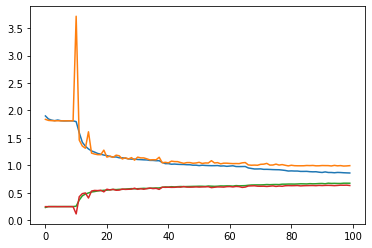

In [10]:
import pickle
pickle.dump(hist, open('featureactv32_baseline_hist.hdf5', 'wb'))

plt.plot(hist), best_acc

In [11]:
test_model = torch.load('featureactv32_baseline_model.pt')

# EVALUATE
test_model.eval()
running_valloss = 0.0
running_valacc = 0.0
for i,data in enumerate(test_loader):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = test_model(inputs)

    loss = criterion(outputs, labels)
    acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

    running_valloss += (loss.item() * inputs.size(0))
    running_valacc += acc.item()

print('- Avg. val_loss: %.3f | Avg. val_acc: %.3f' % (running_valloss / len(test_loader.dataset), running_valacc / len(test_loader.dataset)))

- Avg. val_loss: 0.965 | Avg. val_acc: 0.648


## Feature Act 2 for single output

In [5]:
class FeatureAct(nn.Module):
    def __init__(self, src_depth, reduce_factor=1):
        super(FeatureAct, self).__init__()
        
        self.src_conv = nn.Conv2d(src_depth, src_depth // reduce_factor, kernel_size=1, padding=False)
        self.target_conv = nn.Conv2d(src_depth, src_depth // reduce_factor, kernel_size=1, padding=False)
        
    def forward(self, src_x):
        
        src_features = self.src_conv(src_x)
        target_features = self.target_conv(src_x)
        
        
        cor = nn.Flatten(-2)(src_features[:, None, :, :]).permute(0,2,1,3) * nn.Flatten(-2)(target_features[:, None, :, :])
        cor = cor / torch.norm(cor)
#         print(cor.size())
        
        cor_feature = torch.cat([(src_x * cor[:, :, k].view(-1, src_features.size(-3), src_features.size(-2), src_features.size(-1))).sum(1, keepdim=True) for k in range(cor.size(2))], dim=1)
        
        x = src_x * (1 + cor_feature)
        
        return x

In [6]:
class BaselineFeatureAct(nn.Module):
    def __init__(self, embeddings=False):
        
        super(BaselineFeatureAct, self).__init__()
        
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=(2,2), stride=2)
        
        self.conv0 = nn.Conv2d(1, 32, kernel_size=(3,3), padding=1, stride=1)
        self.conv0b = nn.Conv2d(32, 32, kernel_size=(3,3), padding=1, stride=1)
        self.bn0 = nn.BatchNorm2d(32)
        self.bn0b = nn.BatchNorm2d(32)
        
        self.conv1 = nn.Conv2d(32, 64, kernel_size=(3,3), padding=1, stride=1)
        self.conv1b = nn.Conv2d(64, 64, kernel_size=(3,3), padding=1, stride=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.bn1b = nn.BatchNorm2d(64)
        
        self.conv2 = nn.Conv2d(64, 128, kernel_size=(3,3), padding=1, stride=1)
        self.conv2b = nn.Conv2d(128, 128, kernel_size=(3,3), padding=1, stride=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn2b = nn.BatchNorm2d(128)
        
        self.conv3 = nn.Conv2d(128, 256, kernel_size=(3,3), padding=1, stride=1)
        self.conv3b = nn.Conv2d(256, 256, kernel_size=(3,3), padding=1, stride=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.bn3b = nn.BatchNorm2d(256)
  
        self.fact0 = FeatureAct(32)
        self.fact1 = FeatureAct(64)
        self.fact2 = FeatureAct(128)
        self.fact3 = FeatureAct(256)
        
        if not embeddings:
            self.classifier = nn.Sequential(nn.Flatten(),
                                            nn.Linear(2304, 256), nn.BatchNorm1d(256), nn.ReLU(inplace=True),
                                            nn.Linear(256, 128), nn.BatchNorm1d(128), nn.ReLU(inplace=True),
                                            nn.Linear(128, 7), nn.BatchNorm1d(7))
        else:
            self.classifier = nn.Sequential(nn.Flatten(),
                                            nn.Linear(2304, 256), nn.BatchNorm1d(256), nn.ReLU(inplace=True),
                                            nn.Linear(256, 128), nn.BatchNorm1d(128))
        
    def forward(self, x):
        
        x = self.conv0(x)
        x = self.bn0(x)
        x = self.relu(x)
        x = self.conv0b(x)
        x = self.bn0b(x)
        x = self.relu(x)
        
        x0 = self.maxpool(x)
        x0 = self.fact0(x0)
        
        x = self.conv1(x0)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv1b(x)
        x = self.bn1b(x)
        x = self.relu(x)
        
        x1 = self.maxpool(x)
        x1 = self.fact1(x1)
        
        x = self.conv2(x1)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv2b(x)
        x = self.bn2b(x)
        x = self.relu(x)
        
        x2 = self.maxpool(x)
        x2 = self.fact2(x2)
        
        x = self.conv3(x2)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.conv3b(x)
        x = self.bn3b(x)
        x = self.relu(x)
        
        x3 = self.maxpool(x)
        x3 = self.fact3(x3)
        
        x = nn.Flatten()(x3)
        x = self.classifier(x)
        
        return x

In [7]:
device = torch.device('cuda')
model = BaselineFeatureAct().to(device)

best_acc = 0.0
hist = []

epochs=50

criterion = nn.CrossEntropyLoss()

learning_rate = 0.004
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=8, verbose=True)


In [ ]:
model_path = './featureactv2_baseline_modelv2.pt'

for epoch in range(100):  # loop over the dataset multiple times

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0
    processed = 0.0

    # TRAIN
    model.train()
    pbar = tqdm(train_loader, position=0)
    for i, data in enumerate(pbar):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()
        loss.backward()
        
        optimizer.step()

        # print statistics
        running_loss += (loss.item() * inputs.size(0))
        running_acc += acc.item()
        processed += len(inputs)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={i} Accuracy={acc.item() / inputs.size(0)}')

    print('- Avg.loss: %.3f | Avg.acc: %.3f' % (running_loss / len(train_loader.dataset), running_acc / len(train_loader.dataset)))
    avgloss = running_loss / len(train_loader.dataset)
    avgacc = running_acc / len(train_loader.dataset)

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

        running_valloss += (loss.item() * inputs.size(0))
        running_valacc += acc.item()

    print('- Avg. val_loss: %.3f | Avg. val_acc: %.3f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

    avgvalloss = running_valloss / len(val_loader.dataset)
    avgvalacc = running_valacc / len(val_loader.dataset)
    
    scheduler.step(avgvalloss)

    hist.append([avgloss, avgvalloss, avgacc, avgvalacc])
    
    if best_acc < avgvalacc:
        best_acc = avgvalacc
        torch.save(model, model_path)
        print('* Update optimal model')

print('Finished Training')

In [ ]:
plt.plot(hist)

In [8]:
model = torch.load('featureactv2_baseline_modelv2.pt')

# EVALUATE
model.eval()
running_valloss = 0.0
running_valacc = 0.0
for i,data in enumerate(val_loader):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = model(inputs)

    loss = criterion(outputs, labels)
    acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

    running_valloss += (loss.item() * inputs.size(0))
    running_valacc += acc.item()

print('- Avg. val_loss: %.3f | Avg. val_acc: %.3f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

- Avg. val_loss: 0.985 | Avg. val_acc: 0.642


## Feature Act v3 single output each block

In [5]:
class FeatureAct(nn.Module):
    def __init__(self, src_depth, reduce_factor=1):
        super(FeatureAct, self).__init__()
        
        self.softmax = nn.Softmax(dim=2)
        
        self.src_conv = nn.Conv2d(src_depth, src_depth // reduce_factor, kernel_size=1, padding=False)
        self.target_conv = nn.Conv2d(src_depth, src_depth // reduce_factor, kernel_size=1, padding=False)
        
        self.down_depth = nn.Sequential(nn.Conv2d(src_depth, src_depth // reduce_factor, kernel_size=1, padding=False),
                                        nn.ReLU(inplace=True))
        self.up_depth = nn.Sequential(nn.Conv2d(src_depth // reduce_factor, src_depth, kernel_size=1, padding=False),
                                      nn.ReLU(inplace=True))
        
    def forward(self, x):
        
        src_features = self.src_conv(x)
        target_features = self.target_conv(x)
        
        cor = nn.Flatten(-2)(src_features[:, None, :, :]).permute(0,2,1,3) * nn.Flatten(-2)(target_features[:, None, :, :])
        cor = self.softmax(cor)
        
        main_features = self.down_depth(x)
    
        cor_feature = torch.cat([(main_features * cor[:, :, k].view(-1, src_features.size(-3), src_features.size(-2), src_features.size(-1))).sum(1, keepdim=True) for k in range(cor.size(2))], dim=1)
        cor_feature = self.up_depth(cor_feature)
        
        x = x + cor_feature
        
        return x

In [6]:
class BaselineFeatureAct(nn.Module):
    def __init__(self, embeddings=False):
        
        super(BaselineFeatureAct, self).__init__()
        
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=(2,2), stride=2)
        
        self.conv0 = nn.Conv2d(1, 32, kernel_size=(3,3), padding=1, stride=1)
        self.conv0b = nn.Conv2d(32, 32, kernel_size=(3,3), padding=1, stride=1)
        self.bn0 = nn.BatchNorm2d(32)
        self.bn0b = nn.BatchNorm2d(32)
        
        self.conv1 = nn.Conv2d(32, 64, kernel_size=(3,3), padding=1, stride=1)
        self.conv1b = nn.Conv2d(64, 64, kernel_size=(3,3), padding=1, stride=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.bn1b = nn.BatchNorm2d(64)
        
        self.conv2 = nn.Conv2d(64, 128, kernel_size=(3,3), padding=1, stride=1)
        self.conv2b = nn.Conv2d(128, 128, kernel_size=(3,3), padding=1, stride=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn2b = nn.BatchNorm2d(128)
        
        self.conv3 = nn.Conv2d(128, 256, kernel_size=(3,3), padding=1, stride=1)
        self.conv3b = nn.Conv2d(256, 256, kernel_size=(3,3), padding=1, stride=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.bn3b = nn.BatchNorm2d(256)
  
        self.fact0 = FeatureAct(32, 4)
        self.fact1 = FeatureAct(64, 4)
        self.fact2 = FeatureAct(128, 4)
        self.fact3 = FeatureAct(256, 4)
        
        if not embeddings:
            self.classifier = nn.Sequential(nn.Flatten(),
                                            nn.Linear(2304, 256), nn.BatchNorm1d(256), nn.ReLU(inplace=True),
                                            nn.Linear(256, 128), nn.BatchNorm1d(128), nn.ReLU(inplace=True),
                                            nn.Linear(128, 7), nn.BatchNorm1d(7))
        else:
            self.classifier = nn.Sequential(nn.Flatten(),
                                            nn.Linear(2304, 256), nn.BatchNorm1d(256), nn.ReLU(inplace=True),
                                            nn.Linear(256, 128), nn.BatchNorm1d(128))
        
    def forward(self, x):
        
        x = self.conv0(x)
        x = self.bn0(x)
        x = self.relu(x)
        x = self.conv0b(x)
        x = self.bn0b(x)
        x = self.relu(x)
        
        x0 = self.maxpool(x)
        x0 = self.fact0(x0)
        
        x = self.conv1(x0)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv1b(x)
        x = self.bn1b(x)
        x = self.relu(x)
        
        x1 = self.maxpool(x)
        x1 = self.fact1(x1)
        
        x = self.conv2(x1)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv2b(x)
        x = self.bn2b(x)
        x = self.relu(x)
        
        x2 = self.maxpool(x)
        x2 = self.fact2(x2)
        
        x = self.conv3(x2)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.conv3b(x)
        x = self.bn3b(x)
        x = self.relu(x)
        
        x3 = self.maxpool(x)
        x3 = self.fact3(x3)
        
        x = nn.Flatten()(x3)
        x = self.classifier(x)
        
        return x

In [7]:
device = torch.device('cuda')
model = BaselineFeatureAct().to(device)

best_acc = 0.0
hist = []

epochs=50

criterion = nn.CrossEntropyLoss()

learning_rate = 0.004
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=8, verbose=True)


In [8]:
model_path = './featureactv3_baseline_modelv22.pt'

for epoch in range(100):  # loop over the dataset multiple times

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0
    processed = 0.0

    # TRAIN
    model.train()
    pbar = tqdm(train_loader, position=0)
    for i, data in enumerate(pbar):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()
        loss.backward()
        
        optimizer.step()

        # print statistics
        running_loss += (loss.item() * inputs.size(0))
        running_acc += acc.item()
        processed += len(inputs)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={i} Accuracy={acc.item() / inputs.size(0)}')

    print('- Avg.loss: %.3f | Avg.acc: %.3f' % (running_loss / len(train_loader.dataset), running_acc / len(train_loader.dataset)))
    avgloss = running_loss / len(train_loader.dataset)
    avgacc = running_acc / len(train_loader.dataset)

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

        running_valloss += (loss.item() * inputs.size(0))
        running_valacc += acc.item()

    print('- Avg. val_loss: %.3f | Avg. val_acc: %.3f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

    avgvalloss = running_valloss / len(val_loader.dataset)
    avgvalacc = running_valacc / len(val_loader.dataset)
    
    scheduler.step(avgvalloss)

    hist.append([avgloss, avgvalloss, avgacc, avgvalacc])
    
    if best_acc < avgvalacc:
        best_acc = avgvalacc
        torch.save(model, model_path)
        print('* Update optimal model')

print('Finished Training')

  0%|          | 0/225 [00:00<?, ?it/s]

Epoch:  1


Loss=1.779152274131775 Batch_id=224 Accuracy=0.2972972972972973: 100%|██████████| 225/225 [00:34<00:00,  6.52it/s]

- Avg.loss: 1.764 | Avg.acc: 0.304



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.630 | Avg. val_acc: 0.381
* Update optimal model
Epoch:  2


Loss=1.3676422834396362 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [00:34<00:00,  6.44it/s]

- Avg.loss: 1.459 | Avg.acc: 0.435



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.383 | Avg. val_acc: 0.474
* Update optimal model
Epoch:  3


Loss=1.3056087493896484 Batch_id=224 Accuracy=0.4594594594594595: 100%|██████████| 225/225 [00:34<00:00,  6.43it/s]

- Avg.loss: 1.323 | Avg.acc: 0.498



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.331 | Avg. val_acc: 0.484
* Update optimal model
Epoch:  4


Loss=1.4954029321670532 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [00:34<00:00,  6.46it/s]

- Avg.loss: 1.262 | Avg.acc: 0.518



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.276 | Avg. val_acc: 0.507
* Update optimal model
Epoch:  5


Loss=1.3248682022094727 Batch_id=224 Accuracy=0.43243243243243246: 100%|██████████| 225/225 [00:35<00:00,  6.42it/s]

- Avg.loss: 1.224 | Avg.acc: 0.532



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.335 | Avg. val_acc: 0.510
* Update optimal model
Epoch:  6


Loss=1.2525039911270142 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [00:34<00:00,  6.44it/s]

- Avg.loss: 1.201 | Avg.acc: 0.545



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.198 | Avg. val_acc: 0.534
* Update optimal model
Epoch:  7


Loss=1.0826128721237183 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:34<00:00,  6.44it/s]

- Avg.loss: 1.179 | Avg.acc: 0.550



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.215 | Avg. val_acc: 0.542
* Update optimal model
Epoch:  8


Loss=1.5815746784210205 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [00:35<00:00,  6.42it/s]

- Avg.loss: 1.161 | Avg.acc: 0.558



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.251 | Avg. val_acc: 0.514
Epoch:  9


Loss=1.4843043088912964 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [00:34<00:00,  6.45it/s]

- Avg.loss: 1.148 | Avg.acc: 0.564



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.171 | Avg. val_acc: 0.543
* Update optimal model
Epoch:  10


Loss=1.2526094913482666 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [00:34<00:00,  6.45it/s]

- Avg.loss: 1.143 | Avg.acc: 0.565



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.194 | Avg. val_acc: 0.555
* Update optimal model
Epoch:  11


Loss=0.8790645003318787 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:35<00:00,  6.41it/s]

- Avg.loss: 1.131 | Avg.acc: 0.571



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.247 | Avg. val_acc: 0.522
Epoch:  12


Loss=1.279060959815979 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [00:34<00:00,  6.46it/s]

- Avg.loss: 1.120 | Avg.acc: 0.572



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.180 | Avg. val_acc: 0.558
* Update optimal model
Epoch:  13


Loss=1.0781614780426025 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:35<00:00,  6.39it/s]

- Avg.loss: 1.114 | Avg.acc: 0.576



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.151 | Avg. val_acc: 0.568
* Update optimal model
Epoch:  14


Loss=0.9781970381736755 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:34<00:00,  6.46it/s]

- Avg.loss: 1.104 | Avg.acc: 0.581



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.155 | Avg. val_acc: 0.568
* Update optimal model
Epoch:  15


Loss=1.1949692964553833 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:34<00:00,  6.44it/s]

- Avg.loss: 1.109 | Avg.acc: 0.580



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.148 | Avg. val_acc: 0.573
* Update optimal model
Epoch:  16


Loss=0.8765094876289368 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:34<00:00,  6.46it/s]

- Avg.loss: 1.095 | Avg.acc: 0.584



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.115 | Avg. val_acc: 0.583
* Update optimal model
Epoch:  17


Loss=1.376174807548523 Batch_id=224 Accuracy=0.4594594594594595: 100%|██████████| 225/225 [00:34<00:00,  6.46it/s]

- Avg.loss: 1.094 | Avg.acc: 0.586



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.107 | Avg. val_acc: 0.586
* Update optimal model
Epoch:  18


Loss=0.8783972263336182 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:34<00:00,  6.43it/s]

- Avg.loss: 1.086 | Avg.acc: 0.591



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.160 | Avg. val_acc: 0.561
Epoch:  19


Loss=1.120392084121704 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:34<00:00,  6.44it/s]

- Avg.loss: 1.086 | Avg.acc: 0.588



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.147 | Avg. val_acc: 0.565
Epoch:  20


Loss=0.9501178860664368 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:34<00:00,  6.49it/s]

- Avg.loss: 1.078 | Avg.acc: 0.588



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.126 | Avg. val_acc: 0.571
Epoch:  21


Loss=0.9058569669723511 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:35<00:00,  6.42it/s]

- Avg.loss: 1.075 | Avg.acc: 0.592



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.076 | Avg. val_acc: 0.598
* Update optimal model
Epoch:  22


Loss=1.0476959943771362 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:34<00:00,  6.47it/s]

- Avg.loss: 1.069 | Avg.acc: 0.597



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.088 | Avg. val_acc: 0.593
Epoch:  23


Loss=1.110134482383728 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:34<00:00,  6.46it/s]

- Avg.loss: 1.060 | Avg.acc: 0.598



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.152 | Avg. val_acc: 0.570
Epoch:  24


Loss=1.290402889251709 Batch_id=224 Accuracy=0.4594594594594595: 100%|██████████| 225/225 [00:34<00:00,  6.47it/s]

- Avg.loss: 1.065 | Avg.acc: 0.596



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.053 | Avg. val_acc: 0.602
* Update optimal model
Epoch:  25


Loss=0.8405917882919312 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:34<00:00,  6.46it/s]

- Avg.loss: 1.051 | Avg.acc: 0.598



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.092 | Avg. val_acc: 0.585
Epoch:  26


Loss=1.1656811237335205 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [00:34<00:00,  6.46it/s]

- Avg.loss: 1.054 | Avg.acc: 0.601



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.062 | Avg. val_acc: 0.607
* Update optimal model
Epoch:  27


Loss=1.0751254558563232 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:34<00:00,  6.44it/s]

- Avg.loss: 1.051 | Avg.acc: 0.603



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.083 | Avg. val_acc: 0.598
Epoch:  28


Loss=1.0387123823165894 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:35<00:00,  6.43it/s]

- Avg.loss: 1.046 | Avg.acc: 0.605



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.039 | Avg. val_acc: 0.611
* Update optimal model
Epoch:  29


Loss=0.9779871106147766 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:34<00:00,  6.45it/s]

- Avg.loss: 1.039 | Avg.acc: 0.605



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.092 | Avg. val_acc: 0.593
Epoch:  30


Loss=1.0619816780090332 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:34<00:00,  6.43it/s]

- Avg.loss: 1.042 | Avg.acc: 0.606



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.070 | Avg. val_acc: 0.593
Epoch:  31


Loss=0.9560320973396301 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:34<00:00,  6.45it/s]

- Avg.loss: 1.032 | Avg.acc: 0.611



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.066 | Avg. val_acc: 0.598
Epoch:  32


Loss=0.8935701251029968 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:34<00:00,  6.49it/s]

- Avg.loss: 1.035 | Avg.acc: 0.609



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.070 | Avg. val_acc: 0.600
Epoch:  33


Loss=1.2317897081375122 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:34<00:00,  6.45it/s]

- Avg.loss: 1.029 | Avg.acc: 0.611



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.076 | Avg. val_acc: 0.602
Epoch:  34


Loss=0.9764496088027954 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:35<00:00,  6.41it/s]

- Avg.loss: 1.022 | Avg.acc: 0.611



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.085 | Avg. val_acc: 0.602
Epoch:  35


Loss=1.0918452739715576 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:34<00:00,  6.48it/s]

- Avg.loss: 1.026 | Avg.acc: 0.614



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.037 | Avg. val_acc: 0.615
* Update optimal model
Epoch:  36


Loss=1.5327304601669312 Batch_id=224 Accuracy=0.35135135135135137: 100%|██████████| 225/225 [00:34<00:00,  6.49it/s]

- Avg.loss: 1.023 | Avg.acc: 0.613



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.107 | Avg. val_acc: 0.588
Epoch:  37


Loss=0.9659604430198669 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:35<00:00,  6.42it/s]

- Avg.loss: 1.021 | Avg.acc: 0.614



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.070 | Avg. val_acc: 0.597
Epoch:  38


Loss=1.22928786277771 Batch_id=224 Accuracy=0.43243243243243246: 100%|██████████| 225/225 [00:34<00:00,  6.43it/s]

- Avg.loss: 1.014 | Avg.acc: 0.610



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.060 | Avg. val_acc: 0.605
Epoch:  39


Loss=1.0084431171417236 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:34<00:00,  6.51it/s]

- Avg.loss: 1.017 | Avg.acc: 0.615



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.041 | Avg. val_acc: 0.605
Epoch:  40


Loss=0.9687918424606323 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:35<00:00,  6.40it/s]

- Avg.loss: 1.015 | Avg.acc: 0.617



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.060 | Avg. val_acc: 0.615
* Update optimal model
Epoch:  41


Loss=1.214420199394226 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:34<00:00,  6.44it/s]

- Avg.loss: 1.011 | Avg.acc: 0.617



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.114 | Avg. val_acc: 0.582
Epoch:  42


Loss=0.9921393394470215 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:35<00:00,  6.43it/s]

- Avg.loss: 1.011 | Avg.acc: 0.618



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.068 | Avg. val_acc: 0.589
Epoch:  43


Loss=1.2310439348220825 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:34<00:00,  6.45it/s]

- Avg.loss: 1.009 | Avg.acc: 0.617



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.058 | Avg. val_acc: 0.605
Epoch:  44


Loss=1.0117510557174683 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:35<00:00,  6.42it/s]

- Avg.loss: 1.009 | Avg.acc: 0.618



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.035 | Avg. val_acc: 0.620
* Update optimal model
Epoch:  45


Loss=1.2156860828399658 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [00:34<00:00,  6.47it/s]

- Avg.loss: 1.005 | Avg.acc: 0.620



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.034 | Avg. val_acc: 0.612
Epoch:  46


Loss=1.2584046125411987 Batch_id=224 Accuracy=0.4594594594594595: 100%|██████████| 225/225 [00:34<00:00,  6.47it/s]

- Avg.loss: 1.006 | Avg.acc: 0.623



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.032 | Avg. val_acc: 0.615
Epoch:  47


Loss=0.999738872051239 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:34<00:00,  6.44it/s]

- Avg.loss: 1.000 | Avg.acc: 0.621



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.047 | Avg. val_acc: 0.615
Epoch:  48


Loss=0.8815443515777588 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:34<00:00,  6.46it/s]

- Avg.loss: 1.000 | Avg.acc: 0.624



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.028 | Avg. val_acc: 0.610
Epoch:  49


Loss=1.0317538976669312 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:34<00:00,  6.48it/s]

- Avg.loss: 0.995 | Avg.acc: 0.623



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.014 | Avg. val_acc: 0.618
Epoch:  50


Loss=1.3046317100524902 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [00:35<00:00,  6.43it/s]

- Avg.loss: 1.003 | Avg.acc: 0.622



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.031 | Avg. val_acc: 0.612
Epoch:  51


Loss=1.044904351234436 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:34<00:00,  6.45it/s]

- Avg.loss: 0.995 | Avg.acc: 0.623



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.093 | Avg. val_acc: 0.593
Epoch:  52


Loss=0.8522042632102966 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:34<00:00,  6.43it/s]

- Avg.loss: 0.997 | Avg.acc: 0.621



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.082 | Avg. val_acc: 0.593
Epoch:  53


Loss=0.9902773499488831 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:35<00:00,  6.43it/s]

- Avg.loss: 0.997 | Avg.acc: 0.622



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.035 | Avg. val_acc: 0.608
Epoch:  54


Loss=0.875771164894104 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:34<00:00,  6.50it/s]

- Avg.loss: 0.993 | Avg.acc: 0.624



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.069 | Avg. val_acc: 0.596
Epoch:  55


Loss=1.0851147174835205 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:34<00:00,  6.47it/s]

- Avg.loss: 0.991 | Avg.acc: 0.625



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.046 | Avg. val_acc: 0.602
Epoch:  56


Loss=0.9074398875236511 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:35<00:00,  6.43it/s]

- Avg.loss: 0.992 | Avg.acc: 0.625



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.034 | Avg. val_acc: 0.608
Epoch:  57


Loss=0.9175413250923157 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:35<00:00,  6.42it/s]

- Avg.loss: 0.990 | Avg.acc: 0.628



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.072 | Avg. val_acc: 0.597
Epoch:  58


Loss=1.0841829776763916 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:35<00:00,  6.43it/s]

- Avg.loss: 0.990 | Avg.acc: 0.627



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.037 | Avg. val_acc: 0.607
Epoch    58: reducing learning rate of group 0 to 2.0000e-03.
Epoch:  59


Loss=1.1318914890289307 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:34<00:00,  6.49it/s]

- Avg.loss: 0.938 | Avg.acc: 0.645



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.997 | Avg. val_acc: 0.627
* Update optimal model
Epoch:  60


Loss=1.0874714851379395 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:34<00:00,  6.48it/s]

- Avg.loss: 0.926 | Avg.acc: 0.651



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.982 | Avg. val_acc: 0.631
* Update optimal model
Epoch:  61


Loss=1.1418598890304565 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:35<00:00,  6.42it/s]

- Avg.loss: 0.916 | Avg.acc: 0.654



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.988 | Avg. val_acc: 0.629
Epoch:  62


Loss=0.9505335092544556 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:34<00:00,  6.46it/s]

- Avg.loss: 0.912 | Avg.acc: 0.657



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.997 | Avg. val_acc: 0.632
* Update optimal model
Epoch:  63


Loss=0.901347815990448 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:35<00:00,  6.41it/s]

- Avg.loss: 0.910 | Avg.acc: 0.661



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.971 | Avg. val_acc: 0.641
* Update optimal model
Epoch:  64


Loss=0.9511228799819946 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:34<00:00,  6.45it/s]

- Avg.loss: 0.908 | Avg.acc: 0.658



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.000 | Avg. val_acc: 0.632
Epoch:  65


Loss=0.8148300051689148 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:35<00:00,  6.42it/s]

- Avg.loss: 0.905 | Avg.acc: 0.660



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.979 | Avg. val_acc: 0.642
* Update optimal model
Epoch:  66


Loss=0.9968587756156921 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:35<00:00,  6.42it/s]

- Avg.loss: 0.903 | Avg.acc: 0.661



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.992 | Avg. val_acc: 0.633
Epoch:  67


Loss=0.903413712978363 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:34<00:00,  6.46it/s]

- Avg.loss: 0.899 | Avg.acc: 0.662



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.993 | Avg. val_acc: 0.639
Epoch:  68


Loss=0.6917117834091187 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:35<00:00,  6.41it/s]

- Avg.loss: 0.896 | Avg.acc: 0.663



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.990 | Avg. val_acc: 0.634
Epoch:  69


Loss=1.2470860481262207 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:34<00:00,  6.45it/s]

- Avg.loss: 0.894 | Avg.acc: 0.666



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.981 | Avg. val_acc: 0.629
Epoch:  70


Loss=0.7831239700317383 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:34<00:00,  6.48it/s]

- Avg.loss: 0.895 | Avg.acc: 0.663



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.980 | Avg. val_acc: 0.635
Epoch:  71


Loss=0.9304545521736145 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:35<00:00,  6.43it/s]

- Avg.loss: 0.890 | Avg.acc: 0.662



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.018 | Avg. val_acc: 0.628
Epoch:  72


Loss=0.7959963083267212 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:34<00:00,  6.50it/s]

- Avg.loss: 0.886 | Avg.acc: 0.666



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.994 | Avg. val_acc: 0.638
Epoch    72: reducing learning rate of group 0 to 1.0000e-03.
Epoch:  73


Loss=0.9056268930435181 Batch_id=51 Accuracy=0.6640625:  23%|██▎       | 52/225 [00:09<00:25,  6.81it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Loss=0.8237711787223816 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:34<00:00,  6.47it/s]

- Avg.loss: 0.740 | Avg.acc: 0.725



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.973 | Avg. val_acc: 0.653
Epoch:  92


Loss=0.6819075345993042 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:34<00:00,  6.44it/s]

- Avg.loss: 0.740 | Avg.acc: 0.724



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.968 | Avg. val_acc: 0.649
Epoch:  93


Loss=0.8117765784263611 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:34<00:00,  6.50it/s]

- Avg.loss: 0.733 | Avg.acc: 0.727



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.970 | Avg. val_acc: 0.654
* Update optimal model
Epoch:  94


Loss=0.8311153650283813 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:34<00:00,  6.46it/s]

- Avg.loss: 0.723 | Avg.acc: 0.733



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.968 | Avg. val_acc: 0.661
Epoch    94: reducing learning rate of group 0 to 2.5000e-04.
* Update optimal model
Epoch:  95


Loss=0.7877618670463562 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:34<00:00,  6.45it/s]

- Avg.loss: 0.720 | Avg.acc: 0.731



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.970 | Avg. val_acc: 0.652
Epoch:  96


Loss=0.7658479809761047 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:34<00:00,  6.45it/s]

- Avg.loss: 0.711 | Avg.acc: 0.734



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.979 | Avg. val_acc: 0.652
Epoch:  97


Loss=0.6427346467971802 Batch_id=172 Accuracy=0.796875:  76%|███████▋  | 172/225 [00:27<00:07,  6.74it/s] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



([<matplotlib.lines.Line2D at 0x7fba20587588>,
 0.6609083310114238)

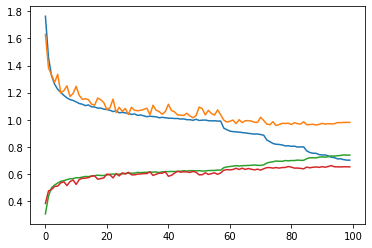

In [9]:
plt.plot(hist), best_acc

In [10]:
test_model = torch.load('./featureactv3_baseline_modelv22.pt')

# EVALUATE
test_model.eval()
running_valloss = 0.0
running_valacc = 0.0
for i,data in enumerate(test_loader):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = test_model(inputs)

    loss = criterion(outputs, labels)
    acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

    running_valloss += (loss.item() * inputs.size(0))
    running_valacc += acc.item()

print('- Avg. val_loss: %.3f | Avg. val_acc: %.3f' % (running_valloss / len(test_loader.dataset), running_valacc / len(test_loader.dataset)))

- Avg. val_loss: 0.944 | Avg. val_acc: 0.656


In [ ]:
pickle.dump(hist, open('featureactv3_baseline_modelv22_hist.hdf5', 'wb'))

## Feature Act v3.2 single output each block (include dim 1 and dim 2 of cor faeture)

In [5]:
class FeatureAct(nn.Module):
    def __init__(self, src_depth, reduce_factor=1):
        super(FeatureAct, self).__init__()
        
        self.softmax_d2 = nn.Softmax(dim=2)
        self.softmax_d1 = nn.Softmax(dim=1)
        
        self.src_conv = nn.Conv2d(src_depth, src_depth // reduce_factor, kernel_size=1, padding=False)
        self.target_conv = nn.Conv2d(src_depth, src_depth // reduce_factor, kernel_size=1, padding=False)
        
        self.down_depth = nn.Sequential(nn.Conv2d(src_depth, src_depth // reduce_factor, kernel_size=1, padding=False),
                                        nn.ReLU(inplace=True))
        self.up_depth = nn.Sequential(nn.Conv2d(src_depth // reduce_factor, src_depth, kernel_size=1, padding=False),
                                      nn.ReLU(inplace=True))
        
    def forward(self, x):
        
        src_features = self.src_conv(x)
        target_features = self.target_conv(x)
        
        cor = nn.Flatten(-2)(src_features[:, None, :, :]).permute(0,2,1,3) * nn.Flatten(-2)(target_features[:, None, :, :])
        cor_d2 = self.softmax_d2(cor)
        
        main_features = self.down_depth(x)
        
        # d2
        cor_feature_d2 = torch.cat([(main_features * cor_d2[:, :, k].view(-1, src_features.size(-3), src_features.size(-2), src_features.size(-1))).sum(1, keepdim=True) for k in range(cor_d2.size(2))], dim=1)
        
        # d1
        cor_d1 = self.softmax_d1(cor)
        cor_feature_d1 = torch.cat([(main_features * cor_d1[:, k, :].view(-1, src_features.size(-3), src_features.size(-2), src_features.size(-1))).sum(1, keepdim=True) for k in range(cor_d1.size(1))], dim=1)
        
        cor_feature = cor_feature_d2 + cor_feature_d1
        cor_feature = self.up_depth(cor_feature)
        
        x = x + cor_feature
        
        return x

In [6]:
class BaselineFeatureAct(nn.Module):
    def __init__(self, embeddings=False):
        
        super(BaselineFeatureAct, self).__init__()
        
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=(2,2), stride=2)
        
        self.conv0 = nn.Conv2d(1, 32, kernel_size=(3,3), padding=1, stride=1)
        self.conv0b = nn.Conv2d(32, 32, kernel_size=(3,3), padding=1, stride=1)
        self.bn0 = nn.BatchNorm2d(32)
        self.bn0b = nn.BatchNorm2d(32)
        
        self.conv1 = nn.Conv2d(32, 64, kernel_size=(3,3), padding=1, stride=1)
        self.conv1b = nn.Conv2d(64, 64, kernel_size=(3,3), padding=1, stride=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.bn1b = nn.BatchNorm2d(64)
        
        self.conv2 = nn.Conv2d(64, 128, kernel_size=(3,3), padding=1, stride=1)
        self.conv2b = nn.Conv2d(128, 128, kernel_size=(3,3), padding=1, stride=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn2b = nn.BatchNorm2d(128)
        
        self.conv3 = nn.Conv2d(128, 256, kernel_size=(3,3), padding=1, stride=1)
        self.conv3b = nn.Conv2d(256, 256, kernel_size=(3,3), padding=1, stride=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.bn3b = nn.BatchNorm2d(256)
  
        self.fact0 = FeatureAct(32, 4)
        self.fact1 = FeatureAct(64, 4)
        self.fact2 = FeatureAct(128, 4)
        self.fact3 = FeatureAct(256, 4)
        
        if not embeddings:
            self.classifier = nn.Sequential(nn.Flatten(),
                                            nn.Linear(2304, 256), nn.BatchNorm1d(256), nn.ReLU(inplace=True),
                                            nn.Linear(256, 128), nn.BatchNorm1d(128), nn.ReLU(inplace=True),
                                            nn.Linear(128, 7), nn.BatchNorm1d(7))
        else:
            self.classifier = nn.Sequential(nn.Flatten(),
                                            nn.Linear(2304, 256), nn.BatchNorm1d(256), nn.ReLU(inplace=True),
                                            nn.Linear(256, 128), nn.BatchNorm1d(128))
        
    def forward(self, x):
        
        x = self.conv0(x)
        x = self.bn0(x)
        x = self.relu(x)
        x = self.conv0b(x)
        x = self.bn0b(x)
        x = self.relu(x)
        
        x0 = self.maxpool(x)
        x0 = self.fact0(x0)
        
        x = self.conv1(x0)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv1b(x)
        x = self.bn1b(x)
        x = self.relu(x)
        
        x1 = self.maxpool(x)
        x1 = self.fact1(x1)
        
        x = self.conv2(x1)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv2b(x)
        x = self.bn2b(x)
        x = self.relu(x)
        
        x2 = self.maxpool(x)
        x2 = self.fact2(x2)
        
        x = self.conv3(x2)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.conv3b(x)
        x = self.bn3b(x)
        x = self.relu(x)
        
        x3 = self.maxpool(x)
        x3 = self.fact3(x3)
        
        x = nn.Flatten()(x3)
        x = self.classifier(x)
        
        return x

In [8]:
device = torch.device('cuda')
model = BaselineFeatureAct().to(device)

best_acc = 0.0
hist = []

epochs=100

criterion = nn.CrossEntropyLoss()

learning_rate = 0.004
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=7, verbose=True)


In [9]:
model_path = './featureactv32_baseline_modelv22.pt'

for epoch in range(100):  # loop over the dataset multiple times

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0
    processed = 0.0

    # TRAIN
    model.train()
    pbar = tqdm(train_loader, position=0)
    for i, data in enumerate(pbar):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()
        loss.backward()
        
        optimizer.step()

        # print statistics
        running_loss += (loss.item() * inputs.size(0))
        running_acc += acc.item()
        processed += len(inputs)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={i} Accuracy={acc.item() / inputs.size(0)}')

    print('- Avg.loss: %.3f | Avg.acc: %.3f' % (running_loss / len(train_loader.dataset), running_acc / len(train_loader.dataset)))
    avgloss = running_loss / len(train_loader.dataset)
    avgacc = running_acc / len(train_loader.dataset)

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

        running_valloss += (loss.item() * inputs.size(0))
        running_valacc += acc.item()

    print('- Avg. val_loss: %.3f | Avg. val_acc: %.3f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

    avgvalloss = running_valloss / len(val_loader.dataset)
    avgvalacc = running_valacc / len(val_loader.dataset)
    
    scheduler.step(avgvalloss)

    hist.append([avgloss, avgvalloss, avgacc, avgvalacc])
    
    if best_acc < avgvalacc:
        best_acc = avgvalacc
        torch.save(model, model_path)
        print('* Update optimal model')

print('Finished Training')

  0%|          | 0/225 [00:00<?, ?it/s]

Epoch:  1


Loss=1.357377052307129 Batch_id=224 Accuracy=0.40540540540540543: 100%|██████████| 225/225 [00:50<00:00,  4.43it/s]

- Avg.loss: 1.630 | Avg.acc: 0.373



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.443 | Avg. val_acc: 0.459
* Update optimal model
Epoch:  2


Loss=1.242159128189087 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [00:50<00:00,  4.43it/s]

- Avg.loss: 1.373 | Avg.acc: 0.474



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.299 | Avg. val_acc: 0.505
* Update optimal model
Epoch:  3


Loss=1.2828823328018188 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [00:50<00:00,  4.42it/s]

- Avg.loss: 1.281 | Avg.acc: 0.511



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.299 | Avg. val_acc: 0.485
Epoch:  4


Loss=1.4926986694335938 Batch_id=224 Accuracy=0.43243243243243246: 100%|██████████| 225/225 [00:50<00:00,  4.42it/s]

- Avg.loss: 1.234 | Avg.acc: 0.530



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.172 | Avg. val_acc: 0.551
* Update optimal model
Epoch:  5


Loss=1.2433257102966309 Batch_id=224 Accuracy=0.43243243243243246: 100%|██████████| 225/225 [00:51<00:00,  4.41it/s]

- Avg.loss: 1.206 | Avg.acc: 0.541



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.158 | Avg. val_acc: 0.560
* Update optimal model
Epoch:  6


Loss=1.2969988584518433 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [00:50<00:00,  4.43it/s]

- Avg.loss: 1.176 | Avg.acc: 0.550



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.268 | Avg. val_acc: 0.527
Epoch:  7


Loss=1.1292505264282227 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:50<00:00,  4.43it/s]

- Avg.loss: 1.155 | Avg.acc: 0.560



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.218 | Avg. val_acc: 0.539
Epoch:  8


Loss=1.2485848665237427 Batch_id=224 Accuracy=0.43243243243243246: 100%|██████████| 225/225 [00:50<00:00,  4.42it/s]

- Avg.loss: 1.144 | Avg.acc: 0.565



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.225 | Avg. val_acc: 0.531
Epoch:  9


Loss=1.1470904350280762 Batch_id=224 Accuracy=0.4594594594594595: 100%|██████████| 225/225 [00:50<00:00,  4.43it/s]

- Avg.loss: 1.133 | Avg.acc: 0.570



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.222 | Avg. val_acc: 0.527
Epoch:  10


Loss=1.4908833503723145 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [00:50<00:00,  4.45it/s]

- Avg.loss: 1.124 | Avg.acc: 0.574



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.142 | Avg. val_acc: 0.568
* Update optimal model
Epoch:  11


Loss=1.215781331062317 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [00:50<00:00,  4.45it/s]

- Avg.loss: 1.116 | Avg.acc: 0.578



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.197 | Avg. val_acc: 0.541
Epoch:  12


Loss=1.6040529012680054 Batch_id=224 Accuracy=0.43243243243243246: 100%|██████████| 225/225 [00:50<00:00,  4.44it/s]

- Avg.loss: 1.110 | Avg.acc: 0.579



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.101 | Avg. val_acc: 0.585
* Update optimal model
Epoch:  13


Loss=1.0217868089675903 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:50<00:00,  4.42it/s]

- Avg.loss: 1.104 | Avg.acc: 0.583



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.124 | Avg. val_acc: 0.574
Epoch:  14


Loss=0.9089885354042053 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:50<00:00,  4.42it/s]

- Avg.loss: 1.097 | Avg.acc: 0.584



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.151 | Avg. val_acc: 0.566
Epoch:  15


Loss=1.111647129058838 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [00:50<00:00,  4.43it/s]

- Avg.loss: 1.091 | Avg.acc: 0.587



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.178 | Avg. val_acc: 0.549
Epoch:  16


Loss=1.0306901931762695 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:50<00:00,  4.42it/s]

- Avg.loss: 1.087 | Avg.acc: 0.589



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.109 | Avg. val_acc: 0.581
Epoch:  17


Loss=1.1683168411254883 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [00:50<00:00,  4.45it/s]

- Avg.loss: 1.083 | Avg.acc: 0.588



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.131 | Avg. val_acc: 0.566
Epoch:  18


Loss=1.3367087841033936 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [00:50<00:00,  4.43it/s]

- Avg.loss: 1.074 | Avg.acc: 0.590



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.117 | Avg. val_acc: 0.579
Epoch:  19


Loss=1.197973370552063 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [00:50<00:00,  4.45it/s]

- Avg.loss: 1.071 | Avg.acc: 0.597



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.091 | Avg. val_acc: 0.590
* Update optimal model
Epoch:  20


Loss=0.981279730796814 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:51<00:00,  4.40it/s]

- Avg.loss: 1.071 | Avg.acc: 0.594



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.131 | Avg. val_acc: 0.581
Epoch:  21


Loss=0.9598104357719421 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:50<00:00,  4.43it/s]

- Avg.loss: 1.066 | Avg.acc: 0.594



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.075 | Avg. val_acc: 0.595
* Update optimal model
Epoch:  22


Loss=0.8879939913749695 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:50<00:00,  4.42it/s]

- Avg.loss: 1.058 | Avg.acc: 0.600



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.085 | Avg. val_acc: 0.595
Epoch:  23


Loss=1.449485421180725 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:50<00:00,  4.42it/s]

- Avg.loss: 1.052 | Avg.acc: 0.603



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.130 | Avg. val_acc: 0.577
Epoch:  24


Loss=1.3719573020935059 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:50<00:00,  4.45it/s]

- Avg.loss: 1.053 | Avg.acc: 0.600



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.062 | Avg. val_acc: 0.601
* Update optimal model
Epoch:  25


Loss=1.7149220705032349 Batch_id=224 Accuracy=0.35135135135135137: 100%|██████████| 225/225 [00:50<00:00,  4.42it/s]

- Avg.loss: 1.047 | Avg.acc: 0.604



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.088 | Avg. val_acc: 0.599
Epoch:  26


Loss=1.1240923404693604 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:50<00:00,  4.42it/s]

- Avg.loss: 1.050 | Avg.acc: 0.603



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.054 | Avg. val_acc: 0.601
Epoch:  27


Loss=0.986546516418457 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:50<00:00,  4.44it/s]

- Avg.loss: 1.040 | Avg.acc: 0.604



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.154 | Avg. val_acc: 0.573
Epoch:  28


Loss=1.2458875179290771 Batch_id=224 Accuracy=0.4594594594594595: 100%|██████████| 225/225 [00:50<00:00,  4.43it/s]

- Avg.loss: 1.044 | Avg.acc: 0.605



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.080 | Avg. val_acc: 0.592
Epoch:  29


Loss=0.8312303423881531 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:50<00:00,  4.43it/s]

- Avg.loss: 1.037 | Avg.acc: 0.607



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.057 | Avg. val_acc: 0.607
* Update optimal model
Epoch:  30


Loss=1.0202982425689697 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:50<00:00,  4.43it/s]

- Avg.loss: 1.036 | Avg.acc: 0.610



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.046 | Avg. val_acc: 0.607
* Update optimal model
Epoch:  31


Loss=1.183939814567566 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:50<00:00,  4.45it/s]

- Avg.loss: 1.036 | Avg.acc: 0.608



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.047 | Avg. val_acc: 0.602
Epoch:  32


Loss=0.8921823501586914 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:50<00:00,  4.42it/s]

- Avg.loss: 1.028 | Avg.acc: 0.611



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.066 | Avg. val_acc: 0.599
Epoch:  33


Loss=0.9586177468299866 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:50<00:00,  4.41it/s]

- Avg.loss: 1.030 | Avg.acc: 0.609



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.091 | Avg. val_acc: 0.592
Epoch:  34


Loss=1.2415516376495361 Batch_id=224 Accuracy=0.4594594594594595: 100%|██████████| 225/225 [00:50<00:00,  4.44it/s]

- Avg.loss: 1.029 | Avg.acc: 0.611



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.059 | Avg. val_acc: 0.606
Epoch:  35


Loss=1.00196373462677 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:51<00:00,  4.41it/s]

- Avg.loss: 1.032 | Avg.acc: 0.609



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.119 | Avg. val_acc: 0.581
Epoch:  36


Loss=0.900382399559021 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:51<00:00,  4.41it/s]

- Avg.loss: 1.025 | Avg.acc: 0.615



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.050 | Avg. val_acc: 0.601
Epoch:  37


Loss=0.8039258718490601 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [00:50<00:00,  4.42it/s]

- Avg.loss: 1.019 | Avg.acc: 0.613



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.053 | Avg. val_acc: 0.604
Epoch:  38


Loss=1.2871901988983154 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:50<00:00,  4.45it/s]

- Avg.loss: 1.018 | Avg.acc: 0.614



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.061 | Avg. val_acc: 0.598
Epoch    38: reducing learning rate of group 0 to 2.0000e-03.
Epoch:  39


Loss=1.0022605657577515 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:51<00:00,  4.39it/s]

- Avg.loss: 0.966 | Avg.acc: 0.634



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.997 | Avg. val_acc: 0.626
* Update optimal model
Epoch:  40


Loss=1.0073096752166748 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:50<00:00,  4.42it/s]

- Avg.loss: 0.948 | Avg.acc: 0.642



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.008 | Avg. val_acc: 0.621
Epoch:  41


Loss=0.9310968518257141 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:50<00:00,  4.44it/s]

- Avg.loss: 0.939 | Avg.acc: 0.647



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.017 | Avg. val_acc: 0.618
Epoch:  42


Loss=1.008060097694397 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:50<00:00,  4.44it/s]

- Avg.loss: 0.941 | Avg.acc: 0.645



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.012 | Avg. val_acc: 0.619
Epoch:  43


Loss=1.162908673286438 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [00:51<00:00,  4.41it/s]

- Avg.loss: 0.935 | Avg.acc: 0.649



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.019 | Avg. val_acc: 0.619
Epoch:  44


Loss=1.2514312267303467 Batch_id=224 Accuracy=0.43243243243243246: 100%|██████████| 225/225 [00:51<00:00,  4.41it/s]

- Avg.loss: 0.924 | Avg.acc: 0.655



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.024 | Avg. val_acc: 0.615
Epoch:  45


Loss=1.0060911178588867 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:50<00:00,  4.43it/s]

- Avg.loss: 0.929 | Avg.acc: 0.651



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.044 | Avg. val_acc: 0.607
Epoch:  46


Loss=0.8939481973648071 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:50<00:00,  4.42it/s]

- Avg.loss: 0.924 | Avg.acc: 0.653



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.982 | Avg. val_acc: 0.628
* Update optimal model
Epoch:  47


Loss=0.8245935440063477 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:50<00:00,  4.42it/s]

- Avg.loss: 0.915 | Avg.acc: 0.656



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.031 | Avg. val_acc: 0.624
Epoch:  48


Loss=1.087717056274414 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:50<00:00,  4.44it/s]

- Avg.loss: 0.921 | Avg.acc: 0.653



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.996 | Avg. val_acc: 0.631
* Update optimal model
Epoch:  49


Loss=0.9682084918022156 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:50<00:00,  4.42it/s]

- Avg.loss: 0.915 | Avg.acc: 0.656



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.017 | Avg. val_acc: 0.630
Epoch:  50


Loss=0.8751723766326904 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:50<00:00,  4.43it/s]

- Avg.loss: 0.912 | Avg.acc: 0.658



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.024 | Avg. val_acc: 0.623
Epoch:  51


Loss=1.0456382036209106 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:50<00:00,  4.42it/s]

- Avg.loss: 0.904 | Avg.acc: 0.662



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.034 | Avg. val_acc: 0.609
Epoch:  52


Loss=1.0472434759140015 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:50<00:00,  4.42it/s]

- Avg.loss: 0.905 | Avg.acc: 0.658



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.020 | Avg. val_acc: 0.619
Epoch:  53


Loss=0.7890232801437378 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:51<00:00,  4.41it/s]

- Avg.loss: 0.904 | Avg.acc: 0.662



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.013 | Avg. val_acc: 0.623
Epoch:  54


Loss=0.8143564462661743 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:50<00:00,  4.43it/s]

- Avg.loss: 0.903 | Avg.acc: 0.658



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.048 | Avg. val_acc: 0.612
Epoch    54: reducing learning rate of group 0 to 1.0000e-03.
Epoch:  55


Loss=0.8574941754341125 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:50<00:00,  4.42it/s]

- Avg.loss: 0.856 | Avg.acc: 0.680



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.973 | Avg. val_acc: 0.634
* Update optimal model
Epoch:  56


Loss=0.9272764921188354 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:50<00:00,  4.45it/s]

- Avg.loss: 0.842 | Avg.acc: 0.687



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.970 | Avg. val_acc: 0.648
* Update optimal model
Epoch:  57


Loss=0.7675268054008484 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:50<00:00,  4.43it/s]

- Avg.loss: 0.837 | Avg.acc: 0.688



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.988 | Avg. val_acc: 0.629
Epoch:  58


Loss=0.6824718117713928 Batch_id=224 Accuracy=0.8108108108108109: 100%|██████████| 225/225 [00:50<00:00,  4.42it/s]

- Avg.loss: 0.834 | Avg.acc: 0.688



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.005 | Avg. val_acc: 0.633
Epoch:  59


Loss=0.5706304907798767 Batch_id=224 Accuracy=0.8108108108108109: 100%|██████████| 225/225 [00:50<00:00,  4.43it/s]

- Avg.loss: 0.829 | Avg.acc: 0.692



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.982 | Avg. val_acc: 0.630
Epoch:  60


Loss=0.5663763284683228 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:50<00:00,  4.44it/s]

- Avg.loss: 0.823 | Avg.acc: 0.692



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.995 | Avg. val_acc: 0.629
Epoch:  61


Loss=0.8754252791404724 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:50<00:00,  4.43it/s]

- Avg.loss: 0.820 | Avg.acc: 0.694



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.987 | Avg. val_acc: 0.640
Epoch:  62


Loss=0.7425657510757446 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:51<00:00,  4.40it/s]

- Avg.loss: 0.809 | Avg.acc: 0.698



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.005 | Avg. val_acc: 0.627
Epoch:  63


Loss=0.5805650949478149 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:50<00:00,  4.42it/s]

- Avg.loss: 0.805 | Avg.acc: 0.698



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.986 | Avg. val_acc: 0.641
Epoch:  64


Loss=0.7999829649925232 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:50<00:00,  4.41it/s]

- Avg.loss: 0.807 | Avg.acc: 0.697



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.999 | Avg. val_acc: 0.639
Epoch    64: reducing learning rate of group 0 to 5.0000e-04.
Epoch:  65


Loss=0.715356707572937 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:50<00:00,  4.41it/s]

- Avg.loss: 0.783 | Avg.acc: 0.708



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.993 | Avg. val_acc: 0.635
Epoch:  66


Loss=0.7532506585121155 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:50<00:00,  4.43it/s]

- Avg.loss: 0.769 | Avg.acc: 0.713



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.984 | Avg. val_acc: 0.640
Epoch:  67


Loss=0.7038036584854126 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:50<00:00,  4.46it/s]

- Avg.loss: 0.753 | Avg.acc: 0.719



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.973 | Avg. val_acc: 0.647
Epoch:  68


Loss=0.8884109258651733 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:50<00:00,  4.46it/s]

- Avg.loss: 0.745 | Avg.acc: 0.722



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.983 | Avg. val_acc: 0.646
Epoch:  69


Loss=0.8020915985107422 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:51<00:00,  4.41it/s]

- Avg.loss: 0.747 | Avg.acc: 0.723



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.984 | Avg. val_acc: 0.644
Epoch:  70


Loss=0.8789960741996765 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:50<00:00,  4.42it/s]

- Avg.loss: 0.743 | Avg.acc: 0.723



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.985 | Avg. val_acc: 0.642
Epoch:  71


Loss=0.8288999795913696 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:51<00:00,  4.41it/s]

- Avg.loss: 0.737 | Avg.acc: 0.728



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.989 | Avg. val_acc: 0.646
Epoch:  72


Loss=0.6522039175033569 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:50<00:00,  4.42it/s]

- Avg.loss: 0.737 | Avg.acc: 0.725



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.000 | Avg. val_acc: 0.649
Epoch    72: reducing learning rate of group 0 to 2.5000e-04.
* Update optimal model
Epoch:  73


Loss=0.738834023475647 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:51<00:00,  4.41it/s]

- Avg.loss: 0.715 | Avg.acc: 0.735



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.983 | Avg. val_acc: 0.649
* Update optimal model
Epoch:  74


Loss=0.8056036829948425 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [00:50<00:00,  4.44it/s]

- Avg.loss: 0.713 | Avg.acc: 0.735



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.987 | Avg. val_acc: 0.649
Epoch:  75


Loss=0.883965253829956 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:50<00:00,  4.44it/s]

- Avg.loss: 0.702 | Avg.acc: 0.742



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.988 | Avg. val_acc: 0.647
Epoch:  76


Loss=0.6676927804946899 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:50<00:00,  4.43it/s]

- Avg.loss: 0.693 | Avg.acc: 0.745



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.996 | Avg. val_acc: 0.647
Epoch:  77


Loss=0.6351494193077087 Batch_id=224 Accuracy=0.8378378378378378: 100%|██████████| 225/225 [00:50<00:00,  4.43it/s]

- Avg.loss: 0.698 | Avg.acc: 0.740



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.993 | Avg. val_acc: 0.648
Epoch:  78


Loss=0.4868236184120178 Batch_id=224 Accuracy=0.8108108108108109: 100%|██████████| 225/225 [00:50<00:00,  4.44it/s]

- Avg.loss: 0.692 | Avg.acc: 0.745



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.997 | Avg. val_acc: 0.658
* Update optimal model
Epoch:  79


Loss=0.8675481677055359 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:50<00:00,  4.41it/s]

- Avg.loss: 0.689 | Avg.acc: 0.746



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.999 | Avg. val_acc: 0.651
Epoch:  80


Loss=0.53384929895401 Batch_id=224 Accuracy=0.8378378378378378: 100%|██████████| 225/225 [00:50<00:00,  4.44it/s]

- Avg.loss: 0.687 | Avg.acc: 0.747



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.010 | Avg. val_acc: 0.647
Epoch    80: reducing learning rate of group 0 to 1.2500e-04.
Epoch:  81


Loss=0.5952743887901306 Batch_id=224 Accuracy=0.8378378378378378: 100%|██████████| 225/225 [00:51<00:00,  4.40it/s]

- Avg.loss: 0.677 | Avg.acc: 0.749



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.006 | Avg. val_acc: 0.653
Epoch:  82


Loss=0.7357181906700134 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:50<00:00,  4.42it/s]

- Avg.loss: 0.676 | Avg.acc: 0.751



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.998 | Avg. val_acc: 0.655
Epoch:  83


Loss=1.134146809577942 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:50<00:00,  4.43it/s]

- Avg.loss: 0.672 | Avg.acc: 0.752



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.014 | Avg. val_acc: 0.649
Epoch:  84


Loss=0.7124181985855103 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:50<00:00,  4.44it/s]

- Avg.loss: 0.669 | Avg.acc: 0.758



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.018 | Avg. val_acc: 0.652
Epoch:  85


Loss=0.4679509699344635 Batch_id=224 Accuracy=0.8648648648648649: 100%|██████████| 225/225 [00:50<00:00,  4.42it/s]

- Avg.loss: 0.668 | Avg.acc: 0.754



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.014 | Avg. val_acc: 0.653
Epoch:  86


Loss=0.5984596014022827 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:50<00:00,  4.42it/s]

- Avg.loss: 0.666 | Avg.acc: 0.757



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.015 | Avg. val_acc: 0.654
Epoch:  87


Loss=0.7580597400665283 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:50<00:00,  4.42it/s]

- Avg.loss: 0.661 | Avg.acc: 0.759



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.014 | Avg. val_acc: 0.652
Epoch:  88


Loss=0.7236651182174683 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:50<00:00,  4.42it/s]

- Avg.loss: 0.661 | Avg.acc: 0.760



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.016 | Avg. val_acc: 0.650
Epoch    88: reducing learning rate of group 0 to 6.2500e-05.
Epoch:  89


Loss=0.6440425515174866 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:50<00:00,  4.43it/s]

- Avg.loss: 0.659 | Avg.acc: 0.758



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.015 | Avg. val_acc: 0.656
Epoch:  90


Loss=0.8731087446212769 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:51<00:00,  4.41it/s]

- Avg.loss: 0.655 | Avg.acc: 0.760



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.014 | Avg. val_acc: 0.650
Epoch:  91


Loss=0.8947117924690247 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:50<00:00,  4.43it/s]

- Avg.loss: 0.654 | Avg.acc: 0.758



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.019 | Avg. val_acc: 0.652
Epoch:  92


Loss=0.6054322123527527 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:50<00:00,  4.46it/s]

- Avg.loss: 0.650 | Avg.acc: 0.762



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.015 | Avg. val_acc: 0.654
Epoch:  93


Loss=0.8501327037811279 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:50<00:00,  4.42it/s]

- Avg.loss: 0.653 | Avg.acc: 0.760



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.019 | Avg. val_acc: 0.654
Epoch:  94


Loss=0.6221103668212891 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [00:51<00:00,  4.40it/s]

- Avg.loss: 0.651 | Avg.acc: 0.761



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.015 | Avg. val_acc: 0.654
Epoch:  95


Loss=0.659327507019043 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [00:50<00:00,  4.43it/s]

- Avg.loss: 0.646 | Avg.acc: 0.762



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.016 | Avg. val_acc: 0.651
Epoch:  96


Loss=0.5519399642944336 Batch_id=224 Accuracy=0.8108108108108109: 100%|██████████| 225/225 [00:50<00:00,  4.43it/s]

- Avg.loss: 0.650 | Avg.acc: 0.763



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.019 | Avg. val_acc: 0.652
Epoch    96: reducing learning rate of group 0 to 3.1250e-05.
Epoch:  97


Loss=0.789640486240387 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:50<00:00,  4.44it/s]

- Avg.loss: 0.643 | Avg.acc: 0.766



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.017 | Avg. val_acc: 0.650
Epoch:  98


Loss=0.8514841198921204 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:51<00:00,  4.41it/s]

- Avg.loss: 0.643 | Avg.acc: 0.763



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.026 | Avg. val_acc: 0.652
Epoch:  99


Loss=0.7938074469566345 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:50<00:00,  4.45it/s]

- Avg.loss: 0.643 | Avg.acc: 0.763



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.030 | Avg. val_acc: 0.653
Epoch:  100


Loss=0.8910696506500244 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:51<00:00,  4.41it/s]

- Avg.loss: 0.639 | Avg.acc: 0.767


- Avg. val_loss: 1.022 | Avg. val_acc: 0.651
Finished Training


([<matplotlib.lines.Line2D at 0x7f1345797a58>,
 0.6584006687099471)

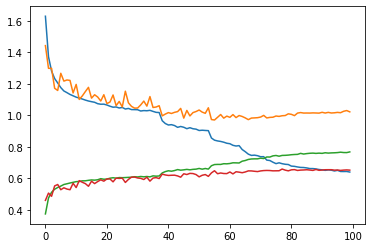

In [12]:
import pickle
pickle.dump(hist, open('featureactv32_baseline_modelv22_hist.hdf5', 'wb'))
plt.plot(hist), best_acc

In [13]:
model = torch.load('featureactv32_baseline_modelv22.pt')

# EVALUATE
model.eval()
running_valloss = 0.0
running_valacc = 0.0
for i,data in enumerate(test_loader):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = model(inputs)

    loss = criterion(outputs, labels)
    acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

    running_valloss += (loss.item() * inputs.size(0))
    running_valacc += acc.item()

print('- Avg. val_loss: %.3f | Avg. val_acc: %.3f' % (running_valloss / len(test_loader.dataset), running_valacc / len(test_loader.dataset)))


- Avg. val_loss: 0.945 | Avg. val_acc: 0.665


## Feature Act v3.3 single output each block (use conv_3x3)

In [5]:
class FeatureAct(nn.Module):
    def __init__(self, src_depth, reduce_factor=1):
        super(FeatureAct, self).__init__()
        
        self.softmax = nn.Softmax(dim=2)
        
        self.src_conv = nn.Conv2d(src_depth, src_depth // reduce_factor, kernel_size=3, padding=1)
        self.target_conv = nn.Conv2d(src_depth, src_depth // reduce_factor, kernel_size=3, padding=1)
        
        self.down_depth = nn.Sequential(nn.Conv2d(src_depth, src_depth // reduce_factor, kernel_size=3, padding=1),
                                        nn.ReLU(inplace=True))
        self.up_depth = nn.Sequential(nn.Conv2d(src_depth // reduce_factor, src_depth, kernel_size=3, padding=1),
                                      nn.ReLU(inplace=True))
        
    def forward(self, x):
        
        src_features = self.src_conv(x)
        target_features = self.target_conv(x)
        
        cor = nn.Flatten(-2)(src_features[:, None, :, :]).permute(0,2,1,3) * nn.Flatten(-2)(target_features[:, None, :, :])
        cor = self.softmax(cor)
        
        main_features = self.down_depth(x)
    
        cor_feature = torch.cat([(main_features * cor[:, :, k].view(-1, src_features.size(-3), src_features.size(-2), src_features.size(-1))).sum(1, keepdim=True) for k in range(cor.size(2))], dim=1)
        cor_feature = self.up_depth(cor_feature)
        
        x = x + cor_feature
        
        return x

In [6]:
class BaselineFeatureAct(nn.Module):
    def __init__(self, embeddings=False):
        
        super(BaselineFeatureAct, self).__init__()
        
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=(2,2), stride=2)
        
        self.conv0 = nn.Conv2d(1, 32, kernel_size=(3,3), padding=1, stride=1)
        self.conv0b = nn.Conv2d(32, 32, kernel_size=(3,3), padding=1, stride=1)
        self.bn0 = nn.BatchNorm2d(32)
        self.bn0b = nn.BatchNorm2d(32)
        
        self.conv1 = nn.Conv2d(32, 64, kernel_size=(3,3), padding=1, stride=1)
        self.conv1b = nn.Conv2d(64, 64, kernel_size=(3,3), padding=1, stride=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.bn1b = nn.BatchNorm2d(64)
        
        self.conv2 = nn.Conv2d(64, 128, kernel_size=(3,3), padding=1, stride=1)
        self.conv2b = nn.Conv2d(128, 128, kernel_size=(3,3), padding=1, stride=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn2b = nn.BatchNorm2d(128)
        
        self.conv3 = nn.Conv2d(128, 256, kernel_size=(3,3), padding=1, stride=1)
        self.conv3b = nn.Conv2d(256, 256, kernel_size=(3,3), padding=1, stride=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.bn3b = nn.BatchNorm2d(256)
  
        self.fact0 = FeatureAct(32, 4)
        self.fact1 = FeatureAct(64, 4)
        self.fact2 = FeatureAct(128, 4)
        self.fact3 = FeatureAct(256, 4)
        
        if not embeddings:
            self.classifier = nn.Sequential(nn.Flatten(),
                                            nn.Linear(2304, 256), nn.BatchNorm1d(256), nn.ReLU(inplace=True),
                                            nn.Linear(256, 128), nn.BatchNorm1d(128), nn.ReLU(inplace=True),
                                            nn.Linear(128, 7), nn.BatchNorm1d(7))
        else:
            self.classifier = nn.Sequential(nn.Flatten(),
                                            nn.Linear(2304, 256), nn.BatchNorm1d(256), nn.ReLU(inplace=True),
                                            nn.Linear(256, 128), nn.BatchNorm1d(128))
        
    def forward(self, x):
        
        x = self.conv0(x)
        x = self.bn0(x)
        x = self.relu(x)
        x = self.conv0b(x)
        x = self.bn0b(x)
        x = self.relu(x)
        
        x0 = self.maxpool(x)
        x0 = self.fact0(x0)
        
        x = self.conv1(x0)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv1b(x)
        x = self.bn1b(x)
        x = self.relu(x)
        
        x1 = self.maxpool(x)
        x1 = self.fact1(x1)
        
        x = self.conv2(x1)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv2b(x)
        x = self.bn2b(x)
        x = self.relu(x)
        
        x2 = self.maxpool(x)
        x2 = self.fact2(x2)
        
        x = self.conv3(x2)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.conv3b(x)
        x = self.bn3b(x)
        x = self.relu(x)
        
        x3 = self.maxpool(x)
        x3 = self.fact3(x3)
        
        x = nn.Flatten()(x3)
        x = self.classifier(x)
        
        return x

In [7]:
device = torch.device('cuda')
model = BaselineFeatureAct().to(device)

best_acc = 0.0
hist = []

epochs=100

criterion = nn.CrossEntropyLoss()

learning_rate = 0.004
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=7, verbose=True)


In [8]:
model_path = './featureactv33_baseline_modelv22.pt'

for epoch in range(100):  # loop over the dataset multiple times

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0
    processed = 0.0

    # TRAIN
    model.train()
    pbar = tqdm(train_loader, position=0)
    for i, data in enumerate(pbar):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()
        loss.backward()
        
        optimizer.step()

        # print statistics
        running_loss += (loss.item() * inputs.size(0))
        running_acc += acc.item()
        processed += len(inputs)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={i} Accuracy={acc.item() / inputs.size(0)}')

    print('- Avg.loss: %.3f | Avg.acc: %.3f' % (running_loss / len(train_loader.dataset), running_acc / len(train_loader.dataset)))
    avgloss = running_loss / len(train_loader.dataset)
    avgacc = running_acc / len(train_loader.dataset)

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

        running_valloss += (loss.item() * inputs.size(0))
        running_valacc += acc.item()

    print('- Avg. val_loss: %.3f | Avg. val_acc: %.3f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

    avgvalloss = running_valloss / len(val_loader.dataset)
    avgvalacc = running_valacc / len(val_loader.dataset)
    
    scheduler.step(avgvalloss)

    hist.append([avgloss, avgvalloss, avgacc, avgvalacc])
    
    if best_acc < avgvalacc:
        best_acc = avgvalacc
        torch.save(model, model_path)
        print('* Update optimal model')

print('Finished Training')

  0%|          | 0/225 [00:00<?, ?it/s]

Epoch:  1


Loss=1.8235292434692383 Batch_id=224 Accuracy=0.21621621621621623: 100%|██████████| 225/225 [00:36<00:00,  6.10it/s]

- Avg.loss: 1.943 | Avg.acc: 0.234



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.836 | Avg. val_acc: 0.251
* Update optimal model
Epoch:  2


Loss=1.8578745126724243 Batch_id=224 Accuracy=0.16216216216216217: 100%|██████████| 225/225 [00:37<00:00,  6.06it/s]

- Avg.loss: 1.800 | Avg.acc: 0.260



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.783 | Avg. val_acc: 0.276
* Update optimal model
Epoch:  3


Loss=1.7717208862304688 Batch_id=224 Accuracy=0.2702702702702703: 100%|██████████| 225/225 [00:37<00:00,  6.05it/s]

- Avg.loss: 1.758 | Avg.acc: 0.280



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.767 | Avg. val_acc: 0.279
* Update optimal model
Epoch:  4


Loss=1.8021759986877441 Batch_id=224 Accuracy=0.21621621621621623: 100%|██████████| 225/225 [00:37<00:00,  6.05it/s]

- Avg.loss: 1.723 | Avg.acc: 0.296



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.659 | Avg. val_acc: 0.342
* Update optimal model
Epoch:  5


Loss=1.6629962921142578 Batch_id=224 Accuracy=0.2972972972972973: 100%|██████████| 225/225 [00:37<00:00,  6.05it/s]

- Avg.loss: 1.624 | Avg.acc: 0.352



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.678 | Avg. val_acc: 0.329
Epoch:  6


Loss=1.2817531824111938 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:37<00:00,  6.06it/s]

- Avg.loss: 1.545 | Avg.acc: 0.389



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.572 | Avg. val_acc: 0.393
* Update optimal model
Epoch:  7


Loss=1.326249361038208 Batch_id=224 Accuracy=0.4594594594594595: 100%|██████████| 225/225 [00:36<00:00,  6.08it/s]

- Avg.loss: 1.497 | Avg.acc: 0.413



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.514 | Avg. val_acc: 0.414
* Update optimal model
Epoch:  8


Loss=1.4493671655654907 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [00:37<00:00,  6.05it/s]

- Avg.loss: 1.447 | Avg.acc: 0.437



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.410 | Avg. val_acc: 0.456
* Update optimal model
Epoch:  9


Loss=1.3294354677200317 Batch_id=224 Accuracy=0.43243243243243246: 100%|██████████| 225/225 [00:37<00:00,  6.07it/s]

- Avg.loss: 1.413 | Avg.acc: 0.448



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.433 | Avg. val_acc: 0.447
Epoch:  10


Loss=1.4083237648010254 Batch_id=224 Accuracy=0.4594594594594595: 100%|██████████| 225/225 [00:37<00:00,  6.07it/s]

- Avg.loss: 1.385 | Avg.acc: 0.461



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.386 | Avg. val_acc: 0.466
* Update optimal model
Epoch:  11


Loss=1.2963896989822388 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [00:36<00:00,  6.10it/s]

- Avg.loss: 1.357 | Avg.acc: 0.471



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.327 | Avg. val_acc: 0.492
* Update optimal model
Epoch:  12


Loss=1.2710055112838745 Batch_id=224 Accuracy=0.40540540540540543: 100%|██████████| 225/225 [00:36<00:00,  6.11it/s]

- Avg.loss: 1.336 | Avg.acc: 0.480



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.380 | Avg. val_acc: 0.476
Epoch:  13


Loss=1.240484356880188 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:37<00:00,  6.05it/s]

- Avg.loss: 1.317 | Avg.acc: 0.490



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.389 | Avg. val_acc: 0.460
Epoch:  14


Loss=1.260033369064331 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:37<00:00,  6.03it/s]

- Avg.loss: 1.310 | Avg.acc: 0.491



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.286 | Avg. val_acc: 0.509
* Update optimal model
Epoch:  15


Loss=1.1938152313232422 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [00:37<00:00,  6.04it/s]

- Avg.loss: 1.291 | Avg.acc: 0.498



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.479 | Avg. val_acc: 0.401
Epoch:  16


Loss=1.4525021314620972 Batch_id=224 Accuracy=0.40540540540540543: 100%|██████████| 225/225 [00:37<00:00,  6.07it/s]

- Avg.loss: 1.277 | Avg.acc: 0.506



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.320 | Avg. val_acc: 0.487
Epoch:  17


Loss=1.1908092498779297 Batch_id=224 Accuracy=0.4594594594594595: 100%|██████████| 225/225 [00:37<00:00,  6.07it/s]

- Avg.loss: 1.272 | Avg.acc: 0.507



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.253 | Avg. val_acc: 0.520
* Update optimal model
Epoch:  18


Loss=1.3250588178634644 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:36<00:00,  6.11it/s]

- Avg.loss: 1.267 | Avg.acc: 0.507



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.286 | Avg. val_acc: 0.496
Epoch:  19


Loss=1.330912470817566 Batch_id=224 Accuracy=0.40540540540540543: 100%|██████████| 225/225 [00:37<00:00,  6.05it/s]

- Avg.loss: 1.250 | Avg.acc: 0.519



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.311 | Avg. val_acc: 0.496
Epoch:  20


Loss=1.3852043151855469 Batch_id=224 Accuracy=0.3783783783783784: 100%|██████████| 225/225 [00:37<00:00,  6.06it/s]

- Avg.loss: 1.255 | Avg.acc: 0.516



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.302 | Avg. val_acc: 0.500
Epoch:  21


Loss=1.4001528024673462 Batch_id=224 Accuracy=0.40540540540540543: 100%|██████████| 225/225 [00:36<00:00,  6.09it/s]

- Avg.loss: 1.245 | Avg.acc: 0.519



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.369 | Avg. val_acc: 0.487
Epoch:  22


Loss=1.2404204607009888 Batch_id=224 Accuracy=0.4594594594594595: 100%|██████████| 225/225 [00:37<00:00,  6.08it/s]

- Avg.loss: 1.232 | Avg.acc: 0.523



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.308 | Avg. val_acc: 0.510
Epoch:  23


Loss=1.484412431716919 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [00:37<00:00,  6.05it/s]

- Avg.loss: 1.229 | Avg.acc: 0.527



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.254 | Avg. val_acc: 0.507
Epoch:  24


Loss=1.2922931909561157 Batch_id=224 Accuracy=0.4594594594594595: 100%|██████████| 225/225 [00:37<00:00,  6.02it/s]

- Avg.loss: 1.220 | Avg.acc: 0.524



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.273 | Avg. val_acc: 0.522
* Update optimal model
Epoch:  25


Loss=1.5141630172729492 Batch_id=224 Accuracy=0.43243243243243246: 100%|██████████| 225/225 [00:37<00:00,  6.06it/s]

- Avg.loss: 1.216 | Avg.acc: 0.529



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.248 | Avg. val_acc: 0.527
* Update optimal model
Epoch:  26


Loss=1.1498199701309204 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:36<00:00,  6.08it/s]

- Avg.loss: 1.213 | Avg.acc: 0.530



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.254 | Avg. val_acc: 0.521
Epoch:  27


Loss=1.138799786567688 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:37<00:00,  6.02it/s]

- Avg.loss: 1.206 | Avg.acc: 0.535



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.204 | Avg. val_acc: 0.544
* Update optimal model
Epoch:  28


Loss=1.2168903350830078 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [00:37<00:00,  6.03it/s]

- Avg.loss: 1.200 | Avg.acc: 0.538



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.176 | Avg. val_acc: 0.550
* Update optimal model
Epoch:  29


Loss=1.5451680421829224 Batch_id=224 Accuracy=0.4594594594594595: 100%|██████████| 225/225 [00:37<00:00,  6.07it/s]

- Avg.loss: 1.202 | Avg.acc: 0.536



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.224 | Avg. val_acc: 0.524
Epoch:  30


Loss=1.3632152080535889 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:37<00:00,  6.04it/s]

- Avg.loss: 1.195 | Avg.acc: 0.540



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.168 | Avg. val_acc: 0.549
Epoch:  31


Loss=1.0808374881744385 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:37<00:00,  6.07it/s]

- Avg.loss: 1.189 | Avg.acc: 0.542



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.226 | Avg. val_acc: 0.533
Epoch:  32


Loss=1.1257344484329224 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:37<00:00,  6.07it/s]

- Avg.loss: 1.183 | Avg.acc: 0.545



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.275 | Avg. val_acc: 0.505
Epoch:  33


Loss=1.1508548259735107 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:37<00:00,  6.06it/s]

- Avg.loss: 1.180 | Avg.acc: 0.549



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.306 | Avg. val_acc: 0.497
Epoch:  34


Loss=1.4468839168548584 Batch_id=224 Accuracy=0.4594594594594595: 100%|██████████| 225/225 [00:36<00:00,  6.09it/s]

- Avg.loss: 1.180 | Avg.acc: 0.547



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.180 | Avg. val_acc: 0.550
Epoch:  35


Loss=1.133631944656372 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:37<00:00,  6.08it/s]

- Avg.loss: 1.178 | Avg.acc: 0.549



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.318 | Avg. val_acc: 0.513
Epoch:  36


Loss=1.0056147575378418 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:37<00:00,  6.06it/s]

- Avg.loss: 1.171 | Avg.acc: 0.550



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.245 | Avg. val_acc: 0.527
Epoch:  37


Loss=1.2979745864868164 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:37<00:00,  6.00it/s]

- Avg.loss: 1.165 | Avg.acc: 0.553



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.209 | Avg. val_acc: 0.546
Epoch:  38


Loss=1.3664277791976929 Batch_id=224 Accuracy=0.43243243243243246: 100%|██████████| 225/225 [00:37<00:00,  6.05it/s]

- Avg.loss: 1.162 | Avg.acc: 0.555



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.405 | Avg. val_acc: 0.466
Epoch    38: reducing learning rate of group 0 to 2.0000e-03.
Epoch:  39


Loss=1.3397563695907593 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [00:37<00:00,  6.07it/s]

- Avg.loss: 1.124 | Avg.acc: 0.571



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.112 | Avg. val_acc: 0.574
* Update optimal model
Epoch:  40


Loss=1.0550556182861328 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:37<00:00,  6.06it/s]

- Avg.loss: 1.114 | Avg.acc: 0.574



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.148 | Avg. val_acc: 0.567
Epoch:  41


Loss=1.1149455308914185 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:37<00:00,  6.04it/s]

- Avg.loss: 1.108 | Avg.acc: 0.572



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.108 | Avg. val_acc: 0.574
Epoch:  42


Loss=1.312564730644226 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:36<00:00,  6.09it/s]

- Avg.loss: 1.102 | Avg.acc: 0.579



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.129 | Avg. val_acc: 0.571
Epoch:  43


Loss=1.2486467361450195 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:37<00:00,  6.05it/s]

- Avg.loss: 1.102 | Avg.acc: 0.578



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.138 | Avg. val_acc: 0.570
Epoch:  44


Loss=1.394310712814331 Batch_id=224 Accuracy=0.35135135135135137: 100%|██████████| 225/225 [00:37<00:00,  6.07it/s]

- Avg.loss: 1.098 | Avg.acc: 0.583



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.112 | Avg. val_acc: 0.576
* Update optimal model
Epoch:  45


Loss=0.8851353526115417 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:37<00:00,  6.04it/s]

- Avg.loss: 1.094 | Avg.acc: 0.581



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.136 | Avg. val_acc: 0.571
Epoch:  46


Loss=1.0488752126693726 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:37<00:00,  6.04it/s]

- Avg.loss: 1.092 | Avg.acc: 0.585



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.098 | Avg. val_acc: 0.583
* Update optimal model
Epoch:  47


Loss=1.0457756519317627 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:37<00:00,  6.03it/s]

- Avg.loss: 1.087 | Avg.acc: 0.585



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.131 | Avg. val_acc: 0.565
Epoch:  48


Loss=0.9677276611328125 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:37<00:00,  6.03it/s]

- Avg.loss: 1.079 | Avg.acc: 0.590



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.101 | Avg. val_acc: 0.587
* Update optimal model
Epoch:  49


Loss=1.0915216207504272 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:37<00:00,  6.02it/s]

- Avg.loss: 1.080 | Avg.acc: 0.588



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.098 | Avg. val_acc: 0.579
Epoch:  50


Loss=1.0990663766860962 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:37<00:00,  6.06it/s]

- Avg.loss: 1.079 | Avg.acc: 0.588



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.140 | Avg. val_acc: 0.570
Epoch:  51


Loss=1.2164602279663086 Batch_id=224 Accuracy=0.4594594594594595: 100%|██████████| 225/225 [00:37<00:00,  6.07it/s]

- Avg.loss: 1.073 | Avg.acc: 0.592



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.156 | Avg. val_acc: 0.573
Epoch:  52


Loss=1.0028377771377563 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:37<00:00,  6.08it/s]

- Avg.loss: 1.073 | Avg.acc: 0.591



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.172 | Avg. val_acc: 0.559
Epoch:  53


Loss=1.0435832738876343 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:37<00:00,  6.05it/s]

- Avg.loss: 1.067 | Avg.acc: 0.596



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.225 | Avg. val_acc: 0.536
Epoch:  54


Loss=0.9769917130470276 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:37<00:00,  6.04it/s]

- Avg.loss: 1.068 | Avg.acc: 0.595



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.124 | Avg. val_acc: 0.573
Epoch:  55


Loss=1.2347744703292847 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:37<00:00,  6.03it/s]

- Avg.loss: 1.066 | Avg.acc: 0.593



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.105 | Avg. val_acc: 0.585
Epoch:  56


Loss=1.1552692651748657 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:37<00:00,  6.00it/s]

- Avg.loss: 1.056 | Avg.acc: 0.599



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.149 | Avg. val_acc: 0.568
Epoch:  57


Loss=1.2061458826065063 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:37<00:00,  6.05it/s]

- Avg.loss: 1.057 | Avg.acc: 0.599



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.082 | Avg. val_acc: 0.592
* Update optimal model
Epoch:  58


Loss=0.8811739087104797 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:37<00:00,  6.08it/s]

- Avg.loss: 1.060 | Avg.acc: 0.598



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.217 | Avg. val_acc: 0.545
Epoch:  59


Loss=0.9555197954177856 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:37<00:00,  5.99it/s]

- Avg.loss: 1.053 | Avg.acc: 0.600



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.214 | Avg. val_acc: 0.540
Epoch:  60


Loss=0.9594036936759949 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:37<00:00,  6.01it/s]

- Avg.loss: 1.053 | Avg.acc: 0.599



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.112 | Avg. val_acc: 0.578
Epoch:  61


Loss=1.2579536437988281 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [00:37<00:00,  6.05it/s]

- Avg.loss: 1.053 | Avg.acc: 0.601



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.088 | Avg. val_acc: 0.588
Epoch:  62


Loss=1.2235558032989502 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:36<00:00,  6.10it/s]

- Avg.loss: 1.050 | Avg.acc: 0.601



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.070 | Avg. val_acc: 0.593
* Update optimal model
Epoch:  63


Loss=0.9072831869125366 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:37<00:00,  6.06it/s]

- Avg.loss: 1.048 | Avg.acc: 0.602



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.083 | Avg. val_acc: 0.585
Epoch:  64


Loss=1.0416306257247925 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [00:36<00:00,  6.13it/s]

- Avg.loss: 1.045 | Avg.acc: 0.603



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.076 | Avg. val_acc: 0.587
Epoch:  65


Loss=0.9157794117927551 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:37<00:00,  6.06it/s]

- Avg.loss: 1.048 | Avg.acc: 0.602



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.100 | Avg. val_acc: 0.588
Epoch:  66


Loss=1.0532727241516113 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:37<00:00,  6.07it/s]

- Avg.loss: 1.039 | Avg.acc: 0.606



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.098 | Avg. val_acc: 0.589
Epoch:  67


Loss=1.3276599645614624 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:37<00:00,  6.05it/s]

- Avg.loss: 1.041 | Avg.acc: 0.607



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.092 | Avg. val_acc: 0.581
Epoch:  68


Loss=1.0529453754425049 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:37<00:00,  6.06it/s]

- Avg.loss: 1.038 | Avg.acc: 0.606



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.116 | Avg. val_acc: 0.576
Epoch:  69


Loss=0.8423070907592773 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:37<00:00,  6.06it/s]

- Avg.loss: 1.038 | Avg.acc: 0.604



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.111 | Avg. val_acc: 0.585
Epoch:  70


Loss=1.241241693496704 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:36<00:00,  6.08it/s]

- Avg.loss: 1.039 | Avg.acc: 0.606



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.113 | Avg. val_acc: 0.582
Epoch    70: reducing learning rate of group 0 to 1.0000e-03.
Epoch:  71


Loss=1.1103650331497192 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:37<00:00,  6.00it/s]

- Avg.loss: 1.011 | Avg.acc: 0.617



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.041 | Avg. val_acc: 0.604
* Update optimal model
Epoch:  72


Loss=0.9441484212875366 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:37<00:00,  6.06it/s]

- Avg.loss: 0.996 | Avg.acc: 0.621



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.077 | Avg. val_acc: 0.598
Epoch:  73


Loss=1.2679314613342285 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [00:36<00:00,  6.10it/s]

- Avg.loss: 0.992 | Avg.acc: 0.626



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.054 | Avg. val_acc: 0.611
* Update optimal model
Epoch:  74


Loss=0.9207831621170044 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:37<00:00,  6.05it/s]

- Avg.loss: 0.990 | Avg.acc: 0.627



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.067 | Avg. val_acc: 0.594
Epoch:  75


Loss=1.0787674188613892 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:37<00:00,  6.03it/s]

- Avg.loss: 0.985 | Avg.acc: 0.625



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.077 | Avg. val_acc: 0.582
Epoch:  76


Loss=1.2065517902374268 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:37<00:00,  6.07it/s]

- Avg.loss: 0.987 | Avg.acc: 0.626



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.066 | Avg. val_acc: 0.603
Epoch:  77


Loss=1.0023337602615356 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:37<00:00,  6.08it/s]

- Avg.loss: 0.985 | Avg.acc: 0.628



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.063 | Avg. val_acc: 0.596
Epoch:  78


Loss=0.9390156865119934 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:37<00:00,  6.08it/s]

- Avg.loss: 0.983 | Avg.acc: 0.627



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.077 | Avg. val_acc: 0.595
Epoch:  79


Loss=1.0217113494873047 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:37<00:00,  6.06it/s]

- Avg.loss: 0.978 | Avg.acc: 0.632



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.078 | Avg. val_acc: 0.592
Epoch    79: reducing learning rate of group 0 to 5.0000e-04.
Epoch:  80


Loss=0.749650239944458 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:37<00:00,  6.02it/s]

- Avg.loss: 0.955 | Avg.acc: 0.641



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.035 | Avg. val_acc: 0.607
Epoch:  81


Loss=1.2173138856887817 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:36<00:00,  6.12it/s]

- Avg.loss: 0.953 | Avg.acc: 0.640



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.034 | Avg. val_acc: 0.609
Epoch:  82


Loss=1.0011554956436157 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:37<00:00,  6.01it/s]

- Avg.loss: 0.956 | Avg.acc: 0.642



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.047 | Avg. val_acc: 0.597
Epoch:  83


Loss=1.2385655641555786 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:37<00:00,  6.05it/s]

- Avg.loss: 0.948 | Avg.acc: 0.643



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.029 | Avg. val_acc: 0.613
* Update optimal model
Epoch:  84


Loss=1.1157306432724 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:37<00:00,  6.04it/s]

- Avg.loss: 0.947 | Avg.acc: 0.642



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.030 | Avg. val_acc: 0.613
* Update optimal model
Epoch:  85


Loss=1.4253114461898804 Batch_id=224 Accuracy=0.43243243243243246: 100%|██████████| 225/225 [00:37<00:00,  6.04it/s]

- Avg.loss: 0.945 | Avg.acc: 0.641



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.025 | Avg. val_acc: 0.617
* Update optimal model
Epoch:  86


Loss=0.8631749153137207 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:37<00:00,  6.02it/s]

- Avg.loss: 0.943 | Avg.acc: 0.643



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.028 | Avg. val_acc: 0.609
Epoch:  87


Loss=1.0336359739303589 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:37<00:00,  6.05it/s]

- Avg.loss: 0.940 | Avg.acc: 0.646



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.031 | Avg. val_acc: 0.608
Epoch:  88


Loss=0.9335793256759644 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:37<00:00,  6.04it/s]

- Avg.loss: 0.939 | Avg.acc: 0.643



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.024 | Avg. val_acc: 0.609
Epoch:  89


Loss=1.0503723621368408 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:37<00:00,  6.07it/s]

- Avg.loss: 0.933 | Avg.acc: 0.650



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.018 | Avg. val_acc: 0.609
Epoch:  90


Loss=1.1050090789794922 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:37<00:00,  6.03it/s]

- Avg.loss: 0.940 | Avg.acc: 0.643



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.032 | Avg. val_acc: 0.610
Epoch:  91


Loss=1.176995038986206 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:37<00:00,  6.04it/s]

- Avg.loss: 0.933 | Avg.acc: 0.649



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.028 | Avg. val_acc: 0.606
Epoch:  92


Loss=1.4222180843353271 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [00:36<00:00,  6.09it/s]

- Avg.loss: 0.935 | Avg.acc: 0.647



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.042 | Avg. val_acc: 0.602
Epoch:  93


Loss=1.0895023345947266 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:37<00:00,  6.07it/s]

- Avg.loss: 0.934 | Avg.acc: 0.646



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.023 | Avg. val_acc: 0.616
Epoch:  94


Loss=0.7408376932144165 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:37<00:00,  6.04it/s]

- Avg.loss: 0.924 | Avg.acc: 0.652



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.021 | Avg. val_acc: 0.616
Epoch:  95


Loss=0.9561823010444641 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:37<00:00,  6.07it/s]

- Avg.loss: 0.932 | Avg.acc: 0.647



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.012 | Avg. val_acc: 0.624
* Update optimal model
Epoch:  96


Loss=1.017789363861084 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:36<00:00,  6.09it/s]

- Avg.loss: 0.925 | Avg.acc: 0.652



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.035 | Avg. val_acc: 0.613
Epoch:  97


Loss=0.855464518070221 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:37<00:00,  6.02it/s]

- Avg.loss: 0.926 | Avg.acc: 0.650



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.025 | Avg. val_acc: 0.615
Epoch:  98


Loss=0.9003549814224243 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:37<00:00,  6.03it/s]

- Avg.loss: 0.923 | Avg.acc: 0.653



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.038 | Avg. val_acc: 0.613
Epoch:  99


Loss=0.5756663680076599 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [00:37<00:00,  6.05it/s]

- Avg.loss: 0.928 | Avg.acc: 0.649



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.020 | Avg. val_acc: 0.617
Epoch:  100


Loss=1.000253677368164 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:37<00:00,  6.07it/s]

- Avg.loss: 0.923 | Avg.acc: 0.653


- Avg. val_loss: 1.021 | Avg. val_acc: 0.618
Finished Training


([<matplotlib.lines.Line2D at 0x7fe5e74d9cf8>,
 0.6241292839230984)

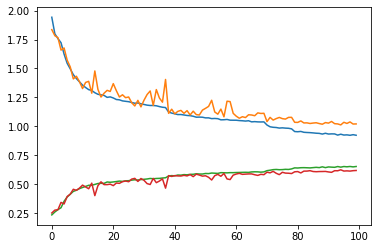

In [10]:
import pickle
pickle.dump(hist, open('featureactv33_baseline_modelv22_hist.hdf5', 'wb'))

plt.plot(hist), best_acc

In [11]:
test_model = torch.load('featureactv33_baseline_modelv22.pt')

# EVALUATE
test_model.eval()
running_valloss = 0.0
running_valacc = 0.0
for i,data in enumerate(test_loader):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = test_model(inputs)

    loss = criterion(outputs, labels)
    acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

    running_valloss += (loss.item() * inputs.size(0))
    running_valacc += acc.item()

print('- Avg. val_loss: %.3f | Avg. val_acc: %.3f' % (running_valloss / len(test_loader.dataset), running_valacc / len(test_loader.dataset)))

- Avg. val_loss: 1.003 | Avg. val_acc: 0.621


In [12]:
for epoch in range(100, 130):  # loop over the dataset multiple times

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0
    processed = 0.0

    # TRAIN
    model.train()
    pbar = tqdm(train_loader, position=0)
    for i, data in enumerate(pbar):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()
        loss.backward()
        
        optimizer.step()

        # print statistics
        running_loss += (loss.item() * inputs.size(0))
        running_acc += acc.item()
        processed += len(inputs)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={i} Accuracy={acc.item() / inputs.size(0)}')

    print('- Avg.loss: %.3f | Avg.acc: %.3f' % (running_loss / len(train_loader.dataset), running_acc / len(train_loader.dataset)))
    avgloss = running_loss / len(train_loader.dataset)
    avgacc = running_acc / len(train_loader.dataset)

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

        running_valloss += (loss.item() * inputs.size(0))
        running_valacc += acc.item()

    print('- Avg. val_loss: %.3f | Avg. val_acc: %.3f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

    avgvalloss = running_valloss / len(val_loader.dataset)
    avgvalacc = running_valacc / len(val_loader.dataset)
    
    scheduler.step(avgvalloss)

    hist.append([avgloss, avgvalloss, avgacc, avgvalacc])
    
    if best_acc < avgvalacc:
        best_acc = avgvalacc
        torch.save(model, model_path)
        print('* Update optimal model')

print('Finished Training')

  0%|          | 0/225 [00:00<?, ?it/s]

Epoch:  101


Loss=0.9676418900489807 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:36<00:00,  6.13it/s]

- Avg.loss: 0.925 | Avg.acc: 0.653



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.015 | Avg. val_acc: 0.619
Epoch:  102


Loss=1.081616997718811 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:36<00:00,  6.11it/s]

- Avg.loss: 0.921 | Avg.acc: 0.650



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.026 | Avg. val_acc: 0.612
Epoch:  103


Loss=0.9783686995506287 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:37<00:00,  6.03it/s]

- Avg.loss: 0.921 | Avg.acc: 0.654



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.038 | Avg. val_acc: 0.603
Epoch   103: reducing learning rate of group 0 to 2.5000e-04.
Epoch:  104


Loss=0.8307493329048157 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:36<00:00,  6.09it/s]

- Avg.loss: 0.906 | Avg.acc: 0.658



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.014 | Avg. val_acc: 0.622
Epoch:  105


Loss=1.0254061222076416 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:37<00:00,  6.04it/s]

- Avg.loss: 0.902 | Avg.acc: 0.661



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.014 | Avg. val_acc: 0.618
Epoch:  106


Loss=0.8845045566558838 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:37<00:00,  6.06it/s]

- Avg.loss: 0.902 | Avg.acc: 0.660



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.013 | Avg. val_acc: 0.622
Epoch:  107


Loss=0.8181725144386292 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:37<00:00,  6.04it/s]

- Avg.loss: 0.901 | Avg.acc: 0.660



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.016 | Avg. val_acc: 0.617
Epoch:  108


Loss=0.9156252145767212 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:37<00:00,  6.04it/s]

- Avg.loss: 0.902 | Avg.acc: 0.659



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.023 | Avg. val_acc: 0.616
Epoch:  109


Loss=1.018920660018921 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:37<00:00,  6.06it/s]

- Avg.loss: 0.895 | Avg.acc: 0.663



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.009 | Avg. val_acc: 0.619
Epoch:  110


Loss=0.8800445795059204 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:37<00:00,  6.04it/s]

- Avg.loss: 0.896 | Avg.acc: 0.660



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.013 | Avg. val_acc: 0.621
Epoch:  111


Loss=0.9453967213630676 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:37<00:00,  6.05it/s]

- Avg.loss: 0.898 | Avg.acc: 0.662



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.032 | Avg. val_acc: 0.612
Epoch:  112


Loss=1.1126303672790527 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:37<00:00,  6.05it/s]

- Avg.loss: 0.895 | Avg.acc: 0.663



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.013 | Avg. val_acc: 0.622
Epoch:  113


Loss=0.7274143695831299 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:37<00:00,  6.07it/s]

- Avg.loss: 0.900 | Avg.acc: 0.660



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.023 | Avg. val_acc: 0.623
Epoch:  114


Loss=0.920911967754364 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:37<00:00,  6.07it/s]

- Avg.loss: 0.897 | Avg.acc: 0.663



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.012 | Avg. val_acc: 0.622
Epoch:  115


Loss=0.930566132068634 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:37<00:00,  6.03it/s]

- Avg.loss: 0.896 | Avg.acc: 0.661



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.022 | Avg. val_acc: 0.624
Epoch:  116


Loss=0.9011038541793823 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:37<00:00,  6.07it/s]

- Avg.loss: 0.890 | Avg.acc: 0.663



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.014 | Avg. val_acc: 0.627
* Update optimal model
Epoch:  117


Loss=0.8460263609886169 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:37<00:00,  6.05it/s]

- Avg.loss: 0.894 | Avg.acc: 0.663



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.022 | Avg. val_acc: 0.624
Epoch   117: reducing learning rate of group 0 to 1.2500e-04.
Epoch:  118


Loss=0.9754473567008972 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:36<00:00,  6.09it/s]

- Avg.loss: 0.890 | Avg.acc: 0.664



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.028 | Avg. val_acc: 0.617
Epoch:  119


Loss=0.8038864731788635 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:37<00:00,  6.02it/s]

- Avg.loss: 0.883 | Avg.acc: 0.669



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.023 | Avg. val_acc: 0.614
Epoch:  120


Loss=0.765566885471344 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:37<00:00,  6.03it/s]

- Avg.loss: 0.887 | Avg.acc: 0.665



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.021 | Avg. val_acc: 0.619
Epoch:  121


Loss=1.0776050090789795 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:37<00:00,  6.03it/s]

- Avg.loss: 0.884 | Avg.acc: 0.666



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.016 | Avg. val_acc: 0.630
* Update optimal model
Epoch:  122


Loss=1.1629058122634888 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:37<00:00,  6.07it/s]

- Avg.loss: 0.884 | Avg.acc: 0.669



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.020 | Avg. val_acc: 0.623
Epoch:  123


Loss=0.586442768573761 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:37<00:00,  6.06it/s]

- Avg.loss: 0.877 | Avg.acc: 0.670



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.014 | Avg. val_acc: 0.622
Epoch:  124


Loss=0.8073453903198242 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:36<00:00,  6.09it/s]

- Avg.loss: 0.881 | Avg.acc: 0.671



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.019 | Avg. val_acc: 0.620
Epoch:  125


Loss=1.0250024795532227 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:37<00:00,  6.04it/s]

- Avg.loss: 0.879 | Avg.acc: 0.670



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.014 | Avg. val_acc: 0.623
Epoch   125: reducing learning rate of group 0 to 6.2500e-05.
Epoch:  126


Loss=1.0744765996932983 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:37<00:00,  6.05it/s]

- Avg.loss: 0.876 | Avg.acc: 0.671



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.013 | Avg. val_acc: 0.624
Epoch:  127


Loss=0.7908608913421631 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:37<00:00,  6.05it/s]

- Avg.loss: 0.872 | Avg.acc: 0.672



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.015 | Avg. val_acc: 0.621
Epoch:  128


Loss=0.8613998293876648 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:37<00:00,  6.05it/s]

- Avg.loss: 0.873 | Avg.acc: 0.672



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.022 | Avg. val_acc: 0.620
Epoch:  129


Loss=1.1088546514511108 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:36<00:00,  6.09it/s]

- Avg.loss: 0.877 | Avg.acc: 0.672



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.014 | Avg. val_acc: 0.624
Epoch:  130


Loss=0.9395131468772888 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:37<00:00,  6.07it/s]

- Avg.loss: 0.870 | Avg.acc: 0.673


- Avg. val_loss: 1.015 | Avg. val_acc: 0.620
Finished Training


([<matplotlib.lines.Line2D at 0x7fe5e4b6e978>,
 0.6297018668152689)

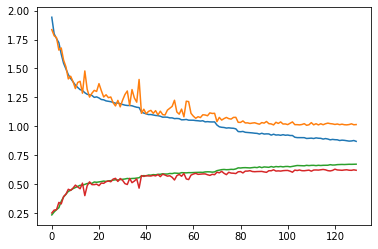

In [15]:
import pickle
pickle.dump(hist, open('featureactv33_baseline_modelv22_hist.hdf5', 'wb'))

plt.plot(hist), best_acc

In [14]:
test_model = torch.load('featureactv33_baseline_modelv22.pt')

# EVALUATE
test_model.eval()
running_valloss = 0.0
running_valacc = 0.0
for i,data in enumerate(test_loader):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = test_model(inputs)

    loss = criterion(outputs, labels)
    acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

    running_valloss += (loss.item() * inputs.size(0))
    running_valacc += acc.item()

print('- Avg. val_loss: %.3f | Avg. val_acc: %.3f' % (running_valloss / len(test_loader.dataset), running_valacc / len(test_loader.dataset)))

- Avg. val_loss: 0.989 | Avg. val_acc: 0.622


## Feature Act v3.4 single output each block (use l2 norm before softmax)


In [2]:
class FeatureAct(nn.Module):
    def __init__(self, src_depth, reduce_factor=1):
        super(FeatureAct, self).__init__()
        
        self.softmax = nn.Softmax(dim=2)
        
        self.src_conv = nn.Conv2d(src_depth, src_depth // reduce_factor, kernel_size=1, padding=False)
        self.target_conv = nn.Conv2d(src_depth, src_depth // reduce_factor, kernel_size=1, padding=False)
        
        self.down_depth = nn.Sequential(nn.Conv2d(src_depth, src_depth // reduce_factor, kernel_size=1, padding=False),
                                        nn.ReLU(inplace=True))
        self.up_depth = nn.Sequential(nn.Conv2d(src_depth // reduce_factor, src_depth, kernel_size=1, padding=False),
                                      nn.ReLU(inplace=True))
        
    def forward(self, x):
        
        src_features = self.src_conv(x)
        target_features = self.target_conv(x)
        
        cor = nn.Flatten(-2)(src_features[:, None, :, :]).permute(0,2,1,3) * nn.Flatten(-2)(target_features[:, None, :, :])
        cor = cor / (torch.norm(cor) + 1e-7)
        cor = self.softmax(cor)
        
        main_features = self.down_depth(x)
    
        cor_feature = torch.cat([(main_features * cor[:, :, k].view(-1, src_features.size(-3), src_features.size(-2), src_features.size(-1))).sum(1, keepdim=True) for k in range(cor.size(2))], dim=1)
        cor_feature = self.up_depth(cor_feature)
        
        x = x + cor_feature
        
        return x

In [3]:
class BaselineFeatureAct(nn.Module):
    def __init__(self, embeddings=False):
        
        super(BaselineFeatureAct, self).__init__()
        
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=(2,2), tastride=2)
        
        self.conv0 = nn.Conv2d(1, 32, kernel_size=(3,3), padding=1, stride=1)
        self.conv0b = nn.Conv2d(32, 32, kernel_size=(3,3), padding=1, stride=1)
        self.bn0 = nn.BatchNorm2d(32)
        self.bn0b = nn.BatchNorm2d(32)
        
        self.conv1 = nn.Conv2d(32, 64, kernel_size=(3,3), padding=1, stride=1)
        self.conv1b = nn.Conv2d(64, 64, kernel_size=(3,3), padding=1, stride=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.bn1b = nn.BatchNorm2d(64)
        
        self.conv2 = nn.Conv2d(64, 128, kernel_size=(3,3), padding=1, stride=1)
        self.conv2b = nn.Conv2d(128, 128, kernel_size=(3,3), padding=1, stride=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn2b = nn.BatchNorm2d(128)
        
        self.conv3 = nn.Conv2d(128, 256, kernel_size=(3,3), padding=1, stride=1)
        self.conv3b = nn.Conv2d(256, 256, kernel_size=(3,3), padding=1, stride=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.bn3b = nn.BatchNorm2d(256)
  
        self.fact0 = FeatureAct(32, 4)
        self.fact1 = FeatureAct(64, 4)
        self.fact2 = FeatureAct(128, 4)
        self.fact3 = FeatureAct(256, 4)
        
        if not embeddings:
            self.classifier = nn.Sequential(nn.Flatten(),
                                            nn.Linear(2304, 256), nn.BatchNorm1d(256), nn.ReLU(inplace=True),
                                            nn.Linear(256, 128), nn.BatchNorm1d(128), nn.ReLU(inplace=True),
                                            nn.Linear(128, 7), nn.BatchNorm1d(7))
        else:
            self.classifier = nn.Sequential(nn.Flatten(),
                                            nn.Linear(2304, 256), nn.BatchNorm1d(256), nn.ReLU(inplace=True),
                                            nn.Linear(256, 128), nn.BatchNorm1d(128))
        
    def forward(self, x):
        
        x = self.conv0(x)
        x = self.bn0(x)
        x = self.relu(x)
        x = self.conv0b(x)
        x = self.bn0b(x)
        x = self.relu(x)
        
        x0 = self.maxpool(x)
        x0 = self.fact0(x0)
        
        x = self.conv1(x0)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv1b(x)
        x = self.bn1b(x)
        x = self.relu(x)
        
        x1 = self.maxpool(x)
        x1 = self.fact1(x1)
        
        x = self.conv2(x1)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv2b(x)
        x = self.bn2b(x)
        x = self.relu(x)
        
        x2 = self.maxpool(x)
        x2 = self.fact2(x2)
        
        x = self.conv3(x2)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.conv3b(x)
        x = self.bn3b(x)
        x = self.relu(x)
        
        x3 = self.maxpool(x)
        x3 = self.fact3(x3)
        
        x = nn.Flatten()(x3)
        x = self.classifier(x)
        
        return x

In [7]:
device = torch.device('cuda')
model = BaselineFeatureAct().to(device)

best_acc = 0.0
hist = []

epochs=100

criterion = nn.CrossEntropyLoss()

learning_rate = 0.004
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=7, verbose=True)


In [8]:
model_path = './featureactv34_baseline_modelv22.pt'

for epoch in range(100):  # loop over the dataset multiple times

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0
    processed = 0.0

    # TRAIN
    model.train()
    pbar = tqdm(train_loader, position=0)
    for i, data in enumerate(pbar):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()
        loss.backward()
        
        optimizer.step()

        # print statistics
        running_loss += (loss.item() * inputs.size(0))
        running_acc += acc.item()
        processed += len(inputs)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={i} Accuracy={acc.item() / inputs.size(0)}')

    print('- Avg.loss: %.3f | Avg.acc: %.3f' % (running_loss / len(train_loader.dataset), running_acc / len(train_loader.dataset)))
    avgloss = running_loss / len(train_loader.dataset)
    avgacc = running_acc / len(train_loader.dataset)

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

        running_valloss += (loss.item() * inputs.size(0))
        running_valacc += acc.item()

    print('- Avg. val_loss: %.3f | Avg. val_acc: %.3f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

    avgvalloss = running_valloss / len(val_loader.dataset)
    avgvalacc = running_valacc / len(val_loader.dataset)
    
    scheduler.step(avgvalloss)

    hist.append([avgloss, avgvalloss, avgacc, avgvalacc])
    
    if best_acc < avgvalacc:
        best_acc = avgvalacc
        torch.save(model, model_path)
        print('* Update optimal model')

print('Finished Training')

  0%|          | 0/225 [00:00<?, ?it/s]

Epoch:  1


Loss=1.2289659976959229 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [00:35<00:00,  6.28it/s]

- Avg.loss: 1.594 | Avg.acc: 0.389



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.759 | Avg. val_acc: 0.383
* Update optimal model
Epoch:  2


Loss=1.1108299493789673 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:35<00:00,  6.28it/s]

- Avg.loss: 1.349 | Avg.acc: 0.485



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.480 | Avg. val_acc: 0.436
* Update optimal model
Epoch:  3


Loss=1.1727174520492554 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:35<00:00,  6.28it/s]

- Avg.loss: 1.274 | Avg.acc: 0.515



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.265 | Avg. val_acc: 0.520
* Update optimal model
Epoch:  4


Loss=1.2440818548202515 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:35<00:00,  6.27it/s]

- Avg.loss: 1.229 | Avg.acc: 0.533



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.283 | Avg. val_acc: 0.515
Epoch:  5


Loss=1.144631266593933 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:35<00:00,  6.31it/s]

- Avg.loss: 1.204 | Avg.acc: 0.541



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.145 | Avg. val_acc: 0.564
* Update optimal model
Epoch:  6


Loss=1.1473774909973145 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [00:36<00:00,  6.23it/s]

- Avg.loss: 1.179 | Avg.acc: 0.550



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.289 | Avg. val_acc: 0.511
Epoch:  7


Loss=1.1207268238067627 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [00:35<00:00,  6.26it/s]

- Avg.loss: 1.160 | Avg.acc: 0.556



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.163 | Avg. val_acc: 0.561
Epoch:  8


Loss=0.9830546975135803 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:35<00:00,  6.27it/s]

- Avg.loss: 1.146 | Avg.acc: 0.564



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.102 | Avg. val_acc: 0.583
* Update optimal model
Epoch:  9


Loss=1.0737003087997437 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:36<00:00,  6.23it/s]

- Avg.loss: 1.137 | Avg.acc: 0.566



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.256 | Avg. val_acc: 0.530
Epoch:  10


Loss=1.2783026695251465 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:35<00:00,  6.25it/s]

- Avg.loss: 1.128 | Avg.acc: 0.568



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.127 | Avg. val_acc: 0.569
Epoch:  11


Loss=1.3285317420959473 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [00:35<00:00,  6.26it/s]

- Avg.loss: 1.123 | Avg.acc: 0.572



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.123 | Avg. val_acc: 0.578
Epoch:  12


Loss=0.7794602513313293 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:36<00:00,  6.23it/s]

- Avg.loss: 1.113 | Avg.acc: 0.578



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.127 | Avg. val_acc: 0.579
Epoch:  13


Loss=1.1283552646636963 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:35<00:00,  6.26it/s]

- Avg.loss: 1.101 | Avg.acc: 0.580



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.084 | Avg. val_acc: 0.593
* Update optimal model
Epoch:  14


Loss=1.0840566158294678 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:35<00:00,  6.27it/s]

- Avg.loss: 1.101 | Avg.acc: 0.583



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.190 | Avg. val_acc: 0.542
Epoch:  15


Loss=0.7754396200180054 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [00:35<00:00,  6.28it/s]

- Avg.loss: 1.093 | Avg.acc: 0.586



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.133 | Avg. val_acc: 0.579
Epoch:  16


Loss=1.154322862625122 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [00:35<00:00,  6.26it/s]

- Avg.loss: 1.090 | Avg.acc: 0.587



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.201 | Avg. val_acc: 0.540
Epoch:  17


Loss=1.1375576257705688 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:35<00:00,  6.28it/s]

- Avg.loss: 1.089 | Avg.acc: 0.589



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.229 | Avg. val_acc: 0.530
Epoch:  18


Loss=1.2475523948669434 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:36<00:00,  6.25it/s]

- Avg.loss: 1.081 | Avg.acc: 0.587



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.112 | Avg. val_acc: 0.585
Epoch:  19


Loss=1.3439141511917114 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [00:36<00:00,  6.25it/s]

- Avg.loss: 1.075 | Avg.acc: 0.592



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.108 | Avg. val_acc: 0.582
Epoch:  20


Loss=1.1261632442474365 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:35<00:00,  6.25it/s]

- Avg.loss: 1.070 | Avg.acc: 0.595



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.062 | Avg. val_acc: 0.598
* Update optimal model
Epoch:  21


Loss=1.2294584512710571 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:35<00:00,  6.26it/s]

- Avg.loss: 1.067 | Avg.acc: 0.595



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.084 | Avg. val_acc: 0.590
Epoch:  22


Loss=0.9849812388420105 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:35<00:00,  6.29it/s]

- Avg.loss: 1.062 | Avg.acc: 0.598



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.115 | Avg. val_acc: 0.581
Epoch:  23


Loss=1.2698135375976562 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:35<00:00,  6.27it/s]

- Avg.loss: 1.060 | Avg.acc: 0.599



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.118 | Avg. val_acc: 0.584
Epoch:  24


Loss=1.0661959648132324 Batch_id=91 Accuracy=0.59375:  41%|████      | 92/225 [00:15<00:20,  6.36it/s]  IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Loss=1.1025501489639282 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:35<00:00,  6.30it/s]

- Avg.loss: 1.021 | Avg.acc: 0.617



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.019 | Avg. val_acc: 0.621
* Update optimal model
Epoch:  40


Loss=0.889676570892334 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:35<00:00,  6.27it/s]

- Avg.loss: 1.018 | Avg.acc: 0.614



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.036 | Avg. val_acc: 0.604
Epoch:  41


Loss=1.4299490451812744 Batch_id=224 Accuracy=0.3783783783783784: 100%|██████████| 225/225 [00:36<00:00,  6.21it/s]

- Avg.loss: 1.017 | Avg.acc: 0.615



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.086 | Avg. val_acc: 0.593
Epoch:  42


Loss=1.3229343891143799 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:35<00:00,  6.28it/s]

- Avg.loss: 1.017 | Avg.acc: 0.617



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.073 | Avg. val_acc: 0.594
Epoch:  43


Loss=0.9572169184684753 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:36<00:00,  6.24it/s]

- Avg.loss: 1.008 | Avg.acc: 0.619



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.033 | Avg. val_acc: 0.622
* Update optimal model
Epoch:  44


Loss=1.0016353130340576 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:35<00:00,  6.28it/s]

- Avg.loss: 1.009 | Avg.acc: 0.614



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.057 | Avg. val_acc: 0.605
Epoch:  45


Loss=0.8502533435821533 Batch_id=141 Accuracy=0.703125:  63%|██████▎   | 141/225 [00:23<00:12,  6.64it/s] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Loss=0.9966369867324829 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:35<00:00,  6.32it/s]

- Avg.loss: 1.012 | Avg.acc: 0.616



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.044 | Avg. val_acc: 0.611
Epoch:  47


Loss=1.0133693218231201 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:36<00:00,  6.24it/s]

- Avg.loss: 1.006 | Avg.acc: 0.619



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.018 | Avg. val_acc: 0.608
Epoch:  48


Loss=1.0695539712905884 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:36<00:00,  6.23it/s]

- Avg.loss: 1.002 | Avg.acc: 0.622



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.019 | Avg. val_acc: 0.619
Epoch:  49


Loss=1.0744285583496094 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:35<00:00,  6.34it/s]

- Avg.loss: 1.000 | Avg.acc: 0.621



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.023 | Avg. val_acc: 0.619
Epoch:  50


Loss=0.9151685833930969 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:36<00:00,  6.22it/s]

- Avg.loss: 0.996 | Avg.acc: 0.626



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.033 | Avg. val_acc: 0.614
Epoch:  51


Loss=0.9225538372993469 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:36<00:00,  6.24it/s]

- Avg.loss: 1.002 | Avg.acc: 0.622



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.021 | Avg. val_acc: 0.613
Epoch:  52


Loss=1.0263100862503052 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:36<00:00,  6.24it/s]

- Avg.loss: 0.996 | Avg.acc: 0.624



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.125 | Avg. val_acc: 0.578
Epoch:  53


Loss=1.568334937095642 Batch_id=224 Accuracy=0.40540540540540543: 100%|██████████| 225/225 [00:35<00:00,  6.27it/s]

- Avg.loss: 1.004 | Avg.acc: 0.619



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.017 | Avg. val_acc: 0.622
* Update optimal model
Epoch:  54


Loss=1.0910656452178955 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:35<00:00,  6.26it/s]

- Avg.loss: 0.992 | Avg.acc: 0.625



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.067 | Avg. val_acc: 0.600
Epoch:  55


Loss=0.9858987927436829 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:35<00:00,  6.32it/s]

- Avg.loss: 0.995 | Avg.acc: 0.626



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.023 | Avg. val_acc: 0.616
Epoch:  56


Loss=1.2357370853424072 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [00:35<00:00,  6.31it/s]

- Avg.loss: 0.994 | Avg.acc: 0.624



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.058 | Avg. val_acc: 0.602
Epoch:  57


Loss=0.9326913952827454 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:35<00:00,  6.33it/s]

- Avg.loss: 0.989 | Avg.acc: 0.627



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.035 | Avg. val_acc: 0.605
Epoch:  58


Loss=0.967858612537384 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:36<00:00,  6.22it/s]

- Avg.loss: 0.986 | Avg.acc: 0.628



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.020 | Avg. val_acc: 0.620
Epoch:  59


Loss=1.1473394632339478 Batch_id=73 Accuracy=0.546875:  33%|███▎      | 74/225 [00:13<00:22,  6.58it/s] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Loss=0.9551158547401428 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:35<00:00,  6.27it/s]

- Avg.loss: 0.898 | Avg.acc: 0.662



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.015 | Avg. val_acc: 0.627
Epoch:  78


Loss=0.6423586010932922 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:35<00:00,  6.29it/s]

- Avg.loss: 0.889 | Avg.acc: 0.666



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.998 | Avg. val_acc: 0.636
Epoch:  79


Loss=1.022303581237793 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:35<00:00,  6.28it/s]

- Avg.loss: 0.890 | Avg.acc: 0.665



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.981 | Avg. val_acc: 0.636
Epoch:  80


Loss=1.0488532781600952 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:36<00:00,  6.25it/s]

- Avg.loss: 0.888 | Avg.acc: 0.666



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.992 | Avg. val_acc: 0.636
Epoch:  81


Loss=1.0828036069869995 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:36<00:00,  6.23it/s]

- Avg.loss: 0.891 | Avg.acc: 0.667



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.976 | Avg. val_acc: 0.639
Epoch:  82


Loss=0.8179219365119934 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:35<00:00,  6.26it/s]

- Avg.loss: 0.887 | Avg.acc: 0.667



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.005 | Avg. val_acc: 0.633
Epoch:  83


Loss=0.757102370262146 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:35<00:00,  6.29it/s]

- Avg.loss: 0.886 | Avg.acc: 0.668



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.969 | Avg. val_acc: 0.641
Epoch:  84


Loss=0.8376725912094116 Batch_id=20 Accuracy=0.6796875:   9%|▉         | 20/225 [00:05<00:33,  6.11it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



([<matplotlib.lines.Line2D at 0x7f506ecadc88>,
 0.647255502925606)

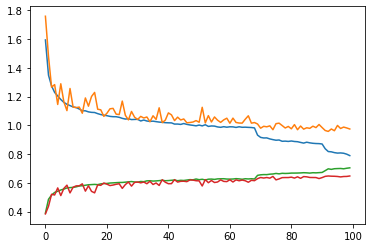

In [10]:
import pickle
pickle.dump(hist, open('featureactv34_baseline_modelv22_hist.hdf5', 'wb'))
plt.plot(hist), best_acc

In [11]:
test_model = torch.load('featureactv34_baseline_modelv22.pt')

# EVALUATE
test_model.eval()
running_valloss = 0.0
running_valacc = 0.0
for i,data in enumerate(test_loader):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = test_model(inputs)

    loss = criterion(outputs, labels)
    acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

    running_valloss += (loss.item() * inputs.size(0))
    running_valacc += acc.item()

print('- Avg. val_loss: %.3f | Avg. val_acc: %.3f' % (running_valloss / len(test_loader.dataset), running_valacc / len(test_loader.dataset)))

- Avg. val_loss: 0.935 | Avg. val_acc: 0.655


In [12]:
for epoch in range(100, 130):  # loop over the dataset multiple times

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0
    processed = 0.0

    # TRAIN
    model.train()
    pbar = tqdm(train_loader, position=0)
    for i, data in enumerate(pbar):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()
        loss.backward()
        
        optimizer.step()

        # print statistics
        running_loss += (loss.item() * inputs.size(0))
        running_acc += acc.item()
        processed += len(inputs)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={i} Accuracy={acc.item() / inputs.size(0)}')

    print('- Avg.loss: %.3f | Avg.acc: %.3f' % (running_loss / len(train_loader.dataset), running_acc / len(train_loader.dataset)))
    avgloss = running_loss / len(train_loader.dataset)
    avgacc = running_acc / len(train_loader.dataset)

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

        running_valloss += (loss.item() * inputs.size(0))
        running_valacc += acc.item()

    print('- Avg. val_loss: %.3f | Avg. val_acc: %.3f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

    avgvalloss = running_valloss / len(val_loader.dataset)
    avgvalacc = running_valacc / len(val_loader.dataset)
    
    scheduler.step(avgvalloss)

    hist.append([avgloss, avgvalloss, avgacc, avgvalacc])
    
    if best_acc < avgvalacc:
        best_acc = avgvalacc
        torch.save(model, model_path)
        print('* Update optimal model')

print('Finished Training')

  0%|          | 0/225 [00:00<?, ?it/s]

Epoch:  101


Loss=1.0486334562301636 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:35<00:00,  6.29it/s]

- Avg.loss: 0.787 | Avg.acc: 0.706



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.980 | Avg. val_acc: 0.643
Epoch   101: reducing learning rate of group 0 to 5.0000e-04.
Epoch:  102


Loss=0.6477631330490112 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [00:35<00:00,  6.28it/s]

- Avg.loss: 0.765 | Avg.acc: 0.716



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.959 | Avg. val_acc: 0.646
Epoch:  103


Loss=0.8313767910003662 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:35<00:00,  6.32it/s]

- Avg.loss: 0.756 | Avg.acc: 0.718



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.960 | Avg. val_acc: 0.652
* Update optimal model
Epoch:  104


Loss=0.7267869710922241 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:36<00:00,  6.22it/s]

- Avg.loss: 0.752 | Avg.acc: 0.722



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.972 | Avg. val_acc: 0.644
Epoch:  105


Loss=0.9436954855918884 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:35<00:00,  6.28it/s]

- Avg.loss: 0.749 | Avg.acc: 0.721



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.972 | Avg. val_acc: 0.651
Epoch:  106


Loss=0.7172790169715881 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:36<00:00,  6.22it/s]

- Avg.loss: 0.738 | Avg.acc: 0.724



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.979 | Avg. val_acc: 0.643
Epoch:  107


Loss=0.5885956883430481 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:35<00:00,  6.27it/s]

- Avg.loss: 0.739 | Avg.acc: 0.726



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.975 | Avg. val_acc: 0.650
Epoch:  108


Loss=0.8745281100273132 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:35<00:00,  6.28it/s]

- Avg.loss: 0.739 | Avg.acc: 0.724



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.978 | Avg. val_acc: 0.650
Epoch:  109


Loss=0.657071590423584 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:35<00:00,  6.32it/s]

- Avg.loss: 0.733 | Avg.acc: 0.726



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.985 | Avg. val_acc: 0.649
Epoch   109: reducing learning rate of group 0 to 2.5000e-04.
Epoch:  110


Loss=1.1354453563690186 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:35<00:00,  6.29it/s]

- Avg.loss: 0.724 | Avg.acc: 0.730



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.968 | Avg. val_acc: 0.651
Epoch:  111


Loss=0.6186593770980835 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:35<00:00,  6.25it/s]

- Avg.loss: 0.715 | Avg.acc: 0.733



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.971 | Avg. val_acc: 0.653
* Update optimal model
Epoch:  112


Loss=0.5104192495346069 Batch_id=224 Accuracy=0.8918918918918919: 100%|██████████| 225/225 [00:35<00:00,  6.30it/s]

- Avg.loss: 0.715 | Avg.acc: 0.733



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.973 | Avg. val_acc: 0.649
Epoch:  113


Loss=0.9446524381637573 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:35<00:00,  6.31it/s]

- Avg.loss: 0.709 | Avg.acc: 0.735



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.977 | Avg. val_acc: 0.651
Epoch:  114


Loss=0.636622428894043 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:35<00:00,  6.30it/s]

- Avg.loss: 0.706 | Avg.acc: 0.738



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.982 | Avg. val_acc: 0.652
Epoch:  115


Loss=0.8578847050666809 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:35<00:00,  6.28it/s]

- Avg.loss: 0.704 | Avg.acc: 0.739



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.980 | Avg. val_acc: 0.651
Epoch:  116


Loss=0.6026352643966675 Batch_id=224 Accuracy=0.8108108108108109: 100%|██████████| 225/225 [00:36<00:00,  6.25it/s]

- Avg.loss: 0.706 | Avg.acc: 0.738



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.978 | Avg. val_acc: 0.653
Epoch:  117


Loss=1.1273082494735718 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:35<00:00,  6.30it/s]

- Avg.loss: 0.700 | Avg.acc: 0.741



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.974 | Avg. val_acc: 0.653
Epoch   117: reducing learning rate of group 0 to 1.2500e-04.
* Update optimal model
Epoch:  118


Loss=0.7105532288551331 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:36<00:00,  6.24it/s]

- Avg.loss: 0.699 | Avg.acc: 0.741



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.976 | Avg. val_acc: 0.653
* Update optimal model
Epoch:  119


Loss=1.046607255935669 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:36<00:00,  6.23it/s]

- Avg.loss: 0.695 | Avg.acc: 0.740



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.975 | Avg. val_acc: 0.657
* Update optimal model
Epoch:  120


Loss=0.7572702169418335 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:36<00:00,  6.21it/s]

- Avg.loss: 0.692 | Avg.acc: 0.745



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.971 | Avg. val_acc: 0.657
Epoch:  121


Loss=0.7524381875991821 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:36<00:00,  6.25it/s]

- Avg.loss: 0.689 | Avg.acc: 0.745



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.977 | Avg. val_acc: 0.656
Epoch:  122


Loss=0.4993981420993805 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [00:36<00:00,  6.22it/s]

- Avg.loss: 0.678 | Avg.acc: 0.750



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.975 | Avg. val_acc: 0.656
Epoch:  123


Loss=0.5736899375915527 Batch_id=224 Accuracy=0.8378378378378378: 100%|██████████| 225/225 [00:36<00:00,  6.23it/s]

- Avg.loss: 0.684 | Avg.acc: 0.747



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.979 | Avg. val_acc: 0.654
Epoch:  124


Loss=0.9820811152458191 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:35<00:00,  6.27it/s]

- Avg.loss: 0.683 | Avg.acc: 0.749



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.976 | Avg. val_acc: 0.654
Epoch:  125


Loss=0.8086789846420288 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:36<00:00,  6.24it/s]

- Avg.loss: 0.689 | Avg.acc: 0.742



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.977 | Avg. val_acc: 0.658
Epoch   125: reducing learning rate of group 0 to 6.2500e-05.
* Update optimal model
Epoch:  126


Loss=0.671687662601471 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:35<00:00,  6.25it/s]

- Avg.loss: 0.678 | Avg.acc: 0.748



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.977 | Avg. val_acc: 0.654
Epoch:  127


Loss=0.8347411155700684 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:36<00:00,  6.24it/s]

- Avg.loss: 0.683 | Avg.acc: 0.747



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.977 | Avg. val_acc: 0.657
Epoch:  128


Loss=0.46715447306632996 Batch_id=224 Accuracy=0.8108108108108109: 100%|██████████| 225/225 [00:36<00:00,  6.25it/s]

- Avg.loss: 0.680 | Avg.acc: 0.746



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.976 | Avg. val_acc: 0.654
Epoch:  129


Loss=1.0225497484207153 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:36<00:00,  6.24it/s]

- Avg.loss: 0.680 | Avg.acc: 0.748



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.978 | Avg. val_acc: 0.655
Epoch:  130


Loss=0.8969325423240662 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:36<00:00,  6.23it/s]

- Avg.loss: 0.681 | Avg.acc: 0.751


- Avg. val_loss: 0.975 | Avg. val_acc: 0.654
Finished Training


([<matplotlib.lines.Line2D at 0x7f506eaae6a0>,
 0.6575647812761215)

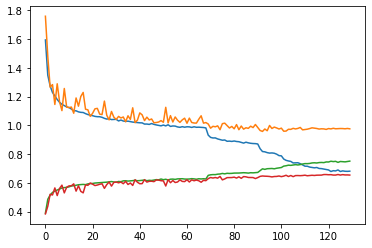

In [13]:
import pickle
pickle.dump(hist, open('featureactv34_baseline_modelv22_hist.hdf5', 'wb'))
plt.plot(hist), best_acc

In [14]:
test_model = torch.load('featureactv34_baseline_modelv22.pt')

# EVALUATE
test_model.eval()
running_valloss = 0.0
running_valacc = 0.0
for i,data in enumerate(test_loader):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = test_model(inputs)

    loss = criterion(outputs, labels)
    acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

    running_valloss += (loss.item() * inputs.size(0))
    running_valacc += acc.item()

print('- Avg. val_loss: %.3f | Avg. val_acc: %.3f' % (running_valloss / len(test_loader.dataset), running_valacc / len(test_loader.dataset)))

- Avg. val_loss: 0.942 | Avg. val_acc: 0.663


## v3.4 multi-head

In [5]:
class FeatureAct(nn.Module):
    def __init__(self, src_depth, n_heads=4):
        super(FeatureAct, self).__init__()
        
        self.n_heads = n_heads
        self.dim = src_depth // n_heads
        
        self.softmax = nn.Softmax(dim=2)
        
        self.src_conv = nn.Conv2d(src_depth, src_depth, kernel_size=1, padding=False)
        self.target_conv = nn.Conv2d(src_depth, src_depth, kernel_size=1, padding=False)
        
        self.down_depth = nn.Sequential(nn.Conv2d(src_depth, src_depth, kernel_size=1, padding=False),
                                        nn.ReLU(inplace=True))
#         self.up_depth = nn.Sequential(nn.Conv2d(src_depth, src_depth, kernel_size=1, padding=False),
#                                       nn.ReLU(inplace=True))
        
    def forward(self, x):
        
        src_features = self.src_conv(x)
        src_features = src_features.view(-1, self.n_heads, self.dim, src_features.size(-2), src_features.size(-1))
        target_features = self.target_conv(x)
        target_features = target_features.view(-1, self.n_heads, self.dim, target_features.size(-2), target_features.size(-1))
        
        cor = nn.Flatten(-2)(src_features[:, :, None, :, :]).permute(0,1,3,2,4) * nn.Flatten(-2)(target_features[:, :, None, :, :])
        cor = cor / (torch.norm(cor) + 1e-7)

        cor = self.softmax(cor)
        
        main_features = self.down_depth(x)
        main_features = main_features.view(-1, self.n_heads, self.dim, main_features.size(-2), main_features.size(-1))
    
        cor_feature = [(main_features * cor[:, :, :, k].view(-1, self.n_heads, src_features.size(-3), src_features.size(-2), src_features.size(-1))).sum(2, keepdim=True) for k in range(cor.size(2))]
        cor_feature = torch.cat(cor_feature, dim=2)
        cor_feature = cor_feature.view(-1, self.n_heads*self.dim, cor_feature.size(-2), cor_feature.size(-1))

        # proj_conv1 ?
        
        x = x + cor_feature
        
        return x

In [6]:
class BaselineFeatureAct(nn.Module):
    def __init__(self, embeddings=False):
        
        super(BaselineFeatureAct, self).__init__()
        
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=(2,2), stride=2)
        
        self.conv0 = nn.Conv2d(1, 32, kernel_size=(3,3), padding=1, stride=1)
        self.conv0b = nn.Conv2d(32, 32, kernel_size=(3,3), padding=1, stride=1)
        self.bn0 = nn.BatchNorm2d(32)
        self.bn0b = nn.BatchNorm2d(32)
        
        self.conv1 = nn.Conv2d(32, 64, kernel_size=(3,3), padding=1, stride=1)
        self.conv1b = nn.Conv2d(64, 64, kernel_size=(3,3), padding=1, stride=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.bn1b = nn.BatchNorm2d(64)
        
        self.conv2 = nn.Conv2d(64, 128, kernel_size=(3,3), padding=1, stride=1)
        self.conv2b = nn.Conv2d(128, 128, kernel_size=(3,3), padding=1, stride=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn2b = nn.BatchNorm2d(128)
        
        self.conv3 = nn.Conv2d(128, 256, kernel_size=(3,3), padding=1, stride=1)
        self.conv3b = nn.Conv2d(256, 256, kernel_size=(3,3), padding=1, stride=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.bn3b = nn.BatchNorm2d(256)
  
        self.fact0 = FeatureAct(32, 4)
        self.fact1 = FeatureAct(64, 4)
        self.fact2 = FeatureAct(128, 4)
        self.fact3 = FeatureAct(256, 4)
        
        if not embeddings:
            self.classifier = nn.Sequential(nn.Flatten(),
                                            nn.Linear(2304, 256), nn.BatchNorm1d(256), nn.ReLU(inplace=True),
                                            nn.Linear(256, 128), nn.BatchNorm1d(128), nn.ReLU(inplace=True),
                                            nn.Linear(128, 7), nn.BatchNorm1d(7))
        else:
            self.classifier = nn.Sequential(nn.Flatten(),
                                            nn.Linear(2304, 256), nn.BatchNorm1d(256), nn.ReLU(inplace=True),
                                            nn.Linear(256, 128), nn.BatchNorm1d(128))
        
    def forward(self, x):
        
        x = self.conv0(x)
        x = self.bn0(x)
        x = self.relu(x)
        x = self.conv0b(x)
        x = self.bn0b(x)
        x = self.relu(x)
        
        x0 = self.maxpool(x)
        x0 = self.fact0(x0)
        
        x = self.conv1(x0)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv1b(x)
        x = self.bn1b(x)
        x = self.relu(x)
        
        x1 = self.maxpool(x)
        x1 = self.fact1(x1)
        
        x = self.conv2(x1)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv2b(x)
        x = self.bn2b(x)
        x = self.relu(x)
        
        x2 = self.maxpool(x)
        x2 = self.fact2(x2)
        
        x = self.conv3(x2)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.conv3b(x)
        x = self.bn3b(x)
        x = self.relu(x)
        
        x3 = self.maxpool(x)
        x3 = self.fact3(x3)
        
        x = nn.Flatten()(x3)
        x = self.classifier(x)
        
        return x

In [7]:
device = torch.device('cuda')
model = BaselineFeatureAct().to(device)

best_acc = 0.0
hist = []

epochs=100

criterion = nn.CrossEntropyLoss()

learning_rate = 0.004
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=7, verbose=True)


In [8]:
model_path = './featureactv341_baseline_modelv22.pt'

for epoch in range(100):  # loop over the dataset multiple times

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0
    processed = 0.0

    # TRAIN
    model.train()
    pbar = tqdm(train_loader, position=0)
    for i, data in enumerate(pbar):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()
        loss.backward()
        
        optimizer.step()

        # print statistics
        running_loss += (loss.item() * inputs.size(0))
        running_acc += acc.item()
        processed += len(inputs)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={i} Accuracy={acc.item() / inputs.size(0)}')

    print('- Avg.loss: %.3f | Avg.acc: %.3f' % (running_loss / len(train_loader.dataset), running_acc / len(train_loader.dataset)))
    avgloss = running_loss / len(train_loader.dataset)
    avgacc = running_acc / len(train_loader.dataset)

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

        running_valloss += (loss.item() * inputs.size(0))
        running_valacc += acc.item()

    print('- Avg. val_loss: %.3f | Avg. val_acc: %.3f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

    avgvalloss = running_valloss / len(val_loader.dataset)
    avgvalacc = running_valacc / len(val_loader.dataset)
    
    scheduler.step(avgvalloss)

    hist.append([avgloss, avgvalloss, avgacc, avgvalacc])
    
    if best_acc < avgvalacc:
        best_acc = avgvalacc
        torch.save(model, model_path)
        print('* Update optimal model')

print('Finished Training')

  0%|          | 0/225 [00:00<?, ?it/s]

Epoch:  1


Loss=1.5006849765777588 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [01:36<00:00,  2.34it/s]

- Avg.loss: 1.658 | Avg.acc: 0.363



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.451 | Avg. val_acc: 0.449
* Update optimal model
Epoch:  2


Loss=1.2497353553771973 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [01:36<00:00,  2.34it/s]

- Avg.loss: 1.378 | Avg.acc: 0.473



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.457 | Avg. val_acc: 0.471
* Update optimal model
Epoch:  3


Loss=1.1731280088424683 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [01:36<00:00,  2.33it/s]

- Avg.loss: 1.291 | Avg.acc: 0.511



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.306 | Avg. val_acc: 0.512
* Update optimal model
Epoch:  4


Loss=0.9723623394966125 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [01:36<00:00,  2.32it/s]

- Avg.loss: 1.244 | Avg.acc: 0.525



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.209 | Avg. val_acc: 0.539
* Update optimal model
Epoch:  5


Loss=1.0822540521621704 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [01:36<00:00,  2.33it/s]

- Avg.loss: 1.200 | Avg.acc: 0.544



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.197 | Avg. val_acc: 0.551
* Update optimal model
Epoch:  6


Loss=1.1260883808135986 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [01:36<00:00,  2.33it/s]

- Avg.loss: 1.180 | Avg.acc: 0.551



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.154 | Avg. val_acc: 0.573
* Update optimal model
Epoch:  7


Loss=1.2359050512313843 Batch_id=224 Accuracy=0.43243243243243246: 100%|██████████| 225/225 [01:36<00:00,  2.34it/s]

- Avg.loss: 1.167 | Avg.acc: 0.556



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.144 | Avg. val_acc: 0.570
Epoch:  8


Loss=1.0095860958099365 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [01:36<00:00,  2.33it/s]

- Avg.loss: 1.152 | Avg.acc: 0.561



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.247 | Avg. val_acc: 0.538
Epoch:  9


Loss=1.2867512702941895 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [01:36<00:00,  2.33it/s]

- Avg.loss: 1.138 | Avg.acc: 0.568



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.155 | Avg. val_acc: 0.563
Epoch:  10


Loss=1.0578365325927734 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [01:36<00:00,  2.33it/s]

- Avg.loss: 1.127 | Avg.acc: 0.573



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.216 | Avg. val_acc: 0.551
Epoch:  11


Loss=1.1277148723602295 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [01:36<00:00,  2.33it/s]

- Avg.loss: 1.126 | Avg.acc: 0.572



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.105 | Avg. val_acc: 0.577
* Update optimal model
Epoch:  12


Loss=1.0224276781082153 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [01:36<00:00,  2.34it/s]

- Avg.loss: 1.111 | Avg.acc: 0.578



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.140 | Avg. val_acc: 0.568
Epoch:  13


Loss=1.2033756971359253 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [01:36<00:00,  2.33it/s]

- Avg.loss: 1.115 | Avg.acc: 0.576



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.120 | Avg. val_acc: 0.586
* Update optimal model
Epoch:  14


Loss=1.3253974914550781 Batch_id=224 Accuracy=0.40540540540540543: 100%|██████████| 225/225 [01:35<00:00,  2.35it/s]

- Avg.loss: 1.095 | Avg.acc: 0.584



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.157 | Avg. val_acc: 0.573
Epoch:  15


Loss=1.2667657136917114 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [01:36<00:00,  2.33it/s]

- Avg.loss: 1.096 | Avg.acc: 0.585



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.106 | Avg. val_acc: 0.588
* Update optimal model
Epoch:  16


Loss=1.0961660146713257 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [01:36<00:00,  2.33it/s]

- Avg.loss: 1.090 | Avg.acc: 0.587



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.104 | Avg. val_acc: 0.583
Epoch:  17


Loss=1.238265872001648 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [01:36<00:00,  2.33it/s]

- Avg.loss: 1.085 | Avg.acc: 0.590



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.192 | Avg. val_acc: 0.543
Epoch:  18


Loss=1.162672758102417 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [01:36<00:00,  2.33it/s]

- Avg.loss: 1.084 | Avg.acc: 0.590



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.158 | Avg. val_acc: 0.562
Epoch:  19


Loss=1.1122303009033203 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [01:36<00:00,  2.33it/s]

- Avg.loss: 1.078 | Avg.acc: 0.594



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.095 | Avg. val_acc: 0.587
Epoch:  20


Loss=0.9158731698989868 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [01:36<00:00,  2.33it/s]

- Avg.loss: 1.069 | Avg.acc: 0.596



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.101 | Avg. val_acc: 0.586
Epoch:  21


Loss=1.1037323474884033 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [01:36<00:00,  2.34it/s]

- Avg.loss: 1.069 | Avg.acc: 0.594



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.137 | Avg. val_acc: 0.565
Epoch:  22


Loss=1.0909483432769775 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [01:35<00:00,  2.34it/s]

- Avg.loss: 1.065 | Avg.acc: 0.599



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.087 | Avg. val_acc: 0.592
* Update optimal model
Epoch:  23


Loss=1.136641263961792 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [01:36<00:00,  2.33it/s]

- Avg.loss: 1.057 | Avg.acc: 0.602



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.057 | Avg. val_acc: 0.599
* Update optimal model
Epoch:  24


Loss=1.1360481977462769 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [01:36<00:00,  2.34it/s]

- Avg.loss: 1.053 | Avg.acc: 0.599



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.102 | Avg. val_acc: 0.592
Epoch:  25


Loss=0.9210764765739441 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [01:36<00:00,  2.33it/s]

- Avg.loss: 1.054 | Avg.acc: 0.602



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.092 | Avg. val_acc: 0.600
* Update optimal model
Epoch:  26


Loss=1.0201822519302368 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [01:36<00:00,  2.33it/s]

- Avg.loss: 1.047 | Avg.acc: 0.605



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.074 | Avg. val_acc: 0.587
Epoch:  27


Loss=1.036328911781311 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [01:36<00:00,  2.32it/s]

- Avg.loss: 1.049 | Avg.acc: 0.604



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.045 | Avg. val_acc: 0.609
* Update optimal model
Epoch:  28


Loss=0.8221591711044312 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [01:36<00:00,  2.33it/s]

- Avg.loss: 1.042 | Avg.acc: 0.603



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.075 | Avg. val_acc: 0.601
Epoch:  29


Loss=0.8941872119903564 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [01:36<00:00,  2.33it/s]

- Avg.loss: 1.039 | Avg.acc: 0.606



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.070 | Avg. val_acc: 0.597
Epoch:  30


Loss=1.0942057371139526 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [01:36<00:00,  2.33it/s]

- Avg.loss: 1.033 | Avg.acc: 0.609



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.064 | Avg. val_acc: 0.607
Epoch:  32


Loss=1.0354658365249634 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [01:36<00:00,  2.33it/s]

- Avg.loss: 1.036 | Avg.acc: 0.607



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.083 | Avg. val_acc: 0.586
Epoch:  33


Loss=0.9668315052986145 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [01:36<00:00,  2.33it/s]

- Avg.loss: 1.033 | Avg.acc: 0.611



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.086 | Avg. val_acc: 0.592
Epoch:  34


Loss=0.876098096370697 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [01:36<00:00,  2.34it/s]

- Avg.loss: 1.027 | Avg.acc: 0.614



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.048 | Avg. val_acc: 0.596
Epoch:  35


Loss=0.9218471646308899 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [01:36<00:00,  2.33it/s]

- Avg.loss: 1.022 | Avg.acc: 0.611



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.052 | Avg. val_acc: 0.605
Epoch    35: reducing learning rate of group 0 to 2.0000e-03.
Epoch:  36


Loss=0.8942644000053406 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [01:36<00:00,  2.34it/s]

- Avg.loss: 0.976 | Avg.acc: 0.632



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.014 | Avg. val_acc: 0.629
* Update optimal model
Epoch:  37


Loss=0.7082752585411072 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [01:36<00:00,  2.95it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Loss=0.8406694531440735 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [01:36<00:00,  2.33it/s]

- Avg.loss: 0.835 | Avg.acc: 0.687



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.975 | Avg. val_acc: 0.636
Epoch:  56


Loss=1.1707156896591187 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [01:36<00:00,  2.32it/s]

- Avg.loss: 0.828 | Avg.acc: 0.689



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.980 | Avg. val_acc: 0.637
Epoch:  57


Loss=0.9699331521987915 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [01:36<00:00,  2.33it/s]

- Avg.loss: 0.824 | Avg.acc: 0.692



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.979 | Avg. val_acc: 0.639
Epoch:  58


Loss=0.6467986106872559 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [01:36<00:00,  2.33it/s]

- Avg.loss: 0.821 | Avg.acc: 0.692



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.989 | Avg. val_acc: 0.640
Epoch    58: reducing learning rate of group 0 to 5.0000e-04.
Epoch:  59


Loss=0.7603060603141785 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [01:36<00:00,  2.33it/s]

- Avg.loss: 0.791 | Avg.acc: 0.707



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.966 | Avg. val_acc: 0.646
* Update optimal model
Epoch:  60


Loss=0.7506513595581055 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [01:36<00:00,  2.33it/s]

- Avg.loss: 0.778 | Avg.acc: 0.711



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.973 | Avg. val_acc: 0.648
* Update optimal model
Epoch:  61


Loss=0.8492628335952759 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [01:36<00:00,  2.34it/s]

- Avg.loss: 0.777 | Avg.acc: 0.710



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.982 | Avg. val_acc: 0.641
Epoch:  62


Loss=0.7256269454956055 Batch_id=76 Accuracy=0.75:  34%|███▍      | 77/225 [00:34<01:02,  2.37it/s]     IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Loss=0.6620901226997375 Batch_id=224 Accuracy=0.8108108108108109: 100%|██████████| 225/225 [01:37<00:00,  2.32it/s]

- Avg.loss: 0.678 | Avg.acc: 0.747



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.990 | Avg. val_acc: 0.650
Epoch:  81


Loss=0.7656060457229614 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [01:36<00:00,  2.33it/s]

- Avg.loss: 0.676 | Avg.acc: 0.751



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.995 | Avg. val_acc: 0.651
Epoch:  82


Loss=0.6907156705856323 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [01:36<00:00,  2.33it/s]

- Avg.loss: 0.679 | Avg.acc: 0.750



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.987 | Avg. val_acc: 0.646
Epoch:  83


Loss=0.7824210524559021 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [01:36<00:00,  2.33it/s]

- Avg.loss: 0.674 | Avg.acc: 0.752



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.996 | Avg. val_acc: 0.643
Epoch    83: reducing learning rate of group 0 to 6.2500e-05.
Epoch:  84


Loss=0.6185754537582397 Batch_id=224 Accuracy=0.8648648648648649: 100%|██████████| 225/225 [01:36<00:00,  2.33it/s]

- Avg.loss: 0.669 | Avg.acc: 0.752



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.987 | Avg. val_acc: 0.649
Epoch:  85


Loss=0.6326965689659119 Batch_id=224 Accuracy=0.8378378378378378: 100%|██████████| 225/225 [01:36<00:00,  2.33it/s]

- Avg.loss: 0.663 | Avg.acc: 0.759



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.994 | Avg. val_acc: 0.649
Epoch:  86


Loss=0.6842529773712158 Batch_id=208 Accuracy=0.6875:  92%|█████████▏| 208/225 [01:30<00:07,  2.37it/s]   IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



([<matplotlib.lines.Line2D at 0x7f5a20843cf8>,
 0.6528280858177765)

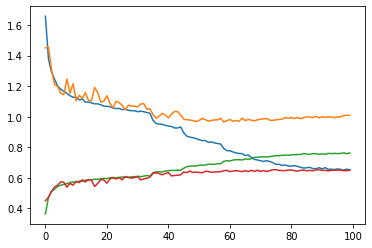

In [9]:
import pickle
pickle.dump(hist, open('featureactv341_baseline_modelv22_hist.hdf5', 'wb'))

plt.plot(hist), best_acc

In [10]:
test_model = torch.load('featureactv341_baseline_modelv22.pt')

# EVALUATE
test_model.eval()
running_valloss = 0.0
running_valacc = 0.0
for i,data in enumerate(test_loader):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = test_model(inputs)

    loss = criterion(outputs, labels)
    acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

    running_valloss += (loss.item() * inputs.size(0))
    running_valacc += acc.item()

print('- Avg. val_loss: %.3f | Avg. val_acc: %.3f' % (running_valloss / len(test_loader.dataset), running_valacc / len(test_loader.dataset)))

- Avg. val_loss: 0.962 | Avg. val_acc: 0.660


## v3.4.2 +bn -l2 group_conv for qkv

In [11]:
class FeatureAct(nn.Module):
    def __init__(self, src_depth, img_size, n_heads=4):
        super(FeatureAct, self).__init__()
        
        self.n_heads = n_heads
        self.dim = src_depth // n_heads
        self.batchnorm = nn.BatchNorm2d(src_depth)
        
        self.pos = nn.Parameter(torch.zeros(src_depth, img_size, img_size))
        self.softmax = nn.Softmax(dim=3)
        self.map_conv = nn.Conv2d(src_depth, 3*src_depth, kernel_size=1, padding=False)
        self.proj_conv = nn.Conv2d(src_depth, src_depth, kernel_size=1, padding=False)
        
    def forward(self, x):
        x = x + self.pos
        x_norm = self.batchnorm(x)
        
        x_map = self.map_conv(x_norm)
        x_map = x_map.view(-1, 3, x.size(-3), x.size(-2), x.size(-1))
        
        main_features, src_features, target_features = x_map[:,0], x_map[:,1], x_map[:,2]
        
        src_features = src_features.view(-1, self.n_heads, self.dim, src_features.size(-2), src_features.size(-1))
        target_features = target_features.view(-1, self.n_heads, self.dim, target_features.size(-2), target_features.size(-1))
        main_features = main_features.view(-1, self.n_heads, self.dim, main_features.size(-2), main_features.size(-1))
        
        cor = nn.Flatten(-2)(src_features[:, :, None, :, :]).permute(0,1,3,2,4) * nn.Flatten(-2)(target_features[:, :, None, :, :])
        cor = cor * (cor.size(2)**(-0.5))
        cor = self.softmax(cor)
    
        cor_feature = [(main_features * cor[:, :, :, k].view(-1, self.n_heads, src_features.size(-3), src_features.size(-2), src_features.size(-1))).sum(2, keepdim=True) for k in range(cor.size(2))]
        cor_feature = torch.cat(cor_feature, dim=2)
        cor_feature = cor_feature.view(-1, self.n_heads*self.dim, cor_feature.size(-2), cor_feature.size(-1))
        
        cor_feature = self.proj_conv(cor_feature)
        
        x = x + cor_feature
        
        return x

In [12]:
class BaselineFeatureAct(nn.Module):
    def __init__(self, embeddings=False):
        
        super(BaselineFeatureAct, self).__init__()
        
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=(2,2), stride=2)
        
        self.conv0 = nn.Conv2d(1, 32, kernel_size=(3,3), padding=1, stride=1)
        self.conv0b = nn.Conv2d(32, 32, kernel_size=(3,3), padding=1, stride=1)
        self.bn0 = nn.BatchNorm2d(32)
        self.bn0b = nn.BatchNorm2d(32)
        
        self.conv1 = nn.Conv2d(32, 64, kernel_size=(3,3), padding=1, stride=1)
        self.conv1b = nn.Conv2d(64, 64, kernel_size=(3,3), padding=1, stride=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.bn1b = nn.BatchNorm2d(64)
        
        self.conv2 = nn.Conv2d(64, 128, kernel_size=(3,3), padding=1, stride=1)
        self.conv2b = nn.Conv2d(128, 128, kernel_size=(3,3), padding=1, stride=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn2b = nn.BatchNorm2d(128)
        
        self.conv3 = nn.Conv2d(128, 256, kernel_size=(3,3), padding=1, stride=1)
        self.conv3b = nn.Conv2d(256, 256, kernel_size=(3,3), padding=1, stride=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.bn3b = nn.BatchNorm2d(256)
  
        self.fact0 = FeatureAct(32, 24, 4)
        self.fact1 = FeatureAct(64, 12, 4)
        self.fact2 = FeatureAct(128, 6, 4)
        self.fact3 = FeatureAct(256, 3, 4)
        
        if not embeddings:
            self.classifier = nn.Sequential(nn.Flatten(),
                                            nn.Linear(2304, 256), nn.BatchNorm1d(256), nn.ReLU(inplace=True),
                                            nn.Linear(256, 128), nn.BatchNorm1d(128), nn.ReLU(inplace=True),
                                            nn.Linear(128, 7), nn.BatchNorm1d(7))
        else:
            self.classifier = nn.Sequential(nn.Flatten(),
                                            nn.Linear(2304, 256), nn.BatchNorm1d(256), nn.ReLU(inplace=True),
                                            nn.Linear(256, 128), nn.BatchNorm1d(128))
        
    def forward(self, x):
        
        x = self.conv0(x)
        x = self.bn0(x)
        x = self.relu(x)
        x = self.conv0b(x)
        x = self.bn0b(x)
        x = self.relu(x)
        
        x0 = self.maxpool(x)
        x0 = self.fact0(x0)
        
        x = self.conv1(x0)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv1b(x)
        x = self.bn1b(x)
        x = self.relu(x)
        
        x1 = self.maxpool(x)
        x1 = self.fact1(x1)
        
        x = self.conv2(x1)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv2b(x)
        x = self.bn2b(x)
        x = self.relu(x)
        
        x2 = self.maxpool(x)
        x2 = self.fact2(x2)
        
        x = self.conv3(x2)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.conv3b(x)
        x = self.bn3b(x)
        x = self.relu(x)
        
        x3 = self.maxpool(x)
        x3 = self.fact3(x3)
        
        x = nn.Flatten()(x3)
        x = self.classifier(x)
        
        return x

In [13]:
device = torch.device('cuda')
model = BaselineFeatureAct().to(device)

best_acc = 0.0
hist = []

epochs=100

criterion = nn.CrossEntropyLoss()

learning_rate = 0.004
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=7, verbose=True)


In [11]:
model_path = './featureactv342_baseline_modelv22.pt'

for epoch in range(100):  # loop over the dataset multiple times

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0
    processed = 0.0

    # TRAIN
    model.train()
    pbar = tqdm(train_loader, position=0)
    for i, data in enumerate(pbar):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()
        loss.backward()
        
        optimizer.step()

        # print statistics
        running_loss += (loss.item() * inputs.size(0))
        running_acc += acc.item()
        processed += len(inputs)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={i} Accuracy={acc.item() / inputs.size(0)}')

    print('- Avg.loss: %.3f | Avg.acc: %.3f' % (running_loss / len(train_loader.dataset), running_acc / len(train_loader.dataset)))
    avgloss = running_loss / len(train_loader.dataset)
    avgacc = running_acc / len(train_loader.dataset)

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

        running_valloss += (loss.item() * inputs.size(0))
        running_valacc += acc.item()

    print('- Avg. val_loss: %.3f | Avg. val_acc: %.3f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

    avgvalloss = running_valloss / len(val_loader.dataset)
    avgvalacc = running_valacc / len(val_loader.dataset)
    
    scheduler.step(avgvalloss)

    hist.append([avgloss, avgvalloss, avgacc, avgvalacc])
    
    if best_acc < avgvalacc:
        best_acc = avgvalacc
        torch.save(model, model_path)
        print('* Update optimal model')

print('Finished Training')

  0%|          | 0/225 [00:00<?, ?it/s]

Epoch:  1


Loss=1.6253916025161743 Batch_id=224 Accuracy=0.35135135135135137: 100%|██████████| 225/225 [01:33<00:00,  2.40it/s]

- Avg.loss: 1.721 | Avg.acc: 0.322



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.741 | Avg. val_acc: 0.367
* Update optimal model
Epoch:  2


Loss=1.5187739133834839 Batch_id=224 Accuracy=0.40540540540540543: 100%|██████████| 225/225 [01:34<00:00,  2.39it/s]

- Avg.loss: 1.444 | Avg.acc: 0.445



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.470 | Avg. val_acc: 0.448
* Update optimal model
Epoch:  3


Loss=1.254477858543396 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [01:34<00:00,  2.39it/s]

- Avg.loss: 1.344 | Avg.acc: 0.480



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.580 | Avg. val_acc: 0.431
Epoch:  4


Loss=1.157485008239746 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [01:34<00:00,  2.39it/s]

- Avg.loss: 1.290 | Avg.acc: 0.507



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.249 | Avg. val_acc: 0.522
* Update optimal model
Epoch:  5


Loss=1.4685285091400146 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [01:34<00:00,  2.39it/s]

- Avg.loss: 1.251 | Avg.acc: 0.519



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.343 | Avg. val_acc: 0.511
Epoch:  6


Loss=1.0824954509735107 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [01:34<00:00,  2.39it/s]

- Avg.loss: 1.227 | Avg.acc: 0.532



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.258 | Avg. val_acc: 0.534
* Update optimal model
Epoch:  7


Loss=1.1315655708312988 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [01:34<00:00,  2.39it/s]

- Avg.loss: 1.205 | Avg.acc: 0.539



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.405 | Avg. val_acc: 0.491
Epoch:  8


Loss=1.3286434412002563 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [01:34<00:00,  2.39it/s]

- Avg.loss: 1.192 | Avg.acc: 0.550



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.178 | Avg. val_acc: 0.546
* Update optimal model
Epoch:  9


Loss=1.2128726243972778 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [01:34<00:00,  2.39it/s]

- Avg.loss: 1.174 | Avg.acc: 0.553



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.224 | Avg. val_acc: 0.551
* Update optimal model
Epoch:  10


Loss=1.129381537437439 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [01:33<00:00,  2.40it/s]

- Avg.loss: 1.162 | Avg.acc: 0.559



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.125 | Avg. val_acc: 0.573
* Update optimal model
Epoch:  11


Loss=1.0602153539657593 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [01:34<00:00,  2.39it/s]

- Avg.loss: 1.150 | Avg.acc: 0.562



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.223 | Avg. val_acc: 0.548
Epoch:  12


Loss=1.2218303680419922 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [01:33<00:00,  2.39it/s]

- Avg.loss: 1.143 | Avg.acc: 0.565



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.126 | Avg. val_acc: 0.572
Epoch:  13


Loss=1.1388585567474365 Batch_id=224 Accuracy=0.4594594594594595: 100%|██████████| 225/225 [01:34<00:00,  2.38it/s]

- Avg.loss: 1.141 | Avg.acc: 0.564



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.181 | Avg. val_acc: 0.557
Epoch:  14


Loss=1.1487023830413818 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [01:34<00:00,  2.39it/s]

- Avg.loss: 1.133 | Avg.acc: 0.570



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.216 | Avg. val_acc: 0.539
Epoch:  15


Loss=1.3492521047592163 Batch_id=224 Accuracy=0.4594594594594595: 100%|██████████| 225/225 [01:33<00:00,  2.40it/s]

- Avg.loss: 1.123 | Avg.acc: 0.572



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.167 | Avg. val_acc: 0.556
Epoch:  16


Loss=1.1132911443710327 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [01:33<00:00,  2.40it/s]

- Avg.loss: 1.116 | Avg.acc: 0.577



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.109 | Avg. val_acc: 0.575
* Update optimal model
Epoch:  17


Loss=0.9979085922241211 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [01:34<00:00,  2.39it/s]

- Avg.loss: 1.110 | Avg.acc: 0.578



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.091 | Avg. val_acc: 0.586
* Update optimal model
Epoch:  18


Loss=1.1178133487701416 Batch_id=224 Accuracy=0.4594594594594595: 100%|██████████| 225/225 [01:33<00:00,  2.40it/s]

- Avg.loss: 1.110 | Avg.acc: 0.579



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.123 | Avg. val_acc: 0.564
Epoch:  19


Loss=0.9777014255523682 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [01:33<00:00,  2.40it/s]

- Avg.loss: 1.099 | Avg.acc: 0.583



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.142 | Avg. val_acc: 0.574
Epoch:  20


Loss=1.079972505569458 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [01:33<00:00,  2.40it/s]

- Avg.loss: 1.093 | Avg.acc: 0.585



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.103 | Avg. val_acc: 0.578
Epoch:  21


Loss=1.2864367961883545 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [01:34<00:00,  2.39it/s]

- Avg.loss: 1.087 | Avg.acc: 0.589



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.137 | Avg. val_acc: 0.568
Epoch:  22


Loss=1.1629518270492554 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [01:33<00:00,  2.40it/s]

- Avg.loss: 1.086 | Avg.acc: 0.586



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.078 | Avg. val_acc: 0.585
Epoch:  23


Loss=1.0692329406738281 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [01:33<00:00,  2.39it/s]

- Avg.loss: 1.084 | Avg.acc: 0.590



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.092 | Avg. val_acc: 0.592
* Update optimal model
Epoch:  24


Loss=0.9880009293556213 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [01:34<00:00,  2.39it/s]

- Avg.loss: 1.075 | Avg.acc: 0.587



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.062 | Avg. val_acc: 0.596
* Update optimal model
Epoch:  25


Loss=1.3231433629989624 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [01:34<00:00,  2.39it/s]

- Avg.loss: 1.072 | Avg.acc: 0.597



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.083 | Avg. val_acc: 0.590
Epoch:  26


Loss=1.194083571434021 Batch_id=224 Accuracy=0.40540540540540543: 100%|██████████| 225/225 [01:33<00:00,  2.40it/s]

- Avg.loss: 1.065 | Avg.acc: 0.597



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.069 | Avg. val_acc: 0.605
* Update optimal model
Epoch:  27


Loss=1.0592467784881592 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [01:34<00:00,  2.39it/s]

- Avg.loss: 1.064 | Avg.acc: 0.596



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.094 | Avg. val_acc: 0.586
Epoch:  28


Loss=0.9256128668785095 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [01:33<00:00,  2.40it/s]

- Avg.loss: 1.062 | Avg.acc: 0.595



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.092 | Avg. val_acc: 0.589
Epoch:  29


Loss=0.8296216726303101 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [01:34<00:00,  2.39it/s]

- Avg.loss: 1.050 | Avg.acc: 0.601



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.150 | Avg. val_acc: 0.575
Epoch:  30


Loss=0.9998793601989746 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [01:33<00:00,  2.40it/s]

- Avg.loss: 1.048 | Avg.acc: 0.603



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.113 | Avg. val_acc: 0.573
Epoch:  31


Loss=1.1644092798233032 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [01:33<00:00,  2.40it/s]

- Avg.loss: 1.049 | Avg.acc: 0.605



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.057 | Avg. val_acc: 0.602
Epoch:  32


Loss=1.0823287963867188 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [01:34<00:00,  2.39it/s]

- Avg.loss: 1.049 | Avg.acc: 0.604



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.091 | Avg. val_acc: 0.584
Epoch:  33


Loss=1.2935963869094849 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [01:34<00:00,  2.39it/s]

- Avg.loss: 1.045 | Avg.acc: 0.605



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.055 | Avg. val_acc: 0.606
* Update optimal model
Epoch:  34


Loss=1.2729941606521606 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [01:34<00:00,  2.39it/s]

- Avg.loss: 1.042 | Avg.acc: 0.602



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.063 | Avg. val_acc: 0.600
Epoch:  35


Loss=1.1379815340042114 Batch_id=224 Accuracy=0.4594594594594595: 100%|██████████| 225/225 [01:33<00:00,  2.40it/s]

- Avg.loss: 1.039 | Avg.acc: 0.607



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.075 | Avg. val_acc: 0.598
Epoch:  36


Loss=1.0926456451416016 Batch_id=224 Accuracy=0.4594594594594595: 100%|██████████| 225/225 [01:34<00:00,  2.39it/s]

- Avg.loss: 1.034 | Avg.acc: 0.611



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.078 | Avg. val_acc: 0.598
Epoch:  37


Loss=0.9889695644378662 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [01:34<00:00,  2.39it/s]

- Avg.loss: 1.034 | Avg.acc: 0.607



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.088 | Avg. val_acc: 0.588
Epoch:  38


Loss=0.9129205942153931 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [01:34<00:00,  2.39it/s]

- Avg.loss: 1.034 | Avg.acc: 0.608



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.095 | Avg. val_acc: 0.602
Epoch:  39


Loss=1.1654341220855713 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [01:34<00:00,  2.39it/s]

- Avg.loss: 1.031 | Avg.acc: 0.610



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.056 | Avg. val_acc: 0.606
Epoch:  40


Loss=0.8973514437675476 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [01:33<00:00,  2.40it/s]

- Avg.loss: 1.028 | Avg.acc: 0.610



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.052 | Avg. val_acc: 0.598
Epoch:  41


Loss=1.2715588808059692 Batch_id=224 Accuracy=0.43243243243243246: 100%|██████████| 225/225 [01:34<00:00,  2.39it/s]

- Avg.loss: 1.024 | Avg.acc: 0.612



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.063 | Avg. val_acc: 0.591
Epoch:  42


Loss=0.9317941665649414 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [01:33<00:00,  2.40it/s]

- Avg.loss: 1.023 | Avg.acc: 0.615



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.074 | Avg. val_acc: 0.597
Epoch:  43


Loss=1.0256775617599487 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [01:34<00:00,  2.39it/s]

- Avg.loss: 1.022 | Avg.acc: 0.615



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.105 | Avg. val_acc: 0.580
Epoch:  44


Loss=0.9914869070053101 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [01:33<00:00,  2.40it/s]

- Avg.loss: 1.019 | Avg.acc: 0.614



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.037 | Avg. val_acc: 0.613
* Update optimal model
Epoch:  45


Loss=0.8090377449989319 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [01:34<00:00,  2.39it/s]

- Avg.loss: 1.018 | Avg.acc: 0.616



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.147 | Avg. val_acc: 0.570
Epoch:  46


Loss=1.2710018157958984 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [01:33<00:00,  2.40it/s]

- Avg.loss: 1.018 | Avg.acc: 0.613



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.041 | Avg. val_acc: 0.610
Epoch:  47


Loss=0.9818474054336548 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [01:34<00:00,  2.39it/s]

- Avg.loss: 1.022 | Avg.acc: 0.610



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.056 | Avg. val_acc: 0.595
Epoch:  48


Loss=1.0115925073623657 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [01:33<00:00,  2.39it/s]

- Avg.loss: 1.016 | Avg.acc: 0.617



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.039 | Avg. val_acc: 0.612
Epoch:  49


Loss=1.1180404424667358 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [01:34<00:00,  2.39it/s]

- Avg.loss: 1.015 | Avg.acc: 0.617



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.043 | Avg. val_acc: 0.606
Epoch:  50


Loss=0.9832947254180908 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [01:34<00:00,  2.39it/s]

- Avg.loss: 1.013 | Avg.acc: 0.617



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.054 | Avg. val_acc: 0.607
Epoch:  51


Loss=0.7563505172729492 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [01:33<00:00,  2.40it/s]

- Avg.loss: 1.009 | Avg.acc: 0.618



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.046 | Avg. val_acc: 0.607
Epoch:  52


Loss=1.1688412427902222 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [01:34<00:00,  2.39it/s]

- Avg.loss: 1.017 | Avg.acc: 0.616



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.027 | Avg. val_acc: 0.610
Epoch:  53


Loss=1.18746817111969 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [01:34<00:00,  2.39it/s]

- Avg.loss: 1.006 | Avg.acc: 0.620



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.026 | Avg. val_acc: 0.611
Epoch:  54


Loss=1.0137782096862793 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [01:34<00:00,  2.39it/s]

- Avg.loss: 1.007 | Avg.acc: 0.621



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.073 | Avg. val_acc: 0.597
Epoch:  55


Loss=1.002566933631897 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [01:34<00:00,  2.38it/s]

- Avg.loss: 1.010 | Avg.acc: 0.618



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.096 | Avg. val_acc: 0.599
Epoch:  56


Loss=1.0182002782821655 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [01:33<00:00,  2.40it/s]

- Avg.loss: 1.006 | Avg.acc: 0.619



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.056 | Avg. val_acc: 0.602
Epoch:  57


Loss=0.9195001125335693 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [01:33<00:00,  2.40it/s]

- Avg.loss: 1.011 | Avg.acc: 0.618



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.042 | Avg. val_acc: 0.617
* Update optimal model
Epoch:  58


Loss=1.044032096862793 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [01:34<00:00,  2.39it/s]

- Avg.loss: 1.009 | Avg.acc: 0.617



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.013 | Avg. val_acc: 0.627
* Update optimal model
Epoch:  59


Loss=1.3193658590316772 Batch_id=224 Accuracy=0.4594594594594595: 100%|██████████| 225/225 [01:33<00:00,  2.39it/s]

- Avg.loss: 0.997 | Avg.acc: 0.624



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.092 | Avg. val_acc: 0.598
Epoch:  60


Loss=0.9991945624351501 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [01:34<00:00,  2.39it/s]

- Avg.loss: 1.001 | Avg.acc: 0.620



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.018 | Avg. val_acc: 0.619
Epoch:  61


Loss=0.9664247632026672 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [01:34<00:00,  2.39it/s]

- Avg.loss: 1.002 | Avg.acc: 0.624



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.065 | Avg. val_acc: 0.605
Epoch:  62


Loss=0.9487836956977844 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [01:33<00:00,  2.40it/s]

- Avg.loss: 1.001 | Avg.acc: 0.621



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.030 | Avg. val_acc: 0.604
Epoch:  63


Loss=1.130862832069397 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [01:34<00:00,  2.39it/s]

- Avg.loss: 1.003 | Avg.acc: 0.620



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.041 | Avg. val_acc: 0.608
Epoch:  64


Loss=0.9529033303260803 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [01:33<00:00,  2.40it/s]

- Avg.loss: 0.999 | Avg.acc: 0.621



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.079 | Avg. val_acc: 0.604
Epoch:  65


Loss=1.1301110982894897 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [01:33<00:00,  2.40it/s]

- Avg.loss: 0.996 | Avg.acc: 0.623



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.058 | Avg. val_acc: 0.615
Epoch:  66


Loss=1.1120834350585938 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [01:34<00:00,  2.39it/s]

- Avg.loss: 0.998 | Avg.acc: 0.621



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.064 | Avg. val_acc: 0.598
Epoch    66: reducing learning rate of group 0 to 2.0000e-03.
Epoch:  67


Loss=1.252852201461792 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [01:34<00:00,  2.39it/s]

- Avg.loss: 0.945 | Avg.acc: 0.645



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.996 | Avg. val_acc: 0.630
* Update optimal model
Epoch:  68


Loss=1.0649893283843994 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [01:34<00:00,  2.39it/s]

- Avg.loss: 0.938 | Avg.acc: 0.648



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.000 | Avg. val_acc: 0.631
* Update optimal model
Epoch:  69


Loss=1.0670729875564575 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [01:33<00:00,  2.40it/s]

- Avg.loss: 0.924 | Avg.acc: 0.652



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.998 | Avg. val_acc: 0.627
Epoch:  70


Loss=0.8667842745780945 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [01:34<00:00,  2.39it/s]

- Avg.loss: 0.924 | Avg.acc: 0.651



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.011 | Avg. val_acc: 0.628
Epoch:  71


Loss=1.1636848449707031 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [01:34<00:00,  2.39it/s]

- Avg.loss: 0.915 | Avg.acc: 0.656



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.986 | Avg. val_acc: 0.636
* Update optimal model
Epoch:  72


Loss=0.7606524229049683 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [01:33<00:00,  2.40it/s]

- Avg.loss: 0.911 | Avg.acc: 0.659



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.998 | Avg. val_acc: 0.625
Epoch:  73


Loss=1.299437165260315 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [01:33<00:00,  2.40it/s]

- Avg.loss: 0.910 | Avg.acc: 0.658



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.975 | Avg. val_acc: 0.628
Epoch:  74


Loss=1.0028679370880127 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [01:34<00:00,  2.39it/s]

- Avg.loss: 0.913 | Avg.acc: 0.655



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.989 | Avg. val_acc: 0.620
Epoch:  75


Loss=0.8510012030601501 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [01:33<00:00,  2.40it/s]

- Avg.loss: 0.907 | Avg.acc: 0.657



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.014 | Avg. val_acc: 0.619
Epoch:  76


Loss=0.7802003622055054 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [01:33<00:00,  2.40it/s]

- Avg.loss: 0.902 | Avg.acc: 0.661



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.001 | Avg. val_acc: 0.627
Epoch:  77


Loss=1.0396944284439087 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [01:33<00:00,  2.40it/s]

- Avg.loss: 0.901 | Avg.acc: 0.660



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.986 | Avg. val_acc: 0.629
Epoch:  78


Loss=0.7867643237113953 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [01:34<00:00,  2.39it/s]

- Avg.loss: 0.901 | Avg.acc: 0.661



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.991 | Avg. val_acc: 0.628
Epoch:  79


Loss=1.089237928390503 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [01:34<00:00,  2.39it/s]

- Avg.loss: 0.897 | Avg.acc: 0.662



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.995 | Avg. val_acc: 0.626
Epoch:  80


Loss=0.7298955917358398 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [01:33<00:00,  2.40it/s]

- Avg.loss: 0.897 | Avg.acc: 0.661



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.998 | Avg. val_acc: 0.627
Epoch:  81


Loss=1.1782618761062622 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [01:33<00:00,  2.40it/s]

- Avg.loss: 0.888 | Avg.acc: 0.667



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.010 | Avg. val_acc: 0.620
Epoch    81: reducing learning rate of group 0 to 1.0000e-03.
Epoch:  82


Loss=0.9411170482635498 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [01:33<00:00,  2.40it/s]

- Avg.loss: 0.861 | Avg.acc: 0.675



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.972 | Avg. val_acc: 0.634
Epoch:  83


Loss=1.1230179071426392 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [01:33<00:00,  2.40it/s]

- Avg.loss: 0.841 | Avg.acc: 0.685



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.966 | Avg. val_acc: 0.633
Epoch:  84


Loss=1.0687613487243652 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [01:34<00:00,  2.39it/s]

- Avg.loss: 0.837 | Avg.acc: 0.684



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.981 | Avg. val_acc: 0.638
* Update optimal model
Epoch:  85


Loss=1.087814450263977 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [01:34<00:00,  2.39it/s]

- Avg.loss: 0.832 | Avg.acc: 0.687



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.970 | Avg. val_acc: 0.633
Epoch:  86


Loss=0.8079865574836731 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [01:33<00:00,  2.40it/s]

- Avg.loss: 0.830 | Avg.acc: 0.690



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.965 | Avg. val_acc: 0.643
* Update optimal model
Epoch:  87


Loss=0.9066072702407837 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [01:33<00:00,  2.40it/s]

- Avg.loss: 0.823 | Avg.acc: 0.693



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.974 | Avg. val_acc: 0.639
Epoch:  88


Loss=0.6362342238426208 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [01:34<00:00,  2.39it/s]

- Avg.loss: 0.818 | Avg.acc: 0.696



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.977 | Avg. val_acc: 0.637
Epoch:  89


Loss=0.8951150178909302 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [01:34<00:00,  2.39it/s]

- Avg.loss: 0.820 | Avg.acc: 0.692



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.975 | Avg. val_acc: 0.636
Epoch:  90


Loss=0.995546817779541 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [01:34<00:00,  2.39it/s]

- Avg.loss: 0.813 | Avg.acc: 0.696



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.971 | Avg. val_acc: 0.642
Epoch:  91


Loss=0.7651440501213074 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [01:33<00:00,  2.40it/s]

- Avg.loss: 0.807 | Avg.acc: 0.698



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.992 | Avg. val_acc: 0.638
Epoch:  92


Loss=0.9331777691841125 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [01:33<00:00,  2.40it/s]

- Avg.loss: 0.816 | Avg.acc: 0.696



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.979 | Avg. val_acc: 0.631
Epoch:  93


Loss=0.7480140328407288 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [01:34<00:00,  2.39it/s]

- Avg.loss: 0.801 | Avg.acc: 0.699



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.985 | Avg. val_acc: 0.642
Epoch:  94


Loss=0.8698440790176392 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [01:33<00:00,  2.40it/s]

- Avg.loss: 0.808 | Avg.acc: 0.695



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.981 | Avg. val_acc: 0.637
Epoch    94: reducing learning rate of group 0 to 5.0000e-04.
Epoch:  95


Loss=0.8921123147010803 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [01:33<00:00,  2.40it/s]

- Avg.loss: 0.777 | Avg.acc: 0.710



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.969 | Avg. val_acc: 0.645
* Update optimal model
Epoch:  96


Loss=0.7351556420326233 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [01:34<00:00,  2.39it/s]

- Avg.loss: 0.770 | Avg.acc: 0.713



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.967 | Avg. val_acc: 0.646
* Update optimal model
Epoch:  97


Loss=0.6051050424575806 Batch_id=224 Accuracy=0.8108108108108109: 100%|██████████| 225/225 [01:34<00:00,  2.39it/s]

- Avg.loss: 0.764 | Avg.acc: 0.715



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.974 | Avg. val_acc: 0.646
Epoch:  98


Loss=0.7377039790153503 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [01:33<00:00,  2.40it/s]

- Avg.loss: 0.760 | Avg.acc: 0.716



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.982 | Avg. val_acc: 0.636
Epoch:  99


Loss=0.7843003273010254 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [01:34<00:00,  2.39it/s]

- Avg.loss: 0.756 | Avg.acc: 0.717



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.975 | Avg. val_acc: 0.644
Epoch:  100


Loss=1.0708837509155273 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [01:33<00:00,  2.40it/s]

- Avg.loss: 0.752 | Avg.acc: 0.716


- Avg. val_loss: 0.967 | Avg. val_acc: 0.649
* Update optimal model
Finished Training


([<matplotlib.lines.Line2D at 0x7fdb93b39518>,
 0.6486486486486487)

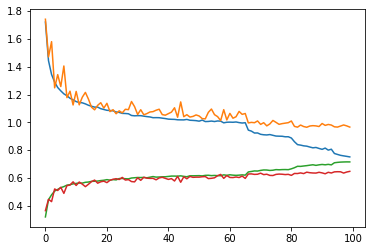

In [12]:
import pickle
pickle.dump(hist, open('featureactv342_baseline_modelv22_hist.hdf5', 'wb'))

plt.plot(hist), best_acc

In [13]:
test_model = torch.load('featureactv342_baseline_modelv22.pt')

# EVALUATE
test_model.eval()
running_valloss = 0.0
running_valacc = 0.0
for i,data in enumerate(test_loader):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = test_model(inputs)

    loss = criterion(outputs, labels)
    acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

    running_valloss += (loss.item() * inputs.size(0))
    running_valacc += acc.item()

print('- Avg. val_loss: %.3f | Avg. val_acc: %.3f' % (running_valloss / len(test_loader.dataset), running_valacc / len(test_loader.dataset)))

- Avg. val_loss: 0.945 | Avg. val_acc: 0.661


In [14]:
model_path = './featureactv343_baseline_modelv22.pt'

for epoch in range(100):  # loop over the dataset multiple times

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0
    processed = 0.0

    # TRAIN
    model.train()
    pbar = tqdm(train_loader, position=0)
    for i, data in enumerate(pbar):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()
        loss.backward()
        
        optimizer.step()

        # print statistics
        running_loss += (loss.item() * inputs.size(0))
        running_acc += acc.item()
        processed += len(inputs)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={i} Accuracy={acc.item() / inputs.size(0)}')

    print('- Avg.loss: %.3f | Avg.acc: %.3f' % (running_loss / len(train_loader.dataset), running_acc / len(train_loader.dataset)))
    avgloss = running_loss / len(train_loader.dataset)
    avgacc = running_acc / len(train_loader.dataset)

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

        running_valloss += (loss.item() * inputs.size(0))
        running_valacc += acc.item()

    print('- Avg. val_loss: %.3f | Avg. val_acc: %.3f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

    avgvalloss = running_valloss / len(val_loader.dataset)
    avgvalacc = running_valacc / len(val_loader.dataset)
    
    scheduler.step(avgvalloss)

    hist.append([avgloss, avgvalloss, avgacc, avgvalacc])
    
    if best_acc < avgvalacc:
        best_acc = avgvalacc
        torch.save(model, model_path)
        print('* Update optimal model')

print('Finished Training')

  0%|          | 0/225 [00:00<?, ?it/s]

Epoch:  1


Loss=1.4696892499923706 Batch_id=224 Accuracy=0.43243243243243246: 100%|██████████| 225/225 [01:34<00:00,  2.37it/s]

- Avg.loss: 1.681 | Avg.acc: 0.356



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.538 | Avg. val_acc: 0.424
* Update optimal model
Epoch:  2


Loss=1.1638649702072144 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [01:35<00:00,  2.36it/s]

- Avg.loss: 1.434 | Avg.acc: 0.446



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.449 | Avg. val_acc: 0.455
* Update optimal model
Epoch:  3


Loss=1.284830927848816 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [01:34<00:00,  2.37it/s]

- Avg.loss: 1.348 | Avg.acc: 0.481



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.270 | Avg. val_acc: 0.519
* Update optimal model
Epoch:  4


Loss=1.4202539920806885 Batch_id=224 Accuracy=0.43243243243243246: 100%|██████████| 225/225 [01:34<00:00,  2.37it/s]

- Avg.loss: 1.307 | Avg.acc: 0.496



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.374 | Avg. val_acc: 0.485
Epoch:  5


Loss=1.1312118768692017 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [01:35<00:00,  2.36it/s]

- Avg.loss: 1.275 | Avg.acc: 0.510



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.310 | Avg. val_acc: 0.503
Epoch:  6


Loss=1.2568457126617432 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [01:35<00:00,  2.37it/s]

- Avg.loss: 1.258 | Avg.acc: 0.518



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.375 | Avg. val_acc: 0.488
Epoch:  7


Loss=1.1602915525436401 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [01:35<00:00,  2.36it/s]

- Avg.loss: 1.242 | Avg.acc: 0.527



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.260 | Avg. val_acc: 0.522
* Update optimal model
Epoch:  8


Loss=1.1159483194351196 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [01:34<00:00,  2.37it/s]

- Avg.loss: 1.224 | Avg.acc: 0.532



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.196 | Avg. val_acc: 0.545
* Update optimal model
Epoch:  9


Loss=1.1253917217254639 Batch_id=24 Accuracy=0.6015625:  11%|█         | 24/225 [00:12<01:24,  2.39it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.126 | Avg. val_acc: 0.572
* Update optimal model
Epoch:  18


Loss=1.3319379091262817 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [01:35<00:00,  2.36it/s]

- Avg.loss: 1.146 | Avg.acc: 0.563



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.135 | Avg. val_acc: 0.575
* Update optimal model
Epoch:  19


Loss=0.9429138898849487 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [01:35<00:00,  2.36it/s]

- Avg.loss: 1.139 | Avg.acc: 0.566



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.183 | Avg. val_acc: 0.540
Epoch:  20


Loss=1.0838464498519897 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [01:34<00:00,  2.37it/s]

- Avg.loss: 1.139 | Avg.acc: 0.566



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.150 | Avg. val_acc: 0.557
Epoch:  21


Loss=1.071012020111084 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [01:35<00:00,  2.37it/s]

- Avg.loss: 1.134 | Avg.acc: 0.570



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.124 | Avg. val_acc: 0.579
* Update optimal model
Epoch:  22


Loss=1.2979172468185425 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [01:35<00:00,  2.36it/s]

- Avg.loss: 1.127 | Avg.acc: 0.574



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.163 | Avg. val_acc: 0.553
Epoch:  23


Loss=1.2824382781982422 Batch_id=224 Accuracy=0.4594594594594595: 100%|██████████| 225/225 [01:35<00:00,  2.37it/s]

- Avg.loss: 1.120 | Avg.acc: 0.572



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.123 | Avg. val_acc: 0.578
Epoch:  24


Loss=1.158880352973938 Batch_id=224 Accuracy=0.4594594594594595: 100%|██████████| 225/225 [01:35<00:00,  2.36it/s]

- Avg.loss: 1.119 | Avg.acc: 0.574



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.098 | Avg. val_acc: 0.587
* Update optimal model
Epoch:  25


Loss=1.1466152667999268 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [01:35<00:00,  2.36it/s]

- Avg.loss: 1.123 | Avg.acc: 0.575



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.149 | Avg. val_acc: 0.581
Epoch:  26


Loss=0.9809755086898804 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [01:35<00:00,  2.36it/s]

- Avg.loss: 1.108 | Avg.acc: 0.581



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.144 | Avg. val_acc: 0.570
Epoch:  27


Loss=1.0239229202270508 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [01:35<00:00,  2.37it/s]

- Avg.loss: 1.108 | Avg.acc: 0.578



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.097 | Avg. val_acc: 0.587
* Update optimal model
Epoch:  28


Loss=1.0041224956512451 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [01:35<00:00,  2.37it/s]

- Avg.loss: 1.108 | Avg.acc: 0.580



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.147 | Avg. val_acc: 0.564
Epoch:  29


Loss=1.1629393100738525 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [01:34<00:00,  2.37it/s]

- Avg.loss: 1.100 | Avg.acc: 0.584



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.159 | Avg. val_acc: 0.570
Epoch:  30


Loss=1.3307816982269287 Batch_id=224 Accuracy=0.3783783783783784: 100%|██████████| 225/225 [01:35<00:00,  2.37it/s]

- Avg.loss: 1.104 | Avg.acc: 0.580



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.127 | Avg. val_acc: 0.579
Epoch:  31


Loss=0.8985423445701599 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [01:35<00:00,  2.36it/s]

- Avg.loss: 1.097 | Avg.acc: 0.584



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.113 | Avg. val_acc: 0.578
Epoch:  32


Loss=0.8764252662658691 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [01:34<00:00,  2.37it/s]

- Avg.loss: 1.096 | Avg.acc: 0.583



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.097 | Avg. val_acc: 0.587
Epoch:  33


Loss=1.1358094215393066 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [01:35<00:00,  2.36it/s]

- Avg.loss: 1.092 | Avg.acc: 0.585



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.111 | Avg. val_acc: 0.592
* Update optimal model
Epoch:  34


Loss=1.082450032234192 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [01:34<00:00,  2.37it/s]

- Avg.loss: 1.095 | Avg.acc: 0.586



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.100 | Avg. val_acc: 0.581
Epoch:  35


Loss=1.3195165395736694 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [01:35<00:00,  2.36it/s]

- Avg.loss: 1.088 | Avg.acc: 0.588



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.093 | Avg. val_acc: 0.598
* Update optimal model
Epoch:  36


Loss=1.3087618350982666 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [01:35<00:00,  2.37it/s]

- Avg.loss: 1.081 | Avg.acc: 0.590



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.125 | Avg. val_acc: 0.577
Epoch:  37


Loss=0.9314035177230835 Batch_id=64 Accuracy=0.6640625:  28%|██▊       | 64/225 [00:29<01:06,  2.41it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Loss=1.099390983581543 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [01:34<00:00,  2.37it/s]

- Avg.loss: 1.066 | Avg.acc: 0.595



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.092 | Avg. val_acc: 0.594
Epoch:  45


Loss=1.0345264673233032 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [01:35<00:00,  2.36it/s]

- Avg.loss: 1.072 | Avg.acc: 0.592



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.087 | Avg. val_acc: 0.594
Epoch:  46


Loss=0.8764252662658691 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [01:34<00:00,  2.37it/s]

- Avg.loss: 1.071 | Avg.acc: 0.591



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.091 | Avg. val_acc: 0.593
Epoch:  47


Loss=0.9223950505256653 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [01:34<00:00,  2.38it/s]

- Avg.loss: 1.068 | Avg.acc: 0.593



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.114 | Avg. val_acc: 0.579
Epoch    47: reducing learning rate of group 0 to 2.0000e-03.
Epoch:  48


Loss=1.1796441078186035 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [01:34<00:00,  2.37it/s]

- Avg.loss: 1.018 | Avg.acc: 0.617



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.035 | Avg. val_acc: 0.617
* Update optimal model
Epoch:  49


Loss=1.0301973819732666 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [01:35<00:00,  2.36it/s]

- Avg.loss: 1.006 | Avg.acc: 0.621



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.019 | Avg. val_acc: 0.623
* Update optimal model
Epoch:  50


Loss=0.8097399473190308 Batch_id=156 Accuracy=0.71875:  69%|██████▉   | 156/225 [01:06<00:28,  2.41it/s]  IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Loss=0.9598487615585327 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [01:35<00:00,  2.37it/s]

- Avg.loss: 0.908 | Avg.acc: 0.660



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.993 | Avg. val_acc: 0.628
Epoch:  67


Loss=0.9380220174789429 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [01:35<00:00,  2.36it/s]

- Avg.loss: 0.907 | Avg.acc: 0.660



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.993 | Avg. val_acc: 0.627
Epoch:  68


Loss=0.7863633632659912 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [01:35<00:00,  2.36it/s]

- Avg.loss: 0.906 | Avg.acc: 0.658



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.012 | Avg. val_acc: 0.627
Epoch:  69


Loss=0.96295565366745 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [01:35<00:00,  2.37it/s]

- Avg.loss: 0.895 | Avg.acc: 0.663



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.994 | Avg. val_acc: 0.633
Epoch:  70


Loss=0.8141013979911804 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [01:35<00:00,  2.37it/s]

- Avg.loss: 0.897 | Avg.acc: 0.665



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.004 | Avg. val_acc: 0.626
Epoch:  71


Loss=0.8640087842941284 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [01:35<00:00,  2.36it/s]

- Avg.loss: 0.894 | Avg.acc: 0.665



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.996 | Avg. val_acc: 0.636
Epoch    71: reducing learning rate of group 0 to 5.0000e-04.
Epoch:  72


Loss=0.7794205546379089 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [01:35<00:00,  2.37it/s]

- Avg.loss: 0.868 | Avg.acc: 0.673



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.975 | Avg. val_acc: 0.639
* Update optimal model
Epoch:  73


Loss=0.9315630197525024 Batch_id=4 Accuracy=0.6640625:   2%|▏         | 4/225 [00:03<03:36,  1.02it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Loss=0.8081708550453186 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [01:35<00:00,  2.36it/s]

- Avg.loss: 0.818 | Avg.acc: 0.696



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.993 | Avg. val_acc: 0.638
Epoch:  85


Loss=1.0684887170791626 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [01:35<00:00,  2.36it/s]

- Avg.loss: 0.813 | Avg.acc: 0.697



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.996 | Avg. val_acc: 0.645
* Update optimal model
Epoch:  86


Loss=0.6990836262702942 Batch_id=224 Accuracy=0.8108108108108109: 100%|██████████| 225/225 [01:35<00:00,  2.37it/s]

- Avg.loss: 0.807 | Avg.acc: 0.699



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.003 | Avg. val_acc: 0.639
Epoch:  87


Loss=0.8947005271911621 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [01:35<00:00,  2.36it/s]

- Avg.loss: 0.809 | Avg.acc: 0.700



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.003 | Avg. val_acc: 0.643
Epoch:  88


Loss=0.8264906406402588 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [01:35<00:00,  2.37it/s]

- Avg.loss: 0.810 | Avg.acc: 0.699



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.990 | Avg. val_acc: 0.639
Epoch    88: reducing learning rate of group 0 to 1.2500e-04.
Epoch:  89


Loss=0.890498697757721 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [01:34<00:00,  2.37it/s]

- Avg.loss: 0.804 | Avg.acc: 0.700



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.993 | Avg. val_acc: 0.641
Epoch:  90


Loss=0.8399107456207275 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [01:35<00:00,  2.36it/s]

- Avg.loss: 0.796 | Avg.acc: 0.706



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.994 | Avg. val_acc: 0.644
Epoch:  91


Loss=0.879054844379425 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [01:34<00:00,  2.37it/s]

- Avg.loss: 0.801 | Avg.acc: 0.702



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.995 | Avg. val_acc: 0.643
Epoch:  92


Loss=0.751371443271637 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [01:35<00:00,  2.36it/s]

- Avg.loss: 0.793 | Avg.acc: 0.709



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.993 | Avg. val_acc: 0.644
Epoch:  93


Loss=0.8454667925834656 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [01:35<00:00,  2.37it/s]

- Avg.loss: 0.791 | Avg.acc: 0.707



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.995 | Avg. val_acc: 0.641
Epoch:  94


Loss=0.6912004947662354 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [01:35<00:00,  2.36it/s]

- Avg.loss: 0.788 | Avg.acc: 0.708



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.996 | Avg. val_acc: 0.642
Epoch:  95


Loss=0.8889042735099792 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [01:35<00:00,  2.37it/s]

- Avg.loss: 0.788 | Avg.acc: 0.710



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.996 | Avg. val_acc: 0.642
Epoch:  96


Loss=0.8652989268302917 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [01:34<00:00,  2.37it/s]

- Avg.loss: 0.790 | Avg.acc: 0.707



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.994 | Avg. val_acc: 0.645
Epoch    96: reducing learning rate of group 0 to 6.2500e-05.
Epoch:  97


Loss=1.1353909969329834 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [01:35<00:00,  2.37it/s]

- Avg.loss: 0.785 | Avg.acc: 0.709



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.996 | Avg. val_acc: 0.643
Epoch:  98


Loss=0.6783296465873718 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [01:35<00:00,  2.36it/s]

- Avg.loss: 0.785 | Avg.acc: 0.708



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.997 | Avg. val_acc: 0.641
Epoch:  99


Loss=0.6450946927070618 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [01:35<00:00,  2.37it/s]

- Avg.loss: 0.788 | Avg.acc: 0.708



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.997 | Avg. val_acc: 0.645
Epoch:  100


Loss=1.0355311632156372 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [01:35<00:00,  2.36it/s]

- Avg.loss: 0.784 | Avg.acc: 0.706


- Avg. val_loss: 1.004 | Avg. val_acc: 0.640
Finished Training


([<matplotlib.lines.Line2D at 0x7fc8669e4e80>,
 0.6450264697687378)

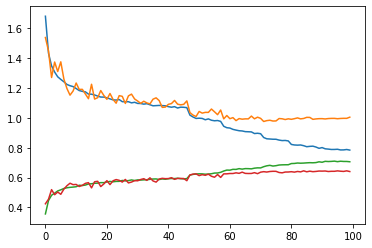

In [15]:
import pickle
pickle.dump(hist, open('featureactv343_baseline_modelv22_hist.hdf5', 'wb'))

plt.plot(hist), best_acc

In [16]:
test_model = torch.load('featureactv343_baseline_modelv22.pt')

# EVALUATE
test_model.eval()
running_valloss = 0.0
running_valacc = 0.0
for i,data in enumerate(test_loader):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = test_model(inputs)

    loss = criterion(outputs, labels)
    acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

    running_valloss += (loss.item() * inputs.size(0))
    running_valacc += acc.item()

print('- Avg. val_loss: %.3f | Avg. val_acc: %.3f' % (running_valloss / len(test_loader.dataset), running_valacc / len(test_loader.dataset)))

- Avg. val_loss: 0.955 | Avg. val_acc: 0.653


## Feature Act v3.5 | multi-head + layernorm


In [9]:
class FeatureAct(nn.Module):
    def __init__(self, src_depth, img_size, reduce_factor=1):
        super(FeatureAct, self).__init__()
        
        self.softmax = nn.Softmax(dim=2)
        self.norm = nn.LayerNorm(img_size)
        self.n_heads = reduce_factor
        
        
        self.src_convs = nn.ModuleList()
        self.target_convs = nn.ModuleList()
        self.down_depths = nn.ModuleList()
        
        self.proj_conv = nn.Conv2d(src_depth, src_depth, kernel_size=1, padding=False)
        
        
        for i in range(self.n_heads):
            src_conv = nn.Conv2d(src_depth, src_depth // reduce_factor, kernel_size=1, padding=False)
            target_conv = nn.Conv2d(src_depth, src_depth // reduce_factor, kernel_size=1, padding=False)
        
            down_depth = nn.Sequential(nn.Conv2d(src_depth, src_depth // reduce_factor, kernel_size=1, padding=False),
                                        nn.ReLU(inplace=True))
            
            self.src_convs.append(src_conv)
            self.target_convs.append(target_conv)
            self.down_depths.append(down_depth)
        
        
    def forward(self, x):
        
        x_norm = self.norm(x)
        
        cor_features = []
        
        for i in range(self.n_heads):
            src_features = self.src_convs[i](x_norm)
            target_features = self.target_convs[i](x_norm)
            cor = nn.Flatten(-2)(src_features[:, None, :, :]).permute(0,2,1,3) * nn.Flatten(-2)(target_features[:, None, :, :])
            cor = self.softmax(cor)
            
            main_features = self.down_depths[i](x_norm)
            cor_feature = torch.cat([(main_features * cor[:, :, k].view(-1, src_features.size(-3), src_features.size(-2), src_features.size(-1))).sum(1, keepdim=True) for k in range(cor.size(2))], dim=1)
            cor_features.append(cor_feature)
        
        cor_features = torch.cat(cor_features, dim=1)
        cor_features = self.proj_conv(cor_features)
        
        x = x + cor_features
        
        return x

In [10]:
class BaselineFeatureAct(nn.Module):
    def __init__(self, embeddings=False):
        
        super(BaselineFeatureAct, self).__init__()
        
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=(2,2), stride=2)
        
        self.conv0 = nn.Conv2d(1, 32, kernel_size=(3,3), padding=1, stride=1)
        self.conv0b = nn.Conv2d(32, 32, kernel_size=(3,3), padding=1, stride=1)
        self.bn0 = nn.BatchNorm2d(32)
        self.bn0b = nn.BatchNorm2d(32)
        
        self.conv1 = nn.Conv2d(32, 64, kernel_size=(3,3), padding=1, stride=1)
        self.conv1b = nn.Conv2d(64, 64, kernel_size=(3,3), padding=1, stride=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.bn1b = nn.BatchNorm2d(64)
        
        self.conv2 = nn.Conv2d(64, 128, kernel_size=(3,3), padding=1, stride=1)
        self.conv2b = nn.Conv2d(128, 128, kernel_size=(3,3), padding=1, stride=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn2b = nn.BatchNorm2d(128)
        
        self.conv3 = nn.Conv2d(128, 256, kernel_size=(3,3), padding=1, stride=1)
        self.conv3b = nn.Conv2d(256, 256, kernel_size=(3,3), padding=1, stride=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.bn3b = nn.BatchNorm2d(256)
  
        self.fact0 = FeatureAct(32, img_size=(32, 24, 24), reduce_factor=4)
        self.fact1 = FeatureAct(64, img_size=(64, 12, 12), reduce_factor=4)
        self.fact2 = FeatureAct(128, img_size=(128, 6, 6), reduce_factor=4)
        self.fact3 = FeatureAct(256, img_size=(256, 3, 3), reduce_factor=4)
        
        if not embeddings:
            self.classifier = nn.Sequential(nn.Flatten(),
                                            nn.Linear(2304, 256), nn.BatchNorm1d(256), nn.ReLU(inplace=True),
                                            nn.Linear(256, 128), nn.BatchNorm1d(128), nn.ReLU(inplace=True),
                                            nn.Linear(128, 7), nn.BatchNorm1d(7))
        else:
            self.classifier = nn.Sequential(nn.Flatten(),
                                            nn.Linear(2304, 256), nn.BatchNorm1d(256), nn.ReLU(inplace=True),
                                            nn.Linear(256, 128), nn.BatchNorm1d(128))
        
    def forward(self, x):
        
        x = self.conv0(x)
        x = self.bn0(x)
        x = self.relu(x)
        x = self.conv0b(x)
        x = self.bn0b(x)
        x = self.relu(x)
        
        x0 = self.maxpool(x)
        x0 = self.fact0(x0)
        
        x = self.conv1(x0)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv1b(x)
        x = self.bn1b(x)
        x = self.relu(x)
        
        x1 = self.maxpool(x)
        x1 = self.fact1(x1)
        
        x = self.conv2(x1)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv2b(x)
        x = self.bn2b(x)
        x = self.relu(x)
        
        x2 = self.maxpool(x)
        x2 = self.fact2(x2)
        
        x = self.conv3(x2)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.conv3b(x)
        x = self.bn3b(x)
        x = self.relu(x)
        
        x3 = self.maxpool(x)
        x3 = self.fact3(x3)
        
        x = nn.Flatten()(x3)
        x = self.classifier(x)
        
        return x

In [11]:
device = torch.device('cuda')
model = BaselineFeatureAct().to(device)

best_acc = 0.0
hist = []

epochs=100

criterion = nn.CrossEntropyLoss()

learning_rate = 0.004
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=7, verbose=True)


In [12]:
model_path = './featureactv35_baseline_modelv22.pt'

for epoch in range(100):  # loop over the dataset multiple times

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0
    processed = 0.0

    # TRAIN
    model.train()
    pbar = tqdm(train_loader, position=0)
    for i, data in enumerate(pbar):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()
        loss.backward()
        
        optimizer.step()

        # print statistics
        running_loss += (loss.item() * inputs.size(0))
        running_acc += acc.item()
        processed += len(inputs)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={i} Accuracy={acc.item() / inputs.size(0)}')

    print('- Avg.loss: %.3f | Avg.acc: %.3f' % (running_loss / len(train_loader.dataset), running_acc / len(train_loader.dataset)))
    avgloss = running_loss / len(train_loader.dataset)
    avgacc = running_acc / len(train_loader.dataset)

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

        running_valloss += (loss.item() * inputs.size(0))
        running_valacc += acc.item()

    print('- Avg. val_loss: %.3f | Avg. val_acc: %.3f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

    avgvalloss = running_valloss / len(val_loader.dataset)
    avgvalacc = running_valacc / len(val_loader.dataset)
    
    scheduler.step(avgvalloss)

    hist.append([avgloss, avgvalloss, avgacc, avgvalacc])
    
    if best_acc < avgvalacc:
        best_acc = avgvalacc
        torch.save(model, model_path)
        print('* Update optimal model')

print('Finished Training')

  0%|          | 0/225 [00:00<?, ?it/s]

Epoch:  1


Loss=1.5384591817855835 Batch_id=224 Accuracy=0.35135135135135137: 100%|██████████| 225/225 [01:42<00:00,  2.19it/s]

- Avg.loss: 1.720 | Avg.acc: 0.327



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.695 | Avg. val_acc: 0.353
* Update optimal model
Epoch:  2


Loss=1.0966962575912476 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [01:43<00:00,  2.18it/s]

- Avg.loss: 1.455 | Avg.acc: 0.436



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.377 | Avg. val_acc: 0.471
* Update optimal model
Epoch:  3


Loss=1.5249303579330444 Batch_id=224 Accuracy=0.3783783783783784: 100%|██████████| 225/225 [01:43<00:00,  2.18it/s]

- Avg.loss: 1.341 | Avg.acc: 0.486



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.287 | Avg. val_acc: 0.503
* Update optimal model
Epoch:  4


Loss=1.247693657875061 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [01:43<00:00,  2.18it/s]

- Avg.loss: 1.285 | Avg.acc: 0.509



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.294 | Avg. val_acc: 0.506
* Update optimal model
Epoch:  5


Loss=1.3521264791488647 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [01:43<00:00,  2.18it/s]

- Avg.loss: 1.257 | Avg.acc: 0.522



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.227 | Avg. val_acc: 0.534
* Update optimal model
Epoch:  6


Loss=1.0372132062911987 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [01:42<00:00,  2.19it/s]

- Avg.loss: 1.226 | Avg.acc: 0.533



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.239 | Avg. val_acc: 0.522
Epoch:  7


Loss=1.1398265361785889 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [01:43<00:00,  2.18it/s]

- Avg.loss: 1.198 | Avg.acc: 0.544



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.201 | Avg. val_acc: 0.552
* Update optimal model
Epoch:  8


Loss=1.169992446899414 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [01:42<00:00,  2.19it/s]

- Avg.loss: 1.181 | Avg.acc: 0.551



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.196 | Avg. val_acc: 0.551
Epoch:  9


Loss=1.2170617580413818 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [01:43<00:00,  2.18it/s]

- Avg.loss: 1.168 | Avg.acc: 0.562



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.203 | Avg. val_acc: 0.548
Epoch:  10


Loss=1.3227788209915161 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [01:43<00:00,  2.18it/s]

- Avg.loss: 1.151 | Avg.acc: 0.567



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.150 | Avg. val_acc: 0.567
* Update optimal model
Epoch:  11


Loss=1.1250100135803223 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [01:43<00:00,  2.18it/s]

- Avg.loss: 1.148 | Avg.acc: 0.563



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.154 | Avg. val_acc: 0.556
Epoch:  12


Loss=0.941994309425354 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [01:42<00:00,  2.19it/s]

- Avg.loss: 1.132 | Avg.acc: 0.570



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.249 | Avg. val_acc: 0.533
Epoch:  13


Loss=1.3316506147384644 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [01:42<00:00,  2.19it/s]

- Avg.loss: 1.124 | Avg.acc: 0.573



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.233 | Avg. val_acc: 0.530
Epoch:  14


Loss=0.9289915561676025 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [01:42<00:00,  2.19it/s]

- Avg.loss: 1.116 | Avg.acc: 0.578



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.130 | Avg. val_acc: 0.579
* Update optimal model
Epoch:  15


Loss=1.2548861503601074 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [01:43<00:00,  2.18it/s]

- Avg.loss: 1.113 | Avg.acc: 0.580



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.149 | Avg. val_acc: 0.568
Epoch:  16


Loss=1.009826898574829 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [01:43<00:00,  2.18it/s]

- Avg.loss: 1.103 | Avg.acc: 0.580



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.112 | Avg. val_acc: 0.584
* Update optimal model
Epoch:  17


Loss=1.2126888036727905 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [01:42<00:00,  2.19it/s]

- Avg.loss: 1.098 | Avg.acc: 0.583


- Avg. val_loss: 1.101 | Avg. val_acc: 0.587


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  18


Loss=1.2305166721343994 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [01:42<00:00,  2.19it/s]

- Avg.loss: 1.093 | Avg.acc: 0.586



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.083 | Avg. val_acc: 0.591
* Update optimal model
Epoch:  19


Loss=1.2450793981552124 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [01:43<00:00,  2.18it/s]

- Avg.loss: 1.086 | Avg.acc: 0.589



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.076 | Avg. val_acc: 0.591
Epoch:  20


Loss=1.5232332944869995 Batch_id=224 Accuracy=0.4594594594594595: 100%|██████████| 225/225 [01:43<00:00,  2.18it/s]

- Avg.loss: 1.078 | Avg.acc: 0.590



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.112 | Avg. val_acc: 0.586
Epoch:  21


Loss=1.0135544538497925 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [01:42<00:00,  2.19it/s]

- Avg.loss: 1.074 | Avg.acc: 0.594



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.092 | Avg. val_acc: 0.590
Epoch:  22


Loss=1.2771085500717163 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [01:43<00:00,  2.18it/s]

- Avg.loss: 1.069 | Avg.acc: 0.592



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.136 | Avg. val_acc: 0.586
Epoch:  23


Loss=0.7896119356155396 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [01:43<00:00,  2.18it/s]

- Avg.loss: 1.062 | Avg.acc: 0.597



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.096 | Avg. val_acc: 0.591
Epoch:  24


Loss=1.2272850275039673 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [01:42<00:00,  2.19it/s]

- Avg.loss: 1.066 | Avg.acc: 0.595



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.109 | Avg. val_acc: 0.585
Epoch:  25


Loss=1.1076167821884155 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [01:43<00:00,  2.18it/s]

- Avg.loss: 1.054 | Avg.acc: 0.601



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.139 | Avg. val_acc: 0.576
Epoch:  26


Loss=1.0083197355270386 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [01:42<00:00,  2.19it/s]

- Avg.loss: 1.055 | Avg.acc: 0.599



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.065 | Avg. val_acc: 0.600
* Update optimal model
Epoch:  27


Loss=1.2060489654541016 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [01:43<00:00,  2.18it/s]

- Avg.loss: 1.046 | Avg.acc: 0.604



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.134 | Avg. val_acc: 0.577
Epoch:  28


Loss=1.173149824142456 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [01:42<00:00,  2.19it/s]

- Avg.loss: 1.050 | Avg.acc: 0.600



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.071 | Avg. val_acc: 0.596
Epoch:  29


Loss=1.4240448474884033 Batch_id=224 Accuracy=0.3783783783783784: 100%|██████████| 225/225 [01:42<00:00,  2.19it/s]

- Avg.loss: 1.042 | Avg.acc: 0.608



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.131 | Avg. val_acc: 0.581
Epoch:  30


Loss=0.9771184325218201 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [01:43<00:00,  2.18it/s]

- Avg.loss: 1.043 | Avg.acc: 0.606



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.101 | Avg. val_acc: 0.581
Epoch:  31


Loss=1.0567785501480103 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [01:43<00:00,  2.18it/s]

- Avg.loss: 1.049 | Avg.acc: 0.600



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.066 | Avg. val_acc: 0.590
Epoch:  32


Loss=1.3555833101272583 Batch_id=224 Accuracy=0.43243243243243246: 100%|██████████| 225/225 [01:43<00:00,  2.18it/s]

- Avg.loss: 1.035 | Avg.acc: 0.609



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.084 | Avg. val_acc: 0.585
Epoch:  33


Loss=1.0941944122314453 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [01:42<00:00,  2.19it/s]

- Avg.loss: 1.041 | Avg.acc: 0.607



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.077 | Avg. val_acc: 0.591
Epoch:  34


Loss=1.030545949935913 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [01:43<00:00,  2.18it/s]

- Avg.loss: 1.032 | Avg.acc: 0.607



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.081 | Avg. val_acc: 0.597
Epoch    34: reducing learning rate of group 0 to 2.0000e-03.
Epoch:  35


Loss=1.1547104120254517 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [01:42<00:00,  2.19it/s]

- Avg.loss: 0.979 | Avg.acc: 0.631



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.016 | Avg. val_acc: 0.614
* Update optimal model
Epoch:  36


Loss=0.8445709943771362 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [01:43<00:00,  2.17it/s]

- Avg.loss: 0.962 | Avg.acc: 0.637



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.021 | Avg. val_acc: 0.612
Epoch:  37


Loss=0.8522040247917175 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [01:42<00:00,  2.18it/s]

- Avg.loss: 0.957 | Avg.acc: 0.639



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.003 | Avg. val_acc: 0.623
* Update optimal model
Epoch:  38


Loss=0.8416195511817932 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [01:43<00:00,  2.18it/s]

- Avg.loss: 0.955 | Avg.acc: 0.641



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.027 | Avg. val_acc: 0.614
Epoch:  39


Loss=1.0774385929107666 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [01:43<00:00,  2.18it/s]

- Avg.loss: 0.951 | Avg.acc: 0.642



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.007 | Avg. val_acc: 0.625
* Update optimal model
Epoch:  40


Loss=0.83156418800354 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [01:43<00:00,  2.18it/s]

- Avg.loss: 0.946 | Avg.acc: 0.643



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.001 | Avg. val_acc: 0.628
* Update optimal model
Epoch:  41


Loss=1.0743050575256348 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [01:42<00:00,  2.19it/s]

- Avg.loss: 0.942 | Avg.acc: 0.649



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.001 | Avg. val_acc: 0.632
* Update optimal model
Epoch:  42


Loss=0.9424700140953064 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [01:42<00:00,  2.19it/s]

- Avg.loss: 0.935 | Avg.acc: 0.649



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.025 | Avg. val_acc: 0.609
Epoch:  43


Loss=1.0313560962677002 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [01:43<00:00,  2.17it/s]

- Avg.loss: 0.933 | Avg.acc: 0.648



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.010 | Avg. val_acc: 0.625
Epoch:  44


Loss=0.8430312275886536 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [01:43<00:00,  2.18it/s]

- Avg.loss: 0.935 | Avg.acc: 0.650



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.008 | Avg. val_acc: 0.624
Epoch:  45


Loss=0.8542055487632751 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [01:43<00:00,  2.18it/s]

- Avg.loss: 0.925 | Avg.acc: 0.654



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.998 | Avg. val_acc: 0.635
* Update optimal model
Epoch:  46


Loss=1.023340106010437 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [01:42<00:00,  2.20it/s]

- Avg.loss: 0.922 | Avg.acc: 0.652



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.009 | Avg. val_acc: 0.634
Epoch:  47


Loss=1.140290379524231 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [01:42<00:00,  2.19it/s]

- Avg.loss: 0.918 | Avg.acc: 0.655



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.998 | Avg. val_acc: 0.618
Epoch:  48


Loss=1.1649651527404785 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [01:42<00:00,  2.19it/s]

- Avg.loss: 0.918 | Avg.acc: 0.656



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.998 | Avg. val_acc: 0.625
Epoch:  49


Loss=0.9745973348617554 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [01:43<00:00,  2.18it/s]

- Avg.loss: 0.920 | Avg.acc: 0.655



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.015 | Avg. val_acc: 0.615
Epoch:  50


Loss=0.9213008284568787 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [01:43<00:00,  2.18it/s]

- Avg.loss: 0.914 | Avg.acc: 0.655



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.006 | Avg. val_acc: 0.634
Epoch:  51


Loss=0.9176126718521118 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [01:43<00:00,  2.18it/s]

- Avg.loss: 0.906 | Avg.acc: 0.659



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.003 | Avg. val_acc: 0.633
Epoch:  52


Loss=1.402242660522461 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [01:42<00:00,  2.19it/s]

- Avg.loss: 0.905 | Avg.acc: 0.657



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.004 | Avg. val_acc: 0.621
Epoch:  53


Loss=0.8556146025657654 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [01:43<00:00,  2.18it/s]

- Avg.loss: 0.906 | Avg.acc: 0.658



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.002 | Avg. val_acc: 0.634
Epoch:  54


Loss=1.1894904375076294 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [01:43<00:00,  2.18it/s]

- Avg.loss: 0.901 | Avg.acc: 0.660



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.007 | Avg. val_acc: 0.625
Epoch:  55


Loss=0.8899147510528564 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [01:42<00:00,  2.18it/s]

- Avg.loss: 0.901 | Avg.acc: 0.661



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.000 | Avg. val_acc: 0.634
Epoch    55: reducing learning rate of group 0 to 1.0000e-03.
Epoch:  56


Loss=1.0313434600830078 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [01:43<00:00,  2.18it/s]

- Avg.loss: 0.860 | Avg.acc: 0.678



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.977 | Avg. val_acc: 0.643
* Update optimal model
Epoch:  57


Loss=0.8719860911369324 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [01:43<00:00,  2.18it/s]

- Avg.loss: 0.846 | Avg.acc: 0.680



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.958 | Avg. val_acc: 0.643
Epoch:  58


Loss=0.9565685391426086 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [01:42<00:00,  2.18it/s]

- Avg.loss: 0.836 | Avg.acc: 0.685



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.959 | Avg. val_acc: 0.652
* Update optimal model
Epoch:  59


Loss=0.7871848344802856 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [01:43<00:00,  2.18it/s]

- Avg.loss: 0.833 | Avg.acc: 0.687



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.974 | Avg. val_acc: 0.649
Epoch:  60


Loss=0.9898282885551453 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [01:43<00:00,  2.18it/s]

- Avg.loss: 0.832 | Avg.acc: 0.686



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.975 | Avg. val_acc: 0.642
Epoch:  61


Loss=1.2059794664382935 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [01:43<00:00,  2.18it/s]

- Avg.loss: 0.822 | Avg.acc: 0.694



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.971 | Avg. val_acc: 0.653
* Update optimal model
Epoch:  62


Loss=0.7072952389717102 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [01:42<00:00,  2.19it/s]

- Avg.loss: 0.818 | Avg.acc: 0.693



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.992 | Avg. val_acc: 0.631
Epoch:  63


Loss=0.8160696029663086 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [01:42<00:00,  2.19it/s]

- Avg.loss: 0.812 | Avg.acc: 0.696



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.969 | Avg. val_acc: 0.648
Epoch:  64


Loss=0.8568653464317322 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [01:43<00:00,  2.18it/s]

- Avg.loss: 0.813 | Avg.acc: 0.698



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.974 | Avg. val_acc: 0.646
Epoch:  65


Loss=0.6420554518699646 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [01:43<00:00,  2.18it/s]

- Avg.loss: 0.806 | Avg.acc: 0.697



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.984 | Avg. val_acc: 0.643
Epoch    65: reducing learning rate of group 0 to 5.0000e-04.
Epoch:  66


Loss=0.5499079823493958 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [01:43<00:00,  2.18it/s]

- Avg.loss: 0.783 | Avg.acc: 0.709



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.971 | Avg. val_acc: 0.651
Epoch:  67


Loss=0.7204084396362305 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [01:43<00:00,  2.18it/s]

- Avg.loss: 0.764 | Avg.acc: 0.716



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.985 | Avg. val_acc: 0.648
Epoch:  68


Loss=0.7606757879257202 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [01:43<00:00,  2.18it/s]

- Avg.loss: 0.765 | Avg.acc: 0.717



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.968 | Avg. val_acc: 0.643
Epoch:  69


Loss=0.5543987154960632 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [01:42<00:00,  2.18it/s]

- Avg.loss: 0.752 | Avg.acc: 0.720



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.977 | Avg. val_acc: 0.647
Epoch:  70


Loss=0.7302506566047668 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [01:42<00:00,  2.19it/s]

- Avg.loss: 0.754 | Avg.acc: 0.720



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.972 | Avg. val_acc: 0.648
Epoch:  71


Loss=0.6492795944213867 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [01:42<00:00,  2.18it/s]

- Avg.loss: 0.750 | Avg.acc: 0.721



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.971 | Avg. val_acc: 0.650
Epoch:  72


Loss=0.805241584777832 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [01:42<00:00,  2.19it/s]

- Avg.loss: 0.746 | Avg.acc: 0.725



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.975 | Avg. val_acc: 0.655
* Update optimal model
Epoch:  73


Loss=0.6261909008026123 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [01:43<00:00,  2.18it/s]

- Avg.loss: 0.741 | Avg.acc: 0.726



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.988 | Avg. val_acc: 0.644
Epoch    73: reducing learning rate of group 0 to 2.5000e-04.
Epoch:  74


Loss=0.8566865921020508 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [01:42<00:00,  2.18it/s]

- Avg.loss: 0.719 | Avg.acc: 0.733



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.981 | Avg. val_acc: 0.652
Epoch:  75


Loss=0.6224143505096436 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [01:43<00:00,  2.18it/s]

- Avg.loss: 0.713 | Avg.acc: 0.737



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.982 | Avg. val_acc: 0.652
Epoch:  76


Loss=1.0060406923294067 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [01:42<00:00,  2.19it/s]

- Avg.loss: 0.708 | Avg.acc: 0.737



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.983 | Avg. val_acc: 0.653
Epoch:  77


Loss=0.7933096885681152 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [01:43<00:00,  2.18it/s]

- Avg.loss: 0.704 | Avg.acc: 0.741



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.990 | Avg. val_acc: 0.649
Epoch:  78


Loss=0.8630658388137817 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [01:43<00:00,  2.18it/s]

- Avg.loss: 0.705 | Avg.acc: 0.740



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.989 | Avg. val_acc: 0.648
Epoch:  79


Loss=0.6177018284797668 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [01:43<00:00,  2.18it/s]

- Avg.loss: 0.701 | Avg.acc: 0.742



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.990 | Avg. val_acc: 0.653
Epoch:  80


Loss=0.7106243371963501 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [01:43<00:00,  2.18it/s]

- Avg.loss: 0.690 | Avg.acc: 0.743



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.995 | Avg. val_acc: 0.649
Epoch:  81


Loss=1.0134119987487793 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [01:42<00:00,  2.19it/s]

- Avg.loss: 0.694 | Avg.acc: 0.745



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.999 | Avg. val_acc: 0.651
Epoch    81: reducing learning rate of group 0 to 1.2500e-04.
Epoch:  82


Loss=0.6954526901245117 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [01:42<00:00,  2.19it/s]

- Avg.loss: 0.680 | Avg.acc: 0.750



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.985 | Avg. val_acc: 0.653
Epoch:  83


Loss=0.9047181606292725 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [01:43<00:00,  2.18it/s]

- Avg.loss: 0.685 | Avg.acc: 0.747



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.001 | Avg. val_acc: 0.649
Epoch:  84


Loss=0.6204661726951599 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [01:42<00:00,  2.18it/s]

- Avg.loss: 0.684 | Avg.acc: 0.748



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.988 | Avg. val_acc: 0.654
Epoch:  85


Loss=0.7071687579154968 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [01:42<00:00,  2.19it/s]

- Avg.loss: 0.675 | Avg.acc: 0.753



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.996 | Avg. val_acc: 0.649
Epoch:  86


Loss=0.44627663493156433 Batch_id=224 Accuracy=0.8378378378378378: 100%|██████████| 225/225 [01:43<00:00,  2.18it/s]

- Avg.loss: 0.678 | Avg.acc: 0.750



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.993 | Avg. val_acc: 0.654
Epoch:  87


Loss=0.7229214906692505 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [01:43<00:00,  2.17it/s]

- Avg.loss: 0.673 | Avg.acc: 0.751



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.989 | Avg. val_acc: 0.652
Epoch:  88


Loss=0.5804206132888794 Batch_id=224 Accuracy=0.8108108108108109: 100%|██████████| 225/225 [01:43<00:00,  2.17it/s]

- Avg.loss: 0.672 | Avg.acc: 0.753



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.994 | Avg. val_acc: 0.657
* Update optimal model
Epoch:  89


Loss=0.8689760565757751 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [01:42<00:00,  2.19it/s]

- Avg.loss: 0.667 | Avg.acc: 0.756



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.001 | Avg. val_acc: 0.646
Epoch    89: reducing learning rate of group 0 to 6.2500e-05.
Epoch:  90


Loss=0.6464666128158569 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [01:43<00:00,  2.18it/s]

- Avg.loss: 0.662 | Avg.acc: 0.755



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.999 | Avg. val_acc: 0.648
Epoch:  91


Loss=0.6912237405776978 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [01:43<00:00,  2.18it/s]

- Avg.loss: 0.666 | Avg.acc: 0.756



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.999 | Avg. val_acc: 0.653
Epoch:  92


Loss=0.8498030304908752 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [01:42<00:00,  2.19it/s]

- Avg.loss: 0.666 | Avg.acc: 0.755



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.999 | Avg. val_acc: 0.649
Epoch:  93


Loss=0.7374622821807861 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [01:43<00:00,  2.18it/s]

- Avg.loss: 0.655 | Avg.acc: 0.760



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.998 | Avg. val_acc: 0.652
Epoch:  94


Loss=0.5971784591674805 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [01:42<00:00,  2.19it/s]

- Avg.loss: 0.658 | Avg.acc: 0.758



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.999 | Avg. val_acc: 0.652
Epoch:  95


Loss=0.89029860496521 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [01:42<00:00,  2.19it/s]

- Avg.loss: 0.663 | Avg.acc: 0.754



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.001 | Avg. val_acc: 0.652
Epoch:  96


Loss=0.5814905762672424 Batch_id=224 Accuracy=0.8108108108108109: 100%|██████████| 225/225 [01:43<00:00,  2.17it/s]

- Avg.loss: 0.662 | Avg.acc: 0.755



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.000 | Avg. val_acc: 0.650
Epoch:  97


Loss=0.6850505471229553 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [01:43<00:00,  2.18it/s]

- Avg.loss: 0.654 | Avg.acc: 0.759



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.004 | Avg. val_acc: 0.653
Epoch    97: reducing learning rate of group 0 to 3.1250e-05.
Epoch:  98


Loss=0.626322329044342 Batch_id=224 Accuracy=0.8108108108108109: 100%|██████████| 225/225 [01:42<00:00,  2.19it/s]

- Avg.loss: 0.654 | Avg.acc: 0.761



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.999 | Avg. val_acc: 0.651
Epoch:  99


Loss=0.571311354637146 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [01:42<00:00,  2.18it/s]

- Avg.loss: 0.656 | Avg.acc: 0.758



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.005 | Avg. val_acc: 0.651
Epoch:  100


Loss=0.6835516095161438 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [01:42<00:00,  2.18it/s]

- Avg.loss: 0.653 | Avg.acc: 0.759


- Avg. val_loss: 1.011 | Avg. val_acc: 0.654
Finished Training


([<matplotlib.lines.Line2D at 0x7ff5c40a8198>,
 0.6567288938422959)

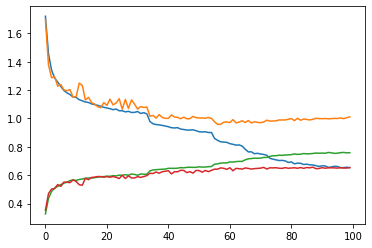

In [13]:
import pickle
pickle.dump(hist, open('featureactv35_baseline_modelv22_hist.hdf5', 'wb'))

plt.plot(hist), best_acc

In [15]:
test_model = torch.load('featureactv35_baseline_modelv22.pt')

# EVALUATE
test_model.eval()
running_valloss = 0.0
running_valacc = 0.0
for i,data in enumerate(test_loader):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = test_model(inputs)

    loss = criterion(outputs, labels)
    acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

    running_valloss += (loss.item() * inputs.size(0))
    running_valacc += acc.item()

print('- Avg. val_loss: %.3f | Avg. val_acc: %.3f' % (running_valloss / len(test_loader.dataset), running_valacc / len(test_loader.dataset)))

- Avg. val_loss: 0.952 | Avg. val_acc: 0.657


## Feature Act v4

In [5]:
class FeatureAct(nn.Module):
    def __init__(self, src_depth, reduce_factor=1):
        super(FeatureAct, self).__init__()
        
#         self.softmax = nn.Softmax(dim=2)
        self.sigmoid = nn.Sigmoid()
        
        self.src_conv = nn.Conv2d(src_depth, src_depth // reduce_factor, kernel_size=1, padding=False)
        self.target_conv = nn.Conv2d(src_depth, src_depth // reduce_factor, kernel_size=1, padding=False)
        
        self.down_depth = nn.Sequential(nn.Conv2d(src_depth, src_depth // reduce_factor, kernel_size=1, padding=False),
                                        nn.ReLU(inplace=True))
        self.up_depth = nn.Sequential(nn.Conv2d(src_depth // reduce_factor, src_depth, kernel_size=1, padding=False),
                                      nn.ReLU(inplace=True))
        
    def forward(self, x):
        
        src_features = self.src_conv(x)
        target_features = self.target_conv(x)
        
        cor = nn.Flatten(-2)(src_features[:, None, :, :]).permute(0,2,1,3) * nn.Flatten(-2)(target_features[:, None, :, :])
#         cor = cor / (torch.norm(cor) + 1e-7)
#         cor = self.softmax(cor)
        
        main_features = self.down_depth(x)
    
        cor_feature = torch.cat([(main_features * cor[:, :, k].view(-1, src_features.size(-3), src_features.size(-2), src_features.size(-1))).sum(1, keepdim=True) for k in range(cor.size(2))], dim=1)
        cor_feature = self.up_depth(cor_feature)
        cor_feature = self.sigmoid(cor_feature)
        
        x = x * (1 + cor_feature)
        
        return x

In [6]:
class BaselineFeatureAct(nn.Module):
    def __init__(self, embeddings=False):
        
        super(BaselineFeatureAct, self).__init__()
        
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=(2,2), stride=2)
        
        self.conv0 = nn.Conv2d(1, 32, kernel_size=(3,3), padding=1, stride=1)
        self.conv0b = nn.Conv2d(32, 32, kernel_size=(3,3), padding=1, stride=1)
        self.bn0 = nn.BatchNorm2d(32)
        self.bn0b = nn.BatchNorm2d(32)
        
        self.conv1 = nn.Conv2d(32, 64, kernel_size=(3,3), padding=1, stride=1)
        self.conv1b = nn.Conv2d(64, 64, kernel_size=(3,3), padding=1, stride=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.bn1b = nn.BatchNorm2d(64)
        
        self.conv2 = nn.Conv2d(64, 128, kernel_size=(3,3), padding=1, stride=1)
        self.conv2b = nn.Conv2d(128, 128, kernel_size=(3,3), padding=1, stride=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn2b = nn.BatchNorm2d(128)
        
        self.conv3 = nn.Conv2d(128, 256, kernel_size=(3,3), padding=1, stride=1)
        self.conv3b = nn.Conv2d(256, 256, kernel_size=(3,3), padding=1, stride=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.bn3b = nn.BatchNorm2d(256)
  
        self.fact0 = FeatureAct(32, 4)
        self.fact1 = FeatureAct(64, 4)
        self.fact2 = FeatureAct(128, 4)
        self.fact3 = FeatureAct(256, 4)
        
        if not embeddings:
            self.classifier = nn.Sequential(nn.Flatten(),
                                            nn.Linear(2304, 256), nn.BatchNorm1d(256), nn.ReLU(inplace=True),
                                            nn.Linear(256, 128), nn.BatchNorm1d(128), nn.ReLU(inplace=True),
                                            nn.Linear(128, 7), nn.BatchNorm1d(7))
        else:
            self.classifier = nn.Sequential(nn.Flatten(),
                                            nn.Linear(2304, 256), nn.BatchNorm1d(256), nn.ReLU(inplace=True),
                                            nn.Linear(256, 128), nn.BatchNorm1d(128))
        
    def forward(self, x):
        
        x = self.conv0(x)
        x = self.bn0(x)
        x = self.relu(x)
        x = self.conv0b(x)
        x = self.bn0b(x)
        x = self.relu(x)
        
        x0 = self.maxpool(x)
        x0 = self.fact0(x0)
        
        x = self.conv1(x0)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv1b(x)
        x = self.bn1b(x)
        x = self.relu(x)
        
        x1 = self.maxpool(x)
        x1 = self.fact1(x1)
        
        x = self.conv2(x1)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv2b(x)
        x = self.bn2b(x)
        x = self.relu(x)
        
        x2 = self.maxpool(x)
        x2 = self.fact2(x2)
        
        x = self.conv3(x2)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.conv3b(x)
        x = self.bn3b(x)
        x = self.relu(x)
        
        x3 = self.maxpool(x)
        x3 = self.fact3(x3)
        
        x = nn.Flatten()(x3)
        x = self.classifier(x)
        
        return x

In [7]:
device = torch.device('cuda')
model = BaselineFeatureAct().to(device)

best_acc = 0.0
hist = []

epochs=100

criterion = nn.CrossEntropyLoss()

learning_rate = 0.004
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=7, verbose=True)


In [8]:
model_path = './featureactv4_baseline_model.pt'

for epoch in range(100):  # loop over the dataset multiple times

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0
    processed = 0.0

    # TRAIN
    model.train()
    pbar = tqdm(train_loader, position=0)
    for i, data in enumerate(pbar):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()
        loss.backward()
        
        optimizer.step()

        # print statistics
        running_loss += (loss.item() * inputs.size(0))
        running_acc += acc.item()
        processed += len(inputs)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={i} Accuracy={acc.item() / inputs.size(0)}')

    print('- Avg.loss: %.3f | Avg.acc: %.3f' % (running_loss / len(train_loader.dataset), running_acc / len(train_loader.dataset)))
    avgloss = running_loss / len(train_loader.dataset)
    avgacc = running_acc / len(train_loader.dataset)

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

        running_valloss += (loss.item() * inputs.size(0))
        running_valacc += acc.item()

    print('- Avg. val_loss: %.3f | Avg. val_acc: %.3f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

    avgvalloss = running_valloss / len(val_loader.dataset)
    avgvalacc = running_valacc / len(val_loader.dataset)
    
    scheduler.step(avgvalloss)

    hist.append([avgloss, avgvalloss, avgacc, avgvalacc])
    
    if best_acc < avgvalacc:
        best_acc = avgvalacc
        torch.save(model, model_path)
        print('* Update optimal model')

print('Finished Training')

  0%|          | 0/225 [00:00<?, ?it/s]

Epoch:  1


Loss=1.5623962879180908 Batch_id=224 Accuracy=0.35135135135135137: 100%|██████████| 225/225 [00:35<00:00,  6.41it/s]

- Avg.loss: 1.645 | Avg.acc: 0.362



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.444 | Avg. val_acc: 0.459
* Update optimal model
Epoch:  2


Loss=1.4956607818603516 Batch_id=224 Accuracy=0.43243243243243246: 100%|██████████| 225/225 [00:35<00:00,  6.38it/s]

- Avg.loss: 1.360 | Avg.acc: 0.480



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.364 | Avg. val_acc: 0.484
* Update optimal model
Epoch:  3


Loss=1.2683206796646118 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [00:35<00:00,  6.38it/s]

- Avg.loss: 1.278 | Avg.acc: 0.512



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.242 | Avg. val_acc: 0.524
* Update optimal model
Epoch:  4


Loss=1.1106529235839844 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:35<00:00,  6.35it/s]

- Avg.loss: 1.233 | Avg.acc: 0.528



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.188 | Avg. val_acc: 0.548
* Update optimal model
Epoch:  5


Loss=1.1203250885009766 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [00:35<00:00,  6.37it/s]

- Avg.loss: 1.198 | Avg.acc: 0.541



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.294 | Avg. val_acc: 0.491
Epoch:  6


Loss=1.308962106704712 Batch_id=224 Accuracy=0.4594594594594595: 100%|██████████| 225/225 [00:35<00:00,  6.40it/s]

- Avg.loss: 1.183 | Avg.acc: 0.549



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.184 | Avg. val_acc: 0.565
* Update optimal model
Epoch:  7


Loss=1.1637529134750366 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:35<00:00,  6.31it/s]

- Avg.loss: 1.160 | Avg.acc: 0.557



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.263 | Avg. val_acc: 0.521
Epoch:  8


Loss=1.0330967903137207 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:35<00:00,  6.39it/s]

- Avg.loss: 1.147 | Avg.acc: 0.564



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.204 | Avg. val_acc: 0.531
Epoch:  9


Loss=1.474279522895813 Batch_id=224 Accuracy=0.43243243243243246: 100%|██████████| 225/225 [00:35<00:00,  6.36it/s]

- Avg.loss: 1.139 | Avg.acc: 0.567



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.175 | Avg. val_acc: 0.551
Epoch:  10


Loss=0.8194631338119507 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:35<00:00,  6.36it/s]

- Avg.loss: 1.129 | Avg.acc: 0.572



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.178 | Avg. val_acc: 0.554
Epoch:  11


Loss=1.0652251243591309 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:35<00:00,  6.40it/s]

- Avg.loss: 1.116 | Avg.acc: 0.576



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.189 | Avg. val_acc: 0.557
Epoch:  12


Loss=0.9359719753265381 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:35<00:00,  6.43it/s]

- Avg.loss: 1.117 | Avg.acc: 0.573



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.131 | Avg. val_acc: 0.575
* Update optimal model
Epoch:  13


Loss=1.2083240747451782 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [00:35<00:00,  6.36it/s]

- Avg.loss: 1.103 | Avg.acc: 0.581



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.186 | Avg. val_acc: 0.544
Epoch:  14


Loss=1.2704646587371826 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [00:35<00:00,  6.40it/s]

- Avg.loss: 1.098 | Avg.acc: 0.584



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.221 | Avg. val_acc: 0.540
Epoch:  15


Loss=1.100390076637268 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:35<00:00,  6.34it/s]

- Avg.loss: 1.100 | Avg.acc: 0.582



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.153 | Avg. val_acc: 0.572
Epoch:  16


Loss=1.4169939756393433 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [00:35<00:00,  6.36it/s]

- Avg.loss: 1.083 | Avg.acc: 0.591



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.106 | Avg. val_acc: 0.582
* Update optimal model
Epoch:  17


Loss=1.1779428720474243 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:35<00:00,  6.40it/s]

- Avg.loss: 1.086 | Avg.acc: 0.588



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.130 | Avg. val_acc: 0.583
* Update optimal model
Epoch:  18


Loss=1.0312318801879883 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:35<00:00,  6.38it/s]

- Avg.loss: 1.082 | Avg.acc: 0.591



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.119 | Avg. val_acc: 0.581
Epoch:  19


Loss=1.2672091722488403 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [00:35<00:00,  6.41it/s]

- Avg.loss: 1.084 | Avg.acc: 0.590



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.162 | Avg. val_acc: 0.564
Epoch:  20


Loss=1.0989099740982056 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [00:35<00:00,  6.38it/s]

- Avg.loss: 1.070 | Avg.acc: 0.592



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.127 | Avg. val_acc: 0.583
Epoch:  21


Loss=0.9494497179985046 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:35<00:00,  6.42it/s]

- Avg.loss: 1.066 | Avg.acc: 0.598



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.059 | Avg. val_acc: 0.604
* Update optimal model
Epoch:  22


Loss=1.1622834205627441 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:35<00:00,  6.40it/s]

- Avg.loss: 1.065 | Avg.acc: 0.597



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.103 | Avg. val_acc: 0.583
Epoch:  23


Loss=1.1901906728744507 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:35<00:00,  6.34it/s]

- Avg.loss: 1.064 | Avg.acc: 0.597



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.136 | Avg. val_acc: 0.576
Epoch:  24


Loss=1.1614789962768555 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:35<00:00,  6.41it/s]

- Avg.loss: 1.060 | Avg.acc: 0.598



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.154 | Avg. val_acc: 0.565
Epoch:  25


Loss=0.9957922101020813 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:34<00:00,  6.44it/s]

- Avg.loss: 1.055 | Avg.acc: 0.603



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.124 | Avg. val_acc: 0.582
Epoch:  26


Loss=1.0749843120574951 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:35<00:00,  6.40it/s]

- Avg.loss: 1.050 | Avg.acc: 0.604



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.086 | Avg. val_acc: 0.592
Epoch:  27


Loss=1.089168906211853 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:35<00:00,  6.39it/s]

- Avg.loss: 1.046 | Avg.acc: 0.606



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.057 | Avg. val_acc: 0.600
Epoch:  28


Loss=0.870398759841919 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:35<00:00,  6.35it/s]

- Avg.loss: 1.051 | Avg.acc: 0.600



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.054 | Avg. val_acc: 0.606
* Update optimal model
Epoch:  29


Loss=1.4086681604385376 Batch_id=224 Accuracy=0.43243243243243246: 100%|██████████| 225/225 [00:35<00:00,  6.37it/s]

- Avg.loss: 1.040 | Avg.acc: 0.606



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.088 | Avg. val_acc: 0.590
Epoch:  30


Loss=1.1347146034240723 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [00:35<00:00,  6.38it/s]

- Avg.loss: 1.044 | Avg.acc: 0.605



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.073 | Avg. val_acc: 0.593
Epoch:  31


Loss=1.2887439727783203 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:35<00:00,  6.37it/s]

- Avg.loss: 1.035 | Avg.acc: 0.607



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.060 | Avg. val_acc: 0.594
Epoch:  32


Loss=0.9151365756988525 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:35<00:00,  6.36it/s]

- Avg.loss: 1.037 | Avg.acc: 0.607



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.069 | Avg. val_acc: 0.596
Epoch:  33


Loss=1.1330338716506958 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [00:35<00:00,  6.36it/s]

- Avg.loss: 1.031 | Avg.acc: 0.613



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.096 | Avg. val_acc: 0.592
Epoch:  34


Loss=0.9230340719223022 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:35<00:00,  6.35it/s]

- Avg.loss: 1.032 | Avg.acc: 0.610



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.050 | Avg. val_acc: 0.610
* Update optimal model
Epoch:  35


Loss=1.4548894166946411 Batch_id=224 Accuracy=0.43243243243243246: 100%|██████████| 225/225 [00:35<00:00,  6.37it/s]

- Avg.loss: 1.025 | Avg.acc: 0.612



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.076 | Avg. val_acc: 0.598
Epoch:  36


Loss=0.8154398202896118 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:35<00:00,  6.37it/s]

- Avg.loss: 1.033 | Avg.acc: 0.612



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.066 | Avg. val_acc: 0.603
Epoch:  37


Loss=1.1757316589355469 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:35<00:00,  6.42it/s]

- Avg.loss: 1.021 | Avg.acc: 0.614



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.073 | Avg. val_acc: 0.598
Epoch:  38


Loss=0.9867649674415588 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:35<00:00,  6.40it/s]

- Avg.loss: 1.026 | Avg.acc: 0.614



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.083 | Avg. val_acc: 0.598
Epoch:  39


Loss=1.3277515172958374 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [00:35<00:00,  6.42it/s]

- Avg.loss: 1.025 | Avg.acc: 0.611



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.072 | Avg. val_acc: 0.598
Epoch:  40


Loss=0.9121896624565125 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:35<00:00,  6.41it/s]

- Avg.loss: 1.020 | Avg.acc: 0.615



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.079 | Avg. val_acc: 0.597
Epoch:  41


Loss=1.1175254583358765 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:35<00:00,  6.41it/s]

- Avg.loss: 1.016 | Avg.acc: 0.614



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.091 | Avg. val_acc: 0.594
Epoch:  42


Loss=1.1344075202941895 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [00:35<00:00,  6.40it/s]

- Avg.loss: 1.016 | Avg.acc: 0.615



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.069 | Avg. val_acc: 0.594
Epoch    42: reducing learning rate of group 0 to 2.0000e-03.
Epoch:  43


Loss=1.3051737546920776 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:35<00:00,  6.35it/s]

- Avg.loss: 0.970 | Avg.acc: 0.636



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.007 | Avg. val_acc: 0.626
* Update optimal model
Epoch:  44


Loss=0.9077386856079102 Batch_id=36 Accuracy=0.6484375:  16%|█▋        | 37/225 [00:07<00:27,  6.74it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Loss=0.7815777063369751 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:35<00:00,  6.34it/s]

- Avg.loss: 0.894 | Avg.acc: 0.663



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.976 | Avg. val_acc: 0.636
Epoch:  63


Loss=0.7673665881156921 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:35<00:00,  6.34it/s]

- Avg.loss: 0.894 | Avg.acc: 0.663



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.975 | Avg. val_acc: 0.631
Epoch:  64


Loss=0.8054432272911072 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:35<00:00,  6.39it/s]

- Avg.loss: 0.891 | Avg.acc: 0.661



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.987 | Avg. val_acc: 0.627
Epoch:  65


Loss=0.8438591957092285 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:35<00:00,  6.42it/s]

- Avg.loss: 0.883 | Avg.acc: 0.669



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.975 | Avg. val_acc: 0.634
Epoch:  66


Loss=1.107360601425171 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:35<00:00,  6.37it/s]

- Avg.loss: 0.882 | Avg.acc: 0.670



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.992 | Avg. val_acc: 0.628
Epoch:  67


Loss=1.0277217626571655 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:35<00:00,  6.36it/s]

- Avg.loss: 0.884 | Avg.acc: 0.670



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.991 | Avg. val_acc: 0.629
Epoch:  68


Loss=0.7631926536560059 Batch_id=222 Accuracy=0.75:  99%|█████████▉| 223/225 [00:35<00:00,  7.08it/s]     IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Loss=1.114651083946228 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:35<00:00,  6.36it/s]

- Avg.loss: 0.727 | Avg.acc: 0.730



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.984 | Avg. val_acc: 0.640
Epoch:  88


Loss=0.661214292049408 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:35<00:00,  6.37it/s]

- Avg.loss: 0.727 | Avg.acc: 0.732



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.001 | Avg. val_acc: 0.634
Epoch:  89


Loss=0.9822147488594055 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:35<00:00,  6.39it/s]

- Avg.loss: 0.722 | Avg.acc: 0.732



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.988 | Avg. val_acc: 0.639
Epoch:  90


Loss=1.0572102069854736 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:35<00:00,  6.34it/s]

- Avg.loss: 0.716 | Avg.acc: 0.734



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.008 | Avg. val_acc: 0.637
Epoch:  91


Loss=0.7129132747650146 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:35<00:00,  6.41it/s]

- Avg.loss: 0.714 | Avg.acc: 0.731



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.004 | Avg. val_acc: 0.641
Epoch    91: reducing learning rate of group 0 to 2.5000e-04.
Epoch:  92


Loss=0.7032433152198792 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:35<00:00,  6.42it/s]

- Avg.loss: 0.699 | Avg.acc: 0.742



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.988 | Avg. val_acc: 0.637
Epoch:  93


Loss=0.7350481748580933 Batch_id=139 Accuracy=0.7109375:  62%|██████▏   | 139/225 [00:22<00:12,  6.76it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



([<matplotlib.lines.Line2D at 0x7f86f8612710>,
 0.6450264697687378)

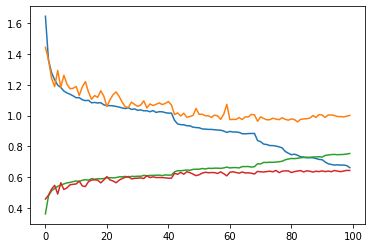

In [10]:
import pickle
pickle.dump(hist, open('featureactv4_baseline_hist.hdf5', 'wb'))
plt.plot(hist), best_acc

In [11]:
test_model = torch.load('featureactv4_baseline_model.pt')

# EVALUATE
test_model.eval()
running_valloss = 0.0
running_valacc = 0.0
for i,data in enumerate(test_loader):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = test_model(inputs)

    loss = criterion(outputs, labels)
    acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

    running_valloss += (loss.item() * inputs.size(0))
    running_valacc += acc.item()

print('- Avg. val_loss: %.3f | Avg. val_acc: %.3f' % (running_valloss / len(test_loader.dataset), running_valacc / len(test_loader.dataset)))

- Avg. val_loss: 0.976 | Avg. val_acc: 0.661


## Feature Act v4.2, add l2 norm

In [9]:
class FeatureAct(nn.Module):
    def __init__(self, src_depth, reduce_factor=1):
        super(FeatureAct, self).__init__()
        
#         self.softmax = nn.Softmax(dim=2)
        self.sigmoid = nn.Sigmoid()
        
        self.src_conv = nn.Conv2d(src_depth, src_depth // reduce_factor, kernel_size=1, padding=False)
        self.target_conv = nn.Conv2d(src_depth, src_depth // reduce_factor, kernel_size=1, padding=False)
        
        self.down_depth = nn.Sequential(nn.Conv2d(src_depth, src_depth // reduce_factor, kernel_size=1, padding=False),
                                        nn.ReLU(inplace=True))
        self.up_depth = nn.Sequential(nn.Conv2d(src_depth // reduce_factor, src_depth, kernel_size=1, padding=False),
                                      nn.ReLU(inplace=True))
        
    def forward(self, x):
        
        src_features = self.src_conv(x)
        target_features = self.target_conv(x)
        
        cor = nn.Flatten(-2)(src_features[:, None, :, :]).permute(0,2,1,3) * nn.Flatten(-2)(target_features[:, None, :, :])
#         cor = cor / (torch.norm(cor) + 1e-7)
#         cor = self.softmax(cor)
        
        main_features = self.down_depth(x)
    
        cor_feature = torch.cat([(main_features * cor[:, :, k].view(-1, src_features.size(-3), src_features.size(-2), src_features.size(-1))).sum(1, keepdim=True) for k in range(cor.size(2))], dim=1)
        cor_feature = self.up_depth(cor_feature)
        cor_feature = cor_feature / (torch.norm(cor_feature) + 1e-7)
        cor_feature = self.sigmoid(cor_feature)
        
        x = x * (1 + cor_feature)
        
        return x

In [10]:
class BaselineFeatureAct(nn.Module):
    def __init__(self, embeddings=False):
        
        super(BaselineFeatureAct, self).__init__()
        
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=(2,2), stride=2)
        
        self.conv0 = nn.Conv2d(1, 32, kernel_size=(3,3), padding=1, stride=1)
        self.conv0b = nn.Conv2d(32, 32, kernel_size=(3,3), padding=1, stride=1)
        self.bn0 = nn.BatchNorm2d(32)
        self.bn0b = nn.BatchNorm2d(32)
        
        self.conv1 = nn.Conv2d(32, 64, kernel_size=(3,3), padding=1, stride=1)
        self.conv1b = nn.Conv2d(64, 64, kernel_size=(3,3), padding=1, stride=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.bn1b = nn.BatchNorm2d(64)
        
        self.conv2 = nn.Conv2d(64, 128, kernel_size=(3,3), padding=1, stride=1)
        self.conv2b = nn.Conv2d(128, 128, kernel_size=(3,3), padding=1, stride=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn2b = nn.BatchNorm2d(128)
        
        self.conv3 = nn.Conv2d(128, 256, kernel_size=(3,3), padding=1, stride=1)
        self.conv3b = nn.Conv2d(256, 256, kernel_size=(3,3), padding=1, stride=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.bn3b = nn.BatchNorm2d(256)
  
        self.fact0 = FeatureAct(32, 4)
        self.fact1 = FeatureAct(64, 4)
        self.fact2 = FeatureAct(128, 4)
        self.fact3 = FeatureAct(256, 4)
        
        if not embeddings:
            self.classifier = nn.Sequential(nn.Flatten(),
                                            nn.Linear(2304, 256), nn.BatchNorm1d(256), nn.ReLU(inplace=True),
                                            nn.Linear(256, 128), nn.BatchNorm1d(128), nn.ReLU(inplace=True),
                                            nn.Linear(128, 7), nn.BatchNorm1d(7))
        else:
            self.classifier = nn.Sequential(nn.Flatten(),
                                            nn.Linear(2304, 256), nn.BatchNorm1d(256), nn.ReLU(inplace=True),
                                            nn.Linear(256, 128), nn.BatchNorm1d(128))
        
    def forward(self, x):
        
        x = self.conv0(x)
        x = self.bn0(x)
        x = self.relu(x)
        x = self.conv0b(x)
        x = self.bn0b(x)
        x = self.relu(x)
        
        x0 = self.maxpool(x)
        x0 = self.fact0(x0)
        
        x = self.conv1(x0)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv1b(x)
        x = self.bn1b(x)
        x = self.relu(x)
        
        x1 = self.maxpool(x)
        x1 = self.fact1(x1)
        
        x = self.conv2(x1)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv2b(x)
        x = self.bn2b(x)
        x = self.relu(x)
        
        x2 = self.maxpool(x)
        x2 = self.fact2(x2)
        
        x = self.conv3(x2)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.conv3b(x)
        x = self.bn3b(x)
        x = self.relu(x)
        
        x3 = self.maxpool(x)
        x3 = self.fact3(x3)
        
        x = nn.Flatten()(x3)
        x = self.classifier(x)
        
        return x

In [11]:
device = torch.device('cuda')
model = BaselineFeatureAct().to(device)

best_acc = 0.0
hist = []

epochs=100

criterion = nn.CrossEntropyLoss()

learning_rate = 0.004
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=7, verbose=True)


In [12]:
model_path = './featureactv42_baseline_model.pt'

for epoch in range(100):  # loop over the dataset multiple times

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0
    processed = 0.0

    # TRAIN
    model.train()
    pbar = tqdm(train_loader, position=0)
    for i, data in enumerate(pbar):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()
        loss.backward()
        
        optimizer.step()

        # print statistics
        running_loss += (loss.item() * inputs.size(0))
        running_acc += acc.item()
        processed += len(inputs)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={i} Accuracy={acc.item() / inputs.size(0)}')

    print('- Avg.loss: %.3f | Avg.acc: %.3f' % (running_loss / len(train_loader.dataset), running_acc / len(train_loader.dataset)))
    avgloss = running_loss / len(train_loader.dataset)
    avgacc = running_acc / len(train_loader.dataset)

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

        running_valloss += (loss.item() * inputs.size(0))
        running_valacc += acc.item()

    print('- Avg. val_loss: %.3f | Avg. val_acc: %.3f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

    avgvalloss = running_valloss / len(val_loader.dataset)
    avgvalacc = running_valacc / len(val_loader.dataset)
    
    scheduler.step(avgvalloss)

    hist.append([avgloss, avgvalloss, avgacc, avgvalacc])
    
    if best_acc < avgvalacc:
        best_acc = avgvalacc
        torch.save(model, model_path)
        print('* Update optimal model')

print('Finished Training')

  0%|          | 0/225 [00:00<?, ?it/s]

Epoch:  1


Loss=1.3970149755477905 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [00:34<00:00,  6.48it/s]

- Avg.loss: 1.649 | Avg.acc: 0.365



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.426 | Avg. val_acc: 0.453
* Update optimal model
Epoch:  2


Loss=1.1621845960617065 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:34<00:00,  6.43it/s]

- Avg.loss: 1.359 | Avg.acc: 0.482



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.350 | Avg. val_acc: 0.473
* Update optimal model
Epoch:  3


Loss=1.595861792564392 Batch_id=224 Accuracy=0.35135135135135137: 100%|██████████| 225/225 [00:34<00:00,  6.48it/s]

- Avg.loss: 1.281 | Avg.acc: 0.514



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.213 | Avg. val_acc: 0.544
* Update optimal model
Epoch:  4


Loss=1.125322699546814 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:35<00:00,  6.41it/s]

- Avg.loss: 1.225 | Avg.acc: 0.532



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.180 | Avg. val_acc: 0.549
* Update optimal model
Epoch:  5


Loss=1.619716763496399 Batch_id=224 Accuracy=0.3783783783783784: 100%|██████████| 225/225 [00:34<00:00,  6.47it/s]

- Avg.loss: 1.198 | Avg.acc: 0.543



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.214 | Avg. val_acc: 0.536
Epoch:  6


Loss=0.9932344555854797 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:34<00:00,  6.45it/s]

- Avg.loss: 1.173 | Avg.acc: 0.554



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.224 | Avg. val_acc: 0.524
Epoch:  7


Loss=0.9892892837524414 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:34<00:00,  6.46it/s]

- Avg.loss: 1.160 | Avg.acc: 0.558



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.172 | Avg. val_acc: 0.555
* Update optimal model
Epoch:  8


Loss=1.1230257749557495 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [00:34<00:00,  6.46it/s]

- Avg.loss: 1.146 | Avg.acc: 0.565



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.135 | Avg. val_acc: 0.565
* Update optimal model
Epoch:  9


Loss=1.3637678623199463 Batch_id=224 Accuracy=0.4594594594594595: 100%|██████████| 225/225 [00:34<00:00,  6.46it/s]

- Avg.loss: 1.131 | Avg.acc: 0.571



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.129 | Avg. val_acc: 0.571
* Update optimal model
Epoch:  10


Loss=0.9734545350074768 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:34<00:00,  6.48it/s]

- Avg.loss: 1.121 | Avg.acc: 0.576



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.165 | Avg. val_acc: 0.552
Epoch:  11


Loss=1.165419578552246 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:34<00:00,  6.45it/s]

- Avg.loss: 1.120 | Avg.acc: 0.572



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.095 | Avg. val_acc: 0.583
* Update optimal model
Epoch:  12


Loss=1.0314387083053589 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:34<00:00,  6.46it/s]

- Avg.loss: 1.112 | Avg.acc: 0.579



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.084 | Avg. val_acc: 0.592
* Update optimal model
Epoch:  13


Loss=1.1607862710952759 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [00:34<00:00,  6.46it/s]

- Avg.loss: 1.101 | Avg.acc: 0.582



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.122 | Avg. val_acc: 0.582
Epoch:  14


Loss=1.0690486431121826 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:34<00:00,  6.47it/s]

- Avg.loss: 1.098 | Avg.acc: 0.583



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.175 | Avg. val_acc: 0.558
Epoch:  15


Loss=0.9999803900718689 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:35<00:00,  6.42it/s]

- Avg.loss: 1.096 | Avg.acc: 0.585



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.185 | Avg. val_acc: 0.568
Epoch:  16


Loss=1.0991849899291992 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:34<00:00,  6.49it/s]

- Avg.loss: 1.090 | Avg.acc: 0.587



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.109 | Avg. val_acc: 0.589
Epoch:  17


Loss=1.1703753471374512 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:34<00:00,  6.48it/s]

- Avg.loss: 1.086 | Avg.acc: 0.589



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.156 | Avg. val_acc: 0.538
Epoch:  18


Loss=1.2694989442825317 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:34<00:00,  6.45it/s]

- Avg.loss: 1.081 | Avg.acc: 0.594



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.211 | Avg. val_acc: 0.557
Epoch:  19


Loss=1.076093316078186 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [00:34<00:00,  6.46it/s]

- Avg.loss: 1.077 | Avg.acc: 0.592



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.118 | Avg. val_acc: 0.574
Epoch:  20


Loss=1.3126333951950073 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:34<00:00,  6.44it/s]

- Avg.loss: 1.068 | Avg.acc: 0.591



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.093 | Avg. val_acc: 0.585
Epoch    20: reducing learning rate of group 0 to 2.0000e-03.
Epoch:  21


Loss=0.7272812128067017 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:34<00:00,  6.50it/s]

- Avg.loss: 1.015 | Avg.acc: 0.617



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.045 | Avg. val_acc: 0.602
* Update optimal model
Epoch:  22


Loss=1.136902928352356 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [00:34<00:00,  6.47it/s]

- Avg.loss: 1.000 | Avg.acc: 0.621



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.036 | Avg. val_acc: 0.612
* Update optimal model
Epoch:  23


Loss=1.3861980438232422 Batch_id=224 Accuracy=0.43243243243243246: 100%|██████████| 225/225 [00:34<00:00,  6.48it/s]

- Avg.loss: 0.993 | Avg.acc: 0.625



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.022 | Avg. val_acc: 0.612
* Update optimal model
Epoch:  24


Loss=0.8946356773376465 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:35<00:00,  6.42it/s]

- Avg.loss: 0.987 | Avg.acc: 0.627



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.033 | Avg. val_acc: 0.614
* Update optimal model
Epoch:  25


Loss=1.0697051286697388 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [00:34<00:00,  6.43it/s]

- Avg.loss: 0.982 | Avg.acc: 0.630



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.041 | Avg. val_acc: 0.617
* Update optimal model
Epoch:  26


Loss=0.9338063597679138 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:34<00:00,  6.44it/s]

- Avg.loss: 0.974 | Avg.acc: 0.633



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.006 | Avg. val_acc: 0.628
* Update optimal model
Epoch:  27


Loss=1.023026466369629 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:34<00:00,  6.46it/s]

- Avg.loss: 0.970 | Avg.acc: 0.632



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.040 | Avg. val_acc: 0.604
Epoch:  28


Loss=1.3151441812515259 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:34<00:00,  6.45it/s]

- Avg.loss: 0.967 | Avg.acc: 0.638



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.022 | Avg. val_acc: 0.621
Epoch:  29


Loss=0.8680455088615417 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:34<00:00,  6.43it/s]

- Avg.loss: 0.963 | Avg.acc: 0.638



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.004 | Avg. val_acc: 0.624
Epoch:  30


Loss=1.0998364686965942 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:34<00:00,  6.46it/s]

- Avg.loss: 0.951 | Avg.acc: 0.639



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.011 | Avg. val_acc: 0.619
Epoch:  31


Loss=0.9586745500564575 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:34<00:00,  6.47it/s]

- Avg.loss: 0.951 | Avg.acc: 0.644



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.993 | Avg. val_acc: 0.630
* Update optimal model
Epoch:  32


Loss=0.9364631175994873 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:34<00:00,  6.46it/s]

- Avg.loss: 0.947 | Avg.acc: 0.640



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.020 | Avg. val_acc: 0.616
Epoch:  33


Loss=1.0912339687347412 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:34<00:00,  6.48it/s]

- Avg.loss: 0.936 | Avg.acc: 0.648



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.995 | Avg. val_acc: 0.626
Epoch:  34


Loss=0.8564228415489197 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:34<00:00,  6.44it/s]

- Avg.loss: 0.934 | Avg.acc: 0.648



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.035 | Avg. val_acc: 0.610
Epoch:  35


Loss=1.037085771560669 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:34<00:00,  6.44it/s]

- Avg.loss: 0.934 | Avg.acc: 0.647



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.997 | Avg. val_acc: 0.622
Epoch:  36


Loss=1.0290054082870483 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:34<00:00,  6.46it/s]

- Avg.loss: 0.928 | Avg.acc: 0.648



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.999 | Avg. val_acc: 0.628
Epoch:  37


Loss=0.9359127879142761 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:34<00:00,  6.47it/s]

- Avg.loss: 0.922 | Avg.acc: 0.653



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.013 | Avg. val_acc: 0.626
Epoch:  38


Loss=0.8876670598983765 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:35<00:00,  6.36it/s]

- Avg.loss: 0.923 | Avg.acc: 0.653



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.031 | Avg. val_acc: 0.619
Epoch:  39


Loss=0.8638254404067993 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:34<00:00,  6.48it/s]

- Avg.loss: 0.915 | Avg.acc: 0.655



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.041 | Avg. val_acc: 0.620
Epoch    39: reducing learning rate of group 0 to 1.0000e-03.
Epoch:  40


Loss=0.7353112697601318 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [00:35<00:00,  6.42it/s]

- Avg.loss: 0.874 | Avg.acc: 0.672



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.981 | Avg. val_acc: 0.639
* Update optimal model
Epoch:  41


Loss=0.9184820055961609 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:34<00:00,  6.47it/s]

- Avg.loss: 0.858 | Avg.acc: 0.679



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.969 | Avg. val_acc: 0.641
* Update optimal model
Epoch:  42


Loss=0.8713712692260742 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:34<00:00,  6.44it/s]

- Avg.loss: 0.843 | Avg.acc: 0.685



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.969 | Avg. val_acc: 0.645
* Update optimal model
Epoch:  43


Loss=0.6482668519020081 Batch_id=224 Accuracy=0.8108108108108109: 100%|██████████| 225/225 [00:35<00:00,  6.41it/s]

- Avg.loss: 0.839 | Avg.acc: 0.684



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.962 | Avg. val_acc: 0.648
* Update optimal model
Epoch:  44


Loss=0.9734364151954651 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:35<00:00,  6.35it/s]

- Avg.loss: 0.833 | Avg.acc: 0.690



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.968 | Avg. val_acc: 0.640
Epoch:  45


Loss=0.8967978954315186 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:35<00:00,  6.42it/s]

- Avg.loss: 0.829 | Avg.acc: 0.693



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.988 | Avg. val_acc: 0.632
Epoch:  46


Loss=0.7766820788383484 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:35<00:00,  6.41it/s]

- Avg.loss: 0.825 | Avg.acc: 0.692



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.985 | Avg. val_acc: 0.633
Epoch:  47


Loss=0.9015474319458008 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:34<00:00,  6.47it/s]

- Avg.loss: 0.815 | Avg.acc: 0.700



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.970 | Avg. val_acc: 0.650
* Update optimal model
Epoch:  48


Loss=0.8365811109542847 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:34<00:00,  6.47it/s]

- Avg.loss: 0.818 | Avg.acc: 0.696



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.967 | Avg. val_acc: 0.651
* Update optimal model
Epoch:  49


Loss=1.0018082857131958 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:34<00:00,  6.46it/s]

- Avg.loss: 0.809 | Avg.acc: 0.697



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.973 | Avg. val_acc: 0.650
Epoch:  50


Loss=0.8863741755485535 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:35<00:00,  6.43it/s]

- Avg.loss: 0.805 | Avg.acc: 0.700



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.992 | Avg. val_acc: 0.634
Epoch:  51


Loss=0.7618554830551147 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:34<00:00,  6.44it/s]

- Avg.loss: 0.800 | Avg.acc: 0.702



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.988 | Avg. val_acc: 0.643
Epoch    51: reducing learning rate of group 0 to 5.0000e-04.
Epoch:  52


Loss=0.4414776861667633 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:34<00:00,  6.46it/s]

- Avg.loss: 0.767 | Avg.acc: 0.716



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.963 | Avg. val_acc: 0.652
* Update optimal model
Epoch:  53


Loss=0.634566605091095 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [00:34<00:00,  6.48it/s]

- Avg.loss: 0.748 | Avg.acc: 0.722



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.966 | Avg. val_acc: 0.646
Epoch:  54


Loss=0.758708119392395 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:34<00:00,  6.46it/s]

- Avg.loss: 0.738 | Avg.acc: 0.727



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.984 | Avg. val_acc: 0.642
Epoch:  55


Loss=0.7223139405250549 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [00:35<00:00,  6.42it/s]

- Avg.loss: 0.732 | Avg.acc: 0.728



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.978 | Avg. val_acc: 0.645
Epoch:  56


Loss=1.067828893661499 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:35<00:00,  6.41it/s]

- Avg.loss: 0.726 | Avg.acc: 0.731



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.975 | Avg. val_acc: 0.644
Epoch:  57


Loss=0.8974800109863281 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:34<00:00,  6.47it/s]

- Avg.loss: 0.724 | Avg.acc: 0.733



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.979 | Avg. val_acc: 0.648
Epoch:  58


Loss=0.9076680541038513 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:34<00:00,  6.51it/s]

- Avg.loss: 0.716 | Avg.acc: 0.737



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.981 | Avg. val_acc: 0.646
Epoch:  59


Loss=0.677820086479187 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [00:35<00:00,  6.42it/s]

- Avg.loss: 0.708 | Avg.acc: 0.738



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.974 | Avg. val_acc: 0.654
Epoch    59: reducing learning rate of group 0 to 2.5000e-04.
* Update optimal model
Epoch:  60


Loss=0.7446606159210205 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:34<00:00,  6.48it/s]

- Avg.loss: 0.689 | Avg.acc: 0.748



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.970 | Avg. val_acc: 0.658
* Update optimal model
Epoch:  61


Loss=0.6597684025764465 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:35<00:00,  6.43it/s]

- Avg.loss: 0.670 | Avg.acc: 0.751



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.976 | Avg. val_acc: 0.660
* Update optimal model
Epoch:  62


Loss=0.5137760043144226 Batch_id=224 Accuracy=0.8108108108108109: 100%|██████████| 225/225 [00:35<00:00,  6.43it/s]

- Avg.loss: 0.670 | Avg.acc: 0.754



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.976 | Avg. val_acc: 0.660
Epoch:  63


Loss=0.4719923436641693 Batch_id=224 Accuracy=0.8918918918918919: 100%|██████████| 225/225 [00:35<00:00,  6.39it/s]

- Avg.loss: 0.665 | Avg.acc: 0.755



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.981 | Avg. val_acc: 0.657
Epoch:  64


Loss=0.6428003311157227 Batch_id=224 Accuracy=0.8648648648648649: 100%|██████████| 225/225 [00:34<00:00,  6.45it/s]

- Avg.loss: 0.665 | Avg.acc: 0.757



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.987 | Avg. val_acc: 0.658
Epoch:  65


Loss=0.6534008383750916 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [00:34<00:00,  6.44it/s]

- Avg.loss: 0.655 | Avg.acc: 0.758



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.977 | Avg. val_acc: 0.659
Epoch:  66


Loss=0.6367707848548889 Batch_id=224 Accuracy=0.8108108108108109: 100%|██████████| 225/225 [00:34<00:00,  6.46it/s]

- Avg.loss: 0.652 | Avg.acc: 0.760



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.985 | Avg. val_acc: 0.661
* Update optimal model
Epoch:  67


Loss=0.4694187045097351 Batch_id=224 Accuracy=0.8648648648648649: 100%|██████████| 225/225 [00:35<00:00,  6.41it/s]

- Avg.loss: 0.651 | Avg.acc: 0.759



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.991 | Avg. val_acc: 0.659
Epoch    67: reducing learning rate of group 0 to 1.2500e-04.
Epoch:  68


Loss=0.49581146240234375 Batch_id=224 Accuracy=0.8108108108108109: 100%|██████████| 225/225 [00:34<00:00,  6.50it/s]

- Avg.loss: 0.642 | Avg.acc: 0.763



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.989 | Avg. val_acc: 0.659
Epoch:  69


Loss=0.6968280673027039 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:35<00:00,  6.43it/s]

- Avg.loss: 0.628 | Avg.acc: 0.770



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.997 | Avg. val_acc: 0.658
Epoch:  70


Loss=0.8001587986946106 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:34<00:00,  6.43it/s]

- Avg.loss: 0.627 | Avg.acc: 0.771



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.997 | Avg. val_acc: 0.658
Epoch:  71


Loss=0.7291901707649231 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:34<00:00,  6.46it/s]

- Avg.loss: 0.627 | Avg.acc: 0.771



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.997 | Avg. val_acc: 0.665
* Update optimal model
Epoch:  72


Loss=0.6470097899436951 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:34<00:00,  6.47it/s]

- Avg.loss: 0.624 | Avg.acc: 0.771



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.998 | Avg. val_acc: 0.654
Epoch:  73


Loss=0.7270084619522095 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:34<00:00,  6.48it/s]

- Avg.loss: 0.618 | Avg.acc: 0.773



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.002 | Avg. val_acc: 0.660
Epoch:  74


Loss=0.685377299785614 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [00:34<00:00,  6.50it/s]

- Avg.loss: 0.618 | Avg.acc: 0.776



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.009 | Avg. val_acc: 0.657
Epoch:  75


Loss=0.7121895551681519 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:34<00:00,  6.47it/s]

- Avg.loss: 0.613 | Avg.acc: 0.776



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.017 | Avg. val_acc: 0.656
Epoch    75: reducing learning rate of group 0 to 6.2500e-05.
Epoch:  76


Loss=0.7729253768920898 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:34<00:00,  6.48it/s]

- Avg.loss: 0.600 | Avg.acc: 0.780



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.008 | Avg. val_acc: 0.657
Epoch:  77


Loss=0.5393983721733093 Batch_id=224 Accuracy=0.8108108108108109: 100%|██████████| 225/225 [00:34<00:00,  6.44it/s]

- Avg.loss: 0.605 | Avg.acc: 0.777



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.011 | Avg. val_acc: 0.651
Epoch:  78


Loss=0.5841957330703735 Batch_id=224 Accuracy=0.8378378378378378: 100%|██████████| 225/225 [00:34<00:00,  6.48it/s]

- Avg.loss: 0.596 | Avg.acc: 0.783



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.008 | Avg. val_acc: 0.657
Epoch:  79


Loss=0.5316671133041382 Batch_id=224 Accuracy=0.8648648648648649: 100%|██████████| 225/225 [00:34<00:00,  6.46it/s]

- Avg.loss: 0.597 | Avg.acc: 0.782



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.015 | Avg. val_acc: 0.660
Epoch:  80


Loss=0.5760253667831421 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:34<00:00,  6.48it/s]

- Avg.loss: 0.594 | Avg.acc: 0.782



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.012 | Avg. val_acc: 0.653
Epoch:  81


Loss=0.726780116558075 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:35<00:00,  6.41it/s]

- Avg.loss: 0.597 | Avg.acc: 0.783



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.011 | Avg. val_acc: 0.653
Epoch:  82


Loss=0.46383950114250183 Batch_id=224 Accuracy=0.8378378378378378: 100%|██████████| 225/225 [00:35<00:00,  6.39it/s]

- Avg.loss: 0.592 | Avg.acc: 0.786



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.011 | Avg. val_acc: 0.658
Epoch:  83


Loss=0.6413614153862 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [00:34<00:00,  6.46it/s]

- Avg.loss: 0.586 | Avg.acc: 0.786



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.017 | Avg. val_acc: 0.655
Epoch    83: reducing learning rate of group 0 to 3.1250e-05.
Epoch:  84


Loss=0.7593601942062378 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:34<00:00,  6.43it/s]

- Avg.loss: 0.584 | Avg.acc: 0.788



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.010 | Avg. val_acc: 0.656
Epoch:  85


Loss=0.8488531112670898 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:35<00:00,  6.43it/s]

- Avg.loss: 0.584 | Avg.acc: 0.786



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.020 | Avg. val_acc: 0.662
Epoch:  86


Loss=0.6183350682258606 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [00:34<00:00,  6.46it/s]

- Avg.loss: 0.581 | Avg.acc: 0.788



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.017 | Avg. val_acc: 0.660
Epoch:  87


Loss=0.6405118107795715 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [00:35<00:00,  6.43it/s]

- Avg.loss: 0.584 | Avg.acc: 0.788



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.025 | Avg. val_acc: 0.660
Epoch:  88


Loss=1.0106620788574219 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:34<00:00,  6.45it/s]

- Avg.loss: 0.585 | Avg.acc: 0.789



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.019 | Avg. val_acc: 0.658
Epoch:  89


Loss=0.601904571056366 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [00:34<00:00,  6.50it/s]

- Avg.loss: 0.581 | Avg.acc: 0.787



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.020 | Avg. val_acc: 0.657
Epoch:  90


Loss=0.6944795250892639 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:35<00:00,  6.42it/s]

- Avg.loss: 0.579 | Avg.acc: 0.789



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.026 | Avg. val_acc: 0.654
Epoch:  91


Loss=0.5796809792518616 Batch_id=224 Accuracy=0.8108108108108109: 100%|██████████| 225/225 [00:34<00:00,  6.47it/s]

- Avg.loss: 0.583 | Avg.acc: 0.789



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.031 | Avg. val_acc: 0.662
Epoch    91: reducing learning rate of group 0 to 1.5625e-05.
Epoch:  92


Loss=0.493380069732666 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [00:34<00:00,  6.44it/s]

- Avg.loss: 0.575 | Avg.acc: 0.790



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.028 | Avg. val_acc: 0.658
Epoch:  93


Loss=0.8593555688858032 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:35<00:00,  6.42it/s]

- Avg.loss: 0.580 | Avg.acc: 0.789



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.028 | Avg. val_acc: 0.660
Epoch:  94


Loss=0.4437704384326935 Batch_id=224 Accuracy=0.8108108108108109: 100%|██████████| 225/225 [00:34<00:00,  6.46it/s]

- Avg.loss: 0.581 | Avg.acc: 0.787



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.030 | Avg. val_acc: 0.657
Epoch:  95


Loss=0.672884464263916 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [00:35<00:00,  6.42it/s]

- Avg.loss: 0.579 | Avg.acc: 0.790



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.034 | Avg. val_acc: 0.656
Epoch:  96


Loss=0.7559032440185547 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:34<00:00,  6.45it/s]

- Avg.loss: 0.575 | Avg.acc: 0.793



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.036 | Avg. val_acc: 0.658
Epoch:  97


Loss=0.5621522068977356 Batch_id=224 Accuracy=0.8108108108108109: 100%|██████████| 225/225 [00:34<00:00,  6.44it/s]

- Avg.loss: 0.577 | Avg.acc: 0.792



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.029 | Avg. val_acc: 0.656
Epoch:  98


Loss=0.7290674448013306 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:34<00:00,  6.51it/s]

- Avg.loss: 0.578 | Avg.acc: 0.791



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.034 | Avg. val_acc: 0.656
Epoch:  99


Loss=0.5716513395309448 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:35<00:00,  6.41it/s]

- Avg.loss: 0.571 | Avg.acc: 0.791



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.031 | Avg. val_acc: 0.655
Epoch    99: reducing learning rate of group 0 to 7.8125e-06.
Epoch:  100


Loss=0.7439893484115601 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [00:34<00:00,  6.43it/s]

- Avg.loss: 0.578 | Avg.acc: 0.790


- Avg. val_loss: 1.037 | Avg. val_acc: 0.656
Finished Training


([<matplotlib.lines.Line2D at 0x7fba37532b00>,
 0.6645305098913347)

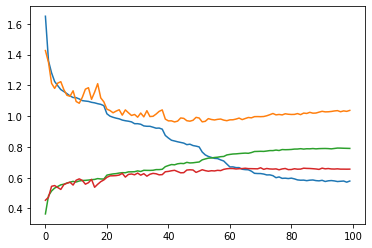

In [13]:
import pickle

pickle.dump(hist, open('featureactv42_baseline_hist.hdf5', 'wb'))
plt.plot(hist), best_acc

In [15]:
test_model = torch.load('featureactv42_baseline_model.pt')

# EVALUATE
test_model.eval()
running_valloss = 0.0
running_valacc = 0.0
for i,data in enumerate(test_loader):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = test_model(inputs)

    loss = criterion(outputs, labels)
    acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

    running_valloss += (loss.item() * inputs.size(0))
    running_valacc += acc.item()

print('- Avg. val_loss: %.3f | Avg. val_acc: %.3f' % (running_valloss / len(test_loader.dataset), running_valacc / len(test_loader.dataset)))

- Avg. val_loss: 0.968 | Avg. val_acc: 0.668


## Feature Act v4.2.2, replace l2 norm by LayerNorm

In [15]:
class FeatureAct(nn.Module):
    def __init__(self, src_depth, reduce_factor, input_size):
        super(FeatureAct, self).__init__()
        
#         self.softmax = nn.Softmax(dim=2)
        self.sigmoid = nn.Sigmoid()
        self.norm = nn.LayerNorm(input_size)
        
        self.src_conv = nn.Conv2d(src_depth, src_depth // reduce_factor, kernel_size=1, padding=False)
        self.target_conv = nn.Conv2d(src_depth, src_depth // reduce_factor, kernel_size=1, padding=False)
        
        self.down_depth = nn.Sequential(nn.Conv2d(src_depth, src_depth // reduce_factor, kernel_size=1, padding=False),
                                        nn.ReLU(inplace=True))
        self.up_depth = nn.Sequential(nn.Conv2d(src_depth // reduce_factor, src_depth, kernel_size=1, padding=False),
                                      nn.ReLU(inplace=True))
        
    def forward(self, x):
        
        src_features = self.src_conv(x)
        target_features = self.target_conv(x)
        
        cor = nn.Flatten(-2)(src_features[:, None, :, :]).permute(0,2,1,3) * nn.Flatten(-2)(target_features[:, None, :, :])
#         cor = cor / (torch.norm(cor) + 1e-7)
#         cor = self.softmax(cor)
        
        main_features = self.down_depth(x)
    
        cor_feature = torch.cat([(main_features * cor[:, :, k].view(-1, src_features.size(-3), src_features.size(-2), src_features.size(-1))).sum(1, keepdim=True) for k in range(cor.size(2))], dim=1)
        cor_feature = self.up_depth(cor_feature)
#         cor_feature = cor_feature / (torch.norm(cor_feature) + 1e-7)
        cor_feature = self.norm(cor_feature)
        cor_feature = self.sigmoid(cor_feature)
        
        x = x * (1 + cor_feature)
        
        return x

In [16]:
class BaselineFeatureAct(nn.Module):
    def __init__(self, embeddings=False):
        
        super(BaselineFeatureAct, self).__init__()
        
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=(2,2), stride=2)
        
        self.conv0 = nn.Conv2d(1, 32, kernel_size=(3,3), padding=1, stride=1)
        self.conv0b = nn.Conv2d(32, 32, kernel_size=(3,3), padding=1, stride=1)
        self.bn0 = nn.BatchNorm2d(32)
        self.bn0b = nn.BatchNorm2d(32)
        
        self.conv1 = nn.Conv2d(32, 64, kernel_size=(3,3), padding=1, stride=1)
        self.conv1b = nn.Conv2d(64, 64, kernel_size=(3,3), padding=1, stride=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.bn1b = nn.BatchNorm2d(64)
        
        self.conv2 = nn.Conv2d(64, 128, kernel_size=(3,3), padding=1, stride=1)
        self.conv2b = nn.Conv2d(128, 128, kernel_size=(3,3), padding=1, stride=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn2b = nn.BatchNorm2d(128)
        
        self.conv3 = nn.Conv2d(128, 256, kernel_size=(3,3), padding=1, stride=1)
        self.conv3b = nn.Conv2d(256, 256, kernel_size=(3,3), padding=1, stride=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.bn3b = nn.BatchNorm2d(256)
  
        self.fact0 = FeatureAct(32, 4, input_size=(32, 24, 24))
        self.fact1 = FeatureAct(64, 4, input_size=(64, 12, 12))
        self.fact2 = FeatureAct(128, 4, input_size=(128, 6, 6))
        self.fact3 = FeatureAct(256, 4, input_size=(256, 3, 3))
        
        if not embeddings:
            self.classifier = nn.Sequential(nn.Flatten(),
                                            nn.Linear(2304, 256), nn.BatchNorm1d(256), nn.ReLU(inplace=True),
                                            nn.Linear(256, 128), nn.BatchNorm1d(128), nn.ReLU(inplace=True),
                                            nn.Linear(128, 7), nn.BatchNorm1d(7))
        else:
            self.classifier = nn.Sequential(nn.Flatten(),
                                            nn.Linear(2304, 256), nn.BatchNorm1d(256), nn.ReLU(inplace=True),
                                            nn.Linear(256, 128), nn.BatchNorm1d(128))
        
    def forward(self, x):
        
        x = self.conv0(x)
        x = self.bn0(x)
        x = self.relu(x)
        x = self.conv0b(x)
        x = self.bn0b(x)
        x = self.relu(x)
        
        x0 = self.maxpool(x)
        x0 = self.fact0(x0)
        
        x = self.conv1(x0)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv1b(x)
        x = self.bn1b(x)
        x = self.relu(x)
        
        x1 = self.maxpool(x)
        x1 = self.fact1(x1)
        
        x = self.conv2(x1)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv2b(x)
        x = self.bn2b(x)
        x = self.relu(x)
        
        x2 = self.maxpool(x)
        x2 = self.fact2(x2)
        
        x = self.conv3(x2)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.conv3b(x)
        x = self.bn3b(x)
        x = self.relu(x)
        
        x3 = self.maxpool(x)
        x3 = self.fact3(x3)
        
        x = nn.Flatten()(x3)
        x = self.classifier(x)
        
        return x

In [17]:
device = torch.device('cuda')
model = BaselineFeatureAct().to(device)

best_acc = 0.0
hist = []

epochs=100

criterion = nn.CrossEntropyLoss()

learning_rate = 0.004
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=7, verbose=True)


In [18]:
model_path = './featureactv422_baseline_model.pt'

for epoch in range(100):  # loop over the dataset multiple times

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0
    processed = 0.0

    # TRAIN
    model.train()
    pbar = tqdm(train_loader, position=0)
    for i, data in enumerate(pbar):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()
        loss.backward()
        
        optimizer.step()

        # print statistics
        running_loss += (loss.item() * inputs.size(0))
        running_acc += acc.item()
        processed += len(inputs)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={i} Accuracy={acc.item() / inputs.size(0)}')

    print('- Avg.loss: %.3f | Avg.acc: %.3f' % (running_loss / len(train_loader.dataset), running_acc / len(train_loader.dataset)))
    avgloss = running_loss / len(train_loader.dataset)
    avgacc = running_acc / len(train_loader.dataset)

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

        running_valloss += (loss.item() * inputs.size(0))
        running_valacc += acc.item()

    print('- Avg. val_loss: %.3f | Avg. val_acc: %.3f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

    avgvalloss = running_valloss / len(val_loader.dataset)
    avgvalacc = running_valacc / len(val_loader.dataset)
    
    scheduler.step(avgvalloss)

    hist.append([avgloss, avgvalloss, avgacc, avgvalacc])
    
    if best_acc < avgvalacc:
        best_acc = avgvalacc
        torch.save(model, model_path)
        print('* Update optimal model')

print('Finished Training')

  0%|          | 0/225 [00:00<?, ?it/s]

Epoch:  1


Loss=1.5294889211654663 Batch_id=224 Accuracy=0.3783783783783784: 100%|██████████| 225/225 [00:34<00:00,  6.48it/s]

- Avg.loss: 1.702 | Avg.acc: 0.340



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.509 | Avg. val_acc: 0.418
* Update optimal model
Epoch:  2


Loss=1.4468433856964111 Batch_id=224 Accuracy=0.4594594594594595: 100%|██████████| 225/225 [00:34<00:00,  6.43it/s]

- Avg.loss: 1.396 | Avg.acc: 0.464



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.340 | Avg. val_acc: 0.493
* Update optimal model
Epoch:  3


Loss=1.3716118335723877 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [00:34<00:00,  6.46it/s]

- Avg.loss: 1.294 | Avg.acc: 0.508



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.291 | Avg. val_acc: 0.488
Epoch:  4


Loss=1.3668558597564697 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [00:34<00:00,  6.47it/s]

- Avg.loss: 1.248 | Avg.acc: 0.524



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.278 | Avg. val_acc: 0.510
* Update optimal model
Epoch:  5


Loss=1.6557056903839111 Batch_id=224 Accuracy=0.35135135135135137: 100%|██████████| 225/225 [00:34<00:00,  6.49it/s]

- Avg.loss: 1.211 | Avg.acc: 0.537



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.237 | Avg. val_acc: 0.536
* Update optimal model
Epoch:  6


Loss=1.2360165119171143 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:35<00:00,  6.42it/s]

- Avg.loss: 1.192 | Avg.acc: 0.546



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.199 | Avg. val_acc: 0.556
* Update optimal model
Epoch:  7


Loss=1.3037282228469849 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:35<00:00,  6.42it/s]

- Avg.loss: 1.169 | Avg.acc: 0.556



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.230 | Avg. val_acc: 0.544
Epoch:  8


Loss=1.0987309217453003 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:35<00:00,  6.41it/s]

- Avg.loss: 1.155 | Avg.acc: 0.556



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.139 | Avg. val_acc: 0.563
* Update optimal model
Epoch:  9


Loss=1.1118392944335938 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:35<00:00,  6.39it/s]

- Avg.loss: 1.142 | Avg.acc: 0.564



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.183 | Avg. val_acc: 0.555
Epoch:  10


Loss=0.9384128451347351 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:35<00:00,  6.41it/s]

- Avg.loss: 1.135 | Avg.acc: 0.570



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.135 | Avg. val_acc: 0.565
* Update optimal model
Epoch:  11


Loss=1.113460898399353 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:34<00:00,  6.43it/s]

- Avg.loss: 1.125 | Avg.acc: 0.573



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.141 | Avg. val_acc: 0.567
* Update optimal model
Epoch:  12


Loss=1.2269474267959595 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:35<00:00,  6.39it/s]

- Avg.loss: 1.118 | Avg.acc: 0.575



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.126 | Avg. val_acc: 0.577
* Update optimal model
Epoch:  13


Loss=1.2214596271514893 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:34<00:00,  6.44it/s]

- Avg.loss: 1.113 | Avg.acc: 0.579



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.246 | Avg. val_acc: 0.538
Epoch:  14


Loss=0.9681612253189087 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:34<00:00,  6.48it/s]

- Avg.loss: 1.106 | Avg.acc: 0.579



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.150 | Avg. val_acc: 0.554
Epoch:  15


Loss=1.1581072807312012 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:34<00:00,  6.44it/s]

- Avg.loss: 1.098 | Avg.acc: 0.583



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.163 | Avg. val_acc: 0.575
Epoch:  16


Loss=0.9718583822250366 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:34<00:00,  6.44it/s]

- Avg.loss: 1.095 | Avg.acc: 0.581



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.128 | Avg. val_acc: 0.580
* Update optimal model
Epoch:  17


Loss=0.9198703169822693 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:35<00:00,  6.42it/s]

- Avg.loss: 1.087 | Avg.acc: 0.589



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.116 | Avg. val_acc: 0.590
* Update optimal model
Epoch:  18


Loss=0.7999194264411926 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:34<00:00,  6.45it/s]

- Avg.loss: 1.083 | Avg.acc: 0.589



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.094 | Avg. val_acc: 0.583
Epoch:  19


Loss=1.3108150959014893 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [00:35<00:00,  6.42it/s]

- Avg.loss: 1.076 | Avg.acc: 0.591



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.134 | Avg. val_acc: 0.566
Epoch:  20


Loss=1.2852998971939087 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:34<00:00,  6.43it/s]

- Avg.loss: 1.077 | Avg.acc: 0.595



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.099 | Avg. val_acc: 0.592
* Update optimal model
Epoch:  21


Loss=0.8028013110160828 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:35<00:00,  6.39it/s]

- Avg.loss: 1.068 | Avg.acc: 0.593



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.060 | Avg. val_acc: 0.600
* Update optimal model
Epoch:  22


Loss=1.095850944519043 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:35<00:00,  6.37it/s]

- Avg.loss: 1.064 | Avg.acc: 0.595



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.103 | Avg. val_acc: 0.592
Epoch:  23


Loss=1.218688726425171 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:34<00:00,  6.49it/s]

- Avg.loss: 1.061 | Avg.acc: 0.595



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.082 | Avg. val_acc: 0.587
Epoch:  24


Loss=0.9528272747993469 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:34<00:00,  6.44it/s]

- Avg.loss: 1.056 | Avg.acc: 0.599



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.090 | Avg. val_acc: 0.596
Epoch:  25


Loss=0.96741783618927 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:34<00:00,  6.44it/s]

- Avg.loss: 1.054 | Avg.acc: 0.602



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.159 | Avg. val_acc: 0.561
Epoch:  26


Loss=1.1915488243103027 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [00:34<00:00,  6.50it/s]

- Avg.loss: 1.054 | Avg.acc: 0.600



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.078 | Avg. val_acc: 0.596
Epoch:  27


Loss=1.3009742498397827 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [00:34<00:00,  6.46it/s]

- Avg.loss: 1.046 | Avg.acc: 0.605



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.055 | Avg. val_acc: 0.606
* Update optimal model
Epoch:  28


Loss=1.0791934728622437 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:34<00:00,  6.45it/s]

- Avg.loss: 1.047 | Avg.acc: 0.605



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.046 | Avg. val_acc: 0.615
* Update optimal model
Epoch:  29


Loss=1.3622196912765503 Batch_id=224 Accuracy=0.4594594594594595: 100%|██████████| 225/225 [00:34<00:00,  6.46it/s]

- Avg.loss: 1.040 | Avg.acc: 0.606



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.114 | Avg. val_acc: 0.578
Epoch:  30


Loss=1.1619200706481934 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:34<00:00,  6.46it/s]

- Avg.loss: 1.036 | Avg.acc: 0.610



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.077 | Avg. val_acc: 0.601
Epoch:  31


Loss=1.2543519735336304 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:34<00:00,  6.49it/s]

- Avg.loss: 1.040 | Avg.acc: 0.604



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.061 | Avg. val_acc: 0.602
Epoch:  32


Loss=1.1223868131637573 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:34<00:00,  6.43it/s]

- Avg.loss: 1.030 | Avg.acc: 0.608



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.067 | Avg. val_acc: 0.612
Epoch:  33


Loss=0.7760292887687683 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:34<00:00,  6.44it/s]

- Avg.loss: 1.031 | Avg.acc: 0.610



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.109 | Avg. val_acc: 0.586
Epoch:  34


Loss=0.9556128978729248 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:34<00:00,  6.45it/s]

- Avg.loss: 1.027 | Avg.acc: 0.610



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.037 | Avg. val_acc: 0.616
* Update optimal model
Epoch:  35


Loss=0.920924723148346 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:34<00:00,  6.47it/s]

- Avg.loss: 1.028 | Avg.acc: 0.611



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.084 | Avg. val_acc: 0.604
Epoch:  36


Loss=1.0103546380996704 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:34<00:00,  6.44it/s]

- Avg.loss: 1.025 | Avg.acc: 0.612



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.057 | Avg. val_acc: 0.602
Epoch:  37


Loss=0.9543454051017761 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:34<00:00,  6.50it/s]

- Avg.loss: 1.018 | Avg.acc: 0.617



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.061 | Avg. val_acc: 0.605
Epoch:  38


Loss=1.2819629907608032 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:35<00:00,  6.41it/s]

- Avg.loss: 1.020 | Avg.acc: 0.615



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.048 | Avg. val_acc: 0.604
Epoch:  39


Loss=1.0724540948867798 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:34<00:00,  6.46it/s]

- Avg.loss: 1.019 | Avg.acc: 0.615



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.125 | Avg. val_acc: 0.580
Epoch:  40


Loss=1.074997067451477 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:34<00:00,  6.46it/s]

- Avg.loss: 1.017 | Avg.acc: 0.615



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.032 | Avg. val_acc: 0.615
Epoch:  41


Loss=0.9187430143356323 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:35<00:00,  6.40it/s]

- Avg.loss: 1.020 | Avg.acc: 0.614



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.053 | Avg. val_acc: 0.609
Epoch:  42


Loss=1.0731959342956543 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:35<00:00,  6.43it/s]

- Avg.loss: 1.019 | Avg.acc: 0.612



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.099 | Avg. val_acc: 0.594
Epoch:  43


Loss=0.8478919267654419 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:35<00:00,  6.42it/s]

- Avg.loss: 1.014 | Avg.acc: 0.616



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.057 | Avg. val_acc: 0.602
Epoch:  44


Loss=0.9227908253669739 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:35<00:00,  6.42it/s]

- Avg.loss: 1.012 | Avg.acc: 0.620



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.043 | Avg. val_acc: 0.603
Epoch:  45


Loss=1.1560038328170776 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [00:34<00:00,  6.43it/s]

- Avg.loss: 1.010 | Avg.acc: 0.615



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.085 | Avg. val_acc: 0.595
Epoch:  46


Loss=1.0105868577957153 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:34<00:00,  6.44it/s]

- Avg.loss: 1.010 | Avg.acc: 0.615



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.048 | Avg. val_acc: 0.607
Epoch:  47


Loss=1.0483760833740234 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:34<00:00,  6.47it/s]

- Avg.loss: 1.009 | Avg.acc: 0.615



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.059 | Avg. val_acc: 0.604
Epoch:  48


Loss=0.8341339230537415 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:34<00:00,  6.47it/s]

- Avg.loss: 1.004 | Avg.acc: 0.623



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.058 | Avg. val_acc: 0.604
Epoch    48: reducing learning rate of group 0 to 2.0000e-03.
Epoch:  49


Loss=1.1974852085113525 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [00:34<00:00,  6.45it/s]

- Avg.loss: 0.955 | Avg.acc: 0.641



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.004 | Avg. val_acc: 0.627
* Update optimal model
Epoch:  50


Loss=0.9849389791488647 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:34<00:00,  6.47it/s]

- Avg.loss: 0.935 | Avg.acc: 0.649



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.999 | Avg. val_acc: 0.630
* Update optimal model
Epoch:  51


Loss=1.5953843593597412 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:35<00:00,  6.43it/s]

- Avg.loss: 0.933 | Avg.acc: 0.649



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.972 | Avg. val_acc: 0.635
* Update optimal model
Epoch:  52


Loss=0.8672884106636047 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:34<00:00,  6.47it/s]

- Avg.loss: 0.929 | Avg.acc: 0.647



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.973 | Avg. val_acc: 0.633
Epoch:  53


Loss=0.8778460621833801 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:34<00:00,  6.43it/s]

- Avg.loss: 0.919 | Avg.acc: 0.654



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.999 | Avg. val_acc: 0.629
Epoch:  54


Loss=0.8554109930992126 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:34<00:00,  6.45it/s]

- Avg.loss: 0.922 | Avg.acc: 0.654



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.025 | Avg. val_acc: 0.616
Epoch:  55


Loss=1.0091054439544678 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:35<00:00,  6.43it/s]

- Avg.loss: 0.916 | Avg.acc: 0.655



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.989 | Avg. val_acc: 0.634
Epoch:  56


Loss=0.8391956090927124 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:35<00:00,  6.42it/s]

- Avg.loss: 0.912 | Avg.acc: 0.656



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.955 | Avg. val_acc: 0.644
* Update optimal model
Epoch:  57


Loss=0.7959378361701965 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:34<00:00,  6.44it/s]

- Avg.loss: 0.912 | Avg.acc: 0.656



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.009 | Avg. val_acc: 0.616
Epoch:  58


Loss=1.0417900085449219 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:34<00:00,  6.43it/s]

- Avg.loss: 0.907 | Avg.acc: 0.661



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.011 | Avg. val_acc: 0.629
Epoch:  59


Loss=0.9088543057441711 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:34<00:00,  6.44it/s]

- Avg.loss: 0.909 | Avg.acc: 0.659



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.003 | Avg. val_acc: 0.636
Epoch:  60


Loss=0.8029447793960571 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:34<00:00,  6.45it/s]

- Avg.loss: 0.906 | Avg.acc: 0.660



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.990 | Avg. val_acc: 0.637
Epoch:  61


Loss=0.8391062021255493 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:35<00:00,  6.42it/s]

- Avg.loss: 0.900 | Avg.acc: 0.661



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.969 | Avg. val_acc: 0.641
Epoch:  62


Loss=0.9728301763534546 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:34<00:00,  6.45it/s]

- Avg.loss: 0.898 | Avg.acc: 0.662



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.977 | Avg. val_acc: 0.632
Epoch:  63


Loss=0.7810767889022827 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:34<00:00,  6.47it/s]

- Avg.loss: 0.896 | Avg.acc: 0.663



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.979 | Avg. val_acc: 0.639
Epoch:  64


Loss=1.0178070068359375 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:34<00:00,  6.51it/s]

- Avg.loss: 0.896 | Avg.acc: 0.663



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.987 | Avg. val_acc: 0.632
Epoch    64: reducing learning rate of group 0 to 1.0000e-03.
Epoch:  65


Loss=0.8233188986778259 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:34<00:00,  6.45it/s]

- Avg.loss: 0.860 | Avg.acc: 0.678



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.965 | Avg. val_acc: 0.634
Epoch:  66


Loss=0.782683253288269 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:34<00:00,  6.44it/s]

- Avg.loss: 0.821 | Avg.acc: 0.692



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.966 | Avg. val_acc: 0.640
Epoch:  71


Loss=0.8958641290664673 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:34<00:00,  6.43it/s]

- Avg.loss: 0.817 | Avg.acc: 0.695



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.979 | Avg. val_acc: 0.632
Epoch:  72


Loss=0.6055585741996765 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:34<00:00,  6.45it/s]

- Avg.loss: 0.815 | Avg.acc: 0.696



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.974 | Avg. val_acc: 0.641
Epoch:  73


Loss=0.9233114719390869 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:35<00:00,  6.37it/s]

- Avg.loss: 0.812 | Avg.acc: 0.695



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.992 | Avg. val_acc: 0.631
Epoch:  74


Loss=0.8285053372383118 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:34<00:00,  6.45it/s]

- Avg.loss: 0.809 | Avg.acc: 0.696



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.975 | Avg. val_acc: 0.642
Epoch:  75


Loss=0.9742158651351929 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:35<00:00,  6.36it/s]

- Avg.loss: 0.802 | Avg.acc: 0.698



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.973 | Avg. val_acc: 0.637
Epoch:  76


Loss=0.9226198792457581 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:34<00:00,  6.43it/s]

- Avg.loss: 0.798 | Avg.acc: 0.702



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.973 | Avg. val_acc: 0.637
Epoch:  77


Loss=0.7404929995536804 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:34<00:00,  6.46it/s]

- Avg.loss: 0.802 | Avg.acc: 0.698



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.978 | Avg. val_acc: 0.642
Epoch    77: reducing learning rate of group 0 to 5.0000e-04.
Epoch:  78


Loss=0.7124955058097839 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:34<00:00,  6.44it/s]

- Avg.loss: 0.771 | Avg.acc: 0.714



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.957 | Avg. val_acc: 0.653
Epoch:  79


Loss=0.4964579641819 Batch_id=224 Accuracy=0.8648648648648649: 100%|██████████| 225/225 [00:34<00:00,  6.46it/s]

- Avg.loss: 0.756 | Avg.acc: 0.721



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.952 | Avg. val_acc: 0.662
* Update optimal model
Epoch:  80


Loss=1.0015394687652588 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:34<00:00,  6.50it/s]

- Avg.loss: 0.751 | Avg.acc: 0.721



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.962 | Avg. val_acc: 0.651
Epoch:  81


Loss=0.8325951099395752 Batch_id=224 Accuracy=0.8108108108108109: 100%|██████████| 225/225 [00:35<00:00,  6.42it/s]

- Avg.loss: 0.751 | Avg.acc: 0.719



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.962 | Avg. val_acc: 0.646
Epoch:  82


Loss=0.8086469173431396 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:35<00:00,  6.40it/s]

- Avg.loss: 0.750 | Avg.acc: 0.721



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.952 | Avg. val_acc: 0.653
Epoch:  83


Loss=0.6646786332130432 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:34<00:00,  6.47it/s]

- Avg.loss: 0.743 | Avg.acc: 0.721



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.954 | Avg. val_acc: 0.648
Epoch:  84


Loss=0.7847256064414978 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [00:35<00:00,  6.39it/s]

- Avg.loss: 0.736 | Avg.acc: 0.724



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.962 | Avg. val_acc: 0.652
Epoch:  85


Loss=0.7477731704711914 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:34<00:00,  6.48it/s]

- Avg.loss: 0.741 | Avg.acc: 0.726



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.971 | Avg. val_acc: 0.656
Epoch    85: reducing learning rate of group 0 to 2.5000e-04.
Epoch:  86


Loss=0.6947954297065735 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:35<00:00,  6.39it/s]

- Avg.loss: 0.724 | Avg.acc: 0.731



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.966 | Avg. val_acc: 0.653
Epoch:  87


Loss=0.964783251285553 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:35<00:00,  6.38it/s]

- Avg.loss: 0.712 | Avg.acc: 0.735



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.967 | Avg. val_acc: 0.653
Epoch:  88


Loss=0.9942601919174194 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:34<00:00,  6.44it/s]

- Avg.loss: 0.706 | Avg.acc: 0.737



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.972 | Avg. val_acc: 0.656
Epoch:  89


Loss=0.854973554611206 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:35<00:00,  6.39it/s]

- Avg.loss: 0.707 | Avg.acc: 0.738



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.972 | Avg. val_acc: 0.650
Epoch:  90


Loss=0.7459105253219604 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:34<00:00,  6.43it/s]

- Avg.loss: 0.701 | Avg.acc: 0.741



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.970 | Avg. val_acc: 0.658
Epoch:  91


Loss=0.8041998744010925 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:34<00:00,  6.43it/s]

- Avg.loss: 0.698 | Avg.acc: 0.738



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.974 | Avg. val_acc: 0.654
Epoch:  92


Loss=0.7461487650871277 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:34<00:00,  6.45it/s]

- Avg.loss: 0.701 | Avg.acc: 0.739



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.976 | Avg. val_acc: 0.653
Epoch:  93


Loss=0.5498379468917847 Batch_id=224 Accuracy=0.8108108108108109: 100%|██████████| 225/225 [00:34<00:00,  6.43it/s]

- Avg.loss: 0.696 | Avg.acc: 0.741



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.978 | Avg. val_acc: 0.660
Epoch    93: reducing learning rate of group 0 to 1.2500e-04.
Epoch:  94


Loss=0.7398234009742737 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:34<00:00,  6.47it/s]

- Avg.loss: 0.689 | Avg.acc: 0.746



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.977 | Avg. val_acc: 0.654
Epoch:  95


Loss=0.42729347944259644 Batch_id=224 Accuracy=0.8918918918918919: 100%|██████████| 225/225 [00:34<00:00,  6.46it/s]

- Avg.loss: 0.694 | Avg.acc: 0.745



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.971 | Avg. val_acc: 0.656
Epoch:  96


Loss=0.7453470230102539 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:34<00:00,  6.43it/s]

- Avg.loss: 0.679 | Avg.acc: 0.749



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.979 | Avg. val_acc: 0.656
Epoch:  97


Loss=0.6328955888748169 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:35<00:00,  6.37it/s]

- Avg.loss: 0.680 | Avg.acc: 0.746



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.985 | Avg. val_acc: 0.655
Epoch:  98


Loss=0.8079686164855957 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:34<00:00,  6.47it/s]

- Avg.loss: 0.676 | Avg.acc: 0.750



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.972 | Avg. val_acc: 0.656
Epoch:  99


Loss=0.6854276061058044 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:34<00:00,  6.45it/s]

- Avg.loss: 0.674 | Avg.acc: 0.751



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.982 | Avg. val_acc: 0.661
Epoch:  100


Loss=0.8138598203659058 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:35<00:00,  6.41it/s]

- Avg.loss: 0.682 | Avg.acc: 0.748


- Avg. val_loss: 0.979 | Avg. val_acc: 0.655
Finished Training


([<matplotlib.lines.Line2D at 0x7f63a939f748>,
 0.6617442184452493)

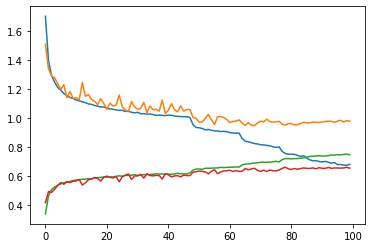

In [20]:
import pickle
pickle.dump(hist, open('featureactv422_baseline_hist.hdf5', 'wb'))

plt.plot(hist), best_acc

In [21]:
test_model = torch.load('featureactv422_baseline_model.pt')

# EVALUATE
test_model.eval()
running_valloss = 0.0
running_valacc = 0.0
for i,data in enumerate(test_loader):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = test_model(inputs)

    loss = criterion(outputs, labels)
    acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

    running_valloss += (loss.item() * inputs.size(0))
    running_valacc += acc.item()

print('- Avg. val_loss: %.3f | Avg. val_acc: %.3f' % (running_valloss / len(test_loader.dataset), running_valacc / len(test_loader.dataset)))

- Avg. val_loss: 0.928 | Avg. val_acc: 0.657


## Feature Act v4.3 single output each block (include dim 1 and dim 2 of cor faeture) + l2 norm

In [9]:
class FeatureAct(nn.Module):
    def __init__(self, src_depth, reduce_factor=1):
        super(FeatureAct, self).__init__()
        
#         self.softmax_d2 = nn.Softmax(dim=2)
#         self.softmax_d1 = nn.Softmax(dim=1)
        self.sigmoid = nn.Sigmoid()
        
        self.src_conv = nn.Conv2d(src_depth, src_depth // reduce_factor, kernel_size=1, padding=False)
        self.target_conv = nn.Conv2d(src_depth, src_depth // reduce_factor, kernel_size=1, padding=False)
        
        self.down_depth = nn.Sequential(nn.Conv2d(src_depth, src_depth // reduce_factor, kernel_size=1, padding=False),
                                        nn.ReLU(inplace=True))
        self.up_depth = nn.Sequential(nn.Conv2d(2* (src_depth // reduce_factor), src_depth, kernel_size=1, padding=False),
                                      nn.ReLU(inplace=True))
        
    def forward(self, x):
        
        src_features = self.src_conv(x)
        target_features = self.target_conv(x)
        
        cor = nn.Flatten(-2)(src_features[:, None, :, :]).permute(0,2,1,3) * nn.Flatten(-2)(target_features[:, None, :, :])
#         cor_d2 = self.softmax_d2(cor)
        
        main_features = self.down_depth(x)
        
        # d2
        cor_feature_d2 = torch.cat([(main_features * cor[:, :, k].view(-1, src_features.size(-3), src_features.size(-2), src_features.size(-1))).sum(1, keepdim=True) for k in range(cor.size(2))], dim=1)
        
        # d1
#         cor_d1 = self.softmax_d1(cor)
        cor_feature_d1 = torch.cat([(main_features * cor[:, k, :].view(-1, src_features.size(-3), src_features.size(-2), src_features.size(-1))).sum(1, keepdim=True) for k in range(cor.size(1))], dim=1)
        
        cor_feature = torch.cat([cor_feature_d2, cor_feature_d1], dim=1)
        cor_feature = self.up_depth(cor_feature)
        
        cor_feature = cor_feature / (torch.norm(cor_feature) + 1e-7)
        cor_feature = self.sigmoid(cor_feature)
        
        x = x + cor_feature
        
        return x

In [10]:
class BaselineFeatureAct(nn.Module):
    def __init__(self, embeddings=False):
        
        super(BaselineFeatureAct, self).__init__()
        
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=(2,2), stride=2)
        
        self.conv0 = nn.Conv2d(1, 32, kernel_size=(3,3), padding=1, stride=1)
        self.conv0b = nn.Conv2d(32, 32, kernel_size=(3,3), padding=1, stride=1)
        self.bn0 = nn.BatchNorm2d(32)
        self.bn0b = nn.BatchNorm2d(32)
        
        self.conv1 = nn.Conv2d(32, 64, kernel_size=(3,3), padding=1, stride=1)
        self.conv1b = nn.Conv2d(64, 64, kernel_size=(3,3), padding=1, stride=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.bn1b = nn.BatchNorm2d(64)
        
        self.conv2 = nn.Conv2d(64, 128, kernel_size=(3,3), padding=1, stride=1)
        self.conv2b = nn.Conv2d(128, 128, kernel_size=(3,3), padding=1, stride=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn2b = nn.BatchNorm2d(128)
        
        self.conv3 = nn.Conv2d(128, 256, kernel_size=(3,3), padding=1, stride=1)
        self.conv3b = nn.Conv2d(256, 256, kernel_size=(3,3), padding=1, stride=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.bn3b = nn.BatchNorm2d(256)
  
        self.fact0 = FeatureAct(32, 4)
        self.fact1 = FeatureAct(64, 4)
        self.fact2 = FeatureAct(128, 4)
        self.fact3 = FeatureAct(256, 4)
        
        if not embeddings:
            self.classifier = nn.Sequential(nn.Flatten(),
                                            nn.Linear(2304, 256), nn.BatchNorm1d(256), nn.ReLU(inplace=True),
                                            nn.Linear(256, 128), nn.BatchNorm1d(128), nn.ReLU(inplace=True),
                                            nn.Linear(128, 7), nn.BatchNorm1d(7))
        else:
            self.classifier = nn.Sequential(nn.Flatten(),
                                            nn.Linear(2304, 256), nn.BatchNorm1d(256), nn.ReLU(inplace=True),
                                            nn.Linear(256, 128), nn.BatchNorm1d(128))
        
    def forward(self, x):
        
        x = self.conv0(x)
        x = self.bn0(x)
        x = self.relu(x)
        x = self.conv0b(x)
        x = self.bn0b(x)
        x = self.relu(x)
        
        x0 = self.maxpool(x)
        x0 = self.fact0(x0)
        
        x = self.conv1(x0)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv1b(x)
        x = self.bn1b(x)
        x = self.relu(x)
        
        x1 = self.maxpool(x)
        x1 = self.fact1(x1)
        
        x = self.conv2(x1)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv2b(x)
        x = self.bn2b(x)
        x = self.relu(x)
        
        x2 = self.maxpool(x)
        x2 = self.fact2(x2)
        
        x = self.conv3(x2)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.conv3b(x)
        x = self.bn3b(x)
        x = self.relu(x)
        
        x3 = self.maxpool(x)
        x3 = self.fact3(x3)
        
        x = nn.Flatten()(x3)
        x = self.classifier(x)
        
        return x

In [11]:
device = torch.device('cuda')
model = BaselineFeatureAct().to(device)

best_acc = 0.0
hist = []

epochs=100

criterion = nn.CrossEntropyLoss()

learning_rate = 0.004
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=7, verbose=True)


In [12]:
model_path = './featureactv43_baseline_model.pt'

for epoch in range(100):  # loop over the dataset multiple times

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0
    processed = 0.0

    # TRAIN
    model.train()
    pbar = tqdm(train_loader, position=0)
    for i, data in enumerate(pbar):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()
        loss.backward()
        
        optimizer.step()

        # print statistics
        running_loss += (loss.item() * inputs.size(0))
        running_acc += acc.item()
        processed += len(inputs)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={i} Accuracy={acc.item() / inputs.size(0)}')

    print('- Avg.loss: %.3f | Avg.acc: %.3f' % (running_loss / len(train_loader.dataset), running_acc / len(train_loader.dataset)))
    avgloss = running_loss / len(train_loader.dataset)
    avgacc = running_acc / len(train_loader.dataset)

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

        running_valloss += (loss.item() * inputs.size(0))
        running_valacc += acc.item()

    print('- Avg. val_loss: %.3f | Avg. val_acc: %.3f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

    avgvalloss = running_valloss / len(val_loader.dataset)
    avgvalacc = running_valacc / len(val_loader.dataset)
    
    scheduler.step(avgvalloss)

    hist.append([avgloss, avgvalloss, avgacc, avgvalacc])
    
    if best_acc < avgvalacc:
        best_acc = avgvalacc
        torch.save(model, model_path)
        print('* Update optimal model')

print('Finished Training')

  0%|          | 0/225 [00:00<?, ?it/s]

Epoch:  1


Loss=1.4803550243377686 Batch_id=224 Accuracy=0.4594594594594595: 100%|██████████| 225/225 [00:50<00:00,  4.49it/s]

- Avg.loss: 1.665 | Avg.acc: 0.351



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.687 | Avg. val_acc: 0.368
* Update optimal model
Epoch:  2


Loss=1.2055647373199463 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:50<00:00,  4.50it/s]

- Avg.loss: 1.384 | Avg.acc: 0.472



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.447 | Avg. val_acc: 0.462
* Update optimal model
Epoch:  3


Loss=1.2462981939315796 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:50<00:00,  4.48it/s]

- Avg.loss: 1.300 | Avg.acc: 0.505



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.262 | Avg. val_acc: 0.518
* Update optimal model
Epoch:  4


Loss=1.3688137531280518 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [00:49<00:00,  4.51it/s]

- Avg.loss: 1.253 | Avg.acc: 0.523



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.353 | Avg. val_acc: 0.489
Epoch:  5


Loss=1.0757768154144287 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:50<00:00,  4.49it/s]

- Avg.loss: 1.221 | Avg.acc: 0.534



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.245 | Avg. val_acc: 0.529
* Update optimal model
Epoch:  6


Loss=1.3696407079696655 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [00:49<00:00,  4.50it/s]

- Avg.loss: 1.193 | Avg.acc: 0.549



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.354 | Avg. val_acc: 0.492
Epoch:  7


Loss=1.1635355949401855 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:49<00:00,  4.51it/s]

- Avg.loss: 1.177 | Avg.acc: 0.553



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.158 | Avg. val_acc: 0.554
* Update optimal model
Epoch:  8


Loss=1.1319140195846558 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:50<00:00,  4.47it/s]

- Avg.loss: 1.167 | Avg.acc: 0.553



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.311 | Avg. val_acc: 0.522
Epoch:  9


Loss=1.0725852251052856 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:50<00:00,  4.46it/s]

- Avg.loss: 1.149 | Avg.acc: 0.562



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.412 | Avg. val_acc: 0.448
Epoch:  10


Loss=1.2115813493728638 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [00:50<00:00,  4.49it/s]

- Avg.loss: 1.141 | Avg.acc: 0.567



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.247 | Avg. val_acc: 0.531
Epoch:  11


Loss=1.2636444568634033 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [00:49<00:00,  4.50it/s]

- Avg.loss: 1.134 | Avg.acc: 0.571



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.341 | Avg. val_acc: 0.488
Epoch:  12


Loss=0.9903450012207031 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:50<00:00,  4.49it/s]

- Avg.loss: 1.124 | Avg.acc: 0.573



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.259 | Avg. val_acc: 0.514
Epoch:  13


Loss=1.3146302700042725 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [00:50<00:00,  4.49it/s]

- Avg.loss: 1.123 | Avg.acc: 0.573



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.313 | Avg. val_acc: 0.542
Epoch:  14


Loss=1.419277310371399 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [00:50<00:00,  4.50it/s]

- Avg.loss: 1.110 | Avg.acc: 0.575



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.318 | Avg. val_acc: 0.507
Epoch:  15


Loss=1.0923445224761963 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [00:50<00:00,  4.47it/s]

- Avg.loss: 1.106 | Avg.acc: 0.581



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.203 | Avg. val_acc: 0.544
Epoch    15: reducing learning rate of group 0 to 2.0000e-03.
Epoch:  16


Loss=1.1282635927200317 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:50<00:00,  4.49it/s]

- Avg.loss: 1.052 | Avg.acc: 0.601



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.112 | Avg. val_acc: 0.576
* Update optimal model
Epoch:  17


Loss=0.9151772260665894 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:49<00:00,  4.51it/s]

- Avg.loss: 1.032 | Avg.acc: 0.608



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.071 | Avg. val_acc: 0.600
* Update optimal model
Epoch:  18


Loss=0.8709927201271057 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:50<00:00,  4.48it/s]

- Avg.loss: 1.029 | Avg.acc: 0.608



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.103 | Avg. val_acc: 0.581
Epoch:  19


Loss=1.4184508323669434 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [00:50<00:00,  4.49it/s]

- Avg.loss: 1.017 | Avg.acc: 0.617



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.092 | Avg. val_acc: 0.588
Epoch:  20


Loss=1.0754272937774658 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:50<00:00,  4.49it/s]

- Avg.loss: 1.017 | Avg.acc: 0.615



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.065 | Avg. val_acc: 0.605
* Update optimal model
Epoch:  21


Loss=1.6350911855697632 Batch_id=224 Accuracy=0.35135135135135137: 100%|██████████| 225/225 [00:50<00:00,  4.46it/s]

- Avg.loss: 1.010 | Avg.acc: 0.620



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.205 | Avg. val_acc: 0.549
Epoch:  22


Loss=0.8122667670249939 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:50<00:00,  4.45it/s]

- Avg.loss: 1.008 | Avg.acc: 0.616



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.103 | Avg. val_acc: 0.590
Epoch:  23


Loss=0.9664374589920044 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:49<00:00,  4.52it/s]

- Avg.loss: 1.000 | Avg.acc: 0.622



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.102 | Avg. val_acc: 0.589
Epoch:  24


Loss=1.0559356212615967 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:50<00:00,  4.47it/s]

- Avg.loss: 0.992 | Avg.acc: 0.623



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.169 | Avg. val_acc: 0.558
Epoch:  25


Loss=1.1424640417099 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:50<00:00,  4.47it/s]

- Avg.loss: 0.993 | Avg.acc: 0.623



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.121 | Avg. val_acc: 0.579
Epoch:  26


Loss=0.6994732022285461 Batch_id=224 Accuracy=0.8378378378378378: 100%|██████████| 225/225 [00:49<00:00,  4.52it/s]

- Avg.loss: 0.988 | Avg.acc: 0.625



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.053 | Avg. val_acc: 0.609
* Update optimal model
Epoch:  27


Loss=1.1910873651504517 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:50<00:00,  4.48it/s]

- Avg.loss: 0.984 | Avg.acc: 0.629



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.140 | Avg. val_acc: 0.579
Epoch:  28


Loss=0.8642640709877014 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:50<00:00,  4.46it/s]

- Avg.loss: 0.978 | Avg.acc: 0.631



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.171 | Avg. val_acc: 0.561
Epoch:  29


Loss=1.0504318475723267 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:49<00:00,  4.51it/s]

- Avg.loss: 0.973 | Avg.acc: 0.632



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.116 | Avg. val_acc: 0.578
Epoch:  30


Loss=1.2887601852416992 Batch_id=224 Accuracy=0.43243243243243246: 100%|██████████| 225/225 [00:50<00:00,  4.47it/s]

- Avg.loss: 0.971 | Avg.acc: 0.633



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.088 | Avg. val_acc: 0.605
Epoch:  31


Loss=1.245039463043213 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:50<00:00,  4.49it/s]

- Avg.loss: 0.964 | Avg.acc: 0.637



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.072 | Avg. val_acc: 0.604
Epoch:  32


Loss=0.7457689046859741 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:50<00:00,  4.49it/s]

- Avg.loss: 0.963 | Avg.acc: 0.636



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.257 | Avg. val_acc: 0.533
Epoch:  33


Loss=1.0314455032348633 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:50<00:00,  4.49it/s]

- Avg.loss: 0.958 | Avg.acc: 0.638



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.083 | Avg. val_acc: 0.603
Epoch:  34


Loss=0.8544055819511414 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:50<00:00,  4.47it/s]

- Avg.loss: 0.949 | Avg.acc: 0.642



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.065 | Avg. val_acc: 0.603
Epoch    34: reducing learning rate of group 0 to 1.0000e-03.
Epoch:  35


Loss=1.0599440336227417 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:49<00:00,  4.52it/s]

- Avg.loss: 0.908 | Avg.acc: 0.657



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.017 | Avg. val_acc: 0.623
* Update optimal model
Epoch:  36


Loss=0.8687238693237305 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:49<00:00,  4.50it/s]

- Avg.loss: 0.891 | Avg.acc: 0.667



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.002 | Avg. val_acc: 0.639
* Update optimal model
Epoch:  37


Loss=0.8244196176528931 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:50<00:00,  4.49it/s]

- Avg.loss: 0.887 | Avg.acc: 0.668



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.000 | Avg. val_acc: 0.641
* Update optimal model
Epoch:  38


Loss=0.8461869359016418 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:49<00:00,  4.51it/s]

- Avg.loss: 0.878 | Avg.acc: 0.670



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.000 | Avg. val_acc: 0.636
Epoch:  39


Loss=0.6533058285713196 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:50<00:00,  4.46it/s]

- Avg.loss: 0.870 | Avg.acc: 0.671



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.088 | Avg. val_acc: 0.605
Epoch:  40


Loss=1.0373200178146362 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:49<00:00,  4.52it/s]

- Avg.loss: 0.868 | Avg.acc: 0.677



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.008 | Avg. val_acc: 0.629
Epoch:  41


Loss=0.7751198410987854 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:50<00:00,  4.48it/s]

- Avg.loss: 0.867 | Avg.acc: 0.674



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.006 | Avg. val_acc: 0.633
Epoch:  42


Loss=0.8363092541694641 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:50<00:00,  4.46it/s]

- Avg.loss: 0.857 | Avg.acc: 0.680



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.031 | Avg. val_acc: 0.626
Epoch:  43


Loss=0.9681142568588257 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:50<00:00,  4.47it/s]

- Avg.loss: 0.855 | Avg.acc: 0.679



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.014 | Avg. val_acc: 0.633
Epoch:  44


Loss=0.7845326066017151 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:50<00:00,  4.49it/s]

- Avg.loss: 0.847 | Avg.acc: 0.684



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.037 | Avg. val_acc: 0.629
Epoch:  45


Loss=0.8891370892524719 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:50<00:00,  4.47it/s]

- Avg.loss: 0.844 | Avg.acc: 0.685



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.993 | Avg. val_acc: 0.641
Epoch:  46


Loss=1.1384609937667847 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:49<00:00,  4.50it/s]

- Avg.loss: 0.841 | Avg.acc: 0.687



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.995 | Avg. val_acc: 0.635
Epoch:  47


Loss=0.822215735912323 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:50<00:00,  4.49it/s]

- Avg.loss: 0.837 | Avg.acc: 0.687



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.027 | Avg. val_acc: 0.635
Epoch:  48


Loss=1.2080391645431519 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:50<00:00,  4.49it/s]

- Avg.loss: 0.831 | Avg.acc: 0.693



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.021 | Avg. val_acc: 0.635
Epoch:  49


Loss=0.8176855444908142 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:50<00:00,  4.48it/s]

- Avg.loss: 0.828 | Avg.acc: 0.688



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.003 | Avg. val_acc: 0.628
Epoch:  50


Loss=0.8342318534851074 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:50<00:00,  4.48it/s]

- Avg.loss: 0.823 | Avg.acc: 0.694



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.041 | Avg. val_acc: 0.626
Epoch:  51


Loss=0.7340831160545349 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:50<00:00,  4.47it/s]

- Avg.loss: 0.821 | Avg.acc: 0.693



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.023 | Avg. val_acc: 0.625
Epoch:  52


Loss=0.8913589715957642 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:50<00:00,  4.45it/s]

- Avg.loss: 0.818 | Avg.acc: 0.692



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.085 | Avg. val_acc: 0.610
Epoch:  53


Loss=1.260390043258667 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:50<00:00,  4.49it/s]

- Avg.loss: 0.806 | Avg.acc: 0.699



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.039 | Avg. val_acc: 0.620
Epoch    53: reducing learning rate of group 0 to 5.0000e-04.
Epoch:  54


Loss=0.7476474642753601 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:50<00:00,  4.46it/s]

- Avg.loss: 0.779 | Avg.acc: 0.712



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.999 | Avg. val_acc: 0.648
* Update optimal model
Epoch:  55


Loss=0.7524158358573914 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:50<00:00,  4.47it/s]

- Avg.loss: 0.765 | Avg.acc: 0.718



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.982 | Avg. val_acc: 0.645
Epoch:  56


Loss=0.7626563310623169 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [00:49<00:00,  4.51it/s]

- Avg.loss: 0.759 | Avg.acc: 0.718



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.980 | Avg. val_acc: 0.651
* Update optimal model
Epoch:  57


Loss=0.8865766525268555 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:50<00:00,  4.49it/s]

- Avg.loss: 0.753 | Avg.acc: 0.722



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.969 | Avg. val_acc: 0.653
* Update optimal model
Epoch:  58


Loss=0.9273080825805664 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:50<00:00,  4.46it/s]

- Avg.loss: 0.742 | Avg.acc: 0.729



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.983 | Avg. val_acc: 0.652
Epoch:  59


Loss=0.5973760485649109 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [00:50<00:00,  4.47it/s]

- Avg.loss: 0.740 | Avg.acc: 0.725



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.017 | Avg. val_acc: 0.637
Epoch:  60


Loss=0.8820602893829346 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:50<00:00,  4.49it/s]

- Avg.loss: 0.730 | Avg.acc: 0.731



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.993 | Avg. val_acc: 0.656
* Update optimal model
Epoch:  61


Loss=0.8875489234924316 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:49<00:00,  4.50it/s]

- Avg.loss: 0.733 | Avg.acc: 0.727



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.006 | Avg. val_acc: 0.651
Epoch:  62


Loss=0.8628524541854858 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:50<00:00,  4.46it/s]

- Avg.loss: 0.728 | Avg.acc: 0.734



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.011 | Avg. val_acc: 0.644
Epoch:  63


Loss=0.706326961517334 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:50<00:00,  4.48it/s]

- Avg.loss: 0.722 | Avg.acc: 0.734



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.005 | Avg. val_acc: 0.647
Epoch:  64


Loss=0.7040401697158813 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:50<00:00,  4.48it/s]

- Avg.loss: 0.712 | Avg.acc: 0.735



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.010 | Avg. val_acc: 0.646
Epoch:  65


Loss=1.037115216255188 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:50<00:00,  4.48it/s]

- Avg.loss: 0.718 | Avg.acc: 0.736



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.006 | Avg. val_acc: 0.651
Epoch    65: reducing learning rate of group 0 to 2.5000e-04.
Epoch:  66


Loss=0.49757570028305054 Batch_id=224 Accuracy=0.8108108108108109: 100%|██████████| 225/225 [00:49<00:00,  4.50it/s]

- Avg.loss: 0.692 | Avg.acc: 0.747



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.015 | Avg. val_acc: 0.641
Epoch:  67


Loss=0.7028230428695679 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:50<00:00,  4.50it/s]

- Avg.loss: 0.683 | Avg.acc: 0.747



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.002 | Avg. val_acc: 0.648
Epoch:  68


Loss=0.5299779176712036 Batch_id=224 Accuracy=0.8378378378378378: 100%|██████████| 225/225 [00:50<00:00,  4.50it/s]

- Avg.loss: 0.669 | Avg.acc: 0.754



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.007 | Avg. val_acc: 0.650
Epoch:  69


Loss=0.622410237789154 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:50<00:00,  4.48it/s]

- Avg.loss: 0.670 | Avg.acc: 0.753



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.017 | Avg. val_acc: 0.644
Epoch:  70


Loss=0.46015748381614685 Batch_id=224 Accuracy=0.8378378378378378: 100%|██████████| 225/225 [00:49<00:00,  4.51it/s]

- Avg.loss: 0.671 | Avg.acc: 0.754



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.032 | Avg. val_acc: 0.642
Epoch:  71


Loss=1.1144922971725464 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:50<00:00,  4.43it/s]

- Avg.loss: 0.659 | Avg.acc: 0.758



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.030 | Avg. val_acc: 0.646
Epoch:  72


Loss=0.5306310653686523 Batch_id=224 Accuracy=0.8108108108108109: 100%|██████████| 225/225 [00:50<00:00,  4.48it/s]

- Avg.loss: 0.661 | Avg.acc: 0.757



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.024 | Avg. val_acc: 0.648
Epoch:  73


Loss=0.5696395039558411 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [00:50<00:00,  4.49it/s]

- Avg.loss: 0.651 | Avg.acc: 0.762



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.017 | Avg. val_acc: 0.653
Epoch    73: reducing learning rate of group 0 to 1.2500e-04.
Epoch:  74


Loss=0.5310032367706299 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [00:50<00:00,  4.47it/s]

- Avg.loss: 0.640 | Avg.acc: 0.766



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.029 | Avg. val_acc: 0.652
Epoch:  75


Loss=0.6556230187416077 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [00:50<00:00,  4.47it/s]

- Avg.loss: 0.636 | Avg.acc: 0.768



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.006 | Avg. val_acc: 0.657
* Update optimal model
Epoch:  76


Loss=0.9260340332984924 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:50<00:00,  4.45it/s]

- Avg.loss: 0.630 | Avg.acc: 0.770



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.018 | Avg. val_acc: 0.650
Epoch:  77


Loss=0.9417577981948853 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:50<00:00,  4.48it/s]

- Avg.loss: 0.631 | Avg.acc: 0.771



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.018 | Avg. val_acc: 0.652
Epoch:  78


Loss=0.6919655203819275 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [00:49<00:00,  4.50it/s]

- Avg.loss: 0.627 | Avg.acc: 0.769



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.021 | Avg. val_acc: 0.655
Epoch:  79


Loss=0.8742004632949829 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:49<00:00,  4.50it/s]

- Avg.loss: 0.623 | Avg.acc: 0.774



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.025 | Avg. val_acc: 0.648
Epoch:  80


Loss=0.6741206049919128 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:49<00:00,  4.50it/s]

- Avg.loss: 0.620 | Avg.acc: 0.774



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.027 | Avg. val_acc: 0.645
Epoch:  81


Loss=0.6367296576499939 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [00:50<00:00,  4.49it/s]

- Avg.loss: 0.611 | Avg.acc: 0.777



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.025 | Avg. val_acc: 0.652
Epoch    81: reducing learning rate of group 0 to 6.2500e-05.
Epoch:  82


Loss=0.6048492789268494 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [00:50<00:00,  4.46it/s]

- Avg.loss: 0.605 | Avg.acc: 0.779



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.032 | Avg. val_acc: 0.655
Epoch:  83


Loss=0.7159742712974548 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:50<00:00,  4.47it/s]

- Avg.loss: 0.607 | Avg.acc: 0.777



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.031 | Avg. val_acc: 0.657
Epoch:  84


Loss=0.6779794692993164 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [00:50<00:00,  4.49it/s]

- Avg.loss: 0.605 | Avg.acc: 0.779



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.025 | Avg. val_acc: 0.653
Epoch:  85


Loss=0.6604812145233154 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:50<00:00,  4.46it/s]

- Avg.loss: 0.602 | Avg.acc: 0.779



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.026 | Avg. val_acc: 0.651
Epoch:  86


Loss=0.47106289863586426 Batch_id=224 Accuracy=0.8378378378378378: 100%|██████████| 225/225 [00:49<00:00,  4.51it/s]

- Avg.loss: 0.601 | Avg.acc: 0.779



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.031 | Avg. val_acc: 0.651
Epoch:  87


Loss=1.1835674047470093 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:50<00:00,  4.50it/s]

- Avg.loss: 0.597 | Avg.acc: 0.784



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.027 | Avg. val_acc: 0.656
Epoch:  88


Loss=0.8912619352340698 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:50<00:00,  4.45it/s]

- Avg.loss: 0.597 | Avg.acc: 0.784



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.026 | Avg. val_acc: 0.649
Epoch:  89


Loss=0.5641718506813049 Batch_id=224 Accuracy=0.8108108108108109: 100%|██████████| 225/225 [00:50<00:00,  4.47it/s]

- Avg.loss: 0.600 | Avg.acc: 0.781



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.032 | Avg. val_acc: 0.652
Epoch    89: reducing learning rate of group 0 to 3.1250e-05.
Epoch:  90


Loss=0.6786535382270813 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:50<00:00,  4.47it/s]

- Avg.loss: 0.592 | Avg.acc: 0.785



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.029 | Avg. val_acc: 0.651
Epoch:  91


Loss=1.0059051513671875 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:50<00:00,  4.48it/s]

- Avg.loss: 0.591 | Avg.acc: 0.787



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.030 | Avg. val_acc: 0.654
Epoch:  92


Loss=0.535223126411438 Batch_id=224 Accuracy=0.8108108108108109: 100%|██████████| 225/225 [00:50<00:00,  4.48it/s]

- Avg.loss: 0.582 | Avg.acc: 0.789



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.028 | Avg. val_acc: 0.654
Epoch:  93


Loss=0.6061273217201233 Batch_id=224 Accuracy=0.8108108108108109: 100%|██████████| 225/225 [00:50<00:00,  4.47it/s]

- Avg.loss: 0.585 | Avg.acc: 0.787



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.033 | Avg. val_acc: 0.656
Epoch:  94


Loss=0.8001953959465027 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:50<00:00,  4.45it/s]

- Avg.loss: 0.591 | Avg.acc: 0.786



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.032 | Avg. val_acc: 0.655
Epoch:  95


Loss=1.0091862678527832 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:50<00:00,  4.46it/s]

- Avg.loss: 0.590 | Avg.acc: 0.786



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.038 | Avg. val_acc: 0.652
Epoch:  96


Loss=0.6004663109779358 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:50<00:00,  4.49it/s]

- Avg.loss: 0.590 | Avg.acc: 0.784



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.036 | Avg. val_acc: 0.654
Epoch:  97


Loss=0.6982111930847168 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:50<00:00,  4.49it/s]

- Avg.loss: 0.584 | Avg.acc: 0.790



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.035 | Avg. val_acc: 0.656
Epoch    97: reducing learning rate of group 0 to 1.5625e-05.
Epoch:  98


Loss=0.4879566431045532 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [00:49<00:00,  4.51it/s]

- Avg.loss: 0.579 | Avg.acc: 0.790



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.034 | Avg. val_acc: 0.652
Epoch:  99


Loss=0.34463033080101013 Batch_id=224 Accuracy=0.9459459459459459: 100%|██████████| 225/225 [00:50<00:00,  4.50it/s]

- Avg.loss: 0.584 | Avg.acc: 0.787



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.031 | Avg. val_acc: 0.655
Epoch:  100


Loss=0.9869077801704407 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:50<00:00,  4.47it/s]

- Avg.loss: 0.589 | Avg.acc: 0.787


- Avg. val_loss: 1.040 | Avg. val_acc: 0.649
Finished Training


([<matplotlib.lines.Line2D at 0x7f4c7745e0b8>,
 0.657286152131513)

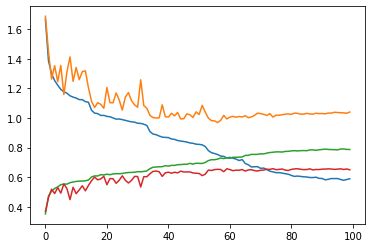

In [13]:
import pickle
pickle.dump(hist, open('featureactv43_baseline_hist.hdf5', 'wb'))


plt.plot(hist), best_acc

In [14]:
test_model = torch.load('featureactv43_baseline_model.pt')

# EVALUATE
test_model.eval()
running_valloss = 0.0
running_valacc = 0.0
for i,data in enumerate(test_loader):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = test_model(inputs)

    loss = criterion(outputs, labels)
    acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

    running_valloss += (loss.item() * inputs.size(0))
    running_valacc += acc.item()

print('- Avg. val_loss: %.3f | Avg. val_acc: %.3f' % (running_valloss / len(test_loader.dataset), running_valacc / len(test_loader.dataset)))

- Avg. val_loss: 0.949 | Avg. val_acc: 0.662


## Feature Act v3 single output

In [7]:
class FeatureAct(nn.Module):
    def __init__(self, src_depth, target_depth, reduce_factor=1):
        super(FeatureAct, self).__init__()
        
        self.softmax = nn.Softmax(dim=2)
        
        self.src_conv = nn.Conv2d(src_depth, src_depth // reduce_factor, kernel_size=1, padding=False)
        self.target_conv = nn.Conv2d(target_depth, target_depth // reduce_factor, kernel_size=1, padding=False)
        
        self.down_depth = nn.Sequential(nn.Conv2d(src_depth, src_depth // reduce_factor, kernel_size=1, padding=False),
                                        nn.ReLU(inplace=True))
        self.up_depth = nn.Sequential(nn.Conv2d(target_depth // reduce_factor, target_depth, kernel_size=1, padding=False),
                                      nn.ReLU(inplace=True))
        
    def forward(self, src_x, target_x):
        
        src_features = self.src_conv(src_x)
        target_features = self.target_conv(target_x)
        
        cor = nn.Flatten(-2)(src_features[:, None, :, :]).permute(0,2,1,3) * nn.Flatten(-2)(target_features[:, None, :, :])
        cor = self.softmax(cor)
        
        main_features = self.down_depth(src_x)
    
        cor_feature = torch.cat([(main_features * cor[:, :, k].view(-1, src_features.size(-3), src_features.size(-2), src_features.size(-1))).sum(1, keepdim=True) for k in range(cor.size(2))], dim=1)
        cor_feature = self.up_depth(cor_feature)
        
        target_x = target_x + cor_feature
        
        return target_x

In [8]:
class BaselineFeatureAct(nn.Module):
    def __init__(self, embeddings=False):
        
        super(BaselineFeatureAct, self).__init__()
        
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=(2,2), stride=2)
        
        self.conv0 = nn.Conv2d(1, 32, kernel_size=(3,3), padding=1, stride=1)
        self.conv0b = nn.Conv2d(32, 32, kernel_size=(3,3), padding=1, stride=1)
        self.bn0 = nn.BatchNorm2d(32)
        self.bn0b = nn.BatchNorm2d(32)
        
        self.conv1 = nn.Conv2d(32, 64, kernel_size=(3,3), padding=1, stride=1)
        self.conv1b = nn.Conv2d(64, 64, kernel_size=(3,3), padding=1, stride=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.bn1b = nn.BatchNorm2d(64)
        
        self.conv2 = nn.Conv2d(64, 128, kernel_size=(3,3), padding=1, stride=1)
        self.conv2b = nn.Conv2d(128, 128, kernel_size=(3,3), padding=1, stride=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn2b = nn.BatchNorm2d(128)
        
        self.conv3 = nn.Conv2d(128, 256, kernel_size=(3,3), padding=1, stride=1)
        self.conv3b = nn.Conv2d(256, 256, kernel_size=(3,3), padding=1, stride=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.bn3b = nn.BatchNorm2d(256)
  
        self.fact0 = FeatureAct(32, 32, 4)
        self.fact1 = FeatureAct(64, 64, 4)
        self.fact2 = FeatureAct(128, 128, 4)
        self.fact3 = FeatureAct(256, 256, 4)
        
        
        self.fact0_1 = FeatureAct(32, 64, 4, 2)
        self.fact0_2 = FeatureAct(32, 128, 4, 4)
        self.fact0_3 = FeatureAct(32, 256, 4, 8)
        
        self.fact1_2 = FeatureAct(64, 128, 4, 2)
        self.fact1_3 = FeatureAct(64, 256, 4, 4)
        
        self.fact2_3 = FeatureAct(128, 256, 4, 2)
        
        if not embeddings:
            self.classifier = nn.Sequential(nn.Flatten(),
                                            nn.Linear(2304, 256), nn.BatchNorm1d(256), nn.ReLU(inplace=True),
                                            nn.Linear(256, 128), nn.BatchNorm1d(128), nn.ReLU(inplace=True),
                                            nn.Linear(128, 7), nn.BatchNorm1d(7))
        else:
            self.classifier = nn.Sequential(nn.Flatten(),
                                            nn.Linear(2304, 256), nn.BatchNorm1d(256), nn.ReLU(inplace=True),
                                            nn.Linear(256, 128), nn.BatchNorm1d(128))
        
    def forward(self, x):
        
        x = self.conv0(x)
        x = self.bn0(x)
        _x0 = self.relu(x)
        
        x = self.conv0b(_x0)
        x = self.bn0b(x)
        x = self.relu(x)
        
        x0 = self.fact0(_x0, x)
        x0 = self.maxpool(x0)
        
        x = self.conv1(x0)
        x = self.bn1(x)
        _x1 = self.relu(x)
        
        x = self.conv1b(_x1)
        x = self.bn1b(x)
        x = self.relu(x)
        
        x1 = self.fact1(_x1, x)
        x1 = self.maxpool(x1)
        
        
        x = self.conv2(x1)
        x = self.bn2(x)
        _x2 = self.relu(x)
        
        x = self.conv2b(_x2)
        x = self.bn2b(x)
        x = self.relu(x)
        
        x2 = self.fact2(_x2, x)
        x2 = self.maxpool(x2)
        
        x = self.conv3(x2)
        x = self.bn3(x)
        _x3 = self.relu(x)
        
        x = self.conv3b(_x3)
        x = self.bn3b(x)
        x = self.relu(x)
        
        x3 = self.fact3(_x3, x)
        x3 = self.maxpool(x3)
        
        x = nn.Flatten()(x3)
        x = self.classifier(x)
        
        return x

In [9]:
device = torch.device('cuda')
model = BaselineFeatureAct().to(device)

best_acc = 0.0
hist = []

epochs=100

criterion = nn.CrossEntropyLoss()

learning_rate = 0.004
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=7, verbose=True)


In [ ]:
model_path = './featureactv3_baseline_modelv2.pt'

for epoch in range(100):  # loop over the dataset multiple times

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0
    processed = 0.0

    # TRAIN
    model.train()
    pbar = tqdm(train_loader, position=0)
    for i, data in enumerate(pbar):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()
        loss.backward()
        
        optimizer.step()

        # print statistics
        running_loss += (loss.item() * inputs.size(0))
        running_acc += acc.item()
        processed += len(inputs)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={i} Accuracy={acc.item() / inputs.size(0)}')

    print('- Avg.loss: %.3f | Avg.acc: %.3f' % (running_loss / len(train_loader.dataset), running_acc / len(train_loader.dataset)))
    avgloss = running_loss / len(train_loader.dataset)
    avgacc = running_acc / len(train_loader.dataset)

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

        running_valloss += (loss.item() * inputs.size(0))
        running_valacc += acc.item()

    print('- Avg. val_loss: %.3f | Avg. val_acc: %.3f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

    avgvalloss = running_valloss / len(val_loader.dataset)
    avgvalacc = running_valacc / len(val_loader.dataset)
    
    scheduler.step(avgvalloss)

    hist.append([avgloss, avgvalloss, avgacc, avgvalacc])
    
    if best_acc < avgvalacc:
        best_acc = avgvalacc
        torch.save(model, model_path)
        print('* Update optimal model')

print('Finished Training')

  0%|          | 0/225 [00:00<?, ?it/s]

Epoch:  1


Loss=1.5172053575515747 Batch_id=224 Accuracy=0.4594594594594595: 100%|██████████| 225/225 [01:17<00:00,  2.89it/s]

- Avg.loss: 1.644 | Avg.acc: 0.368



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.548 | Avg. val_acc: 0.417
* Update optimal model
Epoch:  2


Loss=1.3329356908798218 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [01:17<00:00,  2.89it/s]

- Avg.loss: 1.371 | Avg.acc: 0.476



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.342 | Avg. val_acc: 0.487
* Update optimal model
Epoch:  3


Loss=1.1360491514205933 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [01:18<00:00,  2.88it/s]

- Avg.loss: 1.281 | Avg.acc: 0.510



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.290 | Avg. val_acc: 0.512
* Update optimal model
Epoch:  4


Loss=1.3128786087036133 Batch_id=224 Accuracy=0.43243243243243246: 100%|██████████| 225/225 [01:18<00:00,  2.88it/s]


- Avg.loss: 1.239 | Avg.acc: 0.527


  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.209 | Avg. val_acc: 0.536
* Update optimal model
Epoch:  5


Loss=1.1746503114700317 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [01:17<00:00,  2.90it/s]

- Avg.loss: 1.209 | Avg.acc: 0.537



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.207 | Avg. val_acc: 0.528
Epoch:  6


Loss=1.4568512439727783 Batch_id=224 Accuracy=0.40540540540540543: 100%|██████████| 225/225 [01:17<00:00,  2.89it/s]

- Avg.loss: 1.179 | Avg.acc: 0.553



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.302 | Avg. val_acc: 0.509
Epoch:  7


Loss=1.319175362586975 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [01:17<00:00,  2.89it/s]

- Avg.loss: 1.166 | Avg.acc: 0.555



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.173 | Avg. val_acc: 0.560
* Update optimal model
Epoch:  8


Loss=1.0786899328231812 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [01:17<00:00,  2.89it/s]

- Avg.loss: 1.151 | Avg.acc: 0.563



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.431 | Avg. val_acc: 0.469
Epoch:  9


Loss=1.8466930389404297 Batch_id=224 Accuracy=0.40540540540540543: 100%|██████████| 225/225 [01:18<00:00,  2.88it/s]

- Avg.loss: 1.136 | Avg.acc: 0.565



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.227 | Avg. val_acc: 0.546
Epoch:  10


Loss=1.059881567955017 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [01:18<00:00,  2.88it/s]

- Avg.loss: 1.127 | Avg.acc: 0.571



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.222 | Avg. val_acc: 0.553
Epoch:  11


Loss=1.119201421737671 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [01:18<00:00,  2.87it/s]

- Avg.loss: 1.122 | Avg.acc: 0.573



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.142 | Avg. val_acc: 0.569
* Update optimal model
Epoch:  12


Loss=0.9066551923751831 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [01:17<00:00,  2.89it/s]

- Avg.loss: 1.119 | Avg.acc: 0.576



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.164 | Avg. val_acc: 0.564
Epoch:  13


Loss=1.189159631729126 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [01:17<00:00,  2.89it/s]

- Avg.loss: 1.107 | Avg.acc: 0.582



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.190 | Avg. val_acc: 0.541
Epoch:  14


Loss=1.2793744802474976 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [01:18<00:00,  2.87it/s]

- Avg.loss: 1.098 | Avg.acc: 0.582



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.170 | Avg. val_acc: 0.561
Epoch:  15


Loss=1.1651506423950195 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [01:18<00:00,  2.88it/s]

- Avg.loss: 1.096 | Avg.acc: 0.583



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.229 | Avg. val_acc: 0.538
Epoch:  16


Loss=1.0929875373840332 Batch_id=182 Accuracy=0.609375:  81%|████████  | 182/225 [01:04<00:14,  2.94it/s] 

In [10]:
model = torch.load('./featureactv3_baseline_modelv2.pt')

In [12]:
# EVALUATE
model.eval()
running_valloss = 0.0
running_valacc = 0.0
for i,data in enumerate(test_loader):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = model(inputs)

    loss = criterion(outputs, labels)
    acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

    running_valloss += (loss.item() * inputs.size(0))
    running_valacc += acc.item()

print('- Avg. val_loss: %.3f | Avg. val_acc: %.3f' % (running_valloss / len(test_loader.dataset), running_valacc / len(test_loader.dataset)))

- Avg. val_loss: 0.960 | Avg. val_acc: 0.656


## Single output + correlation

In [5]:
class SingleFeatureAct(nn.Module):
    def __init__(self, src_depth, reduce_factor=1):
        super(SingleFeatureAct, self).__init__()
        
        self.softmax = nn.Softmax(dim=2)
        
        self.src_conv = nn.Conv2d(src_depth, src_depth // reduce_factor, kernel_size=1, padding=False)
        self.target_conv = nn.Conv2d(src_depth, src_depth // reduce_factor, kernel_size=1, padding=False)
        
        self.down_depth = nn.Sequential(nn.Conv2d(src_depth, src_depth // reduce_factor, kernel_size=1, padding=False),
                                        nn.ReLU(inplace=True))
        self.up_depth = nn.Sequential(nn.Conv2d(src_depth // reduce_factor, src_depth, kernel_size=1, padding=False),
                                      nn.ReLU(inplace=True))
        
    def forward(self, x):
        
        src_features = self.src_conv(x)
        target_features = self.target_conv(x)
        
        cor = nn.Flatten(-2)(src_features[:, None, :, :]).permute(0,2,1,3) * nn.Flatten(-2)(target_features[:, None, :, :])
        cor = self.softmax(cor)
        
        main_features = self.down_depth(x)
    
        cor_feature = torch.cat([(main_features * cor[:, :, k].view(-1, src_features.size(-3), src_features.size(-2), src_features.size(-1))).sum(1, keepdim=True) for k in range(cor.size(2))], dim=1)
        cor_feature = self.up_depth(cor_feature)
        
        x = x + cor_feature
        
        return x
    
class CorrelatedFeatureAct(nn.Module):
    def __init__(self, src_depth, target_depth, reduce_factor=1, n_down=2):
        super(CorrelatedFeatureAct, self).__init__()
        
        self.pool = nn.MaxPool2d(kernel_size=(n_down,n_down), stride=n_down)
        self.relu = nn.ReLU(inplace=True)
        self.softmax = nn.Softmax(dim=2)
        
        self.src_conv = nn.Conv2d(src_depth, src_depth // reduce_factor, kernel_size=1, padding=False)
        self.target_conv = nn.Conv2d(target_depth, target_depth // reduce_factor, kernel_size=1, padding=False)
        
        self.down_depth = nn.Sequential(nn.Conv2d(src_depth, src_depth // reduce_factor, kernel_size=1, padding=False),
                                        nn.ReLU(inplace=True),
                                        nn.MaxPool2d(kernel_size=(n_down,n_down), stride=n_down))
        self.up_depth = nn.Sequential(nn.Conv2d(target_depth // reduce_factor, target_depth, kernel_size=1, padding=False),
                                      nn.ReLU(inplace=True))
        
    def forward(self, src_x, target_x):
        
        src_features = self.src_conv(src_x)
        src_features = self.pool(src_features)
        
        target_features = self.target_conv(target_x)
        
        cor = nn.Flatten(-2)(src_features[:, None, :, :]).permute(0,2,1,3) * nn.Flatten(-2)(target_features[:, None, :, :])
        cor = self.softmax(cor)

        main_features = self.down_depth(src_x)
    
        cor_feature = torch.cat([(main_features * cor[:, :, k].view(-1, src_features.size(-3), src_features.size(-2), src_features.size(-1))).sum(1, keepdim=True) for k in range(cor.size(2))], dim=1)
        cor_feature = self.up_depth(cor_feature)
        
        target_x = target_x + cor_feature
        
        return target_x

In [6]:
class BaselineFeatureAct(nn.Module):
    def __init__(self, embeddings=False):
        
        super(BaselineFeatureAct, self).__init__()
        
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=(2,2), stride=2)
        
        self.conv0 = nn.Conv2d(1, 32, kernel_size=(3,3), padding=1, stride=1)
        self.conv0b = nn.Conv2d(32, 32, kernel_size=(3,3), padding=1, stride=1)
        self.bn0 = nn.BatchNorm2d(32)
        self.bn0b = nn.BatchNorm2d(32)
        
        self.conv1 = nn.Conv2d(32, 64, kernel_size=(3,3), padding=1, stride=1)
        self.conv1b = nn.Conv2d(64, 64, kernel_size=(3,3), padding=1, stride=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.bn1b = nn.BatchNorm2d(64)
        
        self.conv2 = nn.Conv2d(64, 128, kernel_size=(3,3), padding=1, stride=1)
        self.conv2b = nn.Conv2d(128, 128, kernel_size=(3,3), padding=1, stride=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn2b = nn.BatchNorm2d(128)
        
        self.conv3 = nn.Conv2d(128, 256, kernel_size=(3,3), padding=1, stride=1)
        self.conv3b = nn.Conv2d(256, 256, kernel_size=(3,3), padding=1, stride=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.bn3b = nn.BatchNorm2d(256)
  
        self.fact0 = SingleFeatureAct(32, 4)
        self.fact1 = SingleFeatureAct(64, 4)
        self.fact2 = SingleFeatureAct(128, 4)
        self.fact3 = SingleFeatureAct(256, 4)
        
        self.fact0_1 = CorrelatedFeatureAct(32, 64, 4, 2)
        self.fact0_2 = CorrelatedFeatureAct(32, 128, 4, 4)
        self.fact0_3 = CorrelatedFeatureAct(32, 256, 4, 8)
        
        self.fact1_2 = CorrelatedFeatureAct(64, 128, 4, 2)
        self.fact1_3 = CorrelatedFeatureAct(64, 256, 4, 4)
        
        self.fact2_3 = CorrelatedFeatureAct(128, 256, 4, 2)
        
        if not embeddings:
            self.classifier = nn.Sequential(nn.Flatten(),
                                            nn.Linear(2304, 256), nn.BatchNorm1d(256), nn.ReLU(inplace=True),
                                            nn.Linear(256, 128), nn.BatchNorm1d(128), nn.ReLU(inplace=True),
                                            nn.Linear(128, 7), nn.BatchNorm1d(7))
        else:
            self.classifier = nn.Sequential(nn.Flatten(),
                                            nn.Linear(2304, 256), nn.BatchNorm1d(256), nn.ReLU(inplace=True),
                                            nn.Linear(256, 128), nn.BatchNorm1d(128))
        
    def forward(self, x):
        
        x = self.conv0(x)
        x = self.bn0(x)
        x = self.relu(x)
        x = self.conv0b(x)
        x = self.bn0b(x)
        x = self.relu(x)
        
        x0 = self.maxpool(x)
        self_x0 = self.fact0(x0)
        
        x = self.conv1(self_x0)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv1b(x)
        x = self.bn1b(x)
        x = self.relu(x)
        
        x1 = self.maxpool(x)
        self_x1 = self.fact1(x1)

        xfact0_1 = self.fact0_1(x0, x1) + self_x1
        
        x = self.conv2(xfact0_1)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv2b(x)
        x = self.bn2b(x)
        x = self.relu(x)
        
        x2 = self.maxpool(x)
        self_x2 = self.fact2(x2)

        xfact0_2 = self.fact0_2(x0, x2) + self_x2
        xfact1_2 = self.fact1_2(x1, x2) + xfact0_2
        
        x = self.conv3(xfact1_2)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.conv3b(x)
        x = self.bn3b(x)
        x = self.relu(x)
        
        x3 = self.maxpool(x)
        self_x3 = self.fact3(x3)

        xfact0_3 = self.fact0_3(x0,x3) + self_x3
        xfact1_3 = self.fact1_3(x1,x3)
        xfact2_3 = self.fact2_3(x2, x3) + xfact1_3 + xfact0_3
        
        x = nn.Flatten()(xfact2_3)
        x_out = self.classifier(x)
        
        return x

In [7]:
device = torch.device('cuda')
model = BaselineFeatureAct().to(device)

best_acc = 0.0
hist = []

epochs=100

criterion = nn.CrossEntropyLoss()

learning_rate = 0.004
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=7, verbose=True)


In [8]:
model_path = './featureactv3_cor_and_eachblock_model.pt'

for epoch in range(100):  # loop over the dataset multiple times

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0
    processed = 0.0

    # TRAIN
    model.train()
    pbar = tqdm(train_loader, position=0)
    for i, data in enumerate(pbar):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()
        loss.backward()
        
        optimizer.step()

        # print statistics
        running_loss += (loss.item() * inputs.size(0))
        running_acc += acc.item()
        processed += len(inputs)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={i} Accuracy={acc.item() / inputs.size(0)}')

    print('- Avg.loss: %.3f | Avg.acc: %.3f' % (running_loss / len(train_loader.dataset), running_acc / len(train_loader.dataset)))
    avgloss = running_loss / len(train_loader.dataset)
    avgacc = running_acc / len(train_loader.dataset)

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

        running_valloss += (loss.item() * inputs.size(0))
        running_valacc += acc.item()

    print('- Avg. val_loss: %.3f | Avg. val_acc: %.3f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

    avgvalloss = running_valloss / len(val_loader.dataset)
    avgvalacc = running_valacc / len(val_loader.dataset)
    
    scheduler.step(avgvalloss)

    hist.append([avgloss, avgvalloss, avgacc, avgvalacc])
    
    if best_acc < avgvalacc:
        best_acc = avgvalacc
        torch.save(model, model_path)
        print('* Update optimal model')

print('Finished Training')

  0%|          | 0/225 [00:00<?, ?it/s]

Epoch:  1


Loss=1.5290782451629639 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [01:03<00:00,  3.55it/s]

- Avg.loss: 1.849 | Avg.acc: 0.321



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.534 | Avg. val_acc: 0.408
* Update optimal model
Epoch:  2


Loss=1.1537559032440186 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [01:03<00:00,  3.54it/s]

- Avg.loss: 1.474 | Avg.acc: 0.435



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.453 | Avg. val_acc: 0.443
* Update optimal model
Epoch:  3


Loss=1.1115602254867554 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [01:03<00:00,  3.52it/s]

- Avg.loss: 1.371 | Avg.acc: 0.473



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.333 | Avg. val_acc: 0.497
* Update optimal model
Epoch:  4


Loss=1.2558118104934692 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [01:03<00:00,  3.52it/s]

- Avg.loss: 1.317 | Avg.acc: 0.497



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.520 | Avg. val_acc: 0.449
Epoch:  5


Loss=1.2007797956466675 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [01:03<00:00,  3.53it/s]

- Avg.loss: 1.266 | Avg.acc: 0.520



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.477 | Avg. val_acc: 0.460
Epoch:  6


Loss=1.192344069480896 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [01:03<00:00,  3.53it/s]

- Avg.loss: 1.243 | Avg.acc: 0.527



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.301 | Avg. val_acc: 0.510
* Update optimal model
Epoch:  7


Loss=1.0257461071014404 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [01:03<00:00,  3.53it/s]

- Avg.loss: 1.212 | Avg.acc: 0.542



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.338 | Avg. val_acc: 0.513
* Update optimal model
Epoch:  8


Loss=1.231459140777588 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [01:03<00:00,  3.54it/s]

- Avg.loss: 1.198 | Avg.acc: 0.548



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.170 | Avg. val_acc: 0.558
* Update optimal model
Epoch:  9


Loss=1.0368854999542236 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [01:04<00:00,  3.50it/s]

- Avg.loss: 1.182 | Avg.acc: 0.553



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.210 | Avg. val_acc: 0.548
Epoch:  10


Loss=1.334503173828125 Batch_id=224 Accuracy=0.43243243243243246: 100%|██████████| 225/225 [01:04<00:00,  3.51it/s]

- Avg.loss: 1.164 | Avg.acc: 0.560



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.210 | Avg. val_acc: 0.538
Epoch:  11


Loss=1.1398568153381348 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [01:03<00:00,  3.54it/s]

- Avg.loss: 1.160 | Avg.acc: 0.563



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.146 | Avg. val_acc: 0.563
* Update optimal model
Epoch:  12


Loss=1.0395323038101196 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [01:03<00:00,  3.54it/s]

- Avg.loss: 1.137 | Avg.acc: 0.570



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.140 | Avg. val_acc: 0.570
* Update optimal model
Epoch:  13


Loss=1.0116440057754517 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [01:03<00:00,  3.53it/s]

- Avg.loss: 1.129 | Avg.acc: 0.575



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.190 | Avg. val_acc: 0.551
Epoch:  14


Loss=1.1156482696533203 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [01:03<00:00,  3.53it/s]

- Avg.loss: 1.113 | Avg.acc: 0.579



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.219 | Avg. val_acc: 0.542
Epoch:  16


Loss=0.9575572609901428 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [01:04<00:00,  3.51it/s]

- Avg.loss: 1.095 | Avg.acc: 0.585



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.177 | Avg. val_acc: 0.562
Epoch:  19


Loss=1.0346472263336182 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [01:03<00:00,  3.54it/s]

- Avg.loss: 1.095 | Avg.acc: 0.585



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.123 | Avg. val_acc: 0.581
Epoch:  20


Loss=0.9417315125465393 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [01:03<00:00,  3.53it/s]

- Avg.loss: 1.086 | Avg.acc: 0.591



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.110 | Avg. val_acc: 0.581
* Update optimal model
Epoch:  21


Loss=1.0787767171859741 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [01:03<00:00,  3.52it/s]

- Avg.loss: 1.082 | Avg.acc: 0.593



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.136 | Avg. val_acc: 0.576
Epoch:  23


Loss=1.0267810821533203 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [01:03<00:00,  3.52it/s]

- Avg.loss: 1.071 | Avg.acc: 0.594



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.089 | Avg. val_acc: 0.597
* Update optimal model
Epoch:  25


Loss=1.0273751020431519 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [01:03<00:00,  3.54it/s]

- Avg.loss: 1.066 | Avg.acc: 0.600



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.083 | Avg. val_acc: 0.588
Epoch:  26


Loss=0.843323826789856 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [01:03<00:00,  3.53it/s]

- Avg.loss: 1.066 | Avg.acc: 0.600



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.135 | Avg. val_acc: 0.575
Epoch:  27


Loss=0.936043918132782 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [01:04<00:00,  3.51it/s]

- Avg.loss: 1.066 | Avg.acc: 0.598



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.112 | Avg. val_acc: 0.595
Epoch:  28


Loss=1.0737495422363281 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [01:03<00:00,  3.53it/s]

- Avg.loss: 1.057 | Avg.acc: 0.601



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.085 | Avg. val_acc: 0.591
Epoch:  29


Loss=1.1584393978118896 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [01:03<00:00,  3.54it/s]

- Avg.loss: 1.054 | Avg.acc: 0.604



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.073 | Avg. val_acc: 0.588
Epoch:  30


Loss=0.6675512790679932 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [01:04<00:00,  3.51it/s]

- Avg.loss: 1.054 | Avg.acc: 0.602



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.132 | Avg. val_acc: 0.581
Epoch:  31


Loss=1.10435950756073 Batch_id=21 Accuracy=0.5859375:   9%|▉         | 21/225 [00:07<00:57,  3.58it/s]  IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Loss=0.8944416642189026 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [01:03<00:00,  3.54it/s]

- Avg.loss: 1.048 | Avg.acc: 0.606



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.099 | Avg. val_acc: 0.602
* Update optimal model
Epoch:  33


Loss=1.2118271589279175 Batch_id=224 Accuracy=0.4594594594594595: 100%|██████████| 225/225 [01:03<00:00,  3.53it/s]

- Avg.loss: 1.044 | Avg.acc: 0.605



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.198 | Avg. val_acc: 0.571
Epoch:  34


Loss=1.1263935565948486 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [01:03<00:00,  3.54it/s]

- Avg.loss: 1.044 | Avg.acc: 0.608



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.092 | Avg. val_acc: 0.597
Epoch:  35


Loss=0.7179090976715088 Batch_id=224 Accuracy=0.8108108108108109: 100%|██████████| 225/225 [01:03<00:00,  3.53it/s]

- Avg.loss: 1.044 | Avg.acc: 0.608



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.134 | Avg. val_acc: 0.584
Epoch:  36


Loss=1.2821252346038818 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [01:03<00:00,  3.52it/s]

- Avg.loss: 1.037 | Avg.acc: 0.609



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.123 | Avg. val_acc: 0.585
Epoch:  37


Loss=1.0314812660217285 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [01:03<00:00,  3.52it/s]

- Avg.loss: 1.034 | Avg.acc: 0.611



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.092 | Avg. val_acc: 0.595
Epoch    37: reducing learning rate of group 0 to 2.0000e-03.
Epoch:  38


Loss=1.299582839012146 Batch_id=224 Accuracy=0.4594594594594595: 100%|██████████| 225/225 [01:03<00:00,  3.52it/s]

- Avg.loss: 0.981 | Avg.acc: 0.631



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.028 | Avg. val_acc: 0.621
* Update optimal model
Epoch:  39


Loss=1.088971734046936 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [01:03<00:00,  3.52it/s]

- Avg.loss: 0.965 | Avg.acc: 0.635



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.027 | Avg. val_acc: 0.625
* Update optimal model
Epoch:  40


Loss=0.6938909292221069 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [01:03<00:00,  3.52it/s]

- Avg.loss: 0.952 | Avg.acc: 0.644



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.019 | Avg. val_acc: 0.624
Epoch:  41


Loss=0.8677988648414612 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [01:03<00:00,  3.53it/s]

- Avg.loss: 0.948 | Avg.acc: 0.645



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.035 | Avg. val_acc: 0.618
Epoch:  42


Loss=0.862160325050354 Batch_id=111 Accuracy=0.7109375:  49%|████▉     | 111/225 [00:32<00:31,  3.64it/s] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Loss=0.7116833329200745 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [01:03<00:00,  3.52it/s]

- Avg.loss: 0.797 | Avg.acc: 0.701



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.027 | Avg. val_acc: 0.638
Epoch:  61


Loss=0.8680189847946167 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [01:03<00:00,  3.52it/s]

- Avg.loss: 0.789 | Avg.acc: 0.706



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.023 | Avg. val_acc: 0.639
Epoch    61: reducing learning rate of group 0 to 5.0000e-04.
Epoch:  62


Loss=0.8156957626342773 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [01:03<00:00,  3.53it/s]

- Avg.loss: 0.758 | Avg.acc: 0.717



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.020 | Avg. val_acc: 0.643
* Update optimal model
Epoch:  63


Loss=0.8470847606658936 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [01:03<00:00,  3.52it/s]

- Avg.loss: 0.741 | Avg.acc: 0.726



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.023 | Avg. val_acc: 0.653
* Update optimal model
Epoch:  64


Loss=0.8139210939407349 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [01:03<00:00,  3.53it/s]


- Avg.loss: 0.732 | Avg.acc: 0.728


  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.030 | Avg. val_acc: 0.651
Epoch:  65


Loss=1.094063639640808 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [01:03<00:00,  3.53it/s]

- Avg.loss: 0.727 | Avg.acc: 0.728



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.049 | Avg. val_acc: 0.638
Epoch:  66


Loss=0.7068496346473694 Batch_id=193 Accuracy=0.71875:  86%|████████▌ | 194/225 [00:55<00:08,  3.62it/s]  IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Loss=0.7376003265380859 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [01:03<00:00,  3.53it/s]

- Avg.loss: 0.610 | Avg.acc: 0.777



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.121 | Avg. val_acc: 0.655
* Update optimal model
Epoch:  85


Loss=0.6085379123687744 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [01:03<00:00,  3.53it/s]

- Avg.loss: 0.608 | Avg.acc: 0.777



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.124 | Avg. val_acc: 0.645
Epoch    85: reducing learning rate of group 0 to 6.2500e-05.
Epoch:  86


Loss=0.7000454068183899 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [01:03<00:00,  3.55it/s]

- Avg.loss: 0.603 | Avg.acc: 0.778



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.133 | Avg. val_acc: 0.643
Epoch:  87


Loss=0.7943974137306213 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [01:03<00:00,  3.55it/s]


- Avg.loss: 0.601 | Avg.acc: 0.779


  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.139 | Avg. val_acc: 0.645
Epoch:  88


Loss=0.29743409156799316 Batch_id=224 Accuracy=0.8378378378378378: 100%|██████████| 225/225 [01:03<00:00,  3.52it/s]

- Avg.loss: 0.599 | Avg.acc: 0.777



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.135 | Avg. val_acc: 0.645
Epoch:  89


Loss=0.724403440952301 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [01:03<00:00,  3.52it/s]

- Avg.loss: 0.588 | Avg.acc: 0.781



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.148 | Avg. val_acc: 0.650
Epoch:  90


Loss=0.4698340892791748 Batch_id=224 Accuracy=0.8378378378378378: 100%|██████████| 225/225 [01:04<00:00,  3.50it/s]

- Avg.loss: 0.601 | Avg.acc: 0.778



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.137 | Avg. val_acc: 0.645
Epoch:  91


Loss=0.6664333343505859 Batch_id=49 Accuracy=0.71875:  22%|██▏       | 50/225 [00:15<00:48,  3.64it/s]   IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



([<matplotlib.lines.Line2D at 0x7fe96eae7e48>,
 0.6547784898300362)

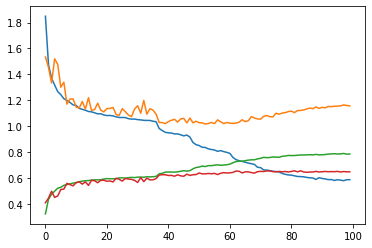

In [9]:
plt.plot(hist), best_acc

In [11]:
import pickle
pickle.dump(hist, open('featureactv3_cor_and_eachblock_hist.hdf5', 'wb'))

In [12]:
model = torch.load('featureactv3_cor_and_eachblock_model.pt')

# EVALUATE
model.eval()
running_valloss = 0.0
running_valacc = 0.0
for i,data in enumerate(test_loader):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = model(inputs)

    loss = criterion(outputs, labels)
    acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

    running_valloss += (loss.item() * inputs.size(0))
    running_valacc += acc.item()

print('- Avg. val_loss: %.3f | Avg. val_acc: %.3f' % (running_valloss / len(test_loader.dataset), running_valacc / len(test_loader.dataset)))

- Avg. val_loss: 1.105 | Avg. val_acc: 0.650
